In [1]:
import argparse
import json
import math
import os
import random
from time import time
import mlflow
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score
from collections import defaultdict

# import pytrec_eval
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss
from torch.utils.data import DataLoader, RandomSampler
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig, AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from accelerate import Accelerator
from copy import deepcopy

torch.backends.cuda.matmul.allow_tf32 = True

from watchog.dataset import (
    # collate_fn,
    TURLColTypeTablewiseDataset,
    TURLRelExtTablewiseDataset,
    SatoCVTablewiseDataset,
    ColPoplTablewiseDataset
)

from watchog.dataset import TableDataset, SupCLTableDataset, SemtableCVTablewiseDataset, GittablesColwiseDataset, GittablesTablewiseDataset
from watchog.model import BertMultiPairPooler, BertForMultiOutputClassification, BertForMultiOutputClassificationColPopl, Verifier
from watchog.model import SupCLforTable, UnsupCLforTable, lm_mp
from watchog.utils import load_checkpoint, f1_score_multilabel, collate_fn, get_col_pred, ColPoplEvaluator
from watchog.utils import task_num_class_dict
from accelerate import DistributedDataParallelKwargs
import wandb

from argparse import Namespace
import torch
import random
import pandas as pd
import numpy as np
import os
import pickle
import json
import re
import transformers
from torch.utils import data
from torch.nn.utils import rnn
from transformers import AutoTokenizer

from typing import List
from functools import reduce
import operator

from itertools import chain
import copy

[nltk_data] Downloading package punkt to /home/zhihao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/zhihao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
    device = torch.device(2)

    parser = argparse.ArgumentParser()
    parser.add_argument("--wandb", type=bool, default=False)
    parser.add_argument("--model", type=str, default="Watchog")
    parser.add_argument("--unlabeled_train_only", type=bool, default=False)
    parser.add_argument("--context_encoding_type", type=str, default="v0")
    parser.add_argument("--pool_version", type=str, default="v0.2")
    parser.add_argument("--random_sample", type=bool, default=False)
    parser.add_argument("--comment", type=str, default="debug", help="to distinguish the runs")
    parser.add_argument(
        "--shortcut_name",
        default="bert-base-uncased",
        type=str,
        help="Huggingface model shortcut name ",
    )
    parser.add_argument(
        "--max_length",
        default=64,
        type=int,
        help=
        "The maximum total input sequence length after tokenization. Sequences longer "
        "than this will be truncated, sequences shorter will be padded.",
    )
    parser.add_argument(
        "--adaptive_max_length",
        default=False,
        type=bool,
    )    
    parser.add_argument(
        "--max_num_col",
        default=8,
        type=int,
    )   

    parser.add_argument(
        "--batch_size",
        default=3,
        type=int,
        help="Batch size",
    )
    parser.add_argument(
        "--epoch",
        default=1,
        type=int,
        help="Number of epochs for training",
    )
    parser.add_argument(
        "--random_seed",
        default=4649,
        type=int,
        help="Random seed",
    )
    
    parser.add_argument(
        "--train_n_seed_cols",
        default=-1,
        type=int,
        help="number of seeding columns in training",
    )

    parser.add_argument(
        "--num_classes",
        default=78,
        type=int,
        help="Number of classes",
    )
    parser.add_argument("--multi_gpu",
                        action="store_true",
                        default=False,
                        help="Use multiple GPU")
    parser.add_argument("--fp16",
                        action="store_true",
                        default=False,
                        help="Use FP16")
    parser.add_argument("--warmup",
                        type=float,
                        default=0.,
                        help="Warmup ratio")
    parser.add_argument("--lr", type=float, default=5e-5, help="Learning rate")
    parser.add_argument("--task",
                        type=str,
                        default='gt-semtab22-dbpedia-all0',
                        choices=[
                            "sato0", "sato1", "sato2", "sato3", "sato4",
                            "msato0", "msato1", "msato2", "msato3", "msato4",
                            "gt-dbpedia0", "gt-dbpedia1", "gt-dbpedia2", "gt-dbpedia3", "gt-dbpedia4",
                            "gt-dbpedia-all0", "gt-dbpedia-all1", "gt-dbpedia-all2", "gt-dbpedia-all3", "gt-dbpedia-all4",
                            "gt-schema-all0", "gt-schema-all1", "gt-schema-all2", "gt-schema-all3", "gt-schema-all4",
                            "gt-semtab22-dbpedia", "gt-semtab22-dbpedia0", "gt-semtab22-dbpedia1", "gt-semtab22-dbpedia2", "gt-semtab22-dbpedia3", "gt-semtab22-dbpedia4",
                            "gt-semtab22-dbpedia-all", "gt-semtab22-dbpedia-all0", "gt-semtab22-dbpedia-all1", "gt-semtab22-dbpedia-all2", "gt-semtab22-dbpedia-all3", "gt-semtab22-dbpedia-all4",
                            "gt-semtab22-schema-class-all", "gt-semtab22-schema-property-all",
                            "turl", "turl-re", "col-popl-1", "col-popl-2", "col-popl-3", "row-popl",
                            "col-popl-turl-0", "col-popl-turl-1", "col-popl-turl-2",
                            "col-popl-turl-mdonly-0", "col-popl-turl-mdonly-1", "col-popl-turl-mdonly-2"
                        ],
                        help="Task names}")
    parser.add_argument("--colpair",
                        action="store_true",
                        help="Use column pair embedding")
    parser.add_argument("--metadata",
                        action="store_true",
                        help="Use column header metadata")
    parser.add_argument("--from_scratch",
                        action="store_true",
                        help="Training from scratch")
    parser.add_argument("--cl_tag",
                        type=str,
                        default="wikitables/simclr/bert_100000_10_32_256_5e-05_sample_row4,sample_row4_tfidf_entity_column_0.05_0_last.pt",
                        help="path to the pre-trained file")
    parser.add_argument("--dropout_prob",
                        type=float,
                        default=0.5)
    parser.add_argument("--eval_test",
                        action="store_true",
                        help="evaluate on testset and do not save the model file")
    parser.add_argument("--small_tag",
                        type=str,
                        default="semi1",
                        help="e.g., by_table_t5_v1")
    parser.add_argument("--data_path",
                        type=str,
                        default="/data/zhihao/TU/")
    parser.add_argument("--pretrained_ckpt_path",
                        type=str,
                        default="/data/zhihao/TU/Watchog/model/")    

    args = parser.parse_args([])
    task = args.task
    if args.small_tag != "":
        args.eval_test = True
    
    args.num_classes = task_num_class_dict[task]
    if args.colpair:
        assert "turl-re" == task, "colpair can be only used for Relation Extraction"
    if args.metadata:
        assert "turl-re" == task or "turl" == task, "metadata can be only used for TURL datasets"
    if "col-popl":
        # metrics = {
        #     "accuracy": CategoricalAccuracy(tie_break=True),
        # }
        if args.train_n_seed_cols != -1:
            if "col-popl" in task:
                assert args.train_n_seed_cols == int(task[-1]),  "# of seed columns must match"

    print("args={}".format(json.dumps(vars(args))))

    max_length = args.max_length
    batch_size = args.batch_size
    num_train_epochs = args.epoch

    shortcut_name = args.shortcut_name

    if args.colpair and args.metadata:
        taskname = "{}-colpair-metadata".format(task)
    elif args.colpair:
        taskname = "{}-colpair".format(task)
    elif args.metadata:
        taskname = "{}-metadata".format(task)
    elif args.train_n_seed_cols == -1 and 'popl' in task:
        taskname = "{}-mix".format(task)
    else:
        taskname = "".join(task)
    cv = int(task[-1])

    if args.from_scratch:
        if "gt" in task:
            tag_name = "{}/{}-{}-{}-pool{}-max_cols{}-rand{}-bs{}-ml{}-ne{}-do{}{}".format(
                taskname,  "{}-fromscratch".format(shortcut_name), args.small_tag, args.comment, args.pool_version, args.max_num_col, args.random_sample,
                batch_size, max_length, num_train_epochs, args.dropout_prob, 
                '-rs{}'.format(args.random_seed) if args.random_seed != 4649 else '')
        else:
            tag_name = "{}/{}-{}-{}-bs{}-ml{}-ne{}-do{}{}".format(
                taskname,  "{}-fromscratch".format(shortcut_name), args.small_tag, args.comment, 
                batch_size, max_length, num_train_epochs, args.dropout_prob, 
                '-rs{}'.format(args.random_seed) if args.random_seed != 4649 else '')
        
    else:
        if "gt" in task:
            tag_name = "{}/{}_{}-pool{}-max_cols{}-rand{}-bs{}-ml{}-ne{}-do{}{}".format(
                taskname, args.cl_tag.replace('/', '-'),  shortcut_name, args.small_tag, args.pool_version, args.max_num_col, args.random_sample,
                batch_size, max_length, num_train_epochs, args.dropout_prob,
                '-rs{}'.format(args.random_seed) if args.random_seed != 4649 else '')
        else:
            tag_name = "{}/{}_{}-{}-bs{}-ml{}-ne{}-do{}{}".format(
                taskname, args.cl_tag.replace('/', '-'),  shortcut_name, args.small_tag,
                batch_size, max_length, num_train_epochs, args.dropout_prob,
                '-rs{}'.format(args.random_seed) if args.random_seed != 4649 else '')

    # if args.eval_test:
    #     if args.small_tag != '':
    #         tag_name = tag_name.replace('outputs', 'small_outputs')
    #         tag_name += '-' + args.small_tag
    print(tag_name)
    file_path = os.path.join(args.data_path, "Watchog", "outputs", tag_name)

    dirpath = os.path.dirname(file_path)
    if not os.path.exists(dirpath):
        print("{} not exists. Created".format(dirpath))
        os.makedirs(dirpath)
    
    if args.fp16:
        torch.backends.cuda.matmul.allow_fp16_reduced_precision_reduction = True
        
      
        
    # accelerator = Accelerator(mixed_precision="no" if not args.fp16 else "fp16")   
    ddp_kwargs = DistributedDataParallelKwargs(find_unused_parameters=True)
    accelerator = Accelerator(mixed_precision="no" if not args.fp16 else "fp16", kwargs_handlers=[ddp_kwargs])

    device = torch.device(0)
    ckpt_path = os.path.join(args.pretrained_ckpt_path, args.cl_tag)
    # ckpt_path = '/efs/checkpoints/{}.pt'.format(args.cl_tag)
    ckpt = torch.load(ckpt_path, map_location=device)
    ckpt_hp = ckpt['hp']
    print(ckpt_hp)
 
    setattr(ckpt_hp, 'batch_size', args.batch_size)
    setattr(ckpt_hp, 'hidden_dropout_prob', args.dropout_prob)
    setattr(ckpt_hp, 'shortcut_name', args.shortcut_name)
    setattr(ckpt_hp, 'num_labels', args.num_classes)
    
    
    
    tokenizer = BertTokenizer.from_pretrained(shortcut_name)
    padder = collate_fn(tokenizer.pad_token_id)
    if task == "turl-re" and args.colpair:
        model = BertForMultiOutputClassification(ckpt_hp, device=device, lm=ckpt['hp'].lm, col_pair='Pair')
    elif "col-popl" in task:
        model = BertForMultiOutputClassificationColPopl(ckpt_hp, device=device, lm=ckpt['hp'].lm, n_seed_cols=int(task[i][-1]), cls_for_md="md" in task)
    else:
        model = BertForMultiOutputClassification(ckpt_hp, device=device, lm=ckpt['hp'].lm, version="v0", use_attention_mask=True)
        


args={"wandb": false, "model": "Watchog", "unlabeled_train_only": false, "context_encoding_type": "v0", "pool_version": "v0.2", "random_sample": false, "comment": "debug", "shortcut_name": "bert-base-uncased", "max_length": 64, "adaptive_max_length": false, "max_num_col": 8, "batch_size": 3, "epoch": 1, "random_seed": 4649, "train_n_seed_cols": -1, "num_classes": 101, "multi_gpu": false, "fp16": false, "warmup": 0.0, "lr": 5e-05, "task": "gt-semtab22-dbpedia-all0", "colpair": false, "metadata": false, "from_scratch": false, "cl_tag": "wikitables/simclr/bert_100000_10_32_256_5e-05_sample_row4,sample_row4_tfidf_entity_column_0.05_0_last.pt", "dropout_prob": 0.5, "eval_test": true, "small_tag": "semi1", "data_path": "/data/zhihao/TU/", "pretrained_ckpt_path": "/data/zhihao/TU/Watchog/model/"}
gt-semtab22-dbpedia-all0/wikitables-simclr-bert_100000_10_32_256_5e-05_sample_row4,sample_row4_tfidf_entity_column_0.05_0_last.pt_bert-base-uncased-poolsemi1-max_colsv0.2-rand8-bsFalse-ml3-ne64-do10.

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/tmp/ipykernel_102876/3989646571.py:214: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of

Namespace(augment_op='sample_row4,sample_row4', batch_size=32, data_path='/data/zhihao/TU/TURL/', fp16=True, gpus='0', lm='bert', logdir='/data/zhihao/TU/Watchog/model/', lr=5e-05, max_len=256, mode='simclr', model='Watchog', n_epochs=10, pretrain_data='wikitables', pretrained_model_path='', projector=768, run_id=0, sample_meth='tfidf_entity', save_model=10, single_column=False, size=100000, table_order='column', temperature=0.05)


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [3]:
# best_state_dict = torch.load("/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all0/bert-base-uncased-fromscratch-semi1-AttnMask-max-unlabeled@8-poolv0-unlabeled8-randFalse-bs16-ml128-ne50-do0.1_best_f1_micro.pt", map_location=device)
best_state_dict = torch.load("/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all0/bert-base-uncased-fromscratch-semi1-GT-Repeat@5-AttnMask-max-unlabeled@8-poolv0-unlabeled8-randTrue-bs16-ml128-ne50-do0.1_best_last_3.pt", map_location=device)
model.load_state_dict(best_state_dict, strict=False)
model = model.to(device)

/tmp/ipykernel_102876/3246719115.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_state_dict = torch.load("/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all0/b

In [8]:
filepath = os.path.join("/data/zhihao/TU/GitTables/semtab_gittables/2022","semi_cv_{}.csv".format(0))
df = pd.read_csv(filepath)

In [16]:
df

,table_id,col_idx,class,class_id,data
0,GitTables_100277,0,id,0,state_id_0;state_id_1;state_id_2;state_id_3;st...
1,GitTables_100277,1,name,1,Alytaus apskritis;Kauno apskritis;Klaipėdos ap...
2,GitTables_100277,2,NaN,-1,A;K;L;M;P;S;J;T;U;V
3,GitTables_100277,3,NaN,-1,base.lt;base.lt;base.lt;base.lt;base.lt;base.l...
4,GitTables_100850,0,NaN,-1,A1234582;13;A1234624;A1234595;A1234578;A123460...
...,...,...,...,...,...
9170,GitTables_99850,15,NaN,-1,0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;-10.0;...
9171,GitTables_99850,16,NaN,-1,rpm;Nm;rpm;rpm;KW;KW;W
9172,GitTables_99885,0,id,0,1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;1...
9173,GitTables_99885,1,NaN,-1,1;1;1;1;1;1;1;1;1;1;1;1;1;1;3;3;3;3;3;3;3;3;3;...


In [ ]:
df

In [56]:
df_labeled = df[df['class_id'] > -1]

In [60]:
num_cols_labeled = []
for index, group_df in df_labeled.groupby('table_id'):
    num_cols_labeled.append(len(group_df))

In [61]:
group_df

,table_id,col_idx,class,class_id,data
9172,GitTables_99885,0,id,0,1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;1...


<Axes: ylabel='Count'>

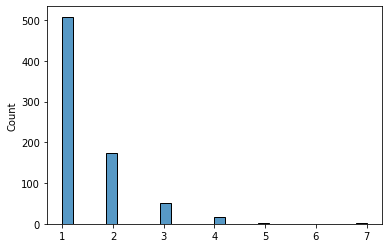

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(num_cols_labeled)

In [98]:
df_train = []
for i in range(5):
    if i == cv:
        continue
    filepath = os.path.join("/data/zhihao/TU/GitTables/semtab_gittables/2022","semi_cv_{}.csv".format(i))
    df_train.append(pd.read_csv(filepath))
df_train = pd.concat(df_train)

In [99]:
df_train_labeled = df_train[df_train['class_id'] != -1]

<Axes: ylabel='Count'>

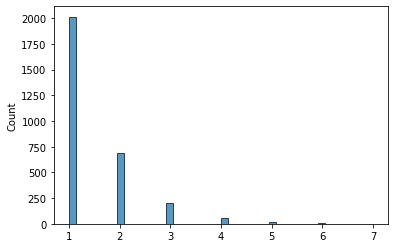

In [101]:
num_cols_labeled_train = []
for index, group_df in df_train_labeled.groupby('table_id'):
    num_cols_labeled_train.append(len(group_df))
sns.histplot(num_cols_labeled_train)

In [102]:
num_cols_labeled_train = torch.tensor(num_cols_labeled_train)
(num_cols_labeled_train>1).sum()/len(num_cols_labeled_train)

tensor(0.3254)

In [ ]:
for i, (index, group_df) in enumerate(df.groupby("table_id")):
    if len(group_df) >= 8 and len(group_df[group_df['class_id'] > -1]) >=4:
        break

In [ ]:
def classify_column(values):
    """
    Classify column values into one of three types:
    1. All Characters: All values are alphabetic.
    2. Both Characters and Numerics: At least one value contains both letters and numbers.
    3. All Numerics: All values are numeric (integers or floats).

    Args:
        values (list): List of column values (as strings).
    
    Returns:
        str: Classification of the column ('All Characters', 'Both Characters and Numerics', 'All Numerics').
    """
    if type(values) != list:
        raise ValueError("Invalid input type")
    importance = 0
    all_characters = True
    all_numerics = True
    mixed = False
    for value in values:
        # Strip any whitespace around the value
        value = value.replace(' ', '')
        if value.replace('-', '', 1).replace('.', '', 1).isdigit():
            all_characters = False
        if value.isalpha():
            all_numerics = False
    if all_characters and all_numerics:
        all_characters = False
        all_numerics = False
    if not all_characters and not all_numerics:
        mixed = True
    if all_characters:
        importance += 200
    elif mixed:
        importance += 100
    elif all_numerics:
        importance += 0
    else:
        raise ValueError("Invalid column values")
    unique_values = set(values) 
    importance += min(99, len(unique_values))
    

    return importance

# Example usage:
values1 = ["state id"]
values2 = ["0.0", "0.0", "0.0", "-10.0"]
values3 = ["1997-1-1"]
values4 = ["2020", "123", "abc"]

print(classify_column(values1))  # Output: Both Characters and Numerics
print(classify_column(values2))  # Output: All Numerics
print(classify_column(values3))  # Output: Both Characters and Numerics
print(classify_column(values4))  # Output: Both Characters and Numerics


In [ ]:
group_df

In [ ]:
semantic_scores = group_df["data"].apply(lambda x: classify_column(x.split(';'))).tolist(
    )

In [ ]:
group_df["class_id"].values

In [77]:
all_labels_raw = []
for i, (index, group_df) in enumerate(df.groupby("table_id")):
    group_df.sort_values(by=['col_idx'], inplace=True)
    all_labels_raw.append(torch.tensor(group_df["class_id"].values))
all_labels_raw = torch.cat(all_labels_raw)
all_labels_raw = all_labels_raw[all_labels_raw > -1]

In [ ]:
len(all_labels_raw)

In [ ]:
torch.equal(all_labels_raw, labels_test_original)

In [ ]:
class GittablesTablewiseLabelLastDataset(data.Dataset):

    def __init__(
            self,
            cv: int,
            split: str,
            src: str,  # train or test
            tokenizer: AutoTokenizer,
            max_length: int = 256,
            gt_only: bool = False,
            device: torch.device = None,
            base_dirpath: str = "/data/zhihao/TU/GitTables/semtab_gittables/2022",
            base_tag: str = '', # blank, comma
            small_tag: str = "",
            train_ratio: float = 1.0,
            max_unlabeled=8,
            adaptive_max_length=True,
            random_sample=False, # TODO
            train_only=False,
            seed=0): # TODO
        if device is None:
            device = torch.device('cpu')
        basename = small_tag+ "_cv_{}.csv"
    
        if split in ["train", "valid"]:
            df_list = []
            for i in range(5):
                if i == cv:
                    continue
                filepath = os.path.join(base_dirpath, basename.format(i))
                df_list.append(pd.read_csv(filepath))
                print(split, i)
            df = pd.concat(df_list, axis=0)
        else:
            # test
            filepath = os.path.join(base_dirpath, basename.format(cv))
            df = pd.read_csv(filepath)
            print(split)


        if gt_only:
            df = df[df["class_id"] > -1]
        if train_only and split != "train":
            df = df[df["class_id"] > -1]

        
        data_list = []
        
        df['class_id'] = df['class_id'].astype(int)
        df.drop(df[(df['data'].isna()) & (df['class_id'] == -1)].index, inplace=True)
        df['col_idx'] = df['col_idx'].astype(int)
        df['data'] = df['data'].astype(str)
        
        num_tables = len(df.groupby("table_id"))
        valid_index = int(num_tables * 0.8)
        num_train = int(train_ratio * num_tables * 0.8)        
        
        # df.drop(df[(df['data'] == '') & (df['class_id'] == -1)].index, inplace=True)
        total_num_cols = 0
        for i, (index, group_df) in enumerate(df.groupby("table_id")):
            if (split == "train") and ((i >= num_train) or (i >= valid_index)):
                break
            if split == "valid" and i < valid_index:
                continue
            #     break
            num_cols = len(group_df)
            group_df.sort_values(by=['col_idx'], inplace=True)
            labeled_columns = group_df[group_df['class_id'] > -1]
            unlabeled_columns = group_df[group_df['class_id'] == -1]
            num_unlabeled = min(max(max_unlabeled-len(labeled_columns), 0), len(unlabeled_columns)) if max_unlabeled > 0 else len(unlabeled_columns)
            unlabeled_columns = unlabeled_columns.tail(num_unlabeled)
            # group_df = pd.concat([group_df[group_df['class_id'] > -1], unlabeled_columns.sample(min(10-len(labeled_columns), len(unlabeled_columns)))])
            # group_df = pd.concat([group_df[group_df['class_id'] > -1], unlabeled_columns[0:min(max(10-len(labeled_columns), 0), len(unlabeled_columns))]])
            group_df = pd.concat([group_df[group_df['class_id'] > -1], unlabeled_columns]) 
            group_df.sort_values(by=['col_idx'], inplace=True) # TODO 
            col_idx_list = group_df["col_idx"].values
            
            if max_length <= 128 and adaptive_max_length:
                cur_maxlen = min(max_length, 512 // len(target_table) - 1)
            else:
                cur_maxlen = max_length
                
            token_ids_list = group_df["data"].apply(lambda x: tokenizer.encode(
                tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=cur_maxlen, truncation=True)).tolist(
                )
            token_ids = torch.LongTensor(reduce(operator.add,
                                                token_ids_list)).to(device)
            for col_i in range(len(token_ids_list)):
                if group_df["class_id"].values[col_i] == -1:
                    continue
                target_col_mask = []
                cls_index_value = 0
                context_id = 1
                for col_j in range(len(token_ids_list)):
                    if col_j == col_i:
                        target_col_mask += [0] * len(token_ids_list[col_j])
                    else:
                        target_col_mask += [context_id] * len(token_ids_list[col_j])
                        context_id += 1
                    if col_j < col_i:
                        cls_index_value += len(token_ids_list[col_j])
                cls_index_list = [cls_index_value] 
                for cls_index in cls_index_list:
                    assert token_ids[
                        cls_index] == tokenizer.cls_token_id, "cls_indexes validation"
                cls_indexes = torch.LongTensor(cls_index_list).to(device)
                class_ids = torch.LongTensor(
                    [group_df["class_id"].values[col_i]]).to(device)
                target_col_mask = torch.LongTensor(target_col_mask).to(device)
                data_list.append(
                    [index,
                    len(group_df), token_ids, class_ids, cls_indexes, target_col_mask, num_cols, col_idx_list])                
        print(split, len(data_list))
        self.table_df = pd.DataFrame(data_list,
                                     columns=[
                                         "table_id", "num_col", "data_tensor",
                                         "label_tensor", "cls_indexes", "target_col_mask", "initial_num_col", "col_idx_list"
                                     ])
        """
        # NOTE: msato contains a small portion of single-col tables. keep it to be consistent.  
        if multicol_only:
            # Check
            num_all_tables = len(self.table_df)
            self.table_df = self.table_df[self.table_df["num_col"] > 1]
            assert len(self.table_df) == num_all_tables
        """

    def __len__(self):
        return len(self.table_df)

    def __getitem__(self, idx):
        return {
            "data": self.table_df.iloc[idx]["data_tensor"],
            "label": self.table_df.iloc[idx]["label_tensor"],
            "cls_indexes": self.table_df.iloc[idx]["cls_indexes"],
            "target_col_mask": self.table_df.iloc[idx]["target_col_mask"],
            "initial_num_col": self.table_df.iloc[idx]["initial_num_col"],
            "col_idx_list": self.table_df.iloc[idx]["col_idx_list"],
        }
        #"idx": torch.LongTensor([idx])}
        #"cls_indexes": self.table_df.iloc[idx]["cls_indexes"]}

In [ ]:
class GittablesTablewiseLabelFirstDataset(data.Dataset):

    def __init__(
            self,
            cv: int,
            split: str,
            src: str,  # train or test
            tokenizer: AutoTokenizer,
            max_length: int = 256,
            gt_only: bool = False,
            device: torch.device = None,
            base_dirpath: str = "/data/zhihao/TU/GitTables/semtab_gittables/2022",
            base_tag: str = '', # blank, comma
            small_tag: str = "",
            train_ratio: float = 1.0,
            max_unlabeled=8,
            adaptive_max_length=True,
            random_sample=False, # TODO
            train_only=False,
            seed=0): # TODO
        if device is None:
            device = torch.device('cpu')
        basename = small_tag+ "_cv_{}.csv"
    
        if split in ["train", "valid"]:
            df_list = []
            for i in range(5):
                if i == cv:
                    continue
                filepath = os.path.join(base_dirpath, basename.format(i))
                df_list.append(pd.read_csv(filepath))
                print(split, i)
            df = pd.concat(df_list, axis=0)
        else:
            # test
            filepath = os.path.join(base_dirpath, basename.format(cv))
            df = pd.read_csv(filepath)
            print(split)


        if gt_only:
            df = df[df["class_id"] > -1]
        if train_only and split != "train":
            df = df[df["class_id"] > -1]

        
        data_list = []
        
        df['class_id'] = df['class_id'].astype(int)
        df.drop(df[(df['data'].isna()) & (df['class_id'] == -1)].index, inplace=True)
        df['col_idx'] = df['col_idx'].astype(int)
        df['data'] = df['data'].astype(str)
        
        num_tables = len(df.groupby("table_id"))
        valid_index = int(num_tables * 0.8)
        num_train = int(train_ratio * num_tables * 0.8)        
        
        # df.drop(df[(df['data'] == '') & (df['class_id'] == -1)].index, inplace=True)
        total_num_cols = 0
        for i, (index, group_df) in enumerate(df.groupby("table_id")):
            if (split == "train") and ((i >= num_train) or (i >= valid_index)):
                break
            if split == "valid" and i < valid_index:
                continue
            #     break
            num_cols = len(group_df)
            group_df.sort_values(by=['col_idx'], inplace=True)
            labeled_columns = group_df[group_df['class_id'] > -1]
            unlabeled_columns = group_df[group_df['class_id'] == -1]
            num_unlabeled = min(max(max_unlabeled-len(labeled_columns), 0), len(unlabeled_columns)) if max_unlabeled > 0 else len(unlabeled_columns)
            unlabeled_columns = unlabeled_columns.head(num_unlabeled)
            # group_df = pd.concat([group_df[group_df['class_id'] > -1], unlabeled_columns.sample(min(10-len(labeled_columns), len(unlabeled_columns)))])
            # group_df = pd.concat([group_df[group_df['class_id'] > -1], unlabeled_columns[0:min(max(10-len(labeled_columns), 0), len(unlabeled_columns))]])
            group_df = pd.concat([group_df[group_df['class_id'] > -1], unlabeled_columns]) 
            group_df.sort_values(by=['col_idx'], inplace=True) # TODO 

            if max_length <= 128 and adaptive_max_length:
                cur_maxlen = min(max_length, 512 // len(target_table) - 1)
            else:
                cur_maxlen = max_length
                
            token_ids_list = group_df["data"].apply(lambda x: tokenizer.encode(
                tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=cur_maxlen, truncation=True)).tolist(
                )
            token_ids = torch.LongTensor(reduce(operator.add,
                                                token_ids_list)).to(device)
            for col_i in range(len(token_ids_list)):
                if group_df["class_id"].values[col_i] == -1:
                    continue
                target_col_mask = []
                cls_index_value = 0
                context_id = 1
                for col_j in range(len(token_ids_list)):
                    if col_j == col_i:
                        target_col_mask += [0] * len(token_ids_list[col_j])
                    else:
                        target_col_mask += [context_id] * len(token_ids_list[col_j])
                        context_id += 1
                    if col_j < col_i:
                        cls_index_value += len(token_ids_list[col_j])
                cls_index_list = [cls_index_value] 
                for cls_index in cls_index_list:
                    assert token_ids[
                        cls_index] == tokenizer.cls_token_id, "cls_indexes validation"
                cls_indexes = torch.LongTensor(cls_index_list).to(device)
                class_ids = torch.LongTensor(
                    [group_df["class_id"].values[col_i]]).to(device)
                target_col_mask = torch.LongTensor(target_col_mask).to(device)
                data_list.append(
                    [index,
                    len(group_df), token_ids, class_ids, cls_indexes, target_col_mask, num_cols])                
        print(split, len(data_list))
        self.table_df = pd.DataFrame(data_list,
                                     columns=[
                                         "table_id", "num_col", "data_tensor",
                                         "label_tensor", "cls_indexes", "target_col_mask", "initial_num_col"
                                     ])
        """
        # NOTE: msato contains a small portion of single-col tables. keep it to be consistent.  
        if multicol_only:
            # Check
            num_all_tables = len(self.table_df)
            self.table_df = self.table_df[self.table_df["num_col"] > 1]
            assert len(self.table_df) == num_all_tables
        """

    def __len__(self):
        return len(self.table_df)

    def __getitem__(self, idx):
        return {
            "data": self.table_df.iloc[idx]["data_tensor"],
            "label": self.table_df.iloc[idx]["label_tensor"],
            "cls_indexes": self.table_df.iloc[idx]["cls_indexes"],
            "target_col_mask": self.table_df.iloc[idx]["target_col_mask"],
            "initial_num_col": self.table_df.iloc[idx]["initial_num_col"],
        }
        #"idx": torch.LongTensor([idx])}
        #"cls_indexes": self.table_df.iloc[idx]["cls_indexes"]}

In [ ]:
class GittablesTablewiseRandomDataset(data.Dataset):

    def __init__(
            self,
            cv: int,
            split: str,
            src: str,  # train or test
            tokenizer: AutoTokenizer,
            max_length: int = 256,
            gt_only: bool = False,
            device: torch.device = None,
            base_dirpath: str = "/data/zhihao/TU/GitTables/semtab_gittables/2022",
            base_tag: str = '', # blank, comma
            small_tag: str = "",
            train_ratio: float = 1.0,
            max_unlabeled=8,
            adaptive_max_length=True,
            random_sample=False, # TODO
            train_only=False,
            seed=0): # TODO
        if device is None:
            device = torch.device('cpu')
        basename = small_tag+ "_cv_{}.csv"
    
        if split in ["train", "valid"]:
            df_list = []
            for i in range(5):
                if i == cv:
                    continue
                filepath = os.path.join(base_dirpath, basename.format(i))
                df_list.append(pd.read_csv(filepath))
                print(split, i)
            df = pd.concat(df_list, axis=0)
        else:
            # test
            filepath = os.path.join(base_dirpath, basename.format(cv))
            df = pd.read_csv(filepath)
            print(split)


        if gt_only:
            df = df[df["class_id"] > -1]
        if train_only and split != "train":
            df = df[df["class_id"] > -1]

        
        data_list = []
        
        df['class_id'] = df['class_id'].astype(int)
        df.drop(df[(df['data'].isna()) & (df['class_id'] == -1)].index, inplace=True)
        df['col_idx'] = df['col_idx'].astype(int)
        df['data'] = df['data'].astype(str)
        
        num_tables = len(df.groupby("table_id"))
        valid_index = int(num_tables * 0.8)
        num_train = int(train_ratio * num_tables * 0.8)        
        
        # df.drop(df[(df['data'] == '') & (df['class_id'] == -1)].index, inplace=True)
        total_num_cols = 0
        for i, (index, group_df) in enumerate(df.groupby("table_id")):
            if (split == "train") and ((i >= num_train) or (i >= valid_index)):
                break
            if split == "valid" and i < valid_index:
                continue
            #     break
            labeled_columns = group_df[group_df['class_id'] > -1]
            for index, target_column in labeled_columns.iterrows():
                target_col_idx = target_column["col_idx"]
                
                other_columns = group_df.drop(index).sample(min(max_unlabeled, len(group_df))-1, random_state=seed)
                

                target_table = pd.concat([target_column.to_frame().T, other_columns], ignore_index=True)

                # other_columns['distance'] = abs(other_columns['col_idx'] - target_col_idx)
                # other_columns.sort_values(by='distance', inplace=True)
                # nearby_columns = other_columns.head(max_unlabeled-1)
                # target_table = pd.concat([target_column.to_frame().T, nearby_columns], ignore_index=True)
                
                
                target_cls = target_column["class_id"]
                target_table.sort_values(by=['col_idx'], inplace=True)
                col_idx_list = target_table["col_idx"].tolist()

                if max_length <= 128 and adaptive_max_length:
                    cur_maxlen = min(max_length, 512 // len(target_table) - 1)
                else:
                    cur_maxlen = max_length
                    
                token_ids_list = target_table["data"].apply(lambda x: tokenizer.encode(
                    tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=cur_maxlen, truncation=True)).tolist(
                    )
                token_ids = torch.LongTensor(reduce(operator.add,
                                                    token_ids_list)).to(device)

                target_col_mask = []
                cls_index_value = 0
                context_id = 1
                meet_target = False
                for idx, col_i in enumerate(col_idx_list):
                    if col_i == target_col_idx:
                        target_col_mask += [0] * len(token_ids_list[idx])
                        meet_target = True
                    else:
                        target_col_mask += [context_id] * len(token_ids_list[idx])
                        context_id += 1
                    if not meet_target:
                        cls_index_value += len(token_ids_list[idx])
                cls_index_list = [cls_index_value] 
                for cls_index in cls_index_list:
                    assert token_ids[
                        cls_index] == tokenizer.cls_token_id, "cls_indexes validation"
                cls_indexes = torch.LongTensor(cls_index_list).to(device)
                class_ids = torch.LongTensor(
                    [target_cls]).to(device)
                target_col_mask = torch.LongTensor(target_col_mask).to(device)
                data_list.append(
                    [index,
                    len(target_table), token_ids, class_ids, cls_indexes, target_col_mask, len(group_df)])         
        print(split, len(data_list))
        self.table_df = pd.DataFrame(data_list,
                                     columns=[
                                         "table_id", "num_col", "data_tensor",
                                         "label_tensor", "cls_indexes", "target_col_mask", "initial_num_col"
                                     ])
        """
        # NOTE: msato contains a small portion of single-col tables. keep it to be consistent.  
        if multicol_only:
            # Check
            num_all_tables = len(self.table_df)
            self.table_df = self.table_df[self.table_df["num_col"] > 1]
            assert len(self.table_df) == num_all_tables
        """

    def __len__(self):
        return len(self.table_df)

    def __getitem__(self, idx):
        return {
            "data": self.table_df.iloc[idx]["data_tensor"],
            "label": self.table_df.iloc[idx]["label_tensor"],
            "cls_indexes": self.table_df.iloc[idx]["cls_indexes"],
            "target_col_mask": self.table_df.iloc[idx]["target_col_mask"],
            "initial_num_col": self.table_df.iloc[idx]["initial_num_col"],
        }
        #"idx": torch.LongTensor([idx])}
        #"cls_indexes": self.table_df.iloc[idx]["cls_indexes"]}

In [ ]:
class GittablesTablewiseLabelRandomDataset(data.Dataset):

    def __init__(
            self,
            cv: int,
            split: str,
            src: str,  # train or test
            tokenizer: AutoTokenizer,
            max_length: int = 256,
            gt_only: bool = False,
            device: torch.device = None,
            base_dirpath: str = "/data/zhihao/TU/GitTables/semtab_gittables/2022",
            base_tag: str = '', # blank, comma
            small_tag: str = "",
            train_ratio: float = 1.0,
            max_unlabeled=8,
            adaptive_max_length=True,
            random_sample=False, # TODO
            train_only=False,
            seed=0): # TODO
        if device is None:
            device = torch.device('cpu')
        basename = small_tag+ "_cv_{}.csv"
    
        if split in ["train", "valid"]:
            df_list = []
            for i in range(5):
                if i == cv:
                    continue
                filepath = os.path.join(base_dirpath, basename.format(i))
                df_list.append(pd.read_csv(filepath))
                print(split, i)
            df = pd.concat(df_list, axis=0)
        else:
            # test
            filepath = os.path.join(base_dirpath, basename.format(cv))
            df = pd.read_csv(filepath)
            print(split)


        if gt_only:
            df = df[df["class_id"] > -1]
        if train_only and split != "train":
            df = df[df["class_id"] > -1]

        
        data_list = []
        
        df['class_id'] = df['class_id'].astype(int)
        df.drop(df[(df['data'].isna()) & (df['class_id'] == -1)].index, inplace=True)
        df['col_idx'] = df['col_idx'].astype(int)
        df['data'] = df['data'].astype(str)
        
        num_tables = len(df.groupby("table_id"))
        valid_index = int(num_tables * 0.8)
        num_train = int(train_ratio * num_tables * 0.8)        
        
        # df.drop(df[(df['data'] == '') & (df['class_id'] == -1)].index, inplace=True)
        total_num_cols = 0
        for i, (index, group_df) in enumerate(df.groupby("table_id")):
            if (split == "train") and ((i >= num_train) or (i >= valid_index)):
                break
            if split == "valid" and i < valid_index:
                continue
            #     break
            num_cols = len(group_df)
            group_df.sort_values(by=['col_idx'], inplace=True)
            labeled_columns = group_df[group_df['class_id'] > -1]
            unlabeled_columns = group_df[group_df['class_id'] == -1]
            num_unlabeled = min(max(max_unlabeled-len(labeled_columns), 0), len(unlabeled_columns)) if max_unlabeled > 0 else len(unlabeled_columns)
            unlabeled_columns = unlabeled_columns.sample(num_unlabeled, random_state=seed) 
            # group_df = pd.concat([group_df[group_df['class_id'] > -1], unlabeled_columns.sample(min(10-len(labeled_columns), len(unlabeled_columns)))])
            # group_df = pd.concat([group_df[group_df['class_id'] > -1], unlabeled_columns[0:min(max(10-len(labeled_columns), 0), len(unlabeled_columns))]])
            group_df = pd.concat([group_df[group_df['class_id'] > -1], unlabeled_columns]) 
            group_df.sort_values(by=['col_idx'], inplace=True) # TODO 

            if max_length <= 128 and adaptive_max_length:
                cur_maxlen = min(max_length, 512 // len(target_table) - 1)
            else:
                cur_maxlen = max_length
                
            token_ids_list = group_df["data"].apply(lambda x: tokenizer.encode(
                tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=cur_maxlen, truncation=True)).tolist(
                )
            token_ids = torch.LongTensor(reduce(operator.add,
                                                token_ids_list)).to(device)
            for col_i in range(len(token_ids_list)):
                if group_df["class_id"].values[col_i] == -1:
                    continue
                target_col_mask = []
                cls_index_value = 0
                context_id = 1
                for col_j in range(len(token_ids_list)):
                    if col_j == col_i:
                        target_col_mask += [0] * len(token_ids_list[col_j])
                    else:
                        target_col_mask += [context_id] * len(token_ids_list[col_j])
                        context_id += 1
                    if col_j < col_i:
                        cls_index_value += len(token_ids_list[col_j])
                cls_index_list = [cls_index_value] 
                for cls_index in cls_index_list:
                    assert token_ids[
                        cls_index] == tokenizer.cls_token_id, "cls_indexes validation"
                cls_indexes = torch.LongTensor(cls_index_list).to(device)
                class_ids = torch.LongTensor(
                    [group_df["class_id"].values[col_i]]).to(device)
                target_col_mask = torch.LongTensor(target_col_mask).to(device)
                data_list.append(
                    [index,
                    len(group_df), token_ids, class_ids, cls_indexes, target_col_mask, num_cols])                
        print(split, len(data_list))
        self.table_df = pd.DataFrame(data_list,
                                     columns=[
                                         "table_id", "num_col", "data_tensor",
                                         "label_tensor", "cls_indexes", "target_col_mask", "initial_num_col"
                                     ])
        """
        # NOTE: msato contains a small portion of single-col tables. keep it to be consistent.  
        if multicol_only:
            # Check
            num_all_tables = len(self.table_df)
            self.table_df = self.table_df[self.table_df["num_col"] > 1]
            assert len(self.table_df) == num_all_tables
        """

    def __len__(self):
        return len(self.table_df)

    def __getitem__(self, idx):
        return {
            "data": self.table_df.iloc[idx]["data_tensor"],
            "label": self.table_df.iloc[idx]["label_tensor"],
            "cls_indexes": self.table_df.iloc[idx]["cls_indexes"],
            "target_col_mask": self.table_df.iloc[idx]["target_col_mask"],
            "initial_num_col": self.table_df.iloc[idx]["initial_num_col"],
        }
        #"idx": torch.LongTensor([idx])}
        #"cls_indexes": self.table_df.iloc[idx]["cls_indexes"]}

In [ ]:
class GittablesTablewiseIterateRandomDataset(data.Dataset):

    def __init__(
            self,
            cv: int,
            split: str,
            src: str,  # train or test
            tokenizer: AutoTokenizer,
            max_length: int = 256,
            gt_only: bool = False,
            device: torch.device = None,
            base_dirpath: str = "/data/zhihao/TU/GitTables/semtab_gittables/2022",
            base_tag: str = '', # blank, comma
            small_tag: str = "",
            train_ratio: float = 1.0,
            max_unlabeled=8,
            adaptive_max_length=True,
            random_sample=False, # TODO
            train_only=False): # TODO
        if device is None:
            device = torch.device('cpu')
        basename = small_tag+ "_cv_{}.csv"
    
        if split in ["train", "valid"]:
            df_list = []
            for i in range(5):
                if i == cv:
                    continue
                filepath = os.path.join(base_dirpath, basename.format(i))
                df_list.append(pd.read_csv(filepath))
                print(split, i)
            df = pd.concat(df_list, axis=0)
        else:
            # test
            filepath = os.path.join(base_dirpath, basename.format(cv))
            df = pd.read_csv(filepath)
            print(split)


        if gt_only:
            df = df[df["class_id"] > -1]
        if train_only and split != "train":
            df = df[df["class_id"] > -1]

        
        data_list = []
        
        df['class_id'] = df['class_id'].astype(int)
        df.drop(df[(df['data'].isna()) & (df['class_id'] == -1)].index, inplace=True)
        df['col_idx'] = df['col_idx'].astype(int)
        df['data'] = df['data'].astype(str)
        
        num_tables = len(df.groupby("table_id"))
        valid_index = int(num_tables * 0.8)
        num_train = int(train_ratio * num_tables * 0.8)        
        
        # df.drop(df[(df['data'] == '') & (df['class_id'] == -1)].index, inplace=True)
        total_num_cols = 0
        for i, (index, group_df) in enumerate(df.groupby("table_id")):
            if (split == "train") and ((i >= num_train) or (i >= valid_index)):
                break
            if split == "valid" and i < valid_index:
                continue
            #     break
            num_cols = len(group_df)
            group_df.sort_values(by=['col_idx'], inplace=True)
            labeled_columns = group_df[group_df['class_id'] > -1]
            unlabeled_columns = group_df[group_df['class_id'] == -1]
            if len(group_df) <= max_unlabeled:
                num_unlabeled = min(max(max_unlabeled-len(labeled_columns), 0), len(unlabeled_columns)) if max_unlabeled > 0 else len(unlabeled_columns)
                unlabeled_columns = unlabeled_columns.sample(num_unlabeled) if random_sample else unlabeled_columns[0:num_unlabeled]
                # group_df = pd.concat([group_df[group_df['class_id'] > -1], unlabeled_columns.sample(min(10-len(labeled_columns), len(unlabeled_columns)))])
                # group_df = pd.concat([group_df[group_df['class_id'] > -1], unlabeled_columns[0:min(max(10-len(labeled_columns), 0), len(unlabeled_columns))]])
                current_df = pd.concat([labeled_columns, unlabeled_columns]) 
                current_df.sort_values(by=['col_idx'], inplace=True) # TODO 
                if max_length <= 128 and adaptive_max_length:
                    cur_maxlen = min(max_length, 512 // len(current_df) - 1)
                else:
                    cur_maxlen = max_length
                    
                token_ids_list = current_df["data"].apply(lambda x: tokenizer.encode(
                    tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=cur_maxlen, truncation=True)).tolist(
                    )
                token_ids = torch.LongTensor(reduce(operator.add,
                                                    token_ids_list)).to(device)
                for col_i in range(len(token_ids_list)):
                    if group_df["class_id"].values[col_i] == -1:
                        continue
                    target_col_mask = []
                    cls_index_value = 0
                    context_id = 1
                    for col_j in range(len(token_ids_list)):
                        if col_j == col_i:
                            target_col_mask += [0] * len(token_ids_list[col_j])
                        else:
                            target_col_mask += [context_id] * len(token_ids_list[col_j])
                            context_id += 1
                        if col_j < col_i:
                            cls_index_value += len(token_ids_list[col_j])
                    cls_index_list = [cls_index_value] 
                    for cls_index in cls_index_list:
                        assert token_ids[
                            cls_index] == tokenizer.cls_token_id, "cls_indexes validation"
                    cls_indexes = torch.LongTensor(cls_index_list).to(device)
                    class_ids = torch.LongTensor(
                        [group_df["class_id"].values[col_i]]).to(device)
                    target_col_mask = torch.LongTensor(target_col_mask).to(device)
                    col_idx = group_df["col_idx"].values
                    data_list.append(
                        [index,
                        len(group_df), token_ids, class_ids, cls_indexes, target_col_mask, num_cols, col_idx])  
            else:
                num_cols_to_append = max_unlabeled-len(labeled_columns)
                num_repeat = min(len(unlabeled_columns)//num_cols_to_append, 100) 
                rest_unlabeled_columns = unlabeled_columns
                for repeat_i in range(num_repeat):
                    columns_to_append = rest_unlabeled_columns.sample(num_cols_to_append)
                    rest_unlabeled_columns = rest_unlabeled_columns.drop(columns_to_append.index)
                    current_df = pd.concat([labeled_columns, columns_to_append]) 
                    current_df.sort_values(by=['col_idx'], inplace=True) # TODO 
                    if max_length <= 128 and adaptive_max_length:
                        cur_maxlen = min(max_length, 512 // len(current_df) - 1)
                    else:
                        cur_maxlen = max_length
                        
                    token_ids_list = current_df["data"].apply(lambda x: tokenizer.encode(
                        tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=cur_maxlen, truncation=True)).tolist(
                        )
                    token_ids = torch.LongTensor(reduce(operator.add,
                                                        token_ids_list)).to(device)
                    for col_i in range(len(token_ids_list)):
                        if group_df["class_id"].values[col_i] == -1:
                            continue
                        target_col_mask = []
                        cls_index_value = 0
                        context_id = 1
                        for col_j in range(len(token_ids_list)):
                            if col_j == col_i:
                                target_col_mask += [0] * len(token_ids_list[col_j])
                            else:
                                target_col_mask += [context_id] * len(token_ids_list[col_j])
                                context_id += 1
                            if col_j < col_i:
                                cls_index_value += len(token_ids_list[col_j])
                        cls_index_list = [cls_index_value] 
                        for cls_index in cls_index_list:
                            assert token_ids[
                                cls_index] == tokenizer.cls_token_id, "cls_indexes validation"
                        cls_indexes = torch.LongTensor(cls_index_list).to(device)
                        class_ids = torch.LongTensor(
                            [group_df["class_id"].values[col_i]]).to(device)
                        target_col_mask = torch.LongTensor(target_col_mask).to(device)
                        col_idx = group_df["col_idx"].values
                        data_list.append(
                            [index,
                            len(group_df), token_ids, class_ids, cls_indexes, target_col_mask, num_cols, col_idx])  
                
        print(split, len(data_list))
        self.table_df = pd.DataFrame(data_list,
                                     columns=[
                                         "table_id", "num_col", "data_tensor",
                                         "label_tensor", "cls_indexes", "target_col_mask", "initial_num_col", "col_idx"
                                     ])
        """
        # NOTE: msato contains a small portion of single-col tables. keep it to be consistent.  
        if multicol_only:
            # Check
            num_all_tables = len(self.table_df)
            self.table_df = self.table_df[self.table_df["num_col"] > 1]
            assert len(self.table_df) == num_all_tables
        """

    def __len__(self):
        return len(self.table_df)

    def __getitem__(self, idx):
        return {
            "data": self.table_df.iloc[idx]["data_tensor"],
            "label": self.table_df.iloc[idx]["label_tensor"],
            "cls_indexes": self.table_df.iloc[idx]["cls_indexes"],
            "target_col_mask": self.table_df.iloc[idx]["target_col_mask"],
            "initial_num_col": self.table_df.iloc[idx]["initial_num_col"],
            "col_idx": self.table_df.iloc[idx]["col_idx"]
        }
        #"idx": torch.LongTensor([idx])}
        #"cls_indexes": self.table_df.iloc[idx]["cls_indexes"]}

In [35]:
class GittablesTablewiseIterateDataset(data.Dataset):

    def __init__(
            self,
            cv: int,
            split: str,
            src: str,  # train or test
            tokenizer: AutoTokenizer,
            max_length: int = 256,
            gt_only: bool = False,
            device: torch.device = None,
            base_dirpath: str = "/data/zhihao/TU/GitTables/semtab_gittables/2022",
            base_tag: str = '', # blank, comma
            small_tag: str = "",
            train_ratio: float = 1.0,
            max_unlabeled=8,
            adaptive_max_length=True,
            random_sample=False, # TODO
            train_only=False): # TODO
        if device is None:
            device = torch.device('cpu')
        basename = small_tag+ "_cv_{}.csv"
    
        if split in ["train", "valid"]:
            df_list = []
            for i in range(5):
                if i == cv:
                    continue
                filepath = os.path.join(base_dirpath, basename.format(i))
                df_list.append(pd.read_csv(filepath))
                print(split, i)
            df = pd.concat(df_list, axis=0)
        else:
            # test
            filepath = os.path.join(base_dirpath, basename.format(cv))
            df = pd.read_csv(filepath)
            print(split)


        if gt_only:
            df = df[df["class_id"] > -1]
        if train_only and split != "train":
            df = df[df["class_id"] > -1]

        
        data_list = []
        
        df['class_id'] = df['class_id'].astype(int)
        df.drop(df[(df['data'].isna()) & (df['class_id'] == -1)].index, inplace=True)
        df['col_idx'] = df['col_idx'].astype(int)
        df['data'] = df['data'].astype(str)
        
        num_tables = len(df.groupby("table_id"))
        valid_index = int(num_tables * 0.8)
        num_train = int(train_ratio * num_tables * 0.8)        
        
        # df.drop(df[(df['data'] == '') & (df['class_id'] == -1)].index, inplace=True)
        total_num_cols = 0
        for i, (index, group_df) in enumerate(df.groupby("table_id")):
            if (split == "train") and ((i >= num_train) or (i >= valid_index)):
                break
            if split == "valid" and i < valid_index:
                continue
            #     break
            num_cols = len(group_df)
            group_df.sort_values(by=['col_idx'], inplace=True)
            labeled_columns = group_df[group_df['class_id'] > -1]
            unlabeled_columns = group_df[group_df['class_id'] == -1]
            num_unlabeled = min(max(max_unlabeled-len(labeled_columns), 0), len(unlabeled_columns)) if max_unlabeled > 0 else len(unlabeled_columns)
            unlabeled_columns = unlabeled_columns.sample(num_unlabeled) if random_sample else unlabeled_columns[0:num_unlabeled]
            # group_df = pd.concat([group_df[group_df['class_id'] > -1], unlabeled_columns.sample(min(10-len(labeled_columns), len(unlabeled_columns)))])
            # group_df = pd.concat([group_df[group_df['class_id'] > -1], unlabeled_columns[0:min(max(10-len(labeled_columns), 0), len(unlabeled_columns))]])
            group_df = pd.concat([group_df[group_df['class_id'] > -1], unlabeled_columns]) 
            group_df.sort_values(by=['col_idx'], inplace=True) # TODO 

            if max_length <= 128 and adaptive_max_length:
                cur_maxlen = min(max_length, 512 // len(group_df) - 1)
            else:
                cur_maxlen = max_length
                
            token_ids_list = group_df["data"].apply(lambda x: tokenizer.encode(
                tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=cur_maxlen, truncation=True)).tolist(
                )
            token_ids = torch.LongTensor(reduce(operator.add,
                                                token_ids_list)).to(device)
            for col_i in range(len(token_ids_list)):
                if group_df["class_id"].values[col_i] == -1:
                    continue
                target_col_mask = []
                cls_index_value = 0
                context_id = 1
                for col_j in range(len(token_ids_list)):
                    if col_j == col_i:
                        target_col_mask += [0] * len(token_ids_list[col_j])
                    else:
                        target_col_mask += [context_id] * len(token_ids_list[col_j])
                        context_id += 1
                    if col_j < col_i:
                        cls_index_value += len(token_ids_list[col_j])
                cls_index_list = [cls_index_value] 
                for cls_index in cls_index_list:
                    assert token_ids[
                        cls_index] == tokenizer.cls_token_id, "cls_indexes validation"
                cls_indexes = torch.LongTensor(cls_index_list).to(device)
                class_ids = torch.LongTensor(
                    [group_df["class_id"].values[col_i]]).to(device)
                target_col_mask = torch.LongTensor(target_col_mask).to(device)
                col_idx = group_df["col_idx"].values
                data_list.append(
                    [index,
                    len(group_df), token_ids, class_ids, cls_indexes, target_col_mask, num_cols, col_idx])                
        print(split, len(data_list))
        self.table_df = pd.DataFrame(data_list,
                                     columns=[
                                         "table_id", "num_col", "data_tensor",
                                         "label_tensor", "cls_indexes", "target_col_mask", "initial_num_col", "col_idx"
                                     ])
        """
        # NOTE: msato contains a small portion of single-col tables. keep it to be consistent.  
        if multicol_only:
            # Check
            num_all_tables = len(self.table_df)
            self.table_df = self.table_df[self.table_df["num_col"] > 1]
            assert len(self.table_df) == num_all_tables
        """

    def __len__(self):
        return len(self.table_df)

    def __getitem__(self, idx):
        return {
            "data": self.table_df.iloc[idx]["data_tensor"],
            "label": self.table_df.iloc[idx]["label_tensor"],
            "cls_indexes": self.table_df.iloc[idx]["cls_indexes"],
            "target_col_mask": self.table_df.iloc[idx]["target_col_mask"],
            "initial_num_col": self.table_df.iloc[idx]["initial_num_col"],
            "col_idx": self.table_df.iloc[idx]["col_idx"]
        }
        #"idx": torch.LongTensor([idx])}
        #"cls_indexes": self.table_df.iloc[idx]["cls_indexes"]}

In [ ]:
group_df["col_idx"].values

In [ ]:
other_columns.iloc[:len(other_columns)//2]

In [75]:
class GittablesTablewiseFirstDataset(data.Dataset):

    def __init__(
            self,
            cv: int,
            split: str,
            src: str,  # train or test
            tokenizer: AutoTokenizer,
            max_length: int = 256,
            gt_only: bool = False,
            device: torch.device = None,
            base_dirpath: str = "/data/zhihao/TU/GitTables/semtab_gittables/2022",
            base_tag: str = '', # blank, comma
            small_tag: str = "",
            train_ratio: float = 1.0,
            max_unlabeled=8,
            adaptive_max_length=True,
            random_sample=False, # TODO
            train_only=False): # TODO
        if device is None:
            device = torch.device('cpu')
        basename = small_tag+ "_cv_{}.csv"
    
        if split in ["train", "valid"]:
            df_list = []
            for i in range(5):
                if i == cv:
                    continue
                filepath = os.path.join(base_dirpath, basename.format(i))
                df_list.append(pd.read_csv(filepath))
                print(split, i)
            df = pd.concat(df_list, axis=0)
        else:
            # test
            filepath = os.path.join(base_dirpath, basename.format(cv))
            df = pd.read_csv(filepath)
            print(split)


        if gt_only:
            df = df[df["class_id"] > -1]
        if train_only and split != "train":
            df = df[df["class_id"] > -1]

        
        data_list = []
        
        df['class_id'] = df['class_id'].astype(int)
        df.drop(df[(df['data'].isna()) & (df['class_id'] == -1)].index, inplace=True)
        df['col_idx'] = df['col_idx'].astype(int)
        df['data'] = df['data'].astype(str)
        
        num_tables = len(df.groupby("table_id"))
        valid_index = int(num_tables * 0.8)
        num_train = int(train_ratio * num_tables * 0.8)        
        
        # df.drop(df[(df['data'] == '') & (df['class_id'] == -1)].index, inplace=True)
        total_num_cols = 0
        for i, (index, group_df) in enumerate(df.groupby("table_id")):
            if (split == "train") and ((i >= num_train) or (i >= valid_index)):
                break
            if split == "valid" and i < valid_index:
                continue
            #     break
            group_df.sort_values(by=['col_idx'], inplace=True)
            group_df = group_df.reset_index(drop=True)
            labeled_columns = group_df[group_df['class_id'] > -1]
            labeled_columns.sort_values(by=['col_idx'], inplace=True)
            for index, target_column in labeled_columns.iterrows():
                other_columns = group_df.drop(index).head(max_unlabeled-1)
                # if len(group_df)-len(target_column)+1 >= max_unlabeled: # TODO
                #     other_columns = group_df.drop(labeled_columns.index).head(max_unlabeled-1)
                # else:
                #     other_columns = group_df.drop(index).head(max_unlabeled-1)

                target_table = pd.concat([target_column.to_frame().T, other_columns], ignore_index=True)
                # target_table = pd.concat([other_columns.iloc[:len(other_columns)//2], target_column.to_frame().T, other_columns.iloc[len(other_columns)//2:]], ignore_index=True)

                target_col_idx = target_column["col_idx"]
                target_cls = target_column["class_id"]
                target_table.sort_values(by=['col_idx'], inplace=True)
                col_idx_list = target_table["col_idx"].tolist()


                if max_length <= 128 and adaptive_max_length:
                    cur_maxlen = min(max_length, 512 // len(target_table) - 1)
                else:
                    cur_maxlen = max_length
                    
                token_ids_list = target_table["data"].apply(lambda x: tokenizer.encode(
                    tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=cur_maxlen, truncation=True)).tolist(
                    )
                token_ids = torch.LongTensor(reduce(operator.add,
                                                    token_ids_list)).to(device)

                target_col_mask = []
                cls_index_value = 0
                context_id = 1
                meet_target = False
                for idx, col_i in enumerate(col_idx_list):
                    if col_i == target_col_idx:
                        target_col_mask += [0] * len(token_ids_list[idx])
                        meet_target = True
                    else:
                        target_col_mask += [context_id] * len(token_ids_list[idx])
                        context_id += 1
                    if not meet_target:
                        cls_index_value += len(token_ids_list[idx])
                cls_index_list = [cls_index_value] 
                for cls_index in cls_index_list:
                    assert token_ids[
                        cls_index] == tokenizer.cls_token_id, "cls_indexes validation"
                cls_indexes = torch.LongTensor(cls_index_list).to(device)
                class_ids = torch.LongTensor(
                    [target_cls]).to(device)
                target_col_mask = torch.LongTensor(target_col_mask).to(device)
                data_list.append(
                    [index,
                    len(target_table), token_ids, class_ids, cls_indexes, target_col_mask])                        
        print(split, len(data_list))
        self.table_df = pd.DataFrame(data_list,
                                     columns=[
                                         "table_id", "num_col", "data_tensor",
                                         "label_tensor", "cls_indexes", "target_col_mask",
                                     ])
        """
        # NOTE: msato contains a small portion of single-col tables. keep it to be consistent.  
        if multicol_only:
            # Check
            num_all_tables = len(self.table_df)
            self.table_df = self.table_df[self.table_df["num_col"] > 1]
            assert len(self.table_df) == num_all_tables
        """

    def __len__(self):
        return len(self.table_df)

    def __getitem__(self, idx):
        return {
            "data": self.table_df.iloc[idx]["data_tensor"],
            "label": self.table_df.iloc[idx]["label_tensor"],
            "cls_indexes": self.table_df.iloc[idx]["cls_indexes"],
            "target_col_mask": self.table_df.iloc[idx]["target_col_mask"],
            "num_col": self.table_df.iloc[idx]["num_col"],
            # "initial_num_col": self.table_df.iloc[idx]["initial_num_col"],
        }
        #"idx": torch.LongTensor([idx])}
        #"cls_indexes": self.table_df.iloc[idx]["cls_indexes"]}

In [ ]:
class GittablesTablewiseLastDataset(data.Dataset):

    def __init__(
            self,
            cv: int,
            split: str,
            src: str,  # train or test
            tokenizer: AutoTokenizer,
            max_length: int = 256,
            gt_only: bool = False,
            device: torch.device = None,
            base_dirpath: str = "/data/zhihao/TU/GitTables/semtab_gittables/2022",
            base_tag: str = '', # blank, comma
            small_tag: str = "",
            train_ratio: float = 1.0,
            max_unlabeled=8,
            adaptive_max_length=True,
            random_sample=False, # TODO
            train_only=False): # TODO
        if device is None:
            device = torch.device('cpu')
        basename = small_tag+ "_cv_{}.csv"
    
        if split in ["train", "valid"]:
            df_list = []
            for i in range(5):
                if i == cv:
                    continue
                filepath = os.path.join(base_dirpath, basename.format(i))
                df_list.append(pd.read_csv(filepath))
                print(split, i)
            df = pd.concat(df_list, axis=0)
        else:
            # test
            filepath = os.path.join(base_dirpath, basename.format(cv))
            df = pd.read_csv(filepath)
            print(split)


        if gt_only:
            df = df[df["class_id"] > -1]
        if train_only and split != "train":
            df = df[df["class_id"] > -1]

        
        data_list = []
        
        df['class_id'] = df['class_id'].astype(int)
        df.drop(df[(df['data'].isna()) & (df['class_id'] == -1)].index, inplace=True)
        df['col_idx'] = df['col_idx'].astype(int)
        df['data'] = df['data'].astype(str)
        
        num_tables = len(df.groupby("table_id"))
        valid_index = int(num_tables * 0.8)
        num_train = int(train_ratio * num_tables * 0.8)        
        
        # df.drop(df[(df['data'] == '') & (df['class_id'] == -1)].index, inplace=True)
        total_num_cols = 0
        self.col_idx_list = []
        for i, (index, group_df) in enumerate(df.groupby("table_id")):
            if (split == "train") and ((i >= num_train) or (i >= valid_index)):
                break
            if split == "valid" and i < valid_index:
                continue
            #     break
            group_df.sort_values(by=['col_idx'], inplace=True)
            group_df = group_df.reset_index(drop=True)
            labeled_columns = group_df[group_df['class_id'] > -1]
            labeled_columns.sort_values(by=['col_idx'], inplace=True)
            unlabeled_columns = group_df[group_df['class_id'] == -1]
            for index, target_column in labeled_columns.iterrows():
                other_columns = group_df.drop(index).tail(max_unlabeled-1)
                target_table = pd.concat([target_column.to_frame().T, other_columns], ignore_index=True)
                
                # num_unlabeled = min(max(max_unlabeled-len(labeled_columns), 0), len(unlabeled_columns)) if max_unlabeled > 0 else len(unlabeled_columns)
                # target_table = pd.concat([labeled_columns, unlabeled_columns.tail(num_unlabeled)], ignore_index=True)
                # if len(group_df) >= 8:
                #     assert len(target_table) == max_unlabeled
                # else:
                #     assert len(target_table) == len(group_df)
    
                target_col_idx =target_column["col_idx"]
                target_cls = target_column["class_id"]
                target_table.sort_values(by=['col_idx'], inplace=True)
                col_idx_list = target_table["col_idx"].tolist()


                if max_length <= 128 and adaptive_max_length:
                    cur_maxlen = min(max_length, 512 // len(target_table) - 1)
                else:
                    cur_maxlen = max_length
                    
                token_ids_list = target_table["data"].apply(lambda x: tokenizer.encode(
                    tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=cur_maxlen, truncation=True)).tolist(
                    )
                token_ids = torch.LongTensor(reduce(operator.add,
                                                    token_ids_list)).to(device)

                target_col_mask = []
                cls_index_value = 0
                context_id = 1
                meet_target = False
                for idx, col_i in enumerate(col_idx_list):
                    if col_i == target_col_idx:
                        target_col_mask += [0] * len(token_ids_list[idx])
                        meet_target = True
                    else:
                        target_col_mask += [context_id] * len(token_ids_list[idx])
                        context_id += 1
                    if not meet_target:
                        cls_index_value += len(token_ids_list[idx])
                cls_index_list = [cls_index_value] 
                for cls_index in cls_index_list:
                    assert token_ids[
                        cls_index] == tokenizer.cls_token_id, "cls_indexes validation"
                cls_indexes = torch.LongTensor(cls_index_list).to(device)
                class_ids = torch.LongTensor(
                    [target_cls]).to(device)
                target_col_mask = torch.LongTensor(target_col_mask).to(device)
                data_list.append(
                    [index,
                    len(target_table), token_ids, class_ids, cls_indexes, target_col_mask, col_idx_list])                        
        print(split, len(data_list))
        self.table_df = pd.DataFrame(data_list,
                                     columns=[
                                         "table_id", "num_col", "data_tensor",
                                         "label_tensor", "cls_indexes", "target_col_mask", "col_idx_list"
                                     ])
        """
        # NOTE: msato contains a small portion of single-col tables. keep it to be consistent.  
        if multicol_only:
            # Check
            num_all_tables = len(self.table_df)
            self.table_df = self.table_df[self.table_df["num_col"] > 1]
            assert len(self.table_df) == num_all_tables
        """

    def __len__(self):
        return len(self.table_df)

    def __getitem__(self, idx):
        return {
            "data": self.table_df.iloc[idx]["data_tensor"],
            "label": self.table_df.iloc[idx]["label_tensor"],
            "cls_indexes": self.table_df.iloc[idx]["cls_indexes"],
            "target_col_mask": self.table_df.iloc[idx]["target_col_mask"],
            "col_idx_list": self.table_df.iloc[idx]["col_idx_list"],
            # "initial_num_col": self.table_df.iloc[idx]["initial_num_col"],
        }
        #"idx": torch.LongTensor([idx])}
        #"cls_indexes": self.table_df.iloc[idx]["cls_indexes"]}

In [ ]:
top_indices

In [ ]:
df_labeled = df[df["class_id"] > -1]
test_labels = df_labeled["class_id"].values
similar_label = []
for label, x in zip(df_labeled["class_id"], df_labeled["data"]):
    scores = bm25.get_scores(tokenizer.encode(
                    tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=max_length, truncation=True))
    top_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:1]
    similar_label.append(training_labeled_class[top_indices[0]])

In [ ]:
    token_list = group_df["data"].apply(lambda x: tokenizer.encode(
            tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=max_length, truncation=True)).tolist()

In [ ]:
bm_group_scores = defaultdict(list)
i = 0
bm_group_scores[i] =[bm25.get_scores(x) for x in token_list]

In [ ]:
torch.tensor(bm_group_scores[i][0]).topk(1).values.mean()

In [186]:
label_classify_acc = 0
bm_group_scores = defaultdict(list)
K = 1
for i, (index, group_df) in enumerate(df.groupby("table_id")):
    group_df = group_df.reset_index(drop=True)
    # scores = bm25.get_scores(test_dataset_gt[idx]["data"].cpu().tolist())
    token_list = group_df["data"].apply(lambda x: tokenizer.encode(
            tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=max_length, truncation=True)).tolist()
    
    bm_group_scores[i] =[bm25.get_scores(x) for x in token_list]
    semantic_scores = torch.tensor([torch.tensor(score).topk(K).values.mean().item() for score in bm_group_scores[i]])
    labeled_columns_index = group_df[group_df['class_id'] > -1].index.to_list()
    assert len(labeled_columns_index) < 8
    if set(labeled_columns_index).issubset(set(semantic_scores.topk(min(len(group_df), 8)).indices.tolist())):
        label_classify_acc += 1

In [ ]:

for K in [1,3,5]:
    label_classify_acc = 0
    for i, (index, group_df) in enumerate(df.groupby("table_id")):
        group_df = group_df.reset_index(drop=True)
        # scores = bm25.get_scores(test_dataset_gt[idx]["data"].cpu().tolist())
        semantic_scores = torch.tensor([torch.tensor(score).topk(K).values.mean().item() for score in bm_group_scores[i]])
        labeled_columns_index = group_df[group_df['class_id'] > -1].index.to_list()
        assert len(labeled_columns_index) < 8
        if set(labeled_columns_index).issubset(set(semantic_scores.topk(min(len(group_df), 8)).indices.tolist())):
            label_classify_acc += 1
    print(f"************************** K={K} **************************")
    print(label_classify_acc/len(df.groupby("table_id")))

In [ ]:
label_classify_acc = 0
bm_group_scores_ind = defaultdict(list)
K = 1
for i, (index, group_df) in enumerate(df.groupby("table_id")):
    group_df = group_df.reset_index(drop=True)
    # scores = bm25.get_scores(test_dataset_gt[idx]["data"].cpu().tolist())
    token_list = group_df["data"].apply(lambda x: tokenizer.encode(
            tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=max_length, truncation=True)).tolist()
    
    bm_group_scores_ind[i] =[bm25_ind.get_scores(x) for x in token_list]
    semantic_scores = torch.tensor([torch.tensor(score).topk(K).values.mean().item() for score in bm_group_scores_ind[i]])
    labeled_columns_index = group_df[group_df['class_id'] > -1].index.to_list()
    assert len(labeled_columns_index) < 8
    if set(labeled_columns_index).issubset(set(semantic_scores.topk(min(len(group_df), 8)).indices.tolist())):
        label_classify_acc += 1

In [ ]:

for K in [1,3,5]:
    label_classify_acc = 0
    for i, (index, group_df) in enumerate(df.groupby("table_id")):
        group_df = group_df.reset_index(drop=True)
        # scores = bm25.get_scores(test_dataset_gt[idx]["data"].cpu().tolist())
        semantic_scores = torch.tensor([torch.tensor(score).topk(K).values.mean().item() for score in bm_group_scores_ind[i]])
        labeled_columns_index = group_df[group_df['class_id'] > -1].index.to_list()
        assert len(labeled_columns_index) < 8
        if set(labeled_columns_index).issubset(set(semantic_scores.topk(min(len(group_df), 8)).indices.tolist())):
            label_classify_acc += 1
    print(f"************************** K={K} **************************")
    print(label_classify_acc/len(df.groupby("table_id")))

In [ ]:

for K in [1]:
    label_classify_acc = []
    for i, (index, group_df) in enumerate(df.groupby("table_id")):
        group_df = group_df.reset_index(drop=True)
        # scores = bm25.get_scores(test_dataset_gt[idx]["data"].cpu().tolist())
        semantic_scores = torch.tensor([torch.tensor(score).topk(K).values.mean().item() for score in bm_group_scores_ind[i]])
        labeled_columns_index = group_df[group_df['class_id'] > -1].index.to_list()
        assert len(labeled_columns_index) < 8
        if set(labeled_columns_index).issubset(set(semantic_scores.topk(min(len(group_df), 8)).indices.tolist())):
            label_classify_acc.append(1)
        else:
            label_classify_acc.append(0)
    print(f"************************** K={K} **************************")
    label_classify_acc = torch.tensor(label_classify_acc)
    print(label_classify_acc[num_cols>8].sum()/(num_cols>8).sum())

In [ ]:
label_classify_acc/len(df.groupby("table_id"))

In [ ]:
group_df

In [ ]:
semantic_scores.topk(min(len(group_df), 8)).indices

In [ ]:
similar_label = torch.tensor(similar_label)
test_labels = torch.tensor(test_labels)
(similar_label==test_labels).sum().item()/len(test_labels)

In [111]:
df_labeled = df[df["class_id"] > -1]
test_labels = df_labeled["class_id"].values
similar_label = []
for label, x in zip(df_labeled["class_id"], df_labeled["data"]):
    scores = F.cosine_similarity(training_corpus_embs, torch.tensor(sb_model.encode([x])).cpu().reshape(1,-1))
    top_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:1]
    similar_label.append(training_labeled_class[top_indices[0]])

In [ ]:
similar_label = torch.tensor(similar_label)
test_labels = torch.tensor(test_labels)
(similar_label==test_labels).sum().item()/len(test_labels)

In [ ]:
label_classify_acc = 0
for i, (index, group_df) in enumerate(df.groupby("table_id")):
    group_df = group_df.reset_index(drop=True)
    # scores = bm25.get_scores(test_dataset_gt[idx]["data"].cpu().tolist())
    semantic_scores = torch.tensor(group_df["data"].apply(lambda x: max(F.cosine_similarity(training_corpus_embs, torch.tensor(sb_model.encode([x])).cpu().reshape(1,-1)))))
    labeled_columns_index = group_df[group_df['class_id'] > -1].index.to_list()
    assert len(labeled_columns_index) < 8
    if set(labeled_columns_index).issubset(set(semantic_scores.topk(min(len(group_df), 8)).indices.tolist())):
        label_classify_acc += 1

In [ ]:
label_classify_acc/len(df.groupby("table_id"))

In [189]:
embedding_list = sb_model.encode(group_df["data"].tolist())

In [ ]:
num_cols = []
for i, (index, group_df) in enumerate(df.groupby("table_id")):
    num_cols.append(len(group_df))
num_cols = torch.tensor(num_cols)

In [ ]:
label_classify_acc = []
for i, (index, group_df) in enumerate(df.groupby("table_id")):
    group_df = group_df.reset_index(drop=True)
    # scores = bm25.get_scores(test_dataset_gt[idx]["data"].cpu().tolist())
    semantic_scores = torch.tensor(group_df["data"].apply(lambda x: max(F.cosine_similarity(training_corpus_embs_ind, torch.tensor(sb_model.encode([x])).cpu().reshape(1,-1)))))
    labeled_columns_index = group_df[group_df['class_id'] > -1].index.to_list()
    assert len(labeled_columns_index) < 8
    if set(labeled_columns_index).issubset(set(semantic_scores.topk(min(len(group_df), 8)).indices.tolist())):
        label_classify_acc.append(1)
    else:
        label_classify_acc.append(0)


In [ ]:
label_classify_acc = torch.tensor(label_classify_acc)
print(label_classify_acc.sum().item()/len(df.groupby("table_id")))
print(label_classify_acc[num_cols>8].sum()/(num_cols>8).sum())

In [ ]:
label_classify_acc = []
for i, (index, group_df) in enumerate(df.groupby("table_id")):
    group_df = group_df.reset_index(drop=True)
    # scores = bm25.get_scores(test_dataset_gt[idx]["data"].cpu().tolist())
    semantic_scores = torch.tensor(group_df["data"].apply(lambda x: max(F.cosine_similarity(training_corpus_embs_ind, torch.tensor(sb_model.encode([x])).cpu().reshape(1,-1)))))
    labeled_columns_index = group_df[group_df['class_id'] > -1].index.to_list()
    assert len(labeled_columns_index) < 8
    if set(labeled_columns_index).issubset(set(semantic_scores.topk(min(len(group_df), 8)).indices.tolist())):
        label_classify_acc.append(1)
    else:
        label_classify_acc.append(0)

In [ ]:
x = group_df["data"].to_list()[0]

In [ ]:
# EU distance
label_classify_acc = []
for i, (index, group_df) in enumerate(df.groupby("table_id")):
    group_df = group_df.reset_index(drop=True)
    # scores = bm25.get_scores(test_dataset_gt[idx]["data"].cpu().tolist())
    semantic_scores = torch.tensor(group_df["data"].apply(lambda x: (1/(torch.cdist(training_corpus_embs_ind, torch.tensor(sb_model.encode([x])).cpu().reshape(1,-1)+1e-5))).max().item()).tolist())
    labeled_columns_index = group_df[group_df['class_id'] > -1].index.to_list()
    assert len(labeled_columns_index) < 8
    if set(labeled_columns_index).issubset(set(semantic_scores.topk(min(len(group_df), 8)).indices.tolist())):
        label_classify_acc.append(1)
    else:
        label_classify_acc.append(0)

In [ ]:
label_classify_acc = torch.tensor(label_classify_acc)
print(label_classify_acc.sum().item()/len(df.groupby("table_id")))

In [94]:
class MahalanobisDistance(object):
    def __init__(self, ftrain, labels_train):
        self.xc = [ftrain[labels_train == i] for i in np.unique(labels_train)]
        self.cov_inv = torch.linalg.pinv(torch.Tensor(np.cov(ftrain.T, bias=True))).numpy()
    def __call__(self, ftest):
        dtest = [
            np.sum(
                (ftest - np.mean(x, axis=0, keepdims=True))
                * (
                    self.cov_inv.dot(
                        (ftest - np.mean(x, axis=0, keepdims=True)).T
                    )
                ).T,
                axis=-1,
            )
            for x in self.xc
        ]

        dtest = np.min(dtest, axis=0)

        return dtest

In [96]:
md_distance = MahalanobisDistance(training_corpus_embs_doduo.numpy(), training_corpus_labels.numpy())

In [ ]:
training_corpus_embs_doduo

In [97]:
training_corpus_embs_doduo.shape

torch.Size([4348, 768])

In [ ]:
# Mahalanobis distance
for K in [1]:
    print(f"************************** K={K} **************************")
    label_classify_acc = []
    for i, (index, group_df) in enumerate(df.groupby("table_id")):
        group_df = group_df.reset_index(drop=True)
        token_list = group_df["data"].apply(lambda x: tokenizer.encode(
                tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=max_length, truncation=True)).tolist()
        token_list = torch.nn.utils.rnn.pad_sequence(
        [torch.LongTensor(tokens) for tokens in token_list], padding_value=0).T.to(device)
        cls_indexes = torch.nonzero(
                    token_list == tokenizer.cls_token_id)
        logits, embs = model(token_list, cls_indexes=cls_indexes, get_enc=True)
        embs = embs.cpu()
        if len(embs.size()) == 1:
            embs = embs.unsqueeze(0)
        semantic_scores = 1 / torch.tensor(md_distance(embs.detach().cpu().numpy()))
        labeled_columns_index = group_df[group_df['class_id'] > -1].index.to_list()
        assert len(labeled_columns_index) < 8
        if set(labeled_columns_index).issubset(set(semantic_scores.topk(min(len(group_df), 8)).indices.tolist())):
            label_classify_acc.append(1)
        else:
            label_classify_acc.append(0)
    label_classify_acc = torch.tensor(label_classify_acc)
    print(label_classify_acc.sum().item()/len(df.groupby("table_id")))

In [ ]:
training_corpus_embs_doduo.shape

In [ ]:
torch.norm(training_corpus_embs_doduo, dim=1)

In [ ]:
md_distance_cos = MahalanobisDistance(F.normalize(training_corpus_embs_doduo).numpy(), training_corpus_labels.numpy())

In [ ]:
a = F.normalize(training_corpus_embs_doduo).mean(1)

In [ ]:
b = F.normalize(training_corpus_embs_doduo.mean(1, keepdim=True))

In [ ]:
# Mahalanobis distance COS
for K in [1]:
    print(f"************************** K={K} **************************")
    label_classify_acc = []
    for i, (index, group_df) in enumerate(df.groupby("table_id")):
        group_df = group_df.reset_index(drop=True)
        token_list = group_df["data"].apply(lambda x: tokenizer.encode(
                tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=max_length, truncation=True)).tolist()
        token_list = torch.nn.utils.rnn.pad_sequence(
        [torch.LongTensor(tokens) for tokens in token_list], padding_value=0).T.to(device)
        cls_indexes = torch.nonzero(
                    token_list == tokenizer.cls_token_id)
        logits, embs = model(token_list, cls_indexes=cls_indexes, get_enc=True)
        embs = embs.cpu()
        if len(embs.size()) == 1:
            embs = embs.unsqueeze(0)
        semantic_scores = 1 / torch.tensor(md_distance_cos(F.normalize(embs.detach().cpu()).numpy()))
        labeled_columns_index = group_df[group_df['class_id'] > -1].index.to_list()
        assert len(labeled_columns_index) < 8
        if set(labeled_columns_index).issubset(set(semantic_scores.topk(min(len(group_df), 8)).indices.tolist())):
            label_classify_acc.append(1)
        else:
            label_classify_acc.append(0)
    label_classify_acc = torch.tensor(label_classify_acc)
    print(label_classify_acc.sum().item()/len(df.groupby("table_id")))

In [ ]:
for K in [1,3,5]:
    print(f"************************** K={K} **************************")
    label_classify_acc = []
    for i, (index, group_df) in enumerate(df.groupby("table_id")):
        group_df = group_df.reset_index(drop=True)
        token_list = group_df["data"].apply(lambda x: tokenizer.encode(
                tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=max_length, truncation=True)).tolist()
        token_list = torch.nn.utils.rnn.pad_sequence(
        [torch.LongTensor(tokens) for tokens in token_list], padding_value=0).T.to(device)
        cls_indexes = torch.nonzero(
                    token_list == tokenizer.cls_token_id)
        logits, embs = model(token_list, cls_indexes=cls_indexes, get_enc=True)
        embs = embs.cpu()
        if len(embs.size()) == 1:
            embs = embs.unsqueeze(0)
        semantic_scores = torch.mm(training_corpus_embs_doduo/ training_corpus_embs_doduo.norm(dim=1, keepdim=True), (embs/ embs.norm(dim=1, keepdim=True)).T).T.topk(K).values.mean(1)
        labeled_columns_index = group_df[group_df['class_id'] > -1].index.to_list()
        assert len(labeled_columns_index) < 8
        if set(labeled_columns_index).issubset(set(semantic_scores.topk(min(len(group_df), 8)).indices.tolist())):
            label_classify_acc.append(1)
        else:
            label_classify_acc.append(0)
    label_classify_acc = torch.tensor(label_classify_acc)
    print(label_classify_acc.sum().item()/len(df.groupby("table_id")))

In [ ]:
# EU
for K in [1]:
    print(f"************************** K={K} **************************")
    label_classify_acc = []
    for i, (index, group_df) in enumerate(df.groupby("table_id")):
        group_df = group_df.reset_index(drop=True)
        token_list = group_df["data"].apply(lambda x: tokenizer.encode(
                tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=max_length, truncation=True)).tolist()
        token_list = torch.nn.utils.rnn.pad_sequence(
        [torch.LongTensor(tokens) for tokens in token_list], padding_value=0).T.to(device)
        cls_indexes = torch.nonzero(
                    token_list == tokenizer.cls_token_id)
        logits, embs = model(token_list, cls_indexes=cls_indexes, get_enc=True)
        embs = embs.cpu()
        if len(embs.size()) == 1:
            embs = embs.unsqueeze(0)
        semantic_scores = (1/ (torch.cdist(embs, training_corpus_embs_doduo)+1e-5)).topk(K).values.mean(1)
        labeled_columns_index = group_df[group_df['class_id'] > -1].index.to_list()
        assert len(labeled_columns_index) < 8
        if set(labeled_columns_index).issubset(set(semantic_scores.topk(min(len(group_df), 8)).indices.tolist())):
            label_classify_acc.append(1)
        else:
            label_classify_acc.append(0)
    label_classify_acc = torch.tensor(label_classify_acc)
    print(label_classify_acc.sum().item()/len(df.groupby("table_id")))

In [ ]:
training_corpus_embs_doduo_center.shape

In [ ]:
# class center
for K in [1,3,5]:
    print(f"************************** K={K} **************************")
    label_classify_acc = []
    for i, (index, group_df) in enumerate(df.groupby("table_id")):
        group_df = group_df.reset_index(drop=True)
        token_list = group_df["data"].apply(lambda x: tokenizer.encode(
                tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=max_length, truncation=True)).tolist()
        token_list = torch.nn.utils.rnn.pad_sequence(
        [torch.LongTensor(tokens) for tokens in token_list], padding_value=0).T.to(device)
        cls_indexes = torch.nonzero(
                    token_list == tokenizer.cls_token_id)
        logits, embs = model(token_list, cls_indexes=cls_indexes, get_enc=True)
        embs = embs.cpu()
        if len(embs.size()) == 1:
            embs = embs.unsqueeze(0)
        semantic_scores = torch.mm(training_corpus_embs_doduo_center/ training_corpus_embs_doduo_center.norm(dim=1, keepdim=True), (embs/ embs.norm(dim=1, keepdim=True)).T).T.topk(K).values.mean(1)
        labeled_columns_index = group_df[group_df['class_id'] > -1].index.to_list()
        assert len(labeled_columns_index) < 8
        if set(labeled_columns_index).issubset(set(semantic_scores.topk(min(len(group_df), 8)).indices.tolist())):
            label_classify_acc.append(1)
        else:
            label_classify_acc.append(0)
    label_classify_acc = torch.tensor(label_classify_acc)
    print(label_classify_acc.sum().item()/len(df.groupby("table_id")))

In [ ]:
# class center EU
for K in [1,3,5]:
    print(f"************************** K={K} **************************")
    label_classify_acc = []
    for i, (index, group_df) in enumerate(df.groupby("table_id")):
        group_df = group_df.reset_index(drop=True)
        token_list = group_df["data"].apply(lambda x: tokenizer.encode(
                tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=max_length, truncation=True)).tolist()
        token_list = torch.nn.utils.rnn.pad_sequence(
        [torch.LongTensor(tokens) for tokens in token_list], padding_value=0).T.to(device)
        cls_indexes = torch.nonzero(
                    token_list == tokenizer.cls_token_id)
        logits, embs = model(token_list, cls_indexes=cls_indexes, get_enc=True)
        embs = embs.cpu()
        if len(embs.size()) == 1:
            embs = embs.unsqueeze(0)
        semantic_scores = (1/ (torch.cdist(embs, training_corpus_embs_doduo_center)+1e-5)).topk(K).values.mean(1)
        labeled_columns_index = group_df[group_df['class_id'] > -1].index.to_list()
        assert len(labeled_columns_index) < 8
        if set(labeled_columns_index).issubset(set(semantic_scores.topk(min(len(group_df), 8)).indices.tolist())):
            label_classify_acc.append(1)
        else:
            label_classify_acc.append(0)
    label_classify_acc = torch.tensor(label_classify_acc)
    print(label_classify_acc.sum().item()/len(df.groupby("table_id")))

In [ ]:
embs.shape

In [ ]:
# all training embs
for K in [1,3,5]:
    print(f"************************** K={K} **************************")
    label_classify_acc = []
    for i, (index, group_df) in enumerate(df.groupby("table_id")):
        group_df = group_df.reset_index(drop=True)
        token_list = group_df["data"].apply(lambda x: tokenizer.encode(
                tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=max_length, truncation=True)).tolist()
        token_list = torch.nn.utils.rnn.pad_sequence(
        [torch.LongTensor(tokens) for tokens in token_list], padding_value=0).T.to(device)
        cls_indexes = torch.nonzero(
                    token_list == tokenizer.cls_token_id)
        logits, embs = model(token_list, cls_indexes=cls_indexes, get_enc=True)
        embs = embs.cpu()
        if len(embs.size()) == 1:
            embs = embs.unsqueeze(0)
        semantic_scores = torch.mm(training_corpus_embs_doduo_all/ training_corpus_embs_doduo_all.norm(dim=1, keepdim=True), (embs/ embs.norm(dim=1, keepdim=True)).T).T.topk(K).values.mean(1)
        labeled_columns_index = group_df[group_df['class_id'] > -1].index.to_list()
        assert len(labeled_columns_index) < 8
        if set(labeled_columns_index).issubset(set(semantic_scores.topk(min(len(group_df), 8)).indices.tolist())):
            label_classify_acc.append(1)
        else:
            label_classify_acc.append(0)
    label_classify_acc = torch.tensor(label_classify_acc)
    print(label_classify_acc.sum().item()/len(df.groupby("table_id")))

In [ ]:
torch.mm(training_corpus_embs_doduo/ training_corpus_embs_doduo.norm(dim=1, keepdim=True), (embs/ embs.norm(dim=1, keepdim=True)).T).T.topk(5).values.mean(1)

In [ ]:
res.values.shape

In [ ]:
len(num_cols)

In [ ]:
(num_cols>8).sum()

In [ ]:
label_classify_acc/len(df.groupby("table_id"))

In [ ]:
scores = F.cosine_similarity(training_corpus_embs_ind, torch.tensor(sb_model.encode([df_labeled_corpus[idx]])).cpu().reshape(1,-1))

In [ ]:
group_df

In [ ]:
# for x in group_df["data"]:
#     print(x)
#     scores = bm25.get_scores(tokenizer.encode(
#                     tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=max_length, truncation=True))
#     top_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:5]

#     # Fetch the top 5 documents
#     top_documents = [training_labeled_corpus[i] for i in top_indices]
#     for i, doc in enumerate(top_documents):
#         print(f"Rank {i+1}: Document: {tokenizer.decode(doc)} => BM25 Score: {scores[top_indices[i]]}")
#     print("*******************************************")

In [ ]:
from sklearn.cluster import KMeans
class GittablesTablewiseIterateClusterExtraDataset(data.Dataset):

    def __init__(
            self,
            cv: int,
            split: str,
            src: str,  # train or test
            tokenizer: AutoTokenizer,
            max_length: int = 256,
            gt_only: bool = False,
            device: torch.device = None,
            base_dirpath: str = "/data/zhihao/TU/GitTables/semtab_gittables/2022",
            base_tag: str = '', # blank, comma
            small_tag: str = "",
            train_ratio: float = 1.0,
            max_unlabeled=8,
            adaptive_max_length=True,
            random_sample=False, # TODO
            train_only=False,
            training_corpus_embs_doduo=None,
            df_train_labeled=None, 
            kmeans=None): # TODO
        if device is None:
            device = torch.device('cpu')
        basename = small_tag+ "_cv_{}.csv"
    
        if split in ["train", "valid"]:
            df_list = []
            for i in range(5):
                if i == cv:
                    continue
                filepath = os.path.join(base_dirpath, basename.format(i))
                df_list.append(pd.read_csv(filepath))
                print(split, i)
            df = pd.concat(df_list, axis=0)
        else:
            # test
            filepath = os.path.join(base_dirpath, basename.format(cv))
            df = pd.read_csv(filepath)
            print(split)


        if gt_only:
            df = df[df["class_id"] > -1]
        if train_only and split != "train":
            df = df[df["class_id"] > -1]

        
        data_list = []
        
        df['class_id'] = df['class_id'].astype(int)
        df.drop(df[(df['data'].isna()) & (df['class_id'] == -1)].index, inplace=True)
        df['col_idx'] = df['col_idx'].astype(int)
        df['data'] = df['data'].astype(str)
        
        num_tables = len(df.groupby("table_id"))
        valid_index = int(num_tables * 0.8)
        num_train = int(train_ratio * num_tables * 0.8)        
        
        

        # kmeans = KMeans(n_clusters=max_unlabeled-1, random_state=0).fit(training_corpus_embs_doduo)
        centers = torch.tensor(kmeans.cluster_centers_)
        cluster_labels = torch.tensor(kmeans.labels_)
        training_embs_cluster = []
        training_embs_cluster_index = []
        for cluster_i in np.unique(kmeans.labels_):
            training_embs_cluster.append(training_corpus_embs_doduo[cluster_labels == cluster_i])
            training_embs_cluster_index.append((cluster_labels == cluster_i).nonzero().reshape(-1))
        num_clusters = len(training_embs_cluster)
                
                
        total_num_cols = 0
        self.correctness_checklist = []
        for i, (index, group_df) in enumerate(df.groupby("table_id")):
            if (split == "train") and ((i >= num_train) or (i >= valid_index)):
                break
            if split == "valid" and i < valid_index:
                continue
            #     break
            
            group_df = group_df.reset_index(drop=True)

                
            with torch.no_grad():
                model.eval()
                token_list = group_df["data"].apply(lambda x: tokenizer.encode(
                        tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=max_length, truncation=True)).tolist()
                token_list = torch.nn.utils.rnn.pad_sequence(
                [torch.LongTensor(tokens) for tokens in token_list], padding_value=0).T.to(device)
                cls_indexes = torch.nonzero(
                            token_list == tokenizer.cls_token_id)
                logits, embs = model(token_list, cls_indexes=cls_indexes, get_enc=True)
                col_embs = embs.cpu()
                if len(embs.size()) == 1:
                    col_embs = col_embs.unsqueeze(0)
                        
            labeled_columns = group_df[group_df['class_id'] > -1]
            labeled_columns.sort_values(by=['col_idx'], inplace=True)
            for index, target_column in labeled_columns.iterrows():
                target_col_idx = target_column["col_idx"]
                if len(group_df) < max_unlabeled:
                    closest_cols = []
                    cloeses_scores = []
                    for i in range(num_clusters):
                        sim = F.cosine_similarity(training_embs_cluster[i], col_embs[index].reshape(1, -1))
                        sim_score_i = sim.max().item()
                        closest_index = training_embs_cluster_index[i][sim.argmax().item()].item()
                        closest_cols.append(closest_index)
                        cloeses_scores.append(sim_score_i)
                    cloeses_scores_topk = torch.Tensor(cloeses_scores).argsort(descending=True)[:max_unlabeled-len(group_df)]
                    closest_cols = torch.tensor(closest_cols)[cloeses_scores_topk].tolist()
                    target_table = pd.concat([group_df, df_train_labeled.iloc[closest_cols]], ignore_index=True)
                    assert len(target_table) == max_unlabeled
                    # if len(target_table) < max_unlabeled:
                    #     print(len(target_table), max_unlabeled)
                else:
                    target_table = group_df

    
                
                target_cls = target_column["class_id"]
                target_table.sort_values(by=['col_idx'], inplace=True)
                col_idx_list = target_table["col_idx"].tolist()
                # target_table.sort_values(by=['col_idx'], inplace=True)

                if max_length <= 128 and adaptive_max_length:
                    cur_maxlen = min(max_length, 512 // len(target_table) - 1)
                else:
                    cur_maxlen = max_length
                    
                token_ids_list = target_table["data"].apply(lambda x: tokenizer.encode(
                    tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=cur_maxlen, truncation=True)).tolist(
                    )
                token_ids = torch.LongTensor(reduce(operator.add,
                                                    token_ids_list)).to(device)

                target_col_mask = []
                cls_index_value = 0
                context_id = 1
                meet_target = False
                for idx, col_i in enumerate(col_idx_list):
                    if col_i == target_col_idx:
                        target_col_mask += [0] * len(token_ids_list[idx])
                        meet_target = True
                    else:
                        target_col_mask += [context_id] * len(token_ids_list[idx])
                        context_id += 1
                    if not meet_target:
                        cls_index_value += len(token_ids_list[idx])
                cls_index_list = [cls_index_value] 
                for cls_index in cls_index_list:
                    assert token_ids[
                        cls_index] == tokenizer.cls_token_id, "cls_indexes validation"
                cls_indexes = torch.LongTensor(cls_index_list).to(device)
                class_ids = torch.LongTensor(
                    [target_cls]).to(device)
                target_col_mask = torch.LongTensor(target_col_mask).to(device)
                data_list.append(
                    [index,
                    len(target_table), token_ids, class_ids, cls_indexes, target_col_mask])                
        print(split, len(data_list))
        self.table_df = pd.DataFrame(data_list,
                                     columns=[
                                         "table_id", "num_col", "data_tensor",
                                         "label_tensor", "cls_indexes", "target_col_mask"
                                     ])
        """
        # NOTE: msato contains a small portion of single-col tables. keep it to be consistent.  
        if multicol_only:
            # Check
            num_all_tables = len(self.table_df)
            self.table_df = self.table_df[self.table_df["num_col"] > 1]
            assert len(self.table_df) == num_all_tables
        """

    def __len__(self):
        return len(self.table_df)

    def __getitem__(self, idx):
        return {
            "data": self.table_df.iloc[idx]["data_tensor"],
            "label": self.table_df.iloc[idx]["label_tensor"],
            "cls_indexes": self.table_df.iloc[idx]["cls_indexes"],
            "target_col_mask": self.table_df.iloc[idx]["target_col_mask"],
        }
        #"idx": torch.LongTensor([idx])}
        #"cls_indexes": self.table_df.iloc[idx]["cls_indexes"]}

In [86]:
from sklearn.cluster import KMeans
class GittablesTablewiseIterateClusterDataset(data.Dataset):

    def __init__(
            self,
            cv: int,
            split: str,
            src: str,  # train or test
            tokenizer: AutoTokenizer,
            max_length: int = 256,
            gt_only: bool = False,
            device: torch.device = None,
            base_dirpath: str = "/data/zhihao/TU/GitTables/semtab_gittables/2022",
            base_tag: str = '', # blank, comma
            small_tag: str = "",
            train_ratio: float = 1.0,
            max_unlabeled=8,
            adaptive_max_length=True,
            random_sample=False, # TODO
            train_only=False): # TODO
        if device is None:
            device = torch.device('cpu')
        basename = small_tag+ "_cv_{}.csv"
    
        if split in ["train", "valid"]:
            df_list = []
            for i in range(5):
                if i == cv:
                    continue
                filepath = os.path.join(base_dirpath, basename.format(i))
                df_list.append(pd.read_csv(filepath))
                print(split, i)
            df = pd.concat(df_list, axis=0)
        else:
            # test
            filepath = os.path.join(base_dirpath, basename.format(cv))
            df = pd.read_csv(filepath)
            print(split)


        if gt_only:
            df = df[df["class_id"] > -1]
        if train_only and split != "train":
            df = df[df["class_id"] > -1]

        
        data_list = []
        
        df['class_id'] = df['class_id'].astype(int)
        df.drop(df[(df['data'].isna()) & (df['class_id'] == -1)].index, inplace=True)
        df['col_idx'] = df['col_idx'].astype(int)
        df['data'] = df['data'].astype(str)
        
        num_tables = len(df.groupby("table_id"))
        valid_index = int(num_tables * 0.8)
        num_train = int(train_ratio * num_tables * 0.8)        
        
        # df.drop(df[(df['data'] == '') & (df['class_id'] == -1)].index, inplace=True)
        total_num_cols = 0
        self.correctness_checklist = []
        for i, (index, group_df) in enumerate(df.groupby("table_id")):
            if (split == "train") and ((i >= num_train) or (i >= valid_index)):
                break
            if split == "valid" and i < valid_index:
                continue
            #     break
            
            group_df = group_df.reset_index(drop=True)
            # scores = bm25.get_scores(test_dataset_gt[idx]["data"].cpu().tolist())
            # semantic_scores = torch.tensor(group_df["data"].apply(lambda x: max(bm25.get_scores(tokenizer.encode(
            #         tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=max_length, truncation=True)))))
            
            # labeled_columns_index = group_df[group_df['class_id'] > -1].index.to_list()
            # assert len(labeled_columns_index) < 8
            # if set(labeled_columns_index).issubset(set(semantic_scores.topk(min(len(group_df), max_unlabeled)).indices.tolist())):
            #     self.correctness_checklist.append(1)
            # else:
            #     self.correctness_checklist.append(0)
            if len(group_df) > max_unlabeled:
                # col_embs = sb_model.encode(group_df["data"].to_list())
                
                with torch.no_grad():
                    model.eval()
                    token_list = group_df["data"].apply(lambda x: tokenizer.encode(
                            tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=max_length, truncation=True)).tolist()
                    token_list = torch.nn.utils.rnn.pad_sequence(
                    [torch.LongTensor(tokens) for tokens in token_list], padding_value=0).T.to(device)
                    cls_indexes = torch.nonzero(
                                token_list == tokenizer.cls_token_id)
                    logits, embs = model(token_list, cls_indexes=cls_indexes, get_enc=True)
                    col_embs = embs.cpu()
                    if len(embs.size()) == 1:
                        col_embs = col_embs.unsqueeze(0)
                        
                kmeans = KMeans(n_clusters=max_unlabeled-1, random_state=0).fit(col_embs)
                centers = torch.tensor(kmeans.cluster_centers_)
                col_embs = torch.tensor(col_embs)
                cluster_labels = torch.tensor(kmeans.labels_)
                col_embs_cluster = []
                col_embs_cluster_index = []
                for cluster_i in np.unique(kmeans.labels_):
                    col_embs_cluster.append(col_embs[cluster_labels == cluster_i])
                    col_embs_cluster_index.append((cluster_labels == cluster_i).nonzero().reshape(-1))
                num_clusters = len(col_embs_cluster)
            labeled_columns = group_df[group_df['class_id'] > -1]
            labeled_columns.sort_values(by=['col_idx'], inplace=True)
            for index, target_column in labeled_columns.iterrows():
                target_col_idx = target_column["col_idx"]
                if len(group_df) > max_unlabeled:
                    closest_cols = []
                    for i in range(num_clusters):
                        # try:
                        sim = F.cosine_similarity(col_embs_cluster[i], col_embs[index].reshape(1, -1))
                        # except:
                        #     raise ValueError("here")
                        # try:
                        closest_index = col_embs_cluster_index[i][sim.argmax().item()].item()
                        # except:
                        #     print("here")
                        if closest_index == index and len(col_embs_cluster[i]) > 1:
                            closest_index = col_embs_cluster_index[i][sim.argsort(descending=True)[1].item()].item()
                        closest_cols.append(closest_index)
                    other_columns = group_df.iloc[closest_cols]
                else:
                    other_columns = group_df.drop(index)
                target_table = pd.concat([target_column.to_frame().T, other_columns], ignore_index=True)
                
                # if len(group_df) >= 8:
                #     assert len(target_table) == max_unlabeled
                # else:
                #     assert len(target_table) == len(group_df)
    
                
                target_cls = target_column["class_id"]
                target_table.sort_values(by=['col_idx'], inplace=True)
                col_idx_list = target_table["col_idx"].tolist()
                # target_table.sort_values(by=['col_idx'], inplace=True)

                if max_length <= 128 and adaptive_max_length:
                    cur_maxlen = min(max_length, 512 // len(target_table) - 1)
                else:
                    cur_maxlen = max_length
                    
                token_ids_list = target_table["data"].apply(lambda x: tokenizer.encode(
                    tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=cur_maxlen, truncation=True)).tolist(
                    )
                token_ids = torch.LongTensor(reduce(operator.add,
                                                    token_ids_list)).to(device)

                target_col_mask = []
                cls_index_value = 0
                context_id = 1
                meet_target = False
                for idx, col_i in enumerate(col_idx_list):
                    if col_i == target_col_idx:
                        target_col_mask += [0] * len(token_ids_list[idx])
                        meet_target = True
                    else:
                        target_col_mask += [context_id] * len(token_ids_list[idx])
                        context_id += 1
                    if not meet_target:
                        cls_index_value += len(token_ids_list[idx])
                cls_index_list = [cls_index_value] 
                for cls_index in cls_index_list:
                    assert token_ids[
                        cls_index] == tokenizer.cls_token_id, "cls_indexes validation"
                cls_indexes = torch.LongTensor(cls_index_list).to(device)
                class_ids = torch.LongTensor(
                    [target_cls]).to(device)
                target_col_mask = torch.LongTensor(target_col_mask).to(device)
                data_list.append(
                    [index,
                    len(target_table), token_ids, class_ids, cls_indexes, target_col_mask])                
        print(split, len(data_list))
        self.table_df = pd.DataFrame(data_list,
                                     columns=[
                                         "table_id", "num_col", "data_tensor",
                                         "label_tensor", "cls_indexes", "target_col_mask"
                                     ])
        """
        # NOTE: msato contains a small portion of single-col tables. keep it to be consistent.  
        if multicol_only:
            # Check
            num_all_tables = len(self.table_df)
            self.table_df = self.table_df[self.table_df["num_col"] > 1]
            assert len(self.table_df) == num_all_tables
        """

    def __len__(self):
        return len(self.table_df)

    def __getitem__(self, idx):
        return {
            "data": self.table_df.iloc[idx]["data_tensor"],
            "label": self.table_df.iloc[idx]["label_tensor"],
            "cls_indexes": self.table_df.iloc[idx]["cls_indexes"],
            "target_col_mask": self.table_df.iloc[idx]["target_col_mask"],
        }
        #"idx": torch.LongTensor([idx])}
        #"cls_indexes": self.table_df.iloc[idx]["cls_indexes"]}

In [ ]:
# class GittablesTablewiseIterateClusterDataset(data.Dataset):

#     def __init__(
#             self,
#             cv: int,
#             split: str,
#             src: str,  # train or test
#             tokenizer: AutoTokenizer,
#             max_length: int = 256,
#             gt_only: bool = False,
#             device: torch.device = None,
#             base_dirpath: str = "/data/zhihao/TU/GitTables/semtab_gittables/2022",
#             base_tag: str = '', # blank, comma
#             small_tag: str = "",
#             train_ratio: float = 1.0,
#             max_unlabeled=8,
#             adaptive_max_length=True,
#             random_sample=False, # TODO
#             train_only=False): # TODO
#         if device is None:
#             device = torch.device('cpu')
#         basename = small_tag+ "_cv_{}.csv"
    
#         if split in ["train", "valid"]:
#             df_list = []
#             for i in range(5):
#                 if i == cv:
#                     continue
#                 filepath = os.path.join(base_dirpath, basename.format(i))
#                 df_list.append(pd.read_csv(filepath))
#                 print(split, i)
#             df = pd.concat(df_list, axis=0)
#         else:
#             # test
#             filepath = os.path.join(base_dirpath, basename.format(cv))
#             df = pd.read_csv(filepath)
#             print(split)


#         if gt_only:
#             df = df[df["class_id"] > -1]
#         if train_only and split != "train":
#             df = df[df["class_id"] > -1]

        
#         data_list = []
        
#         df['class_id'] = df['class_id'].astype(int)
#         df.drop(df[(df['data'].isna()) & (df['class_id'] == -1)].index, inplace=True)
#         df['col_idx'] = df['col_idx'].astype(int)
#         df['data'] = df['data'].astype(str)
        
#         num_tables = len(df.groupby("table_id"))
#         valid_index = int(num_tables * 0.8)
#         num_train = int(train_ratio * num_tables * 0.8)        
        
#         # df.drop(df[(df['data'] == '') & (df['class_id'] == -1)].index, inplace=True)
#         total_num_cols = 0
#         self.correctness_checklist = []
#         for i, (index, group_df) in enumerate(df.groupby("table_id")):
#             if (split == "train") and ((i >= num_train) or (i >= valid_index)):
#                 break
#             if split == "valid" and i < valid_index:
#                 continue
#             #     break
            
#             group_df = group_df.reset_index(drop=True)
#             # scores = bm25.get_scores(test_dataset_gt[idx]["data"].cpu().tolist())
#             # semantic_scores = torch.tensor(group_df["data"].apply(lambda x: max(bm25.get_scores(tokenizer.encode(
#             #         tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=max_length, truncation=True)))))
            
#             # labeled_columns_index = group_df[group_df['class_id'] > -1].index.to_list()
#             # assert len(labeled_columns_index) < 8
#             # if set(labeled_columns_index).issubset(set(semantic_scores.topk(min(len(group_df), max_unlabeled)).indices.tolist())):
#             #     self.correctness_checklist.append(1)
#             # else:
#             #     self.correctness_checklist.append(0)
#             if len(group_df) > max_unlabeled:
#                 # col_embs = sb_model.encode(group_df["data"].to_list())
                
#                 with torch.no_grad():
#                     model.eval()
#                     token_list = group_df["data"].apply(lambda x: tokenizer.encode(
#                             tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=max_length, truncation=True)).tolist()
#                     token_list = torch.nn.utils.rnn.pad_sequence(
#                     [torch.LongTensor(tokens) for tokens in token_list], padding_value=0).T.to(device)
#                     cls_indexes = torch.nonzero(
#                                 token_list == tokenizer.cls_token_id)
#                     logits, embs = model(token_list, cls_indexes=cls_indexes, get_enc=True)
#                     col_embs = embs.cpu()
#                     if len(embs.size()) == 1:
#                         col_embs = col_embs.unsqueeze(0)
                        
#                 kmeans = KMeans(n_clusters=max_unlabeled-1, random_state=0).fit(col_embs)
#                 centers = torch.tensor(kmeans.cluster_centers_)
#                 col_embs = torch.tensor(col_embs)
#                 cluster_labels = torch.tensor(kmeans.labels_)
#                 col_embs_cluster = []
#                 col_embs_cluster_index = []
#                 for cluster_i in np.unique(kmeans.labels_):
#                     col_embs_cluster.append(col_embs[cluster_labels == cluster_i])
#                     col_embs_cluster_index.append((cluster_labels == cluster_i).nonzero().reshape(-1))
#                 num_clusters = len(col_embs_cluster)
#             labeled_columns = group_df[group_df['class_id'] > -1]
#             labeled_columns.sort_values(by=['col_idx'], inplace=True)
#             for index, target_column in labeled_columns.iterrows():
#                 target_col_idx = target_column["col_idx"]
#                 if len(group_df) > max_unlabeled:
#                     closest_cols = []
#                     for i in range(num_clusters):
#                         # try:
#                         sim = F.cosine_similarity(col_embs_cluster[i], col_embs[index].reshape(1, -1))
#                         # except:
#                         #     raise ValueError("here")
#                         # try:
#                         closest_index = col_embs_cluster_index[i][sim.argmax().item()].item()
#                         # except:
#                         #     print("here")
#                         if closest_index == index and len(col_embs_cluster[i]) > 1:
#                             closest_index = col_embs_cluster_index[i][sim.argsort(descending=True)[1].item()].item()
#                         closest_cols.append(closest_index)
#                     other_columns = group_df.iloc[closest_cols]
#                 else:
#                     other_columns = group_df.drop(index)
#                 target_table = pd.concat([target_column.to_frame().T, other_columns], ignore_index=True)
                
#                 # if len(group_df) >= 8:
#                 #     assert len(target_table) == max_unlabeled
#                 # else:
#                 #     assert len(target_table) == len(group_df)
    
                
#                 target_cls = target_column["class_id"]
#                 target_table.sort_values(by=['col_idx'], inplace=True)
#                 col_idx_list = target_table["col_idx"].tolist()
#                 # target_table.sort_values(by=['col_idx'], inplace=True)

#                 if max_length <= 128 and adaptive_max_length:
#                     cur_maxlen = min(max_length, 512 // len(target_table) - 1)
#                 else:
#                     cur_maxlen = max_length
                    
#                 token_ids_list = target_table["data"].apply(lambda x: tokenizer.encode(
#                     tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=cur_maxlen, truncation=True)).tolist(
#                     )
#                 token_ids = torch.LongTensor(reduce(operator.add,
#                                                     token_ids_list)).to(device)

#                 target_col_mask = []
#                 cls_index_value = 0
#                 context_id = 1
#                 meet_target = False
#                 for idx, col_i in enumerate(col_idx_list):
#                     if col_i == target_col_idx:
#                         target_col_mask += [0] * len(token_ids_list[idx])
#                         meet_target = True
#                     else:
#                         target_col_mask += [context_id] * len(token_ids_list[idx])
#                         context_id += 1
#                     if not meet_target:
#                         cls_index_value += len(token_ids_list[idx])
#                 cls_index_list = [cls_index_value] 
#                 for cls_index in cls_index_list:
#                     assert token_ids[
#                         cls_index] == tokenizer.cls_token_id, "cls_indexes validation"
#                 cls_indexes = torch.LongTensor(cls_index_list).to(device)
#                 class_ids = torch.LongTensor(
#                     [target_cls]).to(device)
#                 target_col_mask = torch.LongTensor(target_col_mask).to(device)
#                 data_list.append(
#                     [index,
#                     len(target_table), token_ids, class_ids, cls_indexes, target_col_mask])                
#         print(split, len(data_list))
#         self.table_df = pd.DataFrame(data_list,
#                                      columns=[
#                                          "table_id", "num_col", "data_tensor",
#                                          "label_tensor", "cls_indexes", "target_col_mask"
#                                      ])
#         """
#         # NOTE: msato contains a small portion of single-col tables. keep it to be consistent.  
#         if multicol_only:
#             # Check
#             num_all_tables = len(self.table_df)
#             self.table_df = self.table_df[self.table_df["num_col"] > 1]
#             assert len(self.table_df) == num_all_tables
#         """

#     def __len__(self):
#         return len(self.table_df)

#     def __getitem__(self, idx):
#         return {
#             "data": self.table_df.iloc[idx]["data_tensor"],
#             "label": self.table_df.iloc[idx]["label_tensor"],
#             "cls_indexes": self.table_df.iloc[idx]["cls_indexes"],
#             "target_col_mask": self.table_df.iloc[idx]["target_col_mask"],
#         }
#         #"idx": torch.LongTensor([idx])}
#         #"cls_indexes": self.table_df.iloc[idx]["cls_indexes"]}

In [ ]:
# class GittablesTablewiseIterateClusterDataset(data.Dataset):

#     def __init__(
#             self,
#             cv: int,
#             split: str,
#             src: str,  # train or test
#             tokenizer: AutoTokenizer,
#             max_length: int = 256,
#             gt_only: bool = False,
#             device: torch.device = None,
#             base_dirpath: str = "/data/zhihao/TU/GitTables/semtab_gittables/2022",
#             base_tag: str = '', # blank, comma
#             small_tag: str = "",
#             train_ratio: float = 1.0,
#             max_unlabeled=8,
#             adaptive_max_length=True,
#             random_sample=False, # TODO
#             train_only=False): # TODO
#         if device is None:
#             device = torch.device('cpu')
#         basename = small_tag+ "_cv_{}.csv"
    
#         if split in ["train", "valid"]:
#             df_list = []
#             for i in range(5):
#                 if i == cv:
#                     continue
#                 filepath = os.path.join(base_dirpath, basename.format(i))
#                 df_list.append(pd.read_csv(filepath))
#                 print(split, i)
#             df = pd.concat(df_list, axis=0)
#         else:
#             # test
#             filepath = os.path.join(base_dirpath, basename.format(cv))
#             df = pd.read_csv(filepath)
#             print(split)


#         if gt_only:
#             df = df[df["class_id"] > -1]
#         if train_only and split != "train":
#             df = df[df["class_id"] > -1]

        
#         data_list = []
        
#         df['class_id'] = df['class_id'].astype(int)
#         df.drop(df[(df['data'].isna()) & (df['class_id'] == -1)].index, inplace=True)
#         df['col_idx'] = df['col_idx'].astype(int)
#         df['data'] = df['data'].astype(str)
        
#         num_tables = len(df.groupby("table_id"))
#         valid_index = int(num_tables * 0.8)
#         num_train = int(train_ratio * num_tables * 0.8)        
        
#         # df.drop(df[(df['data'] == '') & (df['class_id'] == -1)].index, inplace=True)
#         total_num_cols = 0
#         self.correctness_checklist = []
#         for i, (index, group_df) in enumerate(df.groupby("table_id")):
#             if (split == "train") and ((i >= num_train) or (i >= valid_index)):
#                 break
#             if split == "valid" and i < valid_index:
#                 continue
#             #     break
            
#             group_df = group_df.reset_index(drop=True)
#             # scores = bm25.get_scores(test_dataset_gt[idx]["data"].cpu().tolist())
#             # semantic_scores = torch.tensor(group_df["data"].apply(lambda x: max(bm25.get_scores(tokenizer.encode(
#             #         tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=max_length, truncation=True)))))
            
#             # labeled_columns_index = group_df[group_df['class_id'] > -1].index.to_list()
#             # assert len(labeled_columns_index) < 8
#             # if set(labeled_columns_index).issubset(set(semantic_scores.topk(min(len(group_df), max_unlabeled)).indices.tolist())):
#             #     self.correctness_checklist.append(1)
#             # else:
#             #     self.correctness_checklist.append(0)
#             if len(group_df) > max_unlabeled:
#                 # col_embs = sb_model.encode(group_df["data"].to_list())
                
#                 with torch.no_grad():
#                     model.eval()
#                     token_list = group_df["data"].apply(lambda x: tokenizer.encode(
#                             tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=max_length, truncation=True)).tolist()
#                     token_list = torch.nn.utils.rnn.pad_sequence(
#                     [torch.LongTensor(tokens) for tokens in token_list], padding_value=0).T.to(device)
#                     cls_indexes = torch.nonzero(
#                                 token_list == tokenizer.cls_token_id)
#                     logits, embs = model(token_list, cls_indexes=cls_indexes, get_enc=True)
#                     col_embs = embs.cpu()
#                     if len(embs.size()) == 1:
#                         col_embs = col_embs.unsqueeze(0)
                        
#                 kmeans = KMeans(n_clusters=max_unlabeled-1, random_state=0).fit(col_embs)
#                 centers = torch.tensor(kmeans.cluster_centers_)
#                 col_embs = torch.tensor(col_embs)
                
#             labeled_columns = group_df[group_df['class_id'] > -1]
#             labeled_columns.sort_values(by=['col_idx'], inplace=True)
#             for index, target_column in labeled_columns.iterrows():
#                 target_col_idx = target_column["col_idx"]
#                 if len(group_df) > max_unlabeled:
#                     closest_cols = []
#                     for i in range(max_unlabeled-1):
#                         sim = F.cosine_similarity(col_embs, centers[i].reshape(1, -1))
#                         closest_index = sim.argmax().item()
#                         if closest_index == target_col_idx:
#                             closest_index = sim.argsort(descending=True)[1].item()
#                         closest_cols.append(closest_index)
#                     other_columns = group_df.iloc[closest_cols]
#                 else:
#                     other_columns = group_df.drop(index)
#                 target_table = pd.concat([target_column.to_frame().T, other_columns], ignore_index=True)
                
#                 # if len(group_df) >= 8:
#                 #     assert len(target_table) == max_unlabeled
#                 # else:
#                 #     assert len(target_table) == len(group_df)
    
                
#                 target_cls = target_column["class_id"]
#                 target_table.sort_values(by=['col_idx'], inplace=True)
#                 col_idx_list = target_table["col_idx"].tolist()
#                 # target_table.sort_values(by=['col_idx'], inplace=True)

#                 if max_length <= 128 and adaptive_max_length:
#                     cur_maxlen = min(max_length, 512 // len(target_table) - 1)
#                 else:
#                     cur_maxlen = max_length
                    
#                 token_ids_list = target_table["data"].apply(lambda x: tokenizer.encode(
#                     tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=cur_maxlen, truncation=True)).tolist(
#                     )
#                 token_ids = torch.LongTensor(reduce(operator.add,
#                                                     token_ids_list)).to(device)

#                 target_col_mask = []
#                 cls_index_value = 0
#                 context_id = 1
#                 meet_target = False
#                 for idx, col_i in enumerate(col_idx_list):
#                     if col_i == target_col_idx:
#                         target_col_mask += [0] * len(token_ids_list[idx])
#                         meet_target = True
#                     else:
#                         target_col_mask += [context_id] * len(token_ids_list[idx])
#                         context_id += 1
#                     if not meet_target:
#                         cls_index_value += len(token_ids_list[idx])
#                 cls_index_list = [cls_index_value] 
#                 for cls_index in cls_index_list:
#                     assert token_ids[
#                         cls_index] == tokenizer.cls_token_id, "cls_indexes validation"
#                 cls_indexes = torch.LongTensor(cls_index_list).to(device)
#                 class_ids = torch.LongTensor(
#                     [target_cls]).to(device)
#                 target_col_mask = torch.LongTensor(target_col_mask).to(device)
#                 data_list.append(
#                     [index,
#                     len(target_table), token_ids, class_ids, cls_indexes, target_col_mask])                
#         print(split, len(data_list))
#         self.table_df = pd.DataFrame(data_list,
#                                      columns=[
#                                          "table_id", "num_col", "data_tensor",
#                                          "label_tensor", "cls_indexes", "target_col_mask"
#                                      ])
#         """
#         # NOTE: msato contains a small portion of single-col tables. keep it to be consistent.  
#         if multicol_only:
#             # Check
#             num_all_tables = len(self.table_df)
#             self.table_df = self.table_df[self.table_df["num_col"] > 1]
#             assert len(self.table_df) == num_all_tables
#         """

#     def __len__(self):
#         return len(self.table_df)

#     def __getitem__(self, idx):
#         return {
#             "data": self.table_df.iloc[idx]["data_tensor"],
#             "label": self.table_df.iloc[idx]["label_tensor"],
#             "cls_indexes": self.table_df.iloc[idx]["cls_indexes"],
#             "target_col_mask": self.table_df.iloc[idx]["target_col_mask"],
#         }
#         #"idx": torch.LongTensor([idx])}
#         #"cls_indexes": self.table_df.iloc[idx]["cls_indexes"]}

In [99]:
embs = torch.randn(10, 768)

In [101]:
semantic_scores = md_distance(embs.numpy())

In [121]:
class GittablesTablewiseIterateLabelDataset(data.Dataset):

    def __init__(
            self,
            cv: int,
            split: str,
            src: str,  # train or test
            tokenizer: AutoTokenizer,
            max_length: int = 256,
            gt_only: bool = False,
            device: torch.device = None,
            base_dirpath: str = "/data/zhihao/TU/GitTables/semtab_gittables/2022",
            base_tag: str = '', # blank, comma
            small_tag: str = "",
            train_ratio: float = 1.0,
            max_unlabeled=8,
            adaptive_max_length=True,
            random_sample=False, # TODO
            train_only=False): # TODO
        if device is None:
            device = torch.device('cpu')
        basename = small_tag+ "_cv_{}.csv"
    
        if split in ["train", "valid"]:
            df_list = []
            for i in range(5):
                if i == cv:
                    continue
                filepath = os.path.join(base_dirpath, basename.format(i))
                df_list.append(pd.read_csv(filepath))
                print(split, i)
            df = pd.concat(df_list, axis=0)
        else:
            # test
            filepath = os.path.join(base_dirpath, basename.format(cv))
            df = pd.read_csv(filepath)
            print(split)


        if gt_only:
            df = df[df["class_id"] > -1]
        if train_only and split != "train":
            df = df[df["class_id"] > -1]

        
        data_list = []
        
        df['class_id'] = df['class_id'].astype(int)
        df.drop(df[(df['data'].isna()) & (df['class_id'] == -1)].index, inplace=True)
        df['col_idx'] = df['col_idx'].astype(int)
        df['data'] = df['data'].astype(str)
        
        num_tables = len(df.groupby("table_id"))
        valid_index = int(num_tables * 0.8)
        num_train = int(train_ratio * num_tables * 0.8)        
        
        # df.drop(df[(df['data'] == '') & (df['class_id'] == -1)].index, inplace=True)
        total_num_cols = 0
        self.correctness_checklist = []
        for i, (index, group_df) in enumerate(df.groupby("table_id")):
            if (split == "train") and ((i >= num_train) or (i >= valid_index)):
                break
            if split == "valid" and i < valid_index:
                continue
            #     break
            
            group_df = group_df.reset_index(drop=True)
            # scores = bm25.get_scores(test_dataset_gt[idx]["data"].cpu().tolist())
            # semantic_scores = torch.tensor(group_df["data"].apply(lambda x: max(bm25.get_scores(tokenizer.encode(
            #         tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=max_length, truncation=True)))))
            
            # labeled_columns_index = group_df[group_df['class_id'] > -1].index.to_list()
            # assert len(labeled_columns_index) < 8
            # if set(labeled_columns_index).issubset(set(semantic_scores.topk(min(len(group_df), max_unlabeled)).indices.tolist())):
            #     self.correctness_checklist.append(1)
            # else:
            #     self.correctness_checklist.append(0)
            with torch.no_grad():
                model.eval()
                token_list = group_df["data"].apply(lambda x: tokenizer.encode(
                        tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=max_length, truncation=True)).tolist()
                token_list = torch.nn.utils.rnn.pad_sequence(
                [torch.LongTensor(tokens) for tokens in token_list], padding_value=0).T.to(device)
                cls_indexes = torch.nonzero(
                            token_list == tokenizer.cls_token_id)
                logits, embs = model(token_list, cls_indexes=cls_indexes, get_enc=True)
                embs = embs.cpu()
                if len(embs.size()) == 1:
                    embs = embs.unsqueeze(0)
                # semantic_scores = torch.mm(training_corpus_embs_doduo_center/ training_corpus_embs_doduo_center.norm(dim=1, keepdim=True), (embs/ embs.norm(dim=1, keepdim=True)).T).T.topk(1).values.mean(1)
                semantic_scores = torch.mm(training_corpus_embs_doduo/ training_corpus_embs_doduo.norm(dim=1, keepdim=True), (embs/ embs.norm(dim=1, keepdim=True)).T).T.topk(1).values.mean(1)
                # semantic_scores = (1/ (torch.cdist(embs, training_corpus_embs_doduo)+1e-5)).topk(1).values.mean(1)
                # semantic_scores = 1/md_distance(embs.numpy())
                
            group_df["semantic_scores"] = semantic_scores
            group_df.sort_values(by=['semantic_scores'], ascending=False, inplace=True) 
            labeled_columns = group_df[group_df['class_id'] > -1]
            labeled_columns.sort_values(by=['col_idx'], inplace=True)
            for index, target_column in labeled_columns.iterrows():
                other_columns = group_df.drop(index)
                # other_labeled = other_columns[other_columns['class_id'] > -1].head(max_unlabeled-1)
                # other_unlabeled = other_columns[other_columns['class_id'] == -1].drop_duplicates(subset=['data'], keep='first').head(max_unlabeled-len(other_labeled)-1)
                # target_table = pd.concat([target_column.to_frame().T, other_labeled, other_unlabeled], ignore_index=True)
                
                other_columns = other_columns.head(max_unlabeled-1)
                # other_columns.sort_values(by=['col_idx'], inplace=True)
                target_table = pd.concat([target_column.to_frame().T, other_columns], ignore_index=True)
                
                # if len(group_df) >= 8:
                #     assert len(target_table) == max_unlabeled
                # else:
                #     assert len(target_table) == len(group_df)
    
                target_col_idx = target_column["col_idx"]
                target_cls = target_column["class_id"]
                # target_table.sort_values(by=['col_idx'], inplace=True) # TODO
                col_idx_list = target_table["col_idx"].tolist()
                # target_table.sort_values(by=['col_idx'], inplace=True)

                if max_length <= 128 and adaptive_max_length:
                    cur_maxlen = min(max_length, 512 // len(target_table) - 1)
                else:
                    cur_maxlen = max_length
                    
                token_ids_list = target_table["data"].apply(lambda x: tokenizer.encode(
                    tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=cur_maxlen, truncation=True)).tolist(
                    )
                token_ids = torch.LongTensor(reduce(operator.add,
                                                    token_ids_list)).to(device)

                target_col_mask = []
                cls_index_value = 0
                context_id = 1
                meet_target = False
                for idx, col_i in enumerate(col_idx_list):
                    if col_i == target_col_idx:
                        target_col_mask += [0] * len(token_ids_list[idx])
                        meet_target = True
                    else:
                        target_col_mask += [context_id] * len(token_ids_list[idx])
                        context_id += 1
                    if not meet_target:
                        cls_index_value += len(token_ids_list[idx])
                cls_index_list = [cls_index_value] 
                for cls_index in cls_index_list:
                    assert token_ids[
                        cls_index] == tokenizer.cls_token_id, "cls_indexes validation"
                cls_indexes = torch.LongTensor(cls_index_list).to(device)
                class_ids = torch.LongTensor(
                    [target_cls]).to(device)
                target_col_mask = torch.LongTensor(target_col_mask).to(device)
                data_list.append(
                    [index,
                    len(target_table), token_ids, class_ids, cls_indexes, target_col_mask])                
        print(split, len(data_list))
        self.table_df = pd.DataFrame(data_list,
                                     columns=[
                                         "table_id", "num_col", "data_tensor",
                                         "label_tensor", "cls_indexes", "target_col_mask"
                                     ])
        """
        # NOTE: msato contains a small portion of single-col tables. keep it to be consistent.  
        if multicol_only:
            # Check
            num_all_tables = len(self.table_df)
            self.table_df = self.table_df[self.table_df["num_col"] > 1]
            assert len(self.table_df) == num_all_tables
        """

    def __len__(self):
        return len(self.table_df)

    def __getitem__(self, idx):
        return {
            "data": self.table_df.iloc[idx]["data_tensor"],
            "label": self.table_df.iloc[idx]["label_tensor"],
            "cls_indexes": self.table_df.iloc[idx]["cls_indexes"],
            "target_col_mask": self.table_df.iloc[idx]["target_col_mask"],
        }
        #"idx": torch.LongTensor([idx])}
        #"cls_indexes": self.table_df.iloc[idx]["cls_indexes"]}

In [ ]:
class GittablesTablewiseIterateSemanticDataset(data.Dataset):

    def __init__(
            self,
            cv: int,
            split: str,
            src: str,  # train or test
            tokenizer: AutoTokenizer,
            max_length: int = 256,
            gt_only: bool = False,
            device: torch.device = None,
            base_dirpath: str = "/data/zhihao/TU/GitTables/semtab_gittables/2022",
            base_tag: str = '', # blank, comma
            small_tag: str = "",
            train_ratio: float = 1.0,
            max_unlabeled=8,
            adaptive_max_length=True,
            random_sample=False, # TODO
            train_only=False): # TODO
        if device is None:
            device = torch.device('cpu')
        basename = small_tag+ "_cv_{}.csv"
    
        if split in ["train", "valid"]:
            df_list = []
            for i in range(5):
                if i == cv:
                    continue
                filepath = os.path.join(base_dirpath, basename.format(i))
                df_list.append(pd.read_csv(filepath))
                print(split, i)
            df = pd.concat(df_list, axis=0)
        else:
            # test
            filepath = os.path.join(base_dirpath, basename.format(cv))
            df = pd.read_csv(filepath)
            print(split)


        if gt_only:
            df = df[df["class_id"] > -1]
        if train_only and split != "train":
            df = df[df["class_id"] > -1]

        
        data_list = []
        
        df['class_id'] = df['class_id'].astype(int)
        df.drop(df[(df['data'].isna()) & (df['class_id'] == -1)].index, inplace=True)
        df['col_idx'] = df['col_idx'].astype(int)
        df['data'] = df['data'].astype(str)
        
        num_tables = len(df.groupby("table_id"))
        valid_index = int(num_tables * 0.8)
        num_train = int(train_ratio * num_tables * 0.8)        
        
        # df.drop(df[(df['data'] == '') & (df['class_id'] == -1)].index, inplace=True)
        total_num_cols = 0
        for i, (index, group_df) in enumerate(df.groupby("table_id")):
            if (split == "train") and ((i >= num_train) or (i >= valid_index)):
                break
            if split == "valid" and i < valid_index:
                continue
            #     break
            
            group_df = group_df.reset_index(drop=True)
            semantic_scores = torch.tensor(group_df["data"].apply(lambda x: classify_column(x.split(';'))).tolist())
            group_df["semantic_scores"] = semantic_scores
            group_df.sort_values(by=['semantic_scores'], ascending=False, inplace=True) 
            labeled_columns = group_df[group_df['class_id'] > -1]
            labeled_columns.sort_values(by=['col_idx'], inplace=True)
            for index, target_column in labeled_columns.iterrows():
                other_columns = group_df.drop(index).drop_duplicates(subset=['data'], keep='first')
                # other_labeled = other_columns[other_columns['class_id'] > -1].head(max_unlabeled-1)
                # other_unlabeled = other_columns[other_columns['class_id'] == -1].drop_duplicates(subset=['data'], keep='first').head(max_unlabeled-len(other_labeled)-1)
                # target_table = pd.concat([target_column.to_frame().T, other_labeled, other_unlabeled], ignore_index=True)
                
                other_columns = other_columns.head(max_unlabeled-1)
                target_table = pd.concat([target_column.to_frame().T, other_columns], ignore_index=True)
                
                # if len(group_df) >= 8:
                #     assert len(target_table) == max_unlabeled
                # else:
                #     assert len(target_table) == len(group_df)
    
                target_col_idx = target_table["col_idx"].values[0]
                target_cls = target_table["class_id"].values[0]
                target_table.sort_values(by=['col_idx'], inplace=True)
                col_idx_list = target_table["col_idx"].tolist()
                # target_table.sort_values(by=['col_idx'], inplace=True)

                if max_length <= 128 and adaptive_max_length:
                    cur_maxlen = min(max_length, 512 // len(target_table) - 1)
                else:
                    cur_maxlen = max_length
                    
                token_ids_list = target_table["data"].apply(lambda x: tokenizer.encode(
                    tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=cur_maxlen, truncation=True)).tolist(
                    )
                token_ids = torch.LongTensor(reduce(operator.add,
                                                    token_ids_list)).to(device)

                target_col_mask = []
                cls_index_value = 0
                context_id = 1
                meet_target = False
                for idx, col_i in enumerate(col_idx_list):
                    if col_i == target_col_idx:
                        target_col_mask += [0] * len(token_ids_list[idx])
                        meet_target = True
                    else:
                        target_col_mask += [context_id] * len(token_ids_list[idx])
                        context_id += 1
                    if not meet_target:
                        cls_index_value += len(token_ids_list[idx])
                cls_index_list = [cls_index_value] 
                for cls_index in cls_index_list:
                    assert token_ids[
                        cls_index] == tokenizer.cls_token_id, "cls_indexes validation"
                cls_indexes = torch.LongTensor(cls_index_list).to(device)
                class_ids = torch.LongTensor(
                    [target_cls]).to(device)
                target_col_mask = torch.LongTensor(target_col_mask).to(device)
                data_list.append(
                    [index,
                    len(target_table), token_ids, class_ids, cls_indexes, target_col_mask])                
        print(split, len(data_list))
        self.table_df = pd.DataFrame(data_list,
                                     columns=[
                                         "table_id", "num_col", "data_tensor",
                                         "label_tensor", "cls_indexes", "target_col_mask"
                                     ])
        """
        # NOTE: msato contains a small portion of single-col tables. keep it to be consistent.  
        if multicol_only:
            # Check
            num_all_tables = len(self.table_df)
            self.table_df = self.table_df[self.table_df["num_col"] > 1]
            assert len(self.table_df) == num_all_tables
        """

    def __len__(self):
        return len(self.table_df)

    def __getitem__(self, idx):
        return {
            "data": self.table_df.iloc[idx]["data_tensor"],
            "label": self.table_df.iloc[idx]["label_tensor"],
            "cls_indexes": self.table_df.iloc[idx]["cls_indexes"],
            "target_col_mask": self.table_df.iloc[idx]["target_col_mask"],
        }
        #"idx": torch.LongTensor([idx])}
        #"cls_indexes": self.table_df.iloc[idx]["cls_indexes"]}

In [ ]:
adaptive_max_length=True
global_i = 0 
for i, (index, group_df) in enumerate(df.groupby("table_id")):
    #     break
    group_df = group_df.reset_index(drop=True)
    semantic_scores = torch.tensor(group_df["data"].apply(lambda x: classify_column(x.split(';'))).tolist())
    group_df["semantic_scores"] = semantic_scores
    group_df.sort_values(by=['semantic_scores'], ascending=False, inplace=True) 
    labeled_columns = group_df[group_df['class_id'] > -1]
    labeled_columns.sort_values(by=['col_idx'], inplace=True)
    for index_i, target_column in labeled_columns.iterrows():
        other_columns = group_df.drop(index_i).drop_duplicates(subset=['data'], keep='first')
        other_labeled = other_columns[other_columns['class_id'] > -1].head(max_unlabeled-1)
        other_unlabeled = other_columns[other_columns['class_id'] == -1].head(max_unlabeled-len(other_labeled)-1)

    
        target_table = pd.concat([target_column.to_frame().T, other_labeled, other_unlabeled], ignore_index=True)
    
        target_col_idx = target_table["col_idx"].values[0]
        target_cls = target_table["class_id"].values[0]
        target_table.sort_values(by=['col_idx'], inplace=True)
        col_idx_list = target_table["col_idx"].tolist()
        # target_table.sort_values(by=['col_idx'], inplace=True)
        if target_cls != labels_test_original[global_i]:
            print(i, target_cls, labels_test_original[global_i].item())
            raise ValueError("target_cls != labels_test_original[global_i]")
        global_i += 1
        if max_length <= 128 and adaptive_max_length:
            cur_maxlen = min(max_length, 512 // len(target_table) - 1)
        else:
            cur_maxlen = max_length
            
        token_ids_list = target_table["data"].apply(lambda x: tokenizer.encode(
            tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=cur_maxlen, truncation=True)).tolist(
            )
        token_ids = torch.LongTensor(reduce(operator.add,
                                            token_ids_list)).to(device)

        target_col_mask = []
        cls_index_value = 0
        context_id = 1
        meet_target = False
        for idx, col_i in enumerate(col_idx_list):
            if col_i == target_col_idx:
                target_col_mask += [0] * len(token_ids_list[idx])
                meet_target = True
            else:
                target_col_mask += [context_id] * len(token_ids_list[idx])
                context_id += 1
            if not meet_target:
                cls_index_value += len(token_ids_list[idx])
        cls_index_list = [cls_index_value] 
        for cls_index in cls_index_list:
            assert token_ids[
                cls_index] == tokenizer.cls_token_id, "cls_indexes validation"
        cls_indexes = torch.LongTensor(cls_index_list).to(device)
        class_ids = torch.LongTensor(
            [target_cls]).to(device)
        target_col_mask = torch.LongTensor(target_col_mask).to(device)
        

In [ ]:
global_i

In [ ]:
labeled_columns

In [ ]:
target_column

In [ ]:
group_df

In [ ]:
for i, (index, group_df) in enumerate(df.groupby("table_id")):
    if i == 5:
        break

In [ ]:
class GittablesTablewiseIterateDistantDataset(data.Dataset):

    def __init__(
            self,
            cv: int,
            split: str,
            src: str,  # train or test
            tokenizer: AutoTokenizer,
            max_length: int = 256,
            gt_only: bool = False,
            device: torch.device = None,
            base_dirpath: str = "/data/zhihao/TU/GitTables/semtab_gittables/2022",
            base_tag: str = '', # blank, comma
            small_tag: str = "",
            train_ratio: float = 1.0,
            max_unlabeled=8,
            adaptive_max_length=True,
            random_sample=False, # TODO
            train_only=False): # TODO
        if device is None:
            device = torch.device('cpu')
        basename = small_tag+ "_cv_{}.csv"
    
        if split in ["train", "valid"]:
            df_list = []
            for i in range(5):
                if i == cv:
                    continue
                filepath = os.path.join(base_dirpath, basename.format(i))
                df_list.append(pd.read_csv(filepath))
                print(split, i)
            df = pd.concat(df_list, axis=0)
        else:
            # test
            filepath = os.path.join(base_dirpath, basename.format(cv))
            df = pd.read_csv(filepath)
            print(split)


        if gt_only:
            df = df[df["class_id"] > -1]
        if train_only and split != "train":
            df = df[df["class_id"] > -1]

        
        data_list = []
        
        df['class_id'] = df['class_id'].astype(int)
        df.drop(df[(df['data'].isna()) & (df['class_id'] == -1)].index, inplace=True)
        df['col_idx'] = df['col_idx'].astype(int)
        df['data'] = df['data'].astype(str)
        
        num_tables = len(df.groupby("table_id"))
        valid_index = int(num_tables * 0.8)
        num_train = int(train_ratio * num_tables * 0.8)        
        
        # df.drop(df[(df['data'] == '') & (df['class_id'] == -1)].index, inplace=True)
        total_num_cols = 0
        for i, (index, group_df) in enumerate(df.groupby("table_id")):
            if (split == "train") and ((i >= num_train) or (i >= valid_index)):
                break
            if split == "valid" and i < valid_index:
                continue
            #     break
            labeled_columns = group_df[group_df['class_id'] > -1]
            for index, target_column in labeled_columns.iterrows():
                target_col_idx = target_column["col_idx"]
                
                other_columns = group_df.drop(index)
                
                other_columns['distance'] = abs(other_columns['col_idx'] - target_col_idx)
                other_columns.sort_values(by='distance', inplace=True)
                nearby_columns = other_columns.tail(max_unlabeled-1)
                target_table = pd.concat([target_column.to_frame().T, nearby_columns], ignore_index=True)
                
                
                
                # other_labeled = other_columns[other_columns['class_id'] > -1].head(max_unlabeled-1)
                # other_unlabeled = other_columns[other_columns['class_id'] == -1]
                # other_unlabeled['distance'] = abs(other_unlabeled['col_idx'] - target_col_idx)
                # other_unlabeled.sort_values(by='distance', inplace=True)
                # nearby_columns = other_unlabeled.head(max_unlabeled-len(other_labeled)-1)
                # target_table = pd.concat([target_column.to_frame().T, other_labeled, nearby_columns], ignore_index=True)

                # other_columns['distance'] = abs(other_columns['col_idx'] - target_col_idx)
                # other_columns.sort_values(by='distance', inplace=True)
                # nearby_columns = other_columns.head(max_unlabeled-1)
                # target_table = pd.concat([target_column.to_frame().T, nearby_columns], ignore_index=True)
                
                
                target_cls = target_column["class_id"]
                target_table.sort_values(by=['col_idx'], inplace=True)
                col_idx_list = target_table["col_idx"].tolist()

                if max_length <= 128 and adaptive_max_length:
                    cur_maxlen = min(max_length, 512 // len(target_table) - 1)
                else:
                    cur_maxlen = max_length
                    
                token_ids_list = target_table["data"].apply(lambda x: tokenizer.encode(
                    tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=cur_maxlen, truncation=True)).tolist(
                    )
                token_ids = torch.LongTensor(reduce(operator.add,
                                                    token_ids_list)).to(device)

                target_col_mask = []
                cls_index_value = 0
                context_id = 1
                meet_target = False
                for idx, col_i in enumerate(col_idx_list):
                    if col_i == target_col_idx:
                        target_col_mask += [0] * len(token_ids_list[idx])
                        meet_target = True
                    else:
                        target_col_mask += [context_id] * len(token_ids_list[idx])
                        context_id += 1
                    if not meet_target:
                        cls_index_value += len(token_ids_list[idx])
                cls_index_list = [cls_index_value] 
                for cls_index in cls_index_list:
                    assert token_ids[
                        cls_index] == tokenizer.cls_token_id, "cls_indexes validation"
                cls_indexes = torch.LongTensor(cls_index_list).to(device)
                class_ids = torch.LongTensor(
                    [target_cls]).to(device)
                target_col_mask = torch.LongTensor(target_col_mask).to(device)
                data_list.append(
                    [index,
                    len(target_table), token_ids, class_ids, cls_indexes, target_col_mask])                
        print(split, len(data_list))
        self.table_df = pd.DataFrame(data_list,
                                     columns=[
                                         "table_id", "num_col", "data_tensor",
                                         "label_tensor", "cls_indexes", "target_col_mask"
                                     ])
        """
        # NOTE: msato contains a small portion of single-col tables. keep it to be consistent.  
        if multicol_only:
            # Check
            num_all_tables = len(self.table_df)
            self.table_df = self.table_df[self.table_df["num_col"] > 1]
            assert len(self.table_df) == num_all_tables
        """

    def __len__(self):
        return len(self.table_df)

    def __getitem__(self, idx):
        return {
            "data": self.table_df.iloc[idx]["data_tensor"],
            "label": self.table_df.iloc[idx]["label_tensor"],
            "cls_indexes": self.table_df.iloc[idx]["cls_indexes"],
            "target_col_mask": self.table_df.iloc[idx]["target_col_mask"],
        }
        #"idx": torch.LongTensor([idx])}
        #"cls_indexes": self.table_df.iloc[idx]["cls_indexes"]}

In [115]:
class GittablesTablewiseIterateAllDataset(data.Dataset):

    def __init__(
            self,
            cv: int,
            split: str,
            src: str,  # train or test
            tokenizer: AutoTokenizer,
            max_length: int = 256,
            gt_only: bool = False,
            device: torch.device = None,
            base_dirpath: str = "/data/zhihao/TU/GitTables/semtab_gittables/2022",
            base_tag: str = '', # blank, comma
            small_tag: str = "",
            train_ratio: float = 1.0,
            max_unlabeled=8,
            adaptive_max_length=True,
            random_sample=False, # TODO
            train_only=False): # TODO
        if device is None:
            device = torch.device('cpu')
        basename = small_tag+ "_cv_{}.csv"
    
        if split in ["train", "valid"]:
            df_list = []
            for i in range(5):
                if i == cv:
                    continue
                filepath = os.path.join(base_dirpath, basename.format(i))
                df_list.append(pd.read_csv(filepath))
                print(split, i)
            df = pd.concat(df_list, axis=0)
        else:
            # test
            filepath = os.path.join(base_dirpath, basename.format(cv))
            df = pd.read_csv(filepath)
            print(split)


        if gt_only:
            df = df[df["class_id"] > -1]
        if train_only and split != "train":
            df = df[df["class_id"] > -1]

        
        data_list = []
        
        df['class_id'] = df['class_id'].astype(int)
        df.drop(df[(df['data'].isna()) & (df['class_id'] == -1)].index, inplace=True)
        df['col_idx'] = df['col_idx'].astype(int)
        df['data'] = df['data'].astype(str)
        
        num_tables = len(df.groupby("table_id"))
        valid_index = int(num_tables * 0.8)
        num_train = int(train_ratio * num_tables * 0.8)        
        
        # df.drop(df[(df['data'] == '') & (df['class_id'] == -1)].index, inplace=True)
        total_num_cols = 0
        for i, (index, group_df) in enumerate(df.groupby("table_id")):
            if (split == "train") and ((i >= num_train) or (i >= valid_index)):
                break
            if split == "valid" and i < valid_index:
                continue
            #     break
            labeled_columns = group_df[group_df['class_id'] > -1]
            for index, target_column in labeled_columns.iterrows():
                target_col_idx = target_column["col_idx"]
                
                other_columns = group_df.drop(index)
                # target_table = group_df
                target_table = pd.concat([target_column.to_frame().T, other_columns], ignore_index=True)
                
                
                
                # other_labeled = other_columns[other_columns['class_id'] > -1].head(max_unlabeled-1)
                # other_unlabeled = other_columns[other_columns['class_id'] == -1]
                # other_unlabeled['distance'] = abs(other_unlabeled['col_idx'] - target_col_idx)
                # other_unlabeled.sort_values(by='distance', inplace=True)
                # nearby_columns = other_unlabeled.head(max_unlabeled-len(other_labeled)-1)
                # target_table = pd.concat([target_column.to_frame().T, other_labeled, nearby_columns], ignore_index=True)

                # other_columns['distance'] = abs(other_columns['col_idx'] - target_col_idx)
                # other_columns.sort_values(by='distance', inplace=True)
                # nearby_columns = other_columns.head(max_unlabeled-1)
                # target_table = pd.concat([target_column.to_frame().T, nearby_columns], ignore_index=True)
                
                
                target_cls = target_column["class_id"]
                # target_table.sort_values(by=['col_idx'], inplace=True)
                col_idx_list = target_table["col_idx"].tolist()

                if max_length <= 128 and adaptive_max_length:
                    cur_maxlen = min(max_length, 512 // len(target_table) - 1)
                else:
                    cur_maxlen = max_length
                    
                token_ids_list = target_table["data"].apply(lambda x: tokenizer.encode(
                    tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=cur_maxlen, truncation=True)).tolist(
                    )
                token_ids = torch.LongTensor(reduce(operator.add,
                                                    token_ids_list)).to(device)

                target_col_mask = []
                cls_index_value = 0
                context_id = 1
                meet_target = False
                for idx, col_i in enumerate(col_idx_list):
                    if col_i == target_col_idx:
                        target_col_mask += [0] * len(token_ids_list[idx])
                        meet_target = True
                    else:
                        target_col_mask += [context_id] * len(token_ids_list[idx])
                        context_id += 1
                    if not meet_target:
                        cls_index_value += len(token_ids_list[idx])
                cls_index_list = [cls_index_value] 
                for cls_index in cls_index_list:
                    assert token_ids[
                        cls_index] == tokenizer.cls_token_id, "cls_indexes validation"
                cls_indexes = torch.LongTensor(cls_index_list).to(device)
                class_ids = torch.LongTensor(
                    [target_cls]).to(device)
                target_col_mask = torch.LongTensor(target_col_mask).to(device)
                data_list.append(
                    [index,
                    len(target_table), token_ids, class_ids, cls_indexes, target_col_mask])                
        print(split, len(data_list))
        self.table_df = pd.DataFrame(data_list,
                                     columns=[
                                         "table_id", "num_col", "data_tensor",
                                         "label_tensor", "cls_indexes", "target_col_mask"
                                     ])
        """
        # NOTE: msato contains a small portion of single-col tables. keep it to be consistent.  
        if multicol_only:
            # Check
            num_all_tables = len(self.table_df)
            self.table_df = self.table_df[self.table_df["num_col"] > 1]
            assert len(self.table_df) == num_all_tables
        """

    def __len__(self):
        return len(self.table_df)

    def __getitem__(self, idx):
        return {
            "data": self.table_df.iloc[idx]["data_tensor"],
            "label": self.table_df.iloc[idx]["label_tensor"],
            "cls_indexes": self.table_df.iloc[idx]["cls_indexes"],
            "target_col_mask": self.table_df.iloc[idx]["target_col_mask"],
        }
        #"idx": torch.LongTensor([idx])}
        #"cls_indexes": self.table_df.iloc[idx]["cls_indexes"]}

In [ ]:
class GittablesTablewiseIterateNearbyFirstDataset(data.Dataset):

    def __init__(
            self,
            cv: int,
            split: str,
            src: str,  # train or test
            tokenizer: AutoTokenizer,
            max_length: int = 256,
            gt_only: bool = False,
            device: torch.device = None,
            base_dirpath: str = "/data/zhihao/TU/GitTables/semtab_gittables/2022",
            base_tag: str = '', # blank, comma
            small_tag: str = "",
            train_ratio: float = 1.0,
            max_unlabeled=8,
            adaptive_max_length=True,
            random_sample=False, # TODO
            train_only=False,
            nearby_num=2): # TODO
        if device is None:
            device = torch.device('cpu')
        basename = small_tag+ "_cv_{}.csv"
    
        if split in ["train", "valid"]:
            df_list = []
            for i in range(5):
                if i == cv:
                    continue
                filepath = os.path.join(base_dirpath, basename.format(i))
                df_list.append(pd.read_csv(filepath))
                print(split, i)
            df = pd.concat(df_list, axis=0)
        else:
            # test
            filepath = os.path.join(base_dirpath, basename.format(cv))
            df = pd.read_csv(filepath)
            print(split)


        if gt_only:
            df = df[df["class_id"] > -1]
        if train_only and split != "train":
            df = df[df["class_id"] > -1]

        
        data_list = []
        
        df['class_id'] = df['class_id'].astype(int)
        df.drop(df[(df['data'].isna()) & (df['class_id'] == -1)].index, inplace=True)
        df['col_idx'] = df['col_idx'].astype(int)
        df['data'] = df['data'].astype(str)
        
        num_tables = len(df.groupby("table_id"))
        valid_index = int(num_tables * 0.8)
        num_train = int(train_ratio * num_tables * 0.8)        
        
        # df.drop(df[(df['data'] == '') & (df['class_id'] == -1)].index, inplace=True)
        total_num_cols = 0
        for i, (index, group_df) in enumerate(df.groupby("table_id")):
            if (split == "train") and ((i >= num_train) or (i >= valid_index)):
                break
            if split == "valid" and i < valid_index:
                continue
            #     break
            labeled_columns = group_df[group_df['class_id'] > -1]
            for index, target_column in labeled_columns.iterrows():
                target_col_idx = target_column["col_idx"]
                
                other_columns = group_df.drop(index)
                
                other_columns['distance'] = abs(other_columns['col_idx'] - target_col_idx)
                other_columns.sort_values(by='distance', inplace=True)
                nearby_columns = other_columns.head(min(nearby_num, max_unlabeled-1))
                other_columns = other_columns.drop(nearby_columns.index)
                other_columns.sort_values(by=['col_idx'], inplace=True)
                first_columns = other_columns.head(max(max_unlabeled-1-nearby_num, 0))
                target_table = pd.concat([target_column.to_frame().T, nearby_columns, first_columns], ignore_index=True)
                
                
                
                # other_labeled = other_columns[other_columns['class_id'] > -1].head(max_unlabeled-1)
                # other_unlabeled = other_columns[other_columns['class_id'] == -1]
                # other_unlabeled['distance'] = abs(other_unlabeled['col_idx'] - target_col_idx)
                # other_unlabeled.sort_values(by='distance', inplace=True)
                # nearby_columns = other_unlabeled.head(max_unlabeled-len(other_labeled)-1)
                # target_table = pd.concat([target_column.to_frame().T, other_labeled, nearby_columns], ignore_index=True)

                # other_columns['distance'] = abs(other_columns['col_idx'] - target_col_idx)
                # other_columns.sort_values(by='distance', inplace=True)
                # nearby_columns = other_columns.head(max_unlabeled-1)
                # target_table = pd.concat([target_column.to_frame().T, nearby_columns], ignore_index=True)
                
                
                target_cls = target_column["class_id"]
                target_table.sort_values(by=['col_idx'], inplace=True)
                col_idx_list = target_table["col_idx"].tolist()

                if max_length <= 128 and adaptive_max_length:
                    cur_maxlen = min(max_length, 512 // len(target_table) - 1)
                else:
                    cur_maxlen = max_length
                    
                token_ids_list = target_table["data"].apply(lambda x: tokenizer.encode(
                    tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=cur_maxlen, truncation=True)).tolist(
                    )
                token_ids = torch.LongTensor(reduce(operator.add,
                                                    token_ids_list)).to(device)

                target_col_mask = []
                cls_index_value = 0
                context_id = 1
                meet_target = False
                for idx, col_i in enumerate(col_idx_list):
                    if col_i == target_col_idx:
                        target_col_mask += [0] * len(token_ids_list[idx])
                        meet_target = True
                    else:
                        target_col_mask += [context_id] * len(token_ids_list[idx])
                        context_id += 1
                    if not meet_target:
                        cls_index_value += len(token_ids_list[idx])
                cls_index_list = [cls_index_value] 
                for cls_index in cls_index_list:
                    assert token_ids[
                        cls_index] == tokenizer.cls_token_id, "cls_indexes validation"
                cls_indexes = torch.LongTensor(cls_index_list).to(device)
                class_ids = torch.LongTensor(
                    [target_cls]).to(device)
                target_col_mask = torch.LongTensor(target_col_mask).to(device)
                data_list.append(
                    [index,
                    len(target_table), token_ids, class_ids, cls_indexes, target_col_mask])                
        print(split, len(data_list))
        self.table_df = pd.DataFrame(data_list,
                                     columns=[
                                         "table_id", "num_col", "data_tensor",
                                         "label_tensor", "cls_indexes", "target_col_mask"
                                     ])
        """
        # NOTE: msato contains a small portion of single-col tables. keep it to be consistent.  
        if multicol_only:
            # Check
            num_all_tables = len(self.table_df)
            self.table_df = self.table_df[self.table_df["num_col"] > 1]
            assert len(self.table_df) == num_all_tables
        """

    def __len__(self):
        return len(self.table_df)

    def __getitem__(self, idx):
        return {
            "data": self.table_df.iloc[idx]["data_tensor"],
            "label": self.table_df.iloc[idx]["label_tensor"],
            "cls_indexes": self.table_df.iloc[idx]["cls_indexes"],
            "target_col_mask": self.table_df.iloc[idx]["target_col_mask"],
        }
        #"idx": torch.LongTensor([idx])}
        #"cls_indexes": self.table_df.iloc[idx]["cls_indexes"]}

In [111]:
class GittablesTablewiseIterateNearbyDataset(data.Dataset):

    def __init__(
            self,
            cv: int,
            split: str,
            src: str,  # train or test
            tokenizer: AutoTokenizer,
            max_length: int = 256,
            gt_only: bool = False,
            device: torch.device = None,
            base_dirpath: str = "/data/zhihao/TU/GitTables/semtab_gittables/2022",
            base_tag: str = '', # blank, comma
            small_tag: str = "",
            train_ratio: float = 1.0,
            max_unlabeled=8,
            adaptive_max_length=True,
            random_sample=False, # TODO
            train_only=False): # TODO
        if device is None:
            device = torch.device('cpu')
        basename = small_tag+ "_cv_{}.csv"
    
        if split in ["train", "valid"]:
            df_list = []
            for i in range(5):
                if i == cv:
                    continue
                filepath = os.path.join(base_dirpath, basename.format(i))
                df_list.append(pd.read_csv(filepath))
                print(split, i)
            df = pd.concat(df_list, axis=0)
        else:
            # test
            filepath = os.path.join(base_dirpath, basename.format(cv))
            df = pd.read_csv(filepath)
            print(split)


        if gt_only:
            df = df[df["class_id"] > -1]
        if train_only and split != "train":
            df = df[df["class_id"] > -1]

        
        data_list = []
        
        df['class_id'] = df['class_id'].astype(int)
        df.drop(df[(df['data'].isna()) & (df['class_id'] == -1)].index, inplace=True)
        df['col_idx'] = df['col_idx'].astype(int)
        df['data'] = df['data'].astype(str)
        
        num_tables = len(df.groupby("table_id"))
        valid_index = int(num_tables * 0.8)
        num_train = int(train_ratio * num_tables * 0.8)        
        
        # df.drop(df[(df['data'] == '') & (df['class_id'] == -1)].index, inplace=True)
        total_num_cols = 0
        for i, (index, group_df) in enumerate(df.groupby("table_id")):
            if (split == "train") and ((i >= num_train) or (i >= valid_index)):
                break
            if split == "valid" and i < valid_index:
                continue
            #     break
            labeled_columns = group_df[group_df['class_id'] > -1]
            for index, target_column in labeled_columns.iterrows():
                target_col_idx = target_column["col_idx"]
                
                other_columns = group_df.drop(index)
                
                other_columns['distance'] = abs(other_columns['col_idx'] - target_col_idx)
                other_columns.sort_values(by='distance', inplace=True)
                nearby_columns = other_columns.head(max_unlabeled-1)
                target_table = pd.concat([target_column.to_frame().T, nearby_columns], ignore_index=True)
                
                
                
                # other_labeled = other_columns[other_columns['class_id'] > -1].head(max_unlabeled-1)
                # other_unlabeled = other_columns[other_columns['class_id'] == -1]
                # other_unlabeled['distance'] = abs(other_unlabeled['col_idx'] - target_col_idx)
                # other_unlabeled.sort_values(by='distance', inplace=True)
                # nearby_columns = other_unlabeled.head(max_unlabeled-len(other_labeled)-1)
                # target_table = pd.concat([target_column.to_frame().T, other_labeled, nearby_columns], ignore_index=True)

                # other_columns['distance'] = abs(other_columns['col_idx'] - target_col_idx)
                # other_columns.sort_values(by='distance', inplace=True)
                # nearby_columns = other_columns.head(max_unlabeled-1)
                # target_table = pd.concat([target_column.to_frame().T, nearby_columns], ignore_index=True)
                
                
                target_cls = target_column["class_id"]
                # target_table.sort_values(by=['col_idx'], inplace=True) # TODO:
                col_idx_list = target_table["col_idx"].tolist()

                if max_length <= 128 and adaptive_max_length:
                    cur_maxlen = min(max_length, 512 // len(target_table) - 1)
                else:
                    cur_maxlen = max_length
                    
                token_ids_list = target_table["data"].apply(lambda x: tokenizer.encode(
                    tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=cur_maxlen, truncation=True)).tolist(
                    )
                token_ids = torch.LongTensor(reduce(operator.add,
                                                    token_ids_list)).to(device)

                target_col_mask = []
                cls_index_value = 0
                context_id = 1
                meet_target = False
                for idx, col_i in enumerate(col_idx_list):
                    if col_i == target_col_idx:
                        target_col_mask += [0] * len(token_ids_list[idx])
                        meet_target = True
                    else:
                        target_col_mask += [context_id] * len(token_ids_list[idx])
                        context_id += 1
                    if not meet_target:
                        cls_index_value += len(token_ids_list[idx])
                cls_index_list = [cls_index_value] 
                for cls_index in cls_index_list:
                    assert token_ids[
                        cls_index] == tokenizer.cls_token_id, "cls_indexes validation"
                cls_indexes = torch.LongTensor(cls_index_list).to(device)
                class_ids = torch.LongTensor(
                    [target_cls]).to(device)
                target_col_mask = torch.LongTensor(target_col_mask).to(device)
                data_list.append(
                    [index,
                    len(target_table), token_ids, class_ids, cls_indexes, target_col_mask])                
        print(split, len(data_list))
        self.table_df = pd.DataFrame(data_list,
                                     columns=[
                                         "table_id", "num_col", "data_tensor",
                                         "label_tensor", "cls_indexes", "target_col_mask"
                                     ])
        """
        # NOTE: msato contains a small portion of single-col tables. keep it to be consistent.  
        if multicol_only:
            # Check
            num_all_tables = len(self.table_df)
            self.table_df = self.table_df[self.table_df["num_col"] > 1]
            assert len(self.table_df) == num_all_tables
        """

    def __len__(self):
        return len(self.table_df)

    def __getitem__(self, idx):
        return {
            "data": self.table_df.iloc[idx]["data_tensor"],
            "label": self.table_df.iloc[idx]["label_tensor"],
            "cls_indexes": self.table_df.iloc[idx]["cls_indexes"],
            "target_col_mask": self.table_df.iloc[idx]["target_col_mask"],
        }
        #"idx": torch.LongTensor([idx])}
        #"cls_indexes": self.table_df.iloc[idx]["cls_indexes"]}

In [70]:
# get first 8 columns, put target column in the last
class GittablesTablewiseIterateNearbyLastDataset(data.Dataset):

    def __init__(
            self,
            cv: int,
            split: str,
            src: str,  # train or test
            tokenizer: AutoTokenizer,
            max_length: int = 256,
            gt_only: bool = False,
            device: torch.device = None,
            base_dirpath: str = "/data/zhihao/TU/GitTables/semtab_gittables/2022",
            base_tag: str = '', # blank, comma
            small_tag: str = "",
            train_ratio: float = 1.0,
            max_unlabeled=8,
            adaptive_max_length=True,
            random_sample=False, # TODO
            train_only=False): # TODO
        if device is None:
            device = torch.device('cpu')
        basename = small_tag+ "_cv_{}.csv"
    
        if split in ["train", "valid"]:
            df_list = []
            for i in range(5):
                if i == cv:
                    continue
                filepath = os.path.join(base_dirpath, basename.format(i))
                df_list.append(pd.read_csv(filepath))
                print(split, i)
            df = pd.concat(df_list, axis=0)
        else:
            # test
            filepath = os.path.join(base_dirpath, basename.format(cv))
            df = pd.read_csv(filepath)
            print(split)


        if gt_only:
            df = df[df["class_id"] > -1]
        if train_only and split != "train":
            df = df[df["class_id"] > -1]

        
        data_list = []
        
        df['class_id'] = df['class_id'].astype(int)
        df.drop(df[(df['data'].isna()) & (df['class_id'] == -1)].index, inplace=True)
        df['col_idx'] = df['col_idx'].astype(int)
        df['data'] = df['data'].astype(str)
        
        num_tables = len(df.groupby("table_id"))
        valid_index = int(num_tables * 0.8)
        num_train = int(train_ratio * num_tables * 0.8)        
        
        # df.drop(df[(df['data'] == '') & (df['class_id'] == -1)].index, inplace=True)
        total_num_cols = 0
        for i, (index, group_df) in enumerate(df.groupby("table_id")):
            if (split == "train") and ((i >= num_train) or (i >= valid_index)):
                break
            if split == "valid" and i < valid_index:
                continue
            #     break
            labeled_columns = group_df[group_df['class_id'] > -1]
            for index, target_column in labeled_columns.iterrows():
                target_col_idx = target_column["col_idx"]
                
                other_columns = group_df.drop(index)
                
                # other_columns['distance'] = abs(other_columns['col_idx'] - target_col_idx)
                # other_columns.sort_values(by='distance', inplace=True)
                # nearby_columns = other_columns.head(max_unlabeled-1)
                # target_table = pd.concat([target_column.to_frame().T, nearby_columns], ignore_index=True)
                
                
                
                # other_labeled = other_columns[other_columns['class_id'] > -1].head(max_unlabeled-1)
                # other_unlabeled = other_columns[other_columns['class_id'] == -1]
                # other_unlabeled['distance'] = abs(other_unlabeled['col_idx'] - target_col_idx)
                # other_unlabeled.sort_values(by='distance', inplace=True)
                # nearby_columns = other_unlabeled.head(max_unlabeled-len(other_labeled)-1)
                # target_table = pd.concat([target_column.to_frame().T, other_labeled, nearby_columns], ignore_index=True)

                other_columns['distance'] = abs(other_columns['col_idx'] - target_col_idx)
                other_columns.sort_values(by='distance', inplace=True)
                nearby_columns = other_columns.head(max_unlabeled-1)
                nearby_columns.sort_values(by=['col_idx'], inplace=True)
                target_table = pd.concat([ target_column.to_frame().T, nearby_columns], ignore_index=True)
                
                
                target_cls = target_table["class_id"].values[0]
                
                
                # target_table.sort_values(by=['col_idx'], inplace=True)
                col_idx_list = target_table["col_idx"].tolist()

                if max_length <= 128 and adaptive_max_length:
                    cur_maxlen = min(max_length, 512 // len(target_table) - 1)
                else:
                    cur_maxlen = max_length
                    
                token_ids_list = target_table["data"].apply(lambda x: tokenizer.encode(
                    tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=cur_maxlen, truncation=True)).tolist(
                    )
                token_ids = torch.LongTensor(reduce(operator.add,
                                                    token_ids_list)).to(device)

                target_col_mask = []
                cls_index_value = 0
                context_id = 1
                meet_target = False
                for idx, col_i in enumerate(col_idx_list):
                    if col_i == target_col_idx:
                        target_col_mask += [0] * len(token_ids_list[idx])
                        meet_target = True
                    else:
                        target_col_mask += [context_id] * len(token_ids_list[idx])
                        context_id += 1
                    if not meet_target:
                        cls_index_value += len(token_ids_list[idx])
                cls_index_list = [cls_index_value] 
                for cls_index in cls_index_list:
                    assert token_ids[
                        cls_index] == tokenizer.cls_token_id, "cls_indexes validation"
                cls_indexes = torch.LongTensor(cls_index_list).to(device)
                class_ids = torch.LongTensor(
                    [target_cls]).to(device)
                target_col_mask = torch.LongTensor(target_col_mask).to(device)
                data_list.append(
                    [index,
                    len(target_table), token_ids, class_ids, cls_indexes, target_col_mask])                
        print(split, len(data_list))
        self.table_df = pd.DataFrame(data_list,
                                     columns=[
                                         "table_id", "num_col", "data_tensor",
                                         "label_tensor", "cls_indexes", "target_col_mask"
                                     ])
        """
        # NOTE: msato contains a small portion of single-col tables. keep it to be consistent.  
        if multicol_only:
            # Check
            num_all_tables = len(self.table_df)
            self.table_df = self.table_df[self.table_df["num_col"] > 1]
            assert len(self.table_df) == num_all_tables
        """

    def __len__(self):
        return len(self.table_df)

    def __getitem__(self, idx):
        return {
            "data": self.table_df.iloc[idx]["data_tensor"],
            "label": self.table_df.iloc[idx]["label_tensor"],
            "cls_indexes": self.table_df.iloc[idx]["cls_indexes"],
            "target_col_mask": self.table_df.iloc[idx]["target_col_mask"],
        }
        #"idx": torch.LongTensor([idx])}
        #"cls_indexes": self.table_df.iloc[idx]["cls_indexes"]}

In [ ]:
class GittablesTablewiseIterateHybridDataset(data.Dataset):

    def __init__(
            self,
            cv: int,
            split: str,
            src: str,  # train or test
            tokenizer: AutoTokenizer,
            max_length: int = 256,
            gt_only: bool = False,
            device: torch.device = None,
            base_dirpath: str = "/data/zhihao/TU/GitTables/semtab_gittables/2022",
            base_tag: str = '', # blank, comma
            small_tag: str = "",
            train_ratio: float = 1.0,
            max_unlabeled=8,
            adaptive_max_length=True,
            random_sample=False, # TODO
            train_only=False): # TODO
        if device is None:
            device = torch.device('cpu')
        basename = small_tag+ "_cv_{}.csv"
    
        if split in ["train", "valid"]:
            df_list = []
            for i in range(5):
                if i == cv:
                    continue
                filepath = os.path.join(base_dirpath, basename.format(i))
                df_list.append(pd.read_csv(filepath))
                print(split, i)
            df = pd.concat(df_list, axis=0)
        else:
            # test
            filepath = os.path.join(base_dirpath, basename.format(cv))
            df = pd.read_csv(filepath)
            print(split)


        if gt_only:
            df = df[df["class_id"] > -1]
        if train_only and split != "train":
            df = df[df["class_id"] > -1]

        
        data_list = []
        
        df['class_id'] = df['class_id'].astype(int)
        df.drop(df[(df['data'].isna()) & (df['class_id'] == -1)].index, inplace=True)
        df['col_idx'] = df['col_idx'].astype(int)
        df['data'] = df['data'].astype(str)
        
        num_tables = len(df.groupby("table_id"))
        valid_index = int(num_tables * 0.8)
        num_train = int(train_ratio * num_tables * 0.8)        
        
        # df.drop(df[(df['data'] == '') & (df['class_id'] == -1)].index, inplace=True)
        total_num_cols = 0
        for i, (index, group_df) in enumerate(df.groupby("table_id")):
            if (split == "train") and ((i >= num_train) or (i >= valid_index)):
                break
            if split == "valid" and i < valid_index:
                continue
            #     break
            labeled_columns = group_df[group_df['class_id'] > -1]
            # if len(group_df) > 10:
            #     print(i, len(group_df))
            for index, target_column in labeled_columns.iterrows():
                first_col_num = 3
                target_col_idx = target_column["col_idx"]
                
                other_columns = group_df.drop(index).sort_values(by=['col_idx'])
                first_columns = other_columns.head(first_col_num)
                other_columns = other_columns.drop(first_columns.index.values)
                
                # if len(other_columns) > 0:
                other_columns['distance'] = abs(other_columns['col_idx'] - target_col_idx)
                other_columns.sort_values(by='distance', inplace=True)
                nearby_columns = other_columns.head(max_unlabeled-1-first_col_num)
                target_table = pd.concat([target_column.to_frame().T, first_columns, nearby_columns], ignore_index=True)
                
                
                target_cls = target_table["class_id"].values[0]
                target_table.sort_values(by=['col_idx'], inplace=True)
                col_idx_list = target_table["col_idx"].tolist()
                # target_table.sort_values(by=['col_idx'], inplace=True)

                if max_length <= 128 and adaptive_max_length:
                    cur_maxlen = min(max_length, 512 // len(target_table) - 1)
                else:
                    cur_maxlen = max_length
                    
                token_ids_list = target_table["data"].apply(lambda x: tokenizer.encode(
                    tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=cur_maxlen, truncation=True)).tolist(
                    )
                token_ids = torch.LongTensor(reduce(operator.add,
                                                    token_ids_list)).to(device)

                target_col_mask = []
                cls_index_value = 0
                context_id = 1
                meet_target = False
                for idx, col_i in enumerate(col_idx_list):
                    if col_i == target_col_idx:
                        target_col_mask += [0] * len(token_ids_list[idx])
                        meet_target = True
                    else:
                        target_col_mask += [context_id] * len(token_ids_list[idx])
                        context_id += 1
                    if not meet_target:
                        cls_index_value += len(token_ids_list[idx])
                cls_index_list = [cls_index_value] 
                for cls_index in cls_index_list:
                    assert token_ids[
                        cls_index] == tokenizer.cls_token_id, "cls_indexes validation"
                cls_indexes = torch.LongTensor(cls_index_list).to(device)
                class_ids = torch.LongTensor(
                    [target_cls]).to(device)
                target_col_mask = torch.LongTensor(target_col_mask).to(device)
                data_list.append(
                    [index,
                    len(target_table), token_ids, class_ids, cls_indexes, target_col_mask])                
        print(split, len(data_list))
        self.table_df = pd.DataFrame(data_list,
                                     columns=[
                                         "table_id", "num_col", "data_tensor",
                                         "label_tensor", "cls_indexes", "target_col_mask"
                                     ])
        """
        # NOTE: msato contains a small portion of single-col tables. keep it to be consistent.  
        if multicol_only:
            # Check
            num_all_tables = len(self.table_df)
            self.table_df = self.table_df[self.table_df["num_col"] > 1]
            assert len(self.table_df) == num_all_tables
        """

    def __len__(self):
        return len(self.table_df)

    def __getitem__(self, idx):
        return {
            "data": self.table_df.iloc[idx]["data_tensor"],
            "label": self.table_df.iloc[idx]["label_tensor"],
            "cls_indexes": self.table_df.iloc[idx]["cls_indexes"],
            "target_col_mask": self.table_df.iloc[idx]["target_col_mask"],
        }
        #"idx": torch.LongTensor([idx])}
        #"cls_indexes": self.table_df.iloc[idx]["cls_indexes"]}

In [ ]:
other_columns = group_df.sort_values(by=['col_idx'])
first_columns = other_columns.head(4)

In [ ]:
group_df

In [ ]:
first_columns.index.values

In [ ]:
other_columns = other_columns.drop(first_columns.index.values)

In [ ]:
other_columns

In [ ]:
torch.tensor(labeled_columns.index.values)

In [118]:
from sentence_transformers import SentenceTransformer
sb_model = SentenceTransformer("all-mpnet-base-v2", cache_folder="/data/zhihao/TU/Watchog/sentence_transformers_cache")

class GittablesTablewiseIterateSentenceDataset(data.Dataset):

    def __init__(
            self,
            cv: int,
            split: str,
            src: str,  # train or test
            tokenizer: AutoTokenizer,
            max_length: int = 256,
            gt_only: bool = False,
            device: torch.device = None,
            base_dirpath: str = "/data/zhihao/TU/GitTables/semtab_gittables/2022",
            base_tag: str = '', # blank, comma
            small_tag: str = "",
            train_ratio: float = 1.0,
            max_unlabeled=8,
            adaptive_max_length=True,
            random_sample=False, # TODO
            train_only=False): # TODO
        if device is None:
            device = torch.device('cpu')
        basename = small_tag+ "_cv_{}.csv"
    
        if split in ["train", "valid"]:
            df_list = []
            for i in range(5):
                if i == cv:
                    continue
                filepath = os.path.join(base_dirpath, basename.format(i))
                df_list.append(pd.read_csv(filepath))
                print(split, i)
            df = pd.concat(df_list, axis=0)
        else:
            # test
            filepath = os.path.join(base_dirpath, basename.format(cv))
            df = pd.read_csv(filepath)
            print(split)


        if gt_only:
            df = df[df["class_id"] > -1]
        if train_only and split != "train":
            df = df[df["class_id"] > -1]

        
        data_list = []
        
        df['class_id'] = df['class_id'].astype(int)
        df.drop(df[(df['data'].isna()) & (df['class_id'] == -1)].index, inplace=True)
        df['col_idx'] = df['col_idx'].astype(int)
        df['data'] = df['data'].astype(str)
        
        num_tables = len(df.groupby("table_id"))
        valid_index = int(num_tables * 0.8)
        num_train = int(train_ratio * num_tables * 0.8)        
        
        # df.drop(df[(df['data'] == '') & (df['class_id'] == -1)].index, inplace=True)
        total_num_cols = 0
        for i, (index, group_df) in enumerate(df.groupby("table_id")):
            if (split == "train") and ((i >= num_train) or (i >= valid_index)):
                break
            if split == "valid" and i < valid_index:
                continue
            #     break
            group_df.sort_values(by=["col_idx"], inplace=True)
            unlabeled_columns = group_df[group_df['class_id'] == -1]
            labeled_columns = group_df[group_df['class_id'] > -1]
            unlabeled_columns = unlabeled_columns.drop_duplicates(subset=['data'], keep='last')
            group_df = pd.concat([labeled_columns, unlabeled_columns])
            group_df.sort_values(by=['col_idx'], inplace=True)
            group_df = group_df.reset_index(drop=True)
            
            # col_embs = torch.tensor(sb_model.encode(group_df["data"].to_list()))
            with torch.no_grad():
                model.eval()
                token_list = group_df["data"].apply(lambda x: tokenizer.encode(
                        tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=max_length, truncation=True)).tolist()
                token_list = torch.nn.utils.rnn.pad_sequence(
                [torch.LongTensor(tokens) for tokens in token_list], padding_value=0).T.to(device)
                cls_indexes = torch.nonzero(
                            token_list == tokenizer.cls_token_id)
                logits, embs = model(token_list, cls_indexes=cls_indexes, get_enc=True)
                col_embs = embs.cpu()
                if len(embs.size()) == 1:
                    col_embs = col_embs.unsqueeze(0)

            labeled_columns = group_df[group_df['class_id'] > -1]
            unlabeled_columns = group_df[group_df['class_id'] == -1]
            col_embs_unlabeled = col_embs[torch.tensor(unlabeled_columns.index.values)]
            for index_i, target_column in labeled_columns.iterrows():
                
                chosen_columns_idx = F.cosine_similarity(col_embs[index_i].reshape(1,-1), col_embs).argsort(descending=True)[:max_unlabeled+1].tolist()
                chosen_columns_idx = chosen_columns_idx[1:]
                target_table = group_df.iloc[chosen_columns_idx]
                target_table = pd.concat([target_column.to_frame().T, target_table], ignore_index=True)
                
                # other_labeled = labeled_columns.drop(index_i)
                # chosen_columns_idx = F.cosine_similarity(col_embs[index_i].reshape(1,-1), col_embs_unlabeled).argsort(descending=True)[:max_unlabeled-len(other_labeled)-1].tolist()
                # target_table = unlabeled_columns.iloc[chosen_columns_idx]
                # target_table = pd.concat([target_column.to_frame().T, other_labeled, target_table], ignore_index=True)
                
                
                target_col_idx = target_table["col_idx"].values[0]
                target_cls = target_table["class_id"].values[0]
                # target_table.sort_values(by=['col_idx'], inplace=True)
                col_idx_list = target_table["col_idx"].tolist()


                if max_length <= 128 and adaptive_max_length:
                    cur_maxlen = min(max_length, 512 // len(target_table) - 1)
                else:
                    cur_maxlen = max_length
                    
                token_ids_list = target_table["data"].apply(lambda x: tokenizer.encode(
                    tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=cur_maxlen, truncation=True)).tolist(
                    )
                token_ids = torch.LongTensor(reduce(operator.add,
                                                    token_ids_list)).to(device)

                target_col_mask = []
                cls_index_value = 0
                context_id = 1
                meet_target = False
                for idx, col_i in enumerate(col_idx_list):
                    if col_i == target_col_idx:
                        target_col_mask += [0] * len(token_ids_list[idx])
                        meet_target = True
                    else:
                        target_col_mask += [context_id] * len(token_ids_list[idx])
                        context_id += 1
                    if not meet_target:
                        cls_index_value += len(token_ids_list[idx])
                cls_index_list = [cls_index_value] 
                for cls_index in cls_index_list:
                    assert token_ids[
                        cls_index] == tokenizer.cls_token_id, "cls_indexes validation"
                cls_indexes = torch.LongTensor(cls_index_list).to(device)
                class_ids = torch.LongTensor(
                    [target_cls]).to(device)
                target_col_mask = torch.LongTensor(target_col_mask).to(device)
                data_list.append(
                    [index,
                    len(target_table), token_ids, class_ids, cls_indexes, target_col_mask])                
        print(split, len(data_list))
        self.table_df = pd.DataFrame(data_list,
                                     columns=[
                                         "table_id", "num_col", "data_tensor",
                                         "label_tensor", "cls_indexes", "target_col_mask"
                                     ])
        """
        # NOTE: msato contains a small portion of single-col tables. keep it to be consistent.  
        if multicol_only:
            # Check
            num_all_tables = len(self.table_df)
            self.table_df = self.table_df[self.table_df["num_col"] > 1]
            assert len(self.table_df) == num_all_tables
        """

    def __len__(self):
        return len(self.table_df)

    def __getitem__(self, idx):
        return {
            "data": self.table_df.iloc[idx]["data_tensor"],
            "label": self.table_df.iloc[idx]["label_tensor"],
            "cls_indexes": self.table_df.iloc[idx]["cls_indexes"],
            "target_col_mask": self.table_df.iloc[idx]["target_col_mask"],
        }
        #"idx": torch.LongTensor([idx])}
        #"cls_indexes": self.table_df.iloc[idx]["cls_indexes"]}

In [ ]:
# from sentence_transformers import SentenceTransformer
# sb_model = SentenceTransformer("all-mpnet-base-v2", cache_folder="/data/zhihao/TU/Watchog/sentence_transformers_cache")

class GittablesTablewiseCorrelationDataset(data.Dataset):

    def __init__(
            self,
            cv: int,
            split: str,
            src: str,  # train or test
            tokenizer: AutoTokenizer,
            max_length: int = 256,
            gt_only: bool = False,
            device: torch.device = None,
            base_dirpath: str = "/data/zhihao/TU/GitTables/semtab_gittables/2022",
            base_tag: str = '', # blank, comma
            small_tag: str = "",
            train_ratio: float = 1.0,
            max_unlabeled=8,
            adaptive_max_length=True,
            random_sample=False, # TODO
            train_only=False): # TODO
        if device is None:
            device = torch.device('cpu')
        basename = small_tag+ "_cv_{}.csv"
    
        if split in ["train", "valid"]:
            df_list = []
            for i in range(5):
                if i == cv:
                    continue
                filepath = os.path.join(base_dirpath, basename.format(i))
                df_list.append(pd.read_csv(filepath))
                print(split, i)
            df = pd.concat(df_list, axis=0)
        else:
            # test
            filepath = os.path.join(base_dirpath, basename.format(cv))
            df = pd.read_csv(filepath)
            print(split)


        if gt_only:
            df = df[df["class_id"] > -1]
        if train_only and split != "train":
            df = df[df["class_id"] > -1]

        
        data_list = []
        
        df['class_id'] = df['class_id'].astype(int)
        df.drop(df[(df['data'].isna()) & (df['class_id'] == -1)].index, inplace=True)
        df['col_idx'] = df['col_idx'].astype(int)
        df['data'] = df['data'].astype(str)
        
        num_tables = len(df.groupby("table_id"))
        valid_index = int(num_tables * 0.8)
        num_train = int(train_ratio * num_tables * 0.8)        
        
        # df.drop(df[(df['data'] == '') & (df['class_id'] == -1)].index, inplace=True)
        total_num_cols = 0
        for i, (index, group_df) in enumerate(df.groupby("table_id")):
            if (split == "train") and ((i >= num_train) or (i >= valid_index)):
                break
            if split == "valid" and i < valid_index:
                continue
            #     break
            group_df.sort_values(by=['col_idx'], inplace=True)
            group_df = group_df.reset_index(drop=True)
            labeled_columns = group_df[group_df['class_id'] > -1]
            # if len(group_df) > 10:
            #     print(i, len(group_df))
            for index, target_column in labeled_columns.iterrows():
                other_columns = group_df.drop(index)
                # other_columns = group_df.drop(labeled_columns.index) # TODO
                target_col_idx = target_column["col_idx"]
                if len(other_columns) ==  0:
                    target_table = group_df
                else:
                    column_pairs = []
                    for index in range(len(other_columns)):
                        if other_columns.iloc[index]["col_idx"] <= target_col_idx:
                            column_pairs.append((other_columns.iloc[index]["data"], target_column["data"]))
                        else:
                            column_pairs.append((target_column["data"], other_columns.iloc[index]["data"]))
                    encoded_pairs = tokenizer.batch_encode_plus(
                        column_pairs,
                        return_tensors='pt',  # Return PyTorch tensors
                        max_length=512,  # Set a maximum length for each pair
                        truncation=True,  # Enable truncation
                        padding=True  # Pad to the longest sequence in the batch
                    )
                    with torch.no_grad():
                        outputs = next_predictor(**encoded_pairs)
                    scores = torch.softmax(outputs.logits, dim=1)[:, 0]
                    selected_idx = scores.topk(min(max_unlabeled, len(group_df))-1).indices.tolist()
                    target_table = pd.concat([target_column.to_frame().T, other_columns.iloc[selected_idx]], ignore_index=True) 
                    # selected_idx = scores.topk(min(max_unlabeled, len(group_df))-1-len(labeled_columns)).indices.tolist() # TODO
                    # target_table = pd.concat([labeled_columns, other_columns.iloc[selected_idx]], ignore_index=True) # TODO
                target_table.sort_values(by=['col_idx'], inplace=True)
                
                target_cls = target_column["class_id"]
                col_idx_list = target_table["col_idx"].tolist()
                assert target_col_idx in col_idx_list
                target_table.sort_values(by=['col_idx'], inplace=True)

                if max_length <= 128 and adaptive_max_length:
                    cur_maxlen = min(max_length, 512 // len(target_table) - 1)
                else:
                    cur_maxlen = max_length
                    
                token_ids_list = target_table["data"].apply(lambda x: tokenizer.encode(
                    tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=cur_maxlen, truncation=True)).tolist(
                    )
                token_ids = torch.LongTensor(reduce(operator.add,
                                                    token_ids_list)).to(device)

                target_col_mask = []
                cls_index_value = 0
                context_id = 1
                meet_target = False
                for idx, col_i in enumerate(col_idx_list):
                    if col_i == target_col_idx:
                        target_col_mask += [0] * len(token_ids_list[idx])
                        meet_target = True
                    else:
                        target_col_mask += [context_id] * len(token_ids_list[idx])
                        context_id += 1
                    if not meet_target:
                        cls_index_value += len(token_ids_list[idx])
                cls_index_list = [cls_index_value] 
                for cls_index in cls_index_list:
                    assert token_ids[
                        cls_index] == tokenizer.cls_token_id, "cls_indexes validation"
                cls_indexes = torch.LongTensor(cls_index_list).to(device)
                class_ids = torch.LongTensor(
                    [target_cls]).to(device)
                target_col_mask = torch.LongTensor(target_col_mask).to(device)
                data_list.append(
                    [index,
                    len(target_table), token_ids, class_ids, cls_indexes, target_col_mask])                
        print(split, len(data_list))
        self.table_df = pd.DataFrame(data_list,
                                     columns=[
                                         "table_id", "num_col", "data_tensor",
                                         "label_tensor", "cls_indexes", "target_col_mask"
                                     ])
        """
        # NOTE: msato contains a small portion of single-col tables. keep it to be consistent.  
        if multicol_only:
            # Check
            num_all_tables = len(self.table_df)
            self.table_df = self.table_df[self.table_df["num_col"] > 1]
            assert len(self.table_df) == num_all_tables
        """

    def __len__(self):
        return len(self.table_df)

    def __getitem__(self, idx):
        return {
            "data": self.table_df.iloc[idx]["data_tensor"],
            "label": self.table_df.iloc[idx]["label_tensor"],
            "cls_indexes": self.table_df.iloc[idx]["cls_indexes"],
            "target_col_mask": self.table_df.iloc[idx]["target_col_mask"],
        }
        #"idx": torch.LongTensor([idx])}
        #"cls_indexes": self.table_df.iloc[idx]["cls_indexes"]}

In [ ]:
target_column["class_id"]

In [ ]:
ok = False
for i, (index, group_df) in enumerate(df.groupby("table_id")):
    group_df.sort_values(by=["col_idx"], inplace=True)
    group_df = group_df.reset_index(drop=True)
    labeled_columns = group_df[group_df['class_id'] > -1]
    # if len(group_df) > 10:
    #     print(i, len(group_df))
    for index, target_column in labeled_columns.iterrows():

        target_col_idx = target_column["col_idx"]
        column_pairs = []
        for index in range(len(group_df)):
            if group_df.iloc[index]["col_idx"] <= target_col_idx:
                column_pairs.append((group_df.iloc[index]["data"], target_column["data"]))
            else:
                column_pairs.append((target_column["data"], group_df.iloc[index]["data"]))
        encoded_pairs = tokenizer.batch_encode_plus(
            column_pairs,
            return_tensors='pt',  # Return PyTorch tensors
            max_length=512,  # Set a maximum length for each pair
            truncation=True,  # Enable truncation
            padding=True  # Pad to the longest sequence in the batch
        )
        with torch.no_grad():
            outputs = next_predictor(**encoded_pairs)
        scores = torch.softmax(outputs.logits, dim=1)[:, 0]
        selected_idx = scores.topk(min(max_unlabeled, len(group_df))).indices.tolist()
        if min(selected_idx) < target_col_idx and max(selected_idx) > target_col_idx and len(group_df) > 10:
            ok = True
        target_table = group_df.iloc[selected_idx]

        target_table.sort_values(by=['col_idx'], inplace=True) 
    
        
    #     if target_col_idx != 0 and target_col_idx < len(group_df)-1 and len(group_df) > 10:
    #         ok = True
    #         break
    if ok:
        break


In [ ]:
target_table

In [ ]:
target_table

In [157]:
adaptive_max_length=True
global_i = 0 
for i, (index, group_df) in enumerate(df.groupby("table_id")):
    group_df.sort_values(by=['class_id'], inplace=True)
    unlabeled_columns = group_df[group_df['class_id'] == -1]
    labeled_columns = group_df[group_df['class_id'] > -1]
    unlabeled_columns = unlabeled_columns.drop_duplicates(subset=['data'], keep='last')
    group_df = pd.concat([labeled_columns, unlabeled_columns])
    group_df.sort_values(by=['col_idx'], inplace=True)
    group_df = group_df.reset_index(drop=True)
    col_embs = torch.tensor(sb_model.encode(group_df["data"].to_list()))
    labeled_columns = group_df[group_df['class_id'] > -1]
    for index_i, target_column in labeled_columns.iterrows():
        
        chosen_columns_idx = F.cosine_similarity(col_embs[index_i].reshape(1,-1), col_embs).argsort(descending=True)[:max_unlabeled+1].tolist()
        chosen_columns_idx.remove(index_i)
        target_table = group_df.iloc[chosen_columns_idx]
        target_table = pd.concat([target_column.to_frame().T, target_table], ignore_index=True)

        # other_labeled = labeled_columns.drop(index_i)
        # target_table = group_df.iloc[F.cosine_similarity(col_embs[index_i].reshape(1,-1), col_embs).argsort(descending=True)[:max_unlabeled-len(other_labeled)].tolist()]
        # target_table = pd.concat([target_table, other_labeled], ignore_index=True)
        
        target_col_idx = target_table["col_idx"].values[0]
        target_cls = target_table["class_id"].values[0]
        if target_cls != labels_test_original[global_i]:
            print(i, target_cls, labels_test_original[global_i].item())
            raise ValueError("target_cls != labels_test_original[global_i]")
        
        target_table.sort_values(by=['col_idx'], inplace=True)
        col_idx_list = target_table["col_idx"].tolist()
        # target_table.sort_values(by=['col_idx'], inplace=True)

        if max_length <= 128 and adaptive_max_length:
            cur_maxlen = min(max_length, 512 // len(target_table) - 1)
        else:
            cur_maxlen = max_length
            
        token_ids_list = target_table["data"].apply(lambda x: tokenizer.encode(
            tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=cur_maxlen, truncation=True)).tolist(
            )
        token_ids = torch.LongTensor(reduce(operator.add,
                                            token_ids_list)).to(device)

        target_col_mask = []
        cls_index_value = 0
        context_id = 1
        meet_target = False
        for idx, col_i in enumerate(col_idx_list):
            if col_i == target_col_idx:
                target_col_mask += [0] * len(token_ids_list[idx])
                meet_target = True
            else:
                target_col_mask += [context_id] * len(token_ids_list[idx])
                context_id += 1
            if not meet_target:
                cls_index_value += len(token_ids_list[idx])
        cls_index_list = [cls_index_value] 
        for cls_index in cls_index_list:
            assert token_ids[
                cls_index] == tokenizer.cls_token_id, "cls_indexes validation"
        cls_indexes = torch.LongTensor(cls_index_list).to(device)
        class_ids = torch.LongTensor(
            [target_cls]).to(device)
        target_col_mask = torch.LongTensor(target_col_mask).to(device)
        global_i += 1

In [ ]:
target_column

In [ ]:
labeled_columns

In [ ]:
target_table

In [ ]:
labeled_columns

In [ ]:
group_df

In [ ]:
i = 0

for index, target_column in labeled_columns.iterrows():
    target_col_idx = target_column["col_idx"]
    
    other_columns = group_df.drop(index).drop_duplicates(subset=['data'], keep='first')
    
    # other_columns['distance'] = abs(other_columns['col_idx'] - target_col_idx)
    # other_columns.sort_values(by='distance', inplace=True)
    # nearby_columns = other_columns.head(max_unlabeled-1)
    # target_table = pd.concat([target_column.to_frame().T, nearby_columns], ignore_index=True)
    
    
    
    other_labeled = other_columns[other_columns['class_id'] > -1].head(max_unlabeled-1)
    other_unlabeled = other_columns[other_columns['class_id'] == -1]
    other_unlabeled['distance'] = abs(other_unlabeled['col_idx'] - target_col_idx)
    other_unlabeled.sort_values(by='distance', inplace=True)
    nearby_columns = other_unlabeled.head(max_unlabeled-len(other_labeled)-1)
    target_table = pd.concat([target_column.to_frame().T, other_labeled, nearby_columns], ignore_index=True)
    i += 1
    if i == 2:
        break
            

In [ ]:
group_df= group_df.reset_index(drop=True)

In [ ]:
group_df_reset

In [42]:
labeled_columns = group_df[group_df['class_id'] > -1]
for index, target_column in labeled_columns.iterrows():
    top_columns = group_df.iloc[F.cosine_similarity(col_embs[index].reshape(1,-1), col_embs).argsort(descending=True)[:8].tolist()]
    break

In [ ]:
max_unlabeled = 8
labeled_columns = group_df[group_df['class_id'] > -1]
for index, target_column in labeled_columns.iterrows():
    other_labeled = labeled_columns.drop(index)
    target_table = group_df.iloc[F.cosine_similarity(col_embs[index].reshape(1,-1), col_embs).argsort(descending=True)[:max_unlabeled-len(other_labeled)].tolist()]
    target_table = pd.concat([target_table, other_labeled], ignore_index=True)
    break

In [ ]:
target_table

In [ ]:
top_columns

In [ ]:
group_df

In [82]:
from sentence_transformers import SentenceTransformer
sb_model = SentenceTransformer("all-mpnet-base-v2", cache_folder="/data/zhihao/TU/Watchog/sentence_transformers_cache")


In [ ]:
from sentence_transformers import CrossEncoder
import os
# Set the cache directory
os.environ['TRANSFORMERS_CACHE'] = '/data/zhihao/TU/Watchog/sentence_transformers_cache'
cross_encoder = CrossEncoder("cross-encoder/stsb-roberta-base")

In [ ]:
cross_encoder.predict([
    ("2014;2014;2014;2014;2014;2014;2014;2014;2014", "2014R1G1MW;2014R1G2MW;2014R1G3MW;2014R1G4MW;"),
    ("2014-03-17;2014-03-17;2014-03-17;2014-03-18;", "2014;2014;2014;2014;2014;2014;2014;2014;2014"),
])

In [ ]:
# left right
max_unlabeled = 8
first_scores = []
for i, (index, group_df) in enumerate(df.groupby("table_id")):
    group_df.sort_values(by=['col_idx'], inplace=True)
    group_df = group_df.reset_index(drop=True)
    labeled_columns = group_df[group_df['class_id'] > -1]
    labeled_columns.sort_values(by=['col_idx'], inplace=True)
    for index, target_column in labeled_columns.iterrows():
        other_columns = group_df.drop(index).head(max_unlabeled-1)
        target_col_idx = target_column["col_idx"]
        left_columns = other_columns[other_columns['col_idx'] < target_col_idx]
        right_columns = other_columns[other_columns['col_idx'] > target_col_idx]
        left_scores = torch.tensor(left_columns["data"].apply(lambda x: cross_encoder.predict([
                (target_column["data"], x)
        ])).tolist())
        right_scores = torch.tensor(right_columns["data"].apply(lambda x: cross_encoder.predict([
                (x, target_column["data"])
        ])).tolist())
        scores = torch.cat([left_scores,  right_scores], dim=0)
        assert len(scores) == len(other_columns)
        scores = scores.mean()
        first_scores.append(scores)


In [169]:
# left right
max_unlabeled = 8
last_scores = []
for i, (index, group_df) in enumerate(df.groupby("table_id")):
    group_df.sort_values(by=['col_idx'], inplace=True)
    group_df = group_df.reset_index(drop=True)
    labeled_columns = group_df[group_df['class_id'] > -1]
    labeled_columns.sort_values(by=['col_idx'], inplace=True)
    for index, target_column in labeled_columns.iterrows():
        other_columns = group_df.drop(index).tail(max_unlabeled-1)
        target_col_idx = target_column["col_idx"]
        left_columns = other_columns[other_columns['col_idx'] < target_col_idx]
        right_columns = other_columns[other_columns['col_idx'] > target_col_idx]
        left_scores = torch.tensor(left_columns["data"].apply(lambda x: cross_encoder.predict([
                (target_column["data"], x)
        ])).tolist())
        right_scores = torch.tensor(right_columns["data"].apply(lambda x: cross_encoder.predict([
                (x, target_column["data"])
        ])).tolist())
        scores = torch.cat([left_scores,  right_scores], dim=0)
        assert len(scores) == len(other_columns)
        scores = scores.mean()
        last_scores.append(scores)

In [ ]:
# left right
max_unlabeled = 8
best_scores = []
for i, (index, group_df) in enumerate(df.groupby("table_id")):
    group_df.sort_values(by=['col_idx'], inplace=True)
    group_df = group_df.reset_index(drop=True)
    labeled_columns = group_df[group_df['class_id'] > -1]
    labeled_columns.sort_values(by=['col_idx'], inplace=True)
    for index, target_column in labeled_columns.iterrows():
        other_labeled = labeled_columns.drop(index)
        other_columns = group_df.drop(index).head(max_unlabeled-1-len(other_labeled))
        target_col_idx = target_column["col_idx"]
        target_table = pd.concat([other_labeled, other_columns], ignore_index=True)
        target_table.sort_values(by=['col_idx'], inplace=True)
        left_columns = target_table[target_table['col_idx'] < target_col_idx]
        right_columns = target_table[target_table['col_idx'] > target_col_idx]
        left_scores = torch.tensor(left_columns["data"].apply(lambda x: cross_encoder.predict([
                (target_column["data"], x)
        ])).tolist())
        right_scores = torch.tensor(right_columns["data"].apply(lambda x: cross_encoder.predict([
                (x, target_column["data"])
        ])).tolist())
        scores = torch.cat([left_scores, right_scores], dim=0)
        assert len(scores) == len(target_table)
        scores = scores.mean()
        best_scores.append(scores)


In [ ]:
first_scores.isnan().sum()

In [ ]:
first_scores = torch.tensor(first_scores)
first_scores = first_scores[first_scores.isnan() == False]
print(len(first_scores), first_scores.mean(), first_scores.median())

In [ ]:
last_scores = torch.tensor(last_scores)
last_scores = last_scores[last_scores.isnan() == False]
print(len(last_scores), last_scores.mean(), last_scores.median())

In [ ]:
best_scores = torch.tensor(best_scores)
best_scores = best_scores[best_scores.isnan() == False]
print(len(best_scores), best_scores.mean(), best_scores.median())


In [142]:
max_unlabeled = 8
frist_scores = []
for i, (index, group_df) in enumerate(df.groupby("table_id")):
    group_df.sort_values(by=['col_idx'], inplace=True)
    group_df = group_df.reset_index(drop=True)
    labeled_columns = group_df[group_df['class_id'] > -1]
    labeled_columns.sort_values(by=['col_idx'], inplace=True)
    for index, target_column in labeled_columns.iterrows():
        other_columns = group_df.drop(index).head(max_unlabeled-1)
        target_col_idx = target_column["col_idx"]
        target_table = pd.concat([target_column.to_frame().T, other_columns], ignore_index=True)
        target_table.sort_values(by=['col_idx'], inplace=True)
        res_i = []
        for index in range(len(target_table)-1):
            res = cross_encoder.predict([
                (target_table.iloc[index]["data"], target_table.iloc[index+1]["data"])
            ])
            res_i.append(res)
        res_i = torch.tensor(res_i).mean()
        frist_scores.append(res_i)
frist_scores = torch.tensor(frist_scores)


In [ ]:
max_unlabeled = 8
last_scores = []
for i, (index, group_df) in enumerate(df.groupby("table_id")):
    group_df.sort_values(by=['col_idx'], inplace=True)
    group_df = group_df.reset_index(drop=True)
    labeled_columns = group_df[group_df['class_id'] > -1]
    labeled_columns.sort_values(by=['col_idx'], inplace=True)
    for index, target_column in labeled_columns.iterrows():
        other_columns = group_df.drop(index).tail(max_unlabeled-1)
        target_col_idx = target_column["col_idx"]
        target_table = pd.concat([target_column.to_frame().T, other_columns], ignore_index=True)
        target_table.sort_values(by=['col_idx'], inplace=True)
        res_i = []
        for index in range(len(target_table)-1):
            res = cross_encoder.predict([
                (target_table.iloc[index]["data"], target_table.iloc[index+1]["data"])
            ])
            res_i.append(res)
        res_i = torch.tensor(res_i).mean()
        last_scores.append(res_i)
last_scores = torch.tensor(last_scores)


In [ ]:
max_unlabeled = 8
best_scores = []
for i, (index, group_df) in enumerate(df.groupby("table_id")):
    group_df.sort_values(by=['col_idx'], inplace=True)
    group_df = group_df.reset_index(drop=True)
    labeled_columns = group_df[group_df['class_id'] > -1]
    labeled_columns.sort_values(by=['col_idx'], inplace=True)
    for index, target_column in labeled_columns.iterrows():
        other_labeled = labeled_columns.drop(index)
        other_columns = group_df.drop(index).head(max_unlabeled-1-len(other_labeled))
        target_col_idx = target_column["col_idx"]
        target_table = pd.concat([target_column.to_frame().T, other_labeled, other_columns], ignore_index=True)
        target_table.sort_values(by=['col_idx'], inplace=True)
        res_i = []
        for index in range(len(target_table)-1):
            res = cross_encoder.predict([
                (target_table.iloc[index]["data"], target_table.iloc[index+1]["data"])
            ])
            res_i.append(res)
        res_i = torch.tensor(res_i).mean()
        best_scores.append(res_i)
best_scores = torch.tensor(best_scores)


In [ ]:
target_table

In [ ]:
cross_encoder.predict([
                (target_table.iloc[index]["data"], target_table.iloc[index+1]["data"])
            ])

In [ ]:
target_table.iloc[1]['data']

In [ ]:
frist_scores = torch.tensor(frist_scores)


In [ ]:
frist_scores = frist_scores[frist_scores.isnan() == False]
print(frist_scores.mean(), frist_scores.median())

In [ ]:
nearby_scores = torch.tensor(nearby_scores)
nearby_scores = nearby_scores[nearby_scores.isnan() == False]
print(nearby_scores.mean(), nearby_scores.median())

In [ ]:
best_scores = torch.tensor(best_scores)
best_scores = best_scores[best_scores.isnan() == False]
print(best_scores.mean(), best_scores.median())

In [ ]:
last_scores = torch.tensor(last_scores)
last_scores = last_scores[last_scores.isnan() == False]
print(last_scores.mean(), last_scores.median())

In [ ]:
len(nearby_scores)

In [ ]:
np.mean(nearby_scores)

In [ ]:
nearby_scores = []
for i, (index, group_df) in enumerate(df.groupby("table_id")):
    labeled_columns = group_df[group_df['class_id'] > -1]
    for index, target_column in labeled_columns.iterrows():
        target_col_idx = target_column["col_idx"]
        
        other_columns = group_df.drop(index)

        other_columns['distance'] = abs(other_columns['col_idx'] - target_col_idx)
        other_columns.sort_values(by='distance', inplace=True)
        other_columns = other_columns.head(max_unlabeled-1)
        other_columns.sort_values(by=['col_idx'], inplace=True)
        
        target_table = pd.concat([target_column.to_frame().T, other_columns], ignore_index=True)
        target_cls = target_table["class_id"].values[0]
        

In [145]:
nearby_scores = []
for i, (index, group_df) in enumerate(df.groupby("table_id")):
    labeled_columns = group_df[group_df['class_id'] > -1]
    for index, target_column in labeled_columns.iterrows():
        target_col_idx = target_column["col_idx"]
        
        other_columns = group_df.drop(index)

        other_columns['distance'] = abs(other_columns['col_idx'] - target_col_idx)
        other_columns.sort_values(by='distance', inplace=True)
        other_columns = other_columns.head(max_unlabeled-1)
        target_table = pd.concat([target_column.to_frame().T, other_columns], ignore_index=True)
        
        target_table.sort_values(by=['col_idx'], inplace=True)
        res_i = []
        for index in range(len(target_table)-1):
            res = cross_encoder.predict([
                (target_table.iloc[index]["data"], target_table.iloc[index+1]["data"])
            ])
            res_i.append(res)
        res_i = torch.tensor(res_i).mean()
        nearby_scores.append(res_i)
nearby_scores = torch.tensor(nearby_scores)

In [ ]:
BertForNextSentencePrediction.from_pretrained

In [ ]:
from transformers import BertTokenizer, BertForNextSentencePrediction
import torch
import warnings
warnings.filterwarnings("ignore")
# Load the pre-trained model and tokenizer
next_predictor = BertForNextSentencePrediction.from_pretrained('bert-base-uncased')

# Define two sentences
sentence_a = "11.1;12.2;2.0"
sentence_b = "2014;2002;2001"

# Tokenize and encode the sentences
inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt')

# Make predictions
with torch.no_grad():
    outputs = next_predictor(**inputs)
    logits = outputs.logits

# Determine if the second sentence follows the first
print(torch.softmax(logits, dim=1)[0][0].item())
# print("Next Sentence Prediction:", "Yes" if predicted_label == 0 else "No")

In [ ]:
next_predictor.load_state_dict(best_state_dict, strict=False)

In [ ]:
# Define two sentences
sentence_a = "11.1;12.2;2.0"
sentence_b = "A;B;C"

# Tokenize and encode the sentences
inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt')

# Make predictions
with torch.no_grad():
    outputs = next_predictor(**inputs)
    logits = outputs.logits

# Determine if the second sentence follows the first
print(torch.softmax(logits, dim=1)[0][0].item())

In [ ]:
# Define two sentences
sentence_a = "11.1;12.2;2.0"
sentence_b = "2014;2002;2001"

# Tokenize and encode the sentences
inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt')

# Make predictions
with torch.no_grad():
    outputs = next_predictor(**inputs)
    logits = outputs.logits

# Determine if the second sentence follows the first
print(torch.softmax(logits, dim=1)[0][0].item())

In [ ]:
# Define two sentences
sentence_a = "USD; USD; USD"
sentence_b = "USD; USD; USD"

# Tokenize and encode the sentences
inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt')

# Make predictions
with torch.no_grad():
    outputs = next_predictor(**inputs)
    logits = outputs.logits

# Determine if the second sentence follows the first
print(torch.softmax(logits, dim=1)[0][0].item())

In [ ]:
inputs = tokenizer.encode_plus(target_table.iloc[index]["data"], target_table.iloc[index+1]["data"], return_tensors='pt', max_length=256)


In [ ]:
# max_unlabeled = 8
# best_scores = []
# for i, (index, group_df) in enumerate(df.groupby("table_id")):
#     group_df.sort_values(by=['col_idx'], inplace=True)
#     group_df = group_df.reset_index(drop=True)
#     labeled_columns = group_df[group_df['class_id'] > -1]
#     labeled_columns.sort_values(by=['col_idx'], inplace=True)
#     for index, target_column in labeled_columns.iterrows():
#         other_labeled = labeled_columns.drop(index)
#         other_columns = group_df.drop(index).head(max_unlabeled-1-len(other_labeled))
#         target_col_idx = target_column["col_idx"]
#         target_table = pd.concat([target_column.to_frame().T, other_labeled, other_columns], ignore_index=True)
#         target_table.sort_values(by=['col_idx'], inplace=True)
#         res_i = []
#         for index in range(len(target_table)-1):
#             # Tokenize and encode the sentences
#             inputs = tokenizer.encode_plus(target_table.iloc[index]["data"], target_table.iloc[index+1]["data"], return_tensors='pt', truncation='longest_first', max_length=512)

#             # Make predictions
#             with torch.no_grad():
#                 outputs = next_predictor(**inputs)
#                 logits = outputs.logits

#             res = torch.softmax(logits, dim=1)[0][0].item()
#             res_i.append(res)
#         res_i = torch.tensor(res_i).mean()
#         best_scores.append(res_i)
# best_scores = torch.tensor(best_scores)

In [ ]:
tokenizer.encode_plus(target_table.iloc[index]["data"], target_table.iloc[index+1]["data"], return_tensors='pt', truncation='longest_first', max_length=512)

In [259]:
# # left right
# max_unlabeled = 8
# best_scores = []
# for i, (index, group_df) in enumerate(df.groupby("table_id")):
#     group_df.sort_values(by=['col_idx'], inplace=True)
#     group_df = group_df.reset_index(drop=True)
#     labeled_columns = group_df[group_df['class_id'] > -1]
#     labeled_columns.sort_values(by=['col_idx'], inplace=True)
#     for index, target_column in labeled_columns.iterrows():
#         other_labeled = labeled_columns.drop(index)
#         other_columns = group_df.drop(index).head(max_unlabeled-1-len(other_labeled))
#         target_col_idx = target_column["col_idx"]
#         target_table = pd.concat([other_labeled, other_columns], ignore_index=True)
#         target_table.sort_values(by=['col_idx'], inplace=True)
#         left_columns = target_table[target_table['col_idx'] < target_col_idx]
#         right_columns = target_table[target_table['col_idx'] > target_col_idx]
#         left_pairs = left_columns["data"].apply(lambda x: tokenizer.encode_plus(x, 
#                     target_column["data"], return_tensors='pt', truncation='longest_first', max_length=512)).tolist()
#         right_pairs = right_columns["data"].apply(lambda x: tokenizer.encode_plus(target_column["data"], x, 
#                    return_tensors='pt', truncation='longest_first', max_length=512))
#         res_i = []
#         left_pairs.extend(right_pairs)
#         assert len(left_pairs) == len(target_table)
#         with torch.no_grad():
#             for inputs in left_pairs:
#                 outputs = next_predictor(**inputs)
#                 logits = outputs.logits
#                 res = torch.softmax(logits, dim=1)[0][0].item()
#                 res_i.append(res)
#         res_i = torch.tensor(res_i).mean()
#         best_scores.append(res_i)
# best_scores = torch.tensor(best_scores)

# last_scores = []
# for i, (index, group_df) in enumerate(df.groupby("table_id")):
#     group_df.sort_values(by=['col_idx'], inplace=True)
#     group_df = group_df.reset_index(drop=True)
#     labeled_columns = group_df[group_df['class_id'] > -1]
#     labeled_columns.sort_values(by=['col_idx'], inplace=True)
#     for index, target_column in labeled_columns.iterrows():
#         other_columns = group_df.drop(index).tail(max_unlabeled-1)
#         target_col_idx = target_column["col_idx"]
#         target_table = other_columns
#         target_table.sort_values(by=['col_idx'], inplace=True)
#         left_columns = target_table[target_table['col_idx'] < target_col_idx]
#         right_columns = target_table[target_table['col_idx'] > target_col_idx]
#         left_pairs = left_columns["data"].apply(lambda x: tokenizer.encode_plus(x, 
#                     target_column["data"], return_tensors='pt', truncation='longest_first', max_length=512)).tolist()
#         right_pairs = right_columns["data"].apply(lambda x: tokenizer.encode_plus(target_column["data"], x, 
#                    return_tensors='pt', truncation='longest_first', max_length=512))
#         res_i = []
#         left_pairs.extend(right_pairs)
#         assert len(left_pairs) == len(target_table)
#         with torch.no_grad():
#             for inputs in left_pairs:
#                 outputs = next_predictor(**inputs)
#                 logits = outputs.logits
#                 res = torch.softmax(logits, dim=1)[0][0].item()
#                 res_i.append(res)
#         res_i = torch.tensor(res_i).mean()
#         last_scores.append(res_i)
# last_scores = torch.tensor(last_scores)           

# first_scores = []
# for i, (index, group_df) in enumerate(df.groupby("table_id")):
#     group_df.sort_values(by=['col_idx'], inplace=True)
#     group_df = group_df.reset_index(drop=True)
#     labeled_columns = group_df[group_df['class_id'] > -1]
#     labeled_columns.sort_values(by=['col_idx'], inplace=True)
#     for index, target_column in labeled_columns.iterrows():
#         other_columns = group_df.drop(index).head(max_unlabeled-1)
#         target_col_idx = target_column["col_idx"]
#         target_table = other_columns
#         target_table.sort_values(by=['col_idx'], inplace=True)
#         left_columns = target_table[target_table['col_idx'] < target_col_idx]
#         right_columns = target_table[target_table['col_idx'] > target_col_idx]
#         left_pairs = left_columns["data"].apply(lambda x: tokenizer.encode_plus(x, 
#                     target_column["data"], return_tensors='pt', truncation='longest_first', max_length=512)).tolist()
#         right_pairs = right_columns["data"].apply(lambda x: tokenizer.encode_plus(target_column["data"], x, 
#                    return_tensors='pt', truncation='longest_first', max_length=512))
#         res_i = []
#         left_pairs.extend(right_pairs)
#         assert len(left_pairs) == len(target_table)
#         with torch.no_grad():
#             for inputs in left_pairs:
#                 outputs = next_predictor(**inputs)
#                 logits = outputs.logits
#                 res = torch.softmax(logits, dim=1)[0][0].item()
#                 res_i.append(res)
#         res_i = torch.tensor(res_i).mean()
#         first_scores.append(res_i)
# first_scores = torch.tensor(first_scores)         

In [ ]:
ok = False
for i, (index, group_df) in enumerate(df.groupby("table_id")):
    group_df.sort_values(by=['col_idx'], inplace=True)
    group_df = group_df.reset_index(drop=True)
    labeled_columns = group_df[group_df['class_id'] > -1]
    labeled_columns.sort_values(by=['col_idx'], inplace=True)
    for index, target_column in labeled_columns.iterrows():
        target_col_idx = target_column["col_idx"]
        if target_col_idx != 0 and target_col_idx < len(group_df)-1:
            ok = True
            break
    if ok:
        break
    
        

In [ ]:
group_df

In [ ]:
target_table

In [ ]:
len(column_pairs)

In [ ]:
target_table = pd.concat([target_column.to_frame().T, other_labeled, other_columns], ignore_index=True)
column_pairs = []

In [ ]:
# sns.histplot(best_scores[best_scores.isnan() == False])
print(best_scores[best_scores.isnan() == False].median(), best_scores[best_scores.isnan() == False].mean())

In [ ]:
# sns.histplot(last_scores[last_scores.isnan() == False])
print(last_scores[last_scores.isnan() == False].median(), last_scores[last_scores.isnan() == False].mean())

In [ ]:
print(first_scores[first_scores.isnan() == False].median(), first_scores[first_scores.isnan() == False].mean())

In [ ]:
import seaborn as sns
sns.histplot(first_scores[first_scores.isnan() == False])

In [ ]:
import seaborn as sns
sns.histplot(last_scores[last_scores.isnan() == False])

In [ ]:
import seaborn as sns
sns.histplot(best_scores[best_scores.isnan() == False])

In [200]:
# # use doduo state_dict
# import warnings
# warnings.filterwarnings("ignore")



# max_unlabeled = 8
# frist_scores = []
# for i, (index, group_df) in enumerate(df.groupby("table_id")):
#     group_df.sort_values(by=['col_idx'], inplace=True)
#     group_df = group_df.reset_index(drop=True)
#     labeled_columns = group_df[group_df['class_id'] > -1]
#     labeled_columns.sort_values(by=['col_idx'], inplace=True)
#     for index, target_column in labeled_columns.iterrows():
#         other_columns = group_df.drop(index).head(max_unlabeled-1)
#         target_col_idx = target_column["col_idx"]
#         target_table = pd.concat([target_column.to_frame().T, other_columns], ignore_index=True)
#         target_table.sort_values(by=['col_idx'], inplace=True)
#         res_i = []
#         for index in range(len(target_table)-1):
#             # Tokenize and encode the sentences
#             inputs = tokenizer.encode_plus(target_table.iloc[index]["data"], target_table.iloc[index+1]["data"], return_tensors='pt', truncation='longest_first', max_length=512)

#             # Make predictions
#             with torch.no_grad():
#                 outputs = next_predictor(**inputs)
#                 logits = outputs.logits

#             res = torch.softmax(logits, dim=1)[0][0].item()
#             res_i.append(res)
#         res_i = torch.tensor(res_i).mean()
#         frist_scores.append(res_i)
# frist_scores = torch.tensor(frist_scores)

In [207]:
# # use doduo state_dict
# import warnings
# warnings.filterwarnings("ignore")



# max_unlabeled = 8
# last_scores = []
# for i, (index, group_df) in enumerate(df.groupby("table_id")):
#     group_df.sort_values(by=['col_idx'], inplace=True)
#     group_df = group_df.reset_index(drop=True)
#     labeled_columns = group_df[group_df['class_id'] > -1]
#     labeled_columns.sort_values(by=['col_idx'], inplace=True)
#     for index, target_column in labeled_columns.iterrows():
#         other_columns = group_df.drop(index).tail(max_unlabeled-1)
#         target_col_idx = target_column["col_idx"]
#         target_table = pd.concat([target_column.to_frame().T, other_columns], ignore_index=True)
#         target_table.sort_values(by=['col_idx'], inplace=True)
#         res_i = []
#         for index in range(len(target_table)-1):
#             # Tokenize and encode the sentences
#             inputs = tokenizer.encode_plus(target_table.iloc[index]["data"], target_table.iloc[index+1]["data"], return_tensors='pt', truncation='longest_first', max_length=512)

#             # Make predictions
#             with torch.no_grad():
#                 outputs = next_predictor(**inputs)
#                 logits = outputs.logits

#             res = torch.softmax(logits, dim=1)[0][0].item()
#             res_i.append(res)
#         res_i = torch.tensor(res_i).mean()
#         last_scores.append(res_i)
# last_scores = torch.tensor(last_scores)

In [ ]:
col_embs = torch.tensor(sb_model.encode(group_df["data"].to_list()))

In [ ]:
group_df.iloc[F.cosine_similarity(col_embs[11].reshape(1,-1), col_embs).argsort(descending=True)[:8].tolist()]

In [ ]:
col_embs.shape

In [ ]:
semantic_scores = group_df["data"].apply(lambda x: classify_column(x)).tolist(
    )

In [ ]:
target_table

In [321]:
i = 0
for index, target_column in labeled_columns.iterrows():
    target_col_idx = target_column["col_idx"]
    
    other_columns = group_df.drop(index).drop_duplicates(subset=['data'], keep='first')
    # other_labeled = other_columns[other_columns['class_id'] > -1].head(max_unlabeled-1)
    # other_unlabeled = other_columns[other_columns['class_id'] == -1].head(max_unlabeled-len(other_labeled)-1)
    other_columns['distance'] = abs(other_columns['col_idx'] - target_col_idx)
    other_columns.sort_values(by='distance', inplace=True)
    nearby_columns = other_columns.head(max_unlabeled-1)

    target_table = pd.concat([target_column.to_frame().T, nearby_columns], ignore_index=True)
    i += 1
    if i == 2:
        break

In [ ]:
target_col_idx

In [ ]:
target_table

In [ ]:
target_column["col_idx"]

In [231]:
group_df["semantic_scores"] = semantic_scores

In [233]:
group_df.sort_values(by=['semantic_scores'], ascending=False, inplace=True) 

In [ ]:
labeled_columns

In [ ]:
len(group_df)

In [ ]:
for i, (index, group_df) in enumerate(df.groupby("table_id")):
    labeled_columns = group_df[group_df['class_id'] > -1]
    if len(labeled_columns) >= 3 and len(group_df) >= 10:
        break
    

In [ ]:
max_unlabeled = 8
adaptive_max_length=False
data_list = []


semantic_scores = torch.tensor(group_df["data"].apply(lambda x: classify_column(x.split(';'))).tolist())
group_df["semantic_scores"] = semantic_scores
group_df.sort_values(by=['semantic_scores'], ascending=False, inplace=True) 
labeled_columns = group_df[group_df['class_id'] > -1]
row_count = 0
for index, target_column in labeled_columns.iterrows():
    other_columns = group_df.drop(index)
    # Get the top K-1 rows
    target_contexts = other_columns.head(max_unlabeled-1)

    target_table = pd.concat([target_column.to_frame().T, target_contexts], ignore_index=True)
    target_col_idx = target_table["col_idx"].values[0]
    target_table.sort_values(by=['col_idx'], inplace=True)
    col_idx_list = target_table["col_idx"].tolist()
    # target_table.sort_values(by=['col_idx'], inplace=True)

    if max_length <= 128 and adaptive_max_length:
        cur_maxlen = min(max_length, 512 // len(target_table) - 1)
    else:
        cur_maxlen = max_length
        
    token_ids_list = target_table["data"].apply(lambda x: tokenizer.encode(
        tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=cur_maxlen, truncation=True)).tolist(
        )
    token_ids = torch.LongTensor(reduce(operator.add,
                                        token_ids_list)).to(device)

    target_col_mask = []
    cls_index_value = 0
    context_id = 1
    meet_target = False
    for idx, col_i in enumerate(col_idx_list):
        if col_i == target_col_idx:
            target_col_mask += [0] * len(token_ids_list[idx])
            meet_target = True
        else:
            target_col_mask += [context_id] * len(token_ids_list[idx])
            context_id += 1
        if not meet_target:
            cls_index_value += len(token_ids_list[idx])
    cls_index_list = [cls_index_value] 
    for cls_index in cls_index_list:
        assert token_ids[
            cls_index] == tokenizer.cls_token_id, "cls_indexes validation"
    cls_indexes = torch.LongTensor(cls_index_list).to(device)
    class_ids = torch.LongTensor(
        [target_table["class_id"].values[0]]).to(device)
    target_col_mask = torch.LongTensor(target_col_mask).to(device)
    data_list.append(
        [index,
        len(target_table), token_ids, class_ids, cls_indexes, target_col_mask])   
    row_count += 1
    if row_count == 2:
        break

In [ ]:
target_table["col_idx"][0]

In [ ]:
target_table = target_table.drop_duplicates(subset=['data'], keep='first')

In [ ]:
target_table

In [ ]:
target_table

In [ ]:
index

In [ ]:
for data_i in data_list:
    print(tokenizer.decode(data_i[2].tolist()))

In [ ]:
len(data_list)

In [4]:
def collate_fn(pad_token_id, data_only=True):
    '''padder for input batch'''

    def padder(samples):    
        data = torch.nn.utils.rnn.pad_sequence(
            [sample["data"] for sample in samples], padding_value=pad_token_id)
        if not data_only:
            label = torch.nn.utils.rnn.pad_sequence(
                [sample["label"] for sample in samples], padding_value=-1)
        else:
            label = torch.cat([sample["label"] for sample in samples])
        batch = {"data": data, "label": label}
        if "idx" in samples[0]:
            batch["idx"] = [sample["idx"] for sample in samples]
        if "cls_indexes" in samples[0]:
            cls_indexes = torch.nn.utils.rnn.pad_sequence(
                [sample["cls_indexes"] for sample in samples], padding_value=0)
            batch["cls_indexes"] = cls_indexes
        if "target_col_mask" in samples[0]:
            target_col_mask = torch.nn.utils.rnn.pad_sequence(
                [sample["target_col_mask"] for sample in samples], padding_value=-1)
            batch["target_col_mask"] = target_col_mask
        if "table_embedding" in samples[0]:
            table_embeddings = [sample["table_embedding"] for sample in samples]
            batch["table_embedding"] = torch.stack(table_embeddings, dim=0)
        return batch
        
    return padder

In [36]:
src = None
test_dataset_iter = GittablesTablewiseIterateDataset(cv=cv,
                            split="test", src=src,
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only='all' not in task,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag="semi1")
padder = collate_fn(tokenizer.pad_token_id)
test_dataloader_iter = DataLoader(test_dataset_iter,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

test
test 1085


In [ ]:
all_labels_iter = []
for batch in test_dataloader_iter:
    all_labels_iter += batch["label"].cpu().tolist()
all_labels_iter = torch.tensor(all_labels_iter)
torch.equal(all_labels_iter, labels_test_original)

In [ ]:
src = None
test_dataset_lb = GittablesTablewiseIterateLabelDataset(cv=cv,
                            split="test", src=src,
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only='all' not in task,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag="semi1")
padder = collate_fn(tokenizer.pad_token_id)
test_dataloader_lb = DataLoader(test_dataset_lb,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

In [ ]:
sum(test_dataset_lb.correctness_checklist)/len(test_dataset_lb.correctness_checklist)

In [ ]:
all_labels_lb = []
for batch in test_dataloader_iter:
    all_labels_lb += batch["label"].cpu().tolist()
all_labels_lb = torch.tensor(all_labels_lb)
torch.equal(all_labels_lb, labels_test_original)

In [ ]:
labeled_pos_iter = []
for batch in test_dataloader_iter:
    target_col_mask = batch["target_col_mask"].T
    init_permutation_i = get_permutation(target_col_mask)
    labeled_pos_iter.append(init_permutation_i.index(0))

In [ ]:
import warnings
warnings.filterwarnings("ignore")
src = None
test_dataset_first = GittablesTablewiseFirstDataset(cv=cv,
                            split="test", src=src,
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only='all' not in task,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag="semi1")
padder = collate_fn(tokenizer.pad_token_id)
test_dataloader_first = DataLoader(test_dataset_first,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

test
test 1085


In [29]:
import warnings
warnings.filterwarnings("ignore")
src = None
test_dataset_single = GittablesTablewiseFirstDataset(cv=cv,
                            split="test", src=src,
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only='all' not in task,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag="semi1",
                            max_unlabeled=1)
padder = collate_fn(tokenizer.pad_token_id)
test_dataloader_single = DataLoader(test_dataset_single,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

test
test 1085


In [ ]:
import warnings
warnings.filterwarnings("ignore")
src = None
test_dataset_nf = GittablesTablewiseIterateNearbyFirstDataset(cv=cv,
                            split="test", src=src,
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only='all' not in task,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag="semi1",
                            nearby_num=2)
padder = collate_fn(tokenizer.pad_token_id)
test_dataloader_nf = DataLoader(test_dataset_nf,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

In [ ]:
all_labels_f = []
for batch in test_dataloader_first:
    all_labels_f += batch["label"].cpu().tolist()
all_labels_f = torch.tensor(all_labels_f)
torch.equal(all_labels_f, labels_test_original)

In [ ]:
batch.keys()

In [ ]:
batch['cls_indexes'].item()

In [349]:
    target_col_mask = batch["target_col_mask"].T
    init_permutation_i = get_permutation(target_col_mask)

In [ ]:
labeled_columns["col_idx"].values.tolist()

In [365]:
labeled_col_idx = []
for i, (index, group_df) in enumerate(df.groupby("table_id")):
    group_df.sort_values(by=["col_idx"], inplace=True)
    group_df = group_df.reset_index(drop=True)
    labeled_columns = group_df[group_df['class_id'] > -1]
    # if len(group_df) > 10:
    #     print(i, len(group_df))
    labeled_col_idx.extend(labeled_columns["col_idx"].values.tolist())

In [ ]:
labeled_col_idx = torch.tensor(labeled_col_idx)
(labeled_col_idx<8).sum()/len(labeled_col_idx)

In [ ]:
sns.histplot()

In [ ]:
sns.histplot(labeled_pos_first)

In [ ]:
labeled_pos_first = []
for batch in test_dataloader_first:
    target_col_mask = batch["target_col_mask"].T
    init_permutation_i = get_permutation(target_col_mask)
    labeled_pos_first.append(init_permutation_i.index(0))

In [ ]:
torch.tensor(labeled_pos).unique()

In [ ]:
num_cols

In [ ]:
num_cols_dataset = []
for batch in test_dataloader_first:
    target_col_mask = batch["target_col_mask"].T
    init_permutation_i = get_permutation(target_col_mask)
    num_cols_dataset.append(len(init_permutation_i))
num_cols_dataset = torch.tensor(num_cols_dataset)

In [ ]:
labeled_pos_iter = torch.tensor(labeled_pos_iter)
sns.histplot(labeled_pos_iter)
print((labeled_pos_iter==0).sum()/len(labeled_pos_iter), (labeled_pos_iter==(num_cols_dataset-1)).sum()/len(labeled_pos_iter), 1-(labeled_pos_iter==0).sum()/len(labeled_pos_iter)-(labeled_pos_iter==(num_cols_dataset-1)).sum()/len(labeled_pos_iter))

In [ ]:
labeled_pos_iter

In [ ]:
num_cols_dataset

In [ ]:
sns.histplot(labeled_pos_first)

In [ ]:
batch.keys()

In [549]:
# %%capture
# src = None
# test_dataset_cor = GittablesTablewiseCorrelationDataset(cv=cv,
#                             split="test", src=src,
#                             tokenizer=tokenizer,
#                             max_length=max_length,
#                             gt_only='all' not in task,
#                             device=device,
#                             base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
#                             small_tag="semi1")
# padder = collate_fn(tokenizer.pad_token_id)
# test_dataloader_cor = DataLoader(test_dataset_cor,
#                                 batch_size=1,
#                             #   collate_fn=collate_fn)
#                             collate_fn=padder);


In [ ]:
all_labels_c = []
for batch in test_dataloader_cor:
    all_labels_c += batch["label"].cpu().tolist()
all_labels_c = torch.tensor(all_labels_c)
torch.equal(all_labels_c, labels_test_original)

In [ ]:
label_idx = 0
for i, (index, group_df) in enumerate(df.groupby("table_id")):
    group_df.sort_values(by=['col_idx'], inplace=True)
    group_df = group_df.reset_index(drop=True)
    labeled_columns = group_df[group_df['class_id'] > -1]
    # if len(group_df) > 10:
    #     print(i, len(group_df))
    for index, target_column in labeled_columns.iterrows():
        other_columns = group_df.drop(index)
        target_col_idx = target_column["col_idx"]
        
        target_cls = target_column["class_id"]
        assert target_cls == labels_test_original[label_idx]
        label_idx += 1

In [ ]:
group_df

In [ ]:
labels_test_original[label_idx]

In [ ]:
target_column["class_id"]

In [ ]:
import warnings
warnings.filterwarnings("ignore")
src = None
test_dataset_last = GittablesTablewiseLabelLastDataset(cv=cv,
                            split="test", src=src,
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only='all' not in task,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag="semi1")
padder = collate_fn(tokenizer.pad_token_id)
test_dataloader_last = DataLoader(test_dataset_last,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

In [ ]:
import warnings
warnings.filterwarnings("ignore")
src = None
test_dataset_last_old = GittablesTablewiseLastDataset(cv=cv,
                            split="test", src=src,
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only='all' not in task,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag="semi1")
padder = collate_fn(tokenizer.pad_token_id)
test_dataloader_last_old = DataLoader(test_dataset_last_old,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

In [413]:
for data, data_old in zip(test_dataset_last, test_dataset_last_old):
    assert torch.equal(torch.tensor(data['col_idx_list']), torch.tensor(data_old['col_idx_list']))

In [ ]:
data['col_idx_list']

In [ ]:
data_old['col_idx_list']

In [ ]:
(data['data'] == 101).sum()

In [ ]:
(data_old['data'] == 101).sum()

In [ ]:
data['data'].shape

In [ ]:
data_old['data'].shape

In [434]:
for d, d_old in zip(test_dataset_last, test_dataset_last_old):
    assert torch.equal(torch.tensor(d['data']), torch.tensor(d_old['data']))

In [ ]:
data['col_idx_list']

In [ ]:
data_old['col_idx_list']

In [ ]:
import warnings
warnings.filterwarnings("ignore")
src = None
test_dataset_last = GittablesTablewiseLabelLastDataset(cv=cv,
                            split="test", src=src,
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only='all' not in task,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag="semi1")
padder = collate_fn(tokenizer.pad_token_id)
test_dataloader_last = DataLoader(test_dataset_last,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

In [ ]:
import warnings
warnings.filterwarnings("ignore")
src = None
test_dataset_first = GittablesTablewiseLabelFirstDataset(cv=cv,
                            split="test", src=src,
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only='all' not in task,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag="semi1")
padder = collate_fn(tokenizer.pad_token_id)
test_dataloader_first = DataLoader(test_dataset_first,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

In [ ]:
all_labels_l = []
for batch in test_dataloader_last:
    all_labels_l += batch["label"].cpu().tolist()
all_labels_l = torch.tensor(all_labels_l)
torch.equal(all_labels_l, labels_test_original)

In [127]:
src = None
test_dataset_gt = GittablesTablewiseIterateDataset(cv=cv,
                            split="test", src=src,
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only=True,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag="semi1")
padder = collate_fn(tokenizer.pad_token_id)
test_dataloader_gt = DataLoader(test_dataset_gt,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

In [49]:
test_dataset_gt[100]['initial_num_col']

1

In [95]:
train_dataset_gt = GittablesTablewiseIterateDataset(cv=cv,
                            split="train", src=src,
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only=True,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag="semi1")
padder = collate_fn(tokenizer.pad_token_id)
train_dataloader_gt= DataLoader(train_dataset_gt,
                                batch_size=1,
                                collate_fn=padder)

train 1
train 2
train 3
train 4
train 3463


In [ ]:
tokenizer.decode(train_dataset_gt[2]["data"])

In [ ]:
tokenizer.decode(test_dataset_gt[0]["data"])

In [ ]:
test_dataset_gt[0]["label"].cpu().item()

In [21]:
df_train_labeled = df_train[df_train["class_id"] > -1]

In [ ]:
len(df_train_labeled)

In [ ]:
df_train_labeled["data"].tolist()

In [87]:
training_labeled_corpus = [train_dataset_gt[i]["data"].cpu().tolist() for i in range(len(train_dataset_gt))]
training_labeled_class = [train_dataset_gt[i]["label"].cpu().item() for i in range(len(train_dataset_gt))]

In [215]:
training_labeled_corpus_ind = [tokenizer.encode(
                tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=max_length, truncation=True) for x in df_train_labeled["data"].tolist()]

In [ ]:
train_dataset_gt[i]

In [ ]:
tokenizer.decode(train_dataset_gt[i]["data"].cpu().tolist())

In [97]:
training_corpus_embs = torch.tensor(sb_model.encode([tokenizer.decode(train_dataset_gt[i]["data"].cpu().tolist()) for i in range(len(train_dataset_gt))]))

In [202]:
training_corpus_embs_ind = torch.tensor(sb_model.encode(df_train_labeled["data"].tolist()))

In [ ]:
training_corpus_embs_ind.shape

In [ ]:
training_corpus_embs.shape

In [225]:
df_labeled_data = df_labeled["data"].to_list()

In [ ]:
df_labeled_data[0]

In [ ]:
training_corpus_embs.shape

In [47]:
from rank_bm25 import BM25Okapi
bm25 = BM25Okapi(training_labeled_corpus)

In [216]:
bm25_ind = BM25Okapi(training_labeled_corpus_ind)

In [ ]:
len(training_labeled_corpus_ind)

In [ ]:
idx = 3
scores = bm25.get_scores(test_dataset_gt[idx]["data"].cpu().tolist())
print(tokenizer.decode(test_dataset_gt[idx]["data"]))
top_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:5]

# Fetch the top 5 documents
top_documents = [training_labeled_corpus[i] for i in top_indices]
for i, doc in enumerate(top_documents):
    print(f"Rank {i+1}: Document: {tokenizer.decode(doc)} => BM25 Score: {scores[top_indices[i]]}")

In [ ]:
# IND
idx = 6
scores = bm25_ind.get_scores(tokenizer.encode(tokenizer.encode(
                tokenizer.cls_token + " " + df_labeled_data[idx], add_special_tokens=False, max_length=max_length, truncation=True)))
print(df_labeled_data[idx])
top_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:5]

# Fetch the top 5 documents
top_documents = [training_labeled_corpus_ind[i] for i in top_indices]
for i, doc in enumerate(top_documents):
    print(f"Rank {i+1}: Document: {tokenizer.decode(doc)} => BM25 Score: {scores[top_indices[i]]}")

In [ ]:
len(df_labeled_corpus)

In [103]:
idx = 3
scores = F.cosine_similarity(training_corpus_embs, torch.tensor(sb_model.encode([tokenizer.decode(test_dataset_gt[idx]["data"])])).cpu().reshape(1,-1))

In [ ]:
scores

In [ ]:
len(df_labeled)

In [ ]:
# IND
idx = 21
scores = F.cosine_similarity(training_corpus_embs_ind, torch.tensor(sb_model.encode([df_labeled_data[idx]])).cpu().reshape(1,-1))
print(df_labeled_data[idx])
top_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:5]

# Fetch the top 5 documents
top_documents = [training_labeled_corpus_ind[i] for i in top_indices]
for i, doc in enumerate(top_documents):
    print(f"Rank {i+1}: Document: {tokenizer.decode(doc)} => BM25 Score: {scores[top_indices[i]]}")

In [ ]:
train_dataset_iter = GittablesTablewiseIterateDataset(cv=cv,
                            split="train", src=src,
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only='all' not in task,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag="semi1",
                            random_sample=True)
padder = collate_fn(tokenizer.pad_token_id)
train_dataloader_iter = DataLoader(train_dataset_iter,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

In [ ]:
train_dataset_random = GittablesTablewiseIterateRandomDataset(cv=cv,
                            split="train", src=src,
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only='all' not in task,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag="semi1",
                            random_sample=True)
padder = collate_fn(tokenizer.pad_token_id)
train_dataloader_random = DataLoader(train_dataset_random,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

In [ ]:
import warnings
warnings.filterwarnings("ignore")
src = None
test_dataset_sem = GittablesTablewiseIterateSemanticDataset(cv=cv,
                            split="test", src=src,
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only='all' not in task,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag="semi1")
padder = collate_fn(tokenizer.pad_token_id)
test_dataloader_sem = DataLoader(test_dataset_sem,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

In [ ]:
all_labels_sem = []
for batch in test_dataloader_sem:
    all_labels_sem += batch["label"].cpu().tolist()
all_labels_sem = torch.tensor(all_labels_sem)
torch.equal(all_labels_sem, labels_test_original)

In [ ]:
(all_labels_sem == labels_test_original).sum()

In [116]:
src = None
test_dataset_all = GittablesTablewiseIterateAllDataset(cv=cv,
                            split="test", src=src,
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only='all' not in task,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag="semi1")
padder = collate_fn(tokenizer.pad_token_id)
test_dataloader_all = DataLoader(test_dataset_all,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

test
test 1085


In [13]:
src = None
test_dataset_near = GittablesTablewiseIterateNearbyDataset(cv=cv,
                            split="test", src=src,
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only='all' not in task,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag="semi1")
padder = collate_fn(tokenizer.pad_token_id)
test_dataloader_near = DataLoader(test_dataset_near,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

test
test 1085


In [ ]:
src = None
valid_dataset_near = GittablesTablewiseIterateNearbyDataset(cv=cv,
                            split="valid", src=src,
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only='all' not in task,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag="semi1")
padder = collate_fn(tokenizer.pad_token_id)
valid_dataloader_near = DataLoader(valid_dataset_near,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

In [ ]:
model.device

In [ ]:
device

In [16]:
import warnings
warnings.filterwarnings("ignore")
src = None
test_dataset_cluster = GittablesTablewiseIterateClusterDataset(cv=cv,
                            split="test", src=src,
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only='all' not in task,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag="semi1")
padder = collate_fn(tokenizer.pad_token_id)
test_dataloader_cluster = DataLoader(test_dataset_cluster,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

test
test 1085


In [ ]:
import warnings
warnings.filterwarnings("ignore")
src = None
valid_dataset_cluster = GittablesTablewiseIterateClusterDataset(cv=cv,
                            split="valid", src=src,
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only='all' not in task,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag="semi1")
padder = collate_fn(tokenizer.pad_token_id)
valid_dataloader_cluster = DataLoader(valid_dataset_cluster,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

In [46]:
kmeans = KMeans(n_clusters=max_unlabeled-1, random_state=0).fit(training_corpus_embs_doduo)

In [ ]:
import warnings
warnings.filterwarnings("ignore")
src = None
max_unlabeled = 8
test_dataset_extra = GittablesTablewiseIterateClusterExtraDataset(cv=cv,
                            split="test", src=src,
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only='all' not in task,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag="semi1",
                            kmeans=kmeans,
                            df_train_labeled=df_train_labeled,
                            training_corpus_embs_doduo=training_corpus_embs_doduo)
padder = collate_fn(tokenizer.pad_token_id)
test_dataloader_extra = DataLoader(test_dataset_extra,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

In [ ]:
import warnings
warnings.filterwarnings("ignore")
src = None
max_unlabeled = 8
kmeans = KMeans(n_clusters=max_unlabeled-1, random_state=0).fit(training_corpus_embs_doduo_all)
test_dataset_extra = GittablesTablewiseIterateClusterExtraDataset(cv=cv,
                            split="test", src=src,
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only='all' not in task,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag="semi1",
                            kmeans=kmeans,
                            df_train_labeled=df_train,
                            training_corpus_embs_doduo=training_corpus_embs_doduo_all)
padder = collate_fn(tokenizer.pad_token_id)
test_dataloader_extra = DataLoader(test_dataset_extra,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

In [27]:
# src = None
# test_dataset_dist = GittablesTablewiseIterateDistantDataset(cv=cv,
#                             split="test", src=src,
#                             tokenizer=tokenizer,
#                             max_length=max_length,
#                             gt_only='all' not in task,
#                             device=device,
#                             base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
#                             small_tag="semi1")
# padder = collate_fn(tokenizer.pad_token_id)
# test_dataloader_dist = DataLoader(test_dataset_dist,
#                                 batch_size=1,
#                             #   collate_fn=collate_fn)
#                             collate_fn=padder)

In [ ]:
all_labels_near = []
for batch in test_dataloader_near:
    all_labels_near += batch["label"].cpu().tolist()
all_labels_near = torch.tensor(all_labels_near)
torch.equal(all_labels_near, labels_test_original)

In [ ]:
import warnings 
warnings.filterwarnings("ignore")
src = None
test_dataset_nearlast = GittablesTablewiseIterateNearbyLastDataset(cv=cv,
                            split="test", src=src,
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only='all' not in task,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag="semi1")
padder = collate_fn(tokenizer.pad_token_id)
test_dataloader_nearlast = DataLoader(test_dataset_nearlast,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

In [ ]:
all_labels_nearlast = []
for batch in test_dataloader_nearlast:
    all_labels_nearlast += batch["label"].cpu().tolist()
all_labels_nearlast = torch.tensor(all_labels_nearlast)
torch.equal(all_labels_nearlast, labels_test_original)

In [ ]:
src = None
test_dataset_hy = GittablesTablewiseIterateHybridDataset(cv=cv,
                            split="test", src=src,
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only='all' not in task,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag="semi1")
padder = collate_fn(tokenizer.pad_token_id)
test_dataloader_hy = DataLoader(test_dataset_hy,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

In [ ]:
all_labels_hy = []
for batch in test_dataloader_hy:
    all_labels_hy += batch["label"].cpu().tolist()
all_labels_hy = torch.tensor(all_labels_hy)
torch.equal(all_labels_hy, labels_test_original)

In [ ]:
import warnings
warnings.filterwarnings("ignore")
src = None
test_dataset_set = GittablesTablewiseIterateSentenceDataset(cv=cv,
                            split="test", src=src,
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only='all' not in task,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag="semi1")
padder = collate_fn(tokenizer.pad_token_id)
test_dataloader_set = DataLoader(test_dataset_set,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

In [ ]:
all_labels_set = []
for batch in test_dataloader_set:
    all_labels_set += batch["label"].cpu().tolist()
all_labels_set = torch.tensor(all_labels_set)
torch.equal(all_labels_set, labels_test_original)

In [ ]:
(all_labels_set==labels_test_original).sum()

In [ ]:
all_labels_set.shape

In [ ]:
test_dataset_set[0]["label"]

In [ ]:
test_dataset_set[0].keys()

In [96]:
num_cols = []
for batch_idx, batch in enumerate(train_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    num_cols.append(batch["target_col_mask"].max().item()+1)
num_cols = torch.tensor(num_cols)

In [ ]:
import seaborn as sns
sns.histplot(num_cols.cpu().numpy())

In [ ]:
src = None
valid_dataset_iter = GittablesTablewiseIterateDataset(cv=cv,
                            split="valid", src=src,
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only='all' not in task,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag="semi1",
                            random_sample=True)
padder = collate_fn(tokenizer.pad_token_id)
valid_dataloader_iter = DataLoader(valid_dataset_iter,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

In [ ]:
src = None
valid_dataset_random = GittablesTablewiseIterateRandomDataset(cv=cv,
                            split="valid", src=src,
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only='all' not in task,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag="semi1",
                            random_sample=True)
padder = collate_fn(tokenizer.pad_token_id)
valid_dataloader_random = DataLoader(valid_dataset_random,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

In [8]:
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test_original = []
logits_test = []
num_cols = []
for batch_idx, batch in enumerate(test_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
    labels_test_original.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
    num_cols.append(test_dataset_iter[batch_idx]['initial_num_col'])
    ft_embs_test.append(embs.detach().cpu().reshape(1, -1))
labels_test_original = torch.cat(labels_test_original, dim=0)
logits_test = torch.stack(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)
num_cols = torch.tensor(num_cols)
ft_embs_test = torch.cat(ft_embs_test, dim=0)
from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test_original.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test_original.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
full_f1_init = f1_score(labels_test_original.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average=None)
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))


ts_micro_f1=0.5355, ts_macro_f1=0.2745


In [ ]:
labels_test_original[num_cols==6]

In [ ]:
for n_col in np.arange(1, 10):
    if n_col <= 8:
        mask = num_cols == n_col
    else:
        mask = num_cols > 8
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("num_cols={} num_samples={} ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(n_col, sum(mask), ts_micro_f1, ts_macro_f1))

In [88]:
for max_unlabeled in [2,4, 8]:
    print("max_unlabeled={}".format(max_unlabeled))
    import warnings
    warnings.filterwarnings("ignore")
    src = None
    test_dataset_cluster = GittablesTablewiseIterateClusterDataset(cv=cv,
                                split="test", src=src,
                                tokenizer=tokenizer,
                                max_length=max_length,
                                gt_only='all' not in task,
                                device=device,
                                base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                                small_tag="semi1",
                                max_unlabeled=max_unlabeled)
    padder = collate_fn(tokenizer.pad_token_id)
    test_dataloader_cluster = DataLoader(test_dataset_cluster,
                                    batch_size=1,
                                #   collate_fn=collate_fn)
                                collate_fn=padder)
    model.eval()
    model = model.to(device)
    ft_embs_test = []
    labels_test_original = []
    logits_test = []
    num_cols = []
    for batch_idx, batch in enumerate(test_dataloader_cluster):
        cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
        # target_col_mask = batch["target_col_mask"].T
        logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
        labels_test_original.append(batch["label"].cpu())
        logits_test.append(logits.detach().cpu())
        num_cols.append(test_dataset_iter[batch_idx]['initial_num_col'])
        ft_embs_test.append(embs.detach().cpu().reshape(1, -1))
    labels_test_original = torch.cat(labels_test_original, dim=0)
    logits_test = torch.stack(logits_test, dim=0)
    preds_test = torch.argmax(logits_test, dim=1)
    num_cols = torch.tensor(num_cols)
    ft_embs_test = torch.cat(ft_embs_test, dim=0)
    from sklearn.metrics import confusion_matrix, f1_score
    mask = num_cols > 0
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach().numpy().tolist()
    ts_micro_f1 = f1_score(labels_test_original.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test_original.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

max_unlabeled=2
test
test 1085
ts_micro_f1=0.4959, ts_macro_f1=0.2512
max_unlabeled=4
test
test 1085
ts_micro_f1=0.4857, ts_macro_f1=0.2470
max_unlabeled=8
test
test 1085
ts_micro_f1=0.4664, ts_macro_f1=0.2221


In [ ]:

model.eval()
model = model.to(device)
ft_embs_test = []
labels_test_original = []
logits_test = []
num_cols = []
for batch_idx, batch in enumerate(test_dataloader_cluster):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    # target_col_mask = batch["target_col_mask"].T
    logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
    labels_test_original.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
    num_cols.append(test_dataset_iter[batch_idx]['initial_num_col'])
    ft_embs_test.append(embs.detach().cpu().reshape(1, -1))
labels_test_original = torch.cat(labels_test_original, dim=0)
logits_test = torch.stack(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)
num_cols = torch.tensor(num_cols)
ft_embs_test = torch.cat(ft_embs_test, dim=0)
from sklearn.metrics import confusion_matrix, f1_score

ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test_original.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
mask = num_cols < 8
ts_pred_list = logits_test.argmax(
                            1)[mask].cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test_original[mask].reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test_original[mask].reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

In [ ]:
mask

In [ ]:
for n_col in np.arange(1, 10):
    if n_col <= 8:
        mask = num_cols == n_col
    else:
        mask = num_cols > 8
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test_original.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test_original.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("num_cols={} num_samples={} ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(n_col, sum(mask), ts_micro_f1, ts_macro_f1))

In [ ]:

model.eval()
model = model.to(device)
ft_embs_test = []
labels_test_original = []
logits_test = []
num_cols = []
for batch_idx, batch in enumerate(test_dataloader_extra):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    # target_col_mask = batch["target_col_mask"].T
    logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
    labels_test_original.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
    num_cols.append(test_dataset_iter[batch_idx]['initial_num_col'])
    ft_embs_test.append(embs.detach().cpu().reshape(1, -1))
labels_test_original = torch.cat(labels_test_original, dim=0)
logits_test = torch.stack(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)
num_cols = torch.tensor(num_cols)
ft_embs_test = torch.cat(ft_embs_test, dim=0)
from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test_original.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
mask = num_cols < 8
ts_pred_list = logits_test.argmax(
                            1)[mask].cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test_original[mask].reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test_original[mask].reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

In [ ]:
for n_col in np.arange(1, 10):
    if n_col <= 8:
        mask = num_cols == n_col
    else:
        mask = num_cols > 8
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test_original.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test_original.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("num_cols={} num_samples={} ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(n_col, sum(mask), ts_micro_f1, ts_macro_f1))

In [ ]:

for max_unlabeled in [32]:
    for n_sample in [1, 2,3,4,5,6]:
        print(f"******************{ max_unlabeled, n_sample}******************")
        src = None
        test_dataset_cluster = GittablesTablewiseIterateClusterDataset(cv=cv,
                                    split="test", src=src,
                                    tokenizer=tokenizer,
                                    max_length=max_length,
                                    gt_only='all' not in task,
                                    device=device,
                                    base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                                    small_tag="semi1",
                                    max_unlabeled=max_unlabeled,
                                    samples_per_cluster=n_sample)
        padder = collate_fn(tokenizer.pad_token_id)
        test_dataloader_cluster = DataLoader(test_dataset_cluster,
                                        batch_size=1,
                                    #   collate_fn=collate_fn)
                                    collate_fn=padder)
        model.eval()
        model = model.to(device)
        ft_embs_test = []
        labels_test_original = []
        logits_test = []
        num_cols = []
        for batch_idx, batch in enumerate(test_dataloader_cluster):
            cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
            # target_col_mask = batch["target_col_mask"].T
            logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
            labels_test_original.append(batch["label"].cpu())
            logits_test.append(logits.detach().cpu())
            num_cols.append(test_dataset_iter[batch_idx]['initial_num_col'])
            ft_embs_test.append(embs.detach().cpu().reshape(1, -1))
        labels_test_original = torch.cat(labels_test_original, dim=0)
        logits_test = torch.stack(logits_test, dim=0)
        preds_test = torch.argmax(logits_test, dim=1)
        num_cols = torch.tensor(num_cols)
        ft_embs_test = torch.cat(ft_embs_test, dim=0)
        from sklearn.metrics import confusion_matrix, f1_score
        mask = num_cols > 0
        ts_pred_list = logits_test.argmax(
                                    1).cpu().detach().numpy().tolist()
        ts_micro_f1 = f1_score(labels_test_original.reshape(-1).numpy().tolist(),
                            ts_pred_list,
                            average="micro")
        ts_macro_f1 = f1_score(labels_test_original.reshape(-1).numpy().tolist(),
                            ts_pred_list,
                            average="macro")
        print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

In [ ]:
for n_col in np.arange(1, 10):
    if n_col <= 8:
        mask = num_cols == n_col
    else:
        mask = num_cols > 8
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test_original.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test_original.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("num_cols={} num_samples={} ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(n_col, sum(mask), ts_micro_f1, ts_macro_f1))

In [ ]:
# Cosine distance to all labeled training columns
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test_eu = []
num_cols = []
for batch_idx, batch in enumerate(test_dataloader_lb):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    # target_col_mask = batch["target_col_mask"].T
    logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
    labels_test.append(batch["label"].cpu())
    logits_test_eu.append(logits.detach().cpu())
    num_cols.append(test_dataset_iter[batch_idx]['initial_num_col'])
    ft_embs_test.append(embs.detach().cpu().reshape(1, -1))
labels_test = torch.cat(labels_test, dim=0)
logits_test_eu = torch.stack(logits_test_eu, dim=0)
preds_test_eu = torch.argmax(logits_test_eu, dim=1)
num_cols = torch.tensor(num_cols)
ft_embs_test = torch.cat(ft_embs_test, dim=0)
from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list_eu = logits_test_eu.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list_eu,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list_eu,
                    average="macro")
full_f1_eu = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list_eu,
                    average=None)
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

In [114]:
# EU distance to all labeled training columns
for max_unlabeled in [2,4, 8]:
    print("max_unlabeled={}".format(max_unlabeled))
    src = None
    test_dataset_lb = GittablesTablewiseIterateLabelDataset(cv=cv,
                                split="test", src=src,
                                tokenizer=tokenizer,
                                max_length=max_length,
                                gt_only='all' not in task,
                                device=device,
                                base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                                small_tag="semi1",
                                max_unlabeled=max_unlabeled)
    padder = collate_fn(tokenizer.pad_token_id)
    test_dataloader_lb = DataLoader(test_dataset_lb,
                                    batch_size=1,
                                #   collate_fn=collate_fn)
                                collate_fn=padder)
    model.eval()
    model = model.to(device)
    ft_embs_test = []
    labels_test_original = []
    logits_test = []
    num_cols = []
    for batch_idx, batch in enumerate(test_dataloader_lb):
        cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
        # target_col_mask = batch["target_col_mask"].T
        logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
        labels_test_original.append(batch["label"].cpu())
        logits_test.append(logits.detach().cpu())
        num_cols.append(test_dataset_iter[batch_idx]['initial_num_col'])
        ft_embs_test.append(embs.detach().cpu().reshape(1, -1))
    labels_test_original = torch.cat(labels_test_original, dim=0)
    logits_test = torch.stack(logits_test, dim=0)
    preds_test = torch.argmax(logits_test, dim=1)
    num_cols = torch.tensor(num_cols)
    ft_embs_test = torch.cat(ft_embs_test, dim=0)
    from sklearn.metrics import confusion_matrix, f1_score
    mask = num_cols > 0
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach().numpy().tolist()
    ts_micro_f1 = f1_score(labels_test_original.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test_original.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    full_f1_init = f1_score(labels_test_original.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average=None)
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

max_unlabeled=2
test
test 1085
ts_micro_f1=0.5346, ts_macro_f1=0.2734
max_unlabeled=4
test
test 1085
ts_micro_f1=0.5171, ts_macro_f1=0.2538
max_unlabeled=8
test
test 1085
ts_micro_f1=0.4922, ts_macro_f1=0.2192


In [ ]:
# EU distance to class center
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test_original = []
logits_test = []
num_cols = []
for batch_idx, batch in enumerate(test_dataloader_lb):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    # target_col_mask = batch["target_col_mask"].T
    logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
    labels_test_original.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
    num_cols.append(test_dataset_iter[batch_idx]['initial_num_col'])
    ft_embs_test.append(embs.detach().cpu().reshape(1, -1))
labels_test_original = torch.cat(labels_test_original, dim=0)
logits_test = torch.stack(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)
num_cols = torch.tensor(num_cols)
ft_embs_test = torch.cat(ft_embs_test, dim=0)
from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test_original.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test_original.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
full_f1_init = f1_score(labels_test_original.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average=None)
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

In [ ]:
# COS distance to class center
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test_original = []
logits_test = []
num_cols = []
for batch_idx, batch in enumerate(test_dataloader_lb):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    # target_col_mask = batch["target_col_mask"].T
    logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
    labels_test_original.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
    num_cols.append(test_dataset_iter[batch_idx]['initial_num_col'])
    ft_embs_test.append(embs.detach().cpu().reshape(1, -1))
labels_test_original = torch.cat(labels_test_original, dim=0)
logits_test = torch.stack(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)
num_cols = torch.tensor(num_cols)
ft_embs_test = torch.cat(ft_embs_test, dim=0)
from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test_original.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test_original.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
full_f1_init = f1_score(labels_test_original.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average=None)
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

In [ ]:
# MD distance
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test_original = []
logits_test = []
num_cols = []
for batch_idx, batch in enumerate(test_dataloader_lb):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    # target_col_mask = batch["target_col_mask"].T
    logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
    labels_test_original.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
    num_cols.append(test_dataset_iter[batch_idx]['initial_num_col'])
    ft_embs_test.append(embs.detach().cpu().reshape(1, -1))
labels_test_original = torch.cat(labels_test_original, dim=0)
logits_test = torch.stack(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)
num_cols = torch.tensor(num_cols)
ft_embs_test = torch.cat(ft_embs_test, dim=0)
from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test_original.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test_original.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
full_f1_init = f1_score(labels_test_original.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average=None)
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

In [ ]:
for n_col in np.arange(1, 10):
    if n_col <= 8:
        mask = num_cols == n_col
    else:
        mask = num_cols > 8
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("num_cols={} num_samples={} ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(n_col, sum(mask), ts_micro_f1, ts_macro_f1))

In [72]:
for i in range(len(test_dataset_single)):
    assert test_dataset_single[i]["num_col"] == 1

In [50]:
num_cols_labeled = []
for i in range(len(test_dataset_gt)):
    num_cols_labeled.append(test_dataset_gt[i]["target_col_mask"].max().item())
    if test_dataset_gt[i]["target_col_mask"].max().item() == 6:
        break

In [51]:
np.unique(num_cols_labeled)

array([0, 1, 2, 3, 4, 6])

In [48]:
test_dataset_gt[i]

{'data': tensor([  101,  1015,  1025,  1016,  1025,  1017,  1025,  1018,  1025,  1019,
          1025,  1020,  1025,  1021,  1025,  1022,  1025,  1023,  1025,  2184,
           101,  3287,  1025,  2931,  1025,  2931,  1025,  3287,  1025,  2931,
          1025,  2931,  1025,  2931,  1025,  3287,  1025,  3287,  1025,  2931,
           101, 28557,  9286, 12691,  1025, 16364,  1025,  6243, 15951,  1025,
          9774,  1025,  2882, 12775,  1025, 15302, 12801,  1025, 19243,  4674,
          3077,  1025, 12403, 14343,  6767,  7295,  1037,  1012,  1042,  1012,
          1055,  1012,  1025,  3387,  3077,  1025,  9530, 10532,  2015,   101,
         23523,  2487,  1025, 24368, 24096,  1025,  6109, 14142,  2487,  1025,
         29335, 10790,  1025, 29302,  2692,  2620,  1025,  3963, 17914,  2475,
          1025,  5824, 19841,  2487,  1025,  5585, 12376,  2575,  1025, 17222,
         10790,  1025, 22060,  2692,  2581,   101,  2149,  1025,  2149,  1025,
          2149,  1025,  2149,  1025,  2149, 

In [39]:
np.unique(num_cols_labeled)

array([0, 1, 2, 3, 4, 6])

In [35]:
test_dataset_gt[i]['initial_num_col']

1

In [13]:
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
num_cols = []
for batch_idx, batch in enumerate(test_dataloader_gt):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
    num_cols.append(batch["target_col_mask"].max().item())
    ft_embs_test.append(embs.detach().cpu().reshape(1, -1))
labels_test = torch.cat(labels_test, dim=0)
logits_test = torch.stack(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)
num_cols = torch.tensor(num_cols)
ft_embs_test = torch.cat(ft_embs_test, dim=0)
from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
full_f1_init = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average=None)
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[~mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

ts_micro_f1=0.5401, ts_macro_f1=0.2674
ts_micro_f1=0.5061, ts_macro_f1=0.2464
ts_micro_f1=0.5787, ts_macro_f1=0.2439


In [64]:
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
num_cols = []
for batch_idx, batch in enumerate(test_dataloader_single):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
    num_cols.append(batch["target_col_mask"].max().item())
    ft_embs_test.append(embs.detach().cpu().reshape(1, -1))
labels_test = torch.cat(labels_test, dim=0)
logits_test = torch.stack(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)
num_cols = torch.tensor(num_cols)
ft_embs_test = torch.cat(ft_embs_test, dim=0)
from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
full_f1_init = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average=None)
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

ts_micro_f1=0.5336, ts_macro_f1=0.2414


In [ ]:
min(num_cols)

In [ ]:
for n_col in np.arange(1, 10):
    if n_col <= 8:
        mask = num_cols == n_col
    else:
        mask = num_cols > 8
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("num_cols={} num_samples={} ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(n_col, sum(mask), ts_micro_f1, ts_macro_f1))

In [11]:
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
num_cols = []
for batch_idx, batch in enumerate(test_dataloader_first):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
    num_cols.append(test_dataset_iter[batch_idx]['initial_num_col'])
    ft_embs_test.append(embs.detach().cpu().reshape(1, -1))
labels_test = torch.cat(labels_test, dim=0)
logits_test_first = torch.stack(logits_test, dim=0)
preds_test_first = torch.argmax(logits_test_first, dim=1)
num_cols = torch.tensor(num_cols)
ft_embs_test = torch.cat(ft_embs_test, dim=0)
from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list_first = logits_test_first.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test_original.reshape(-1).numpy().tolist(),
                    ts_pred_list_first,
                    average="micro")
ts_macro_f1 = f1_score(labels_test_original.reshape(-1).numpy().tolist(),
                    ts_pred_list_first,
                    average="macro")
full_f1_init = f1_score(labels_test_original.reshape(-1).numpy().tolist(),
                    ts_pred_list_first,
                    average=None)
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

ts_micro_f1=0.5355, ts_macro_f1=0.2683


In [78]:
for max_unlabeled in [2, 4, 8, 16]:
    print(f"******************{ max_unlabeled}******************")
    import warnings
    warnings.filterwarnings("ignore")
    src = None
    test_dataset_first = GittablesTablewiseFirstDataset(cv=cv,
                                split="test", src=src,
                                tokenizer=tokenizer,
                                max_length=max_length,
                                gt_only='all' not in task,
                                device=device,
                                base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                                small_tag="semi1",
                                max_unlabeled=max_unlabeled)
    padder = collate_fn(tokenizer.pad_token_id)
    test_dataloader_first = DataLoader(test_dataset_first,
                                    batch_size=1,
                                #   collate_fn=collate_fn)
                                collate_fn=padder)
    model.eval()
    model = model.to(device)
    ft_embs_test = []
    labels_test = []
    logits_test = []
    num_cols = []
    for batch_idx, batch in enumerate(test_dataloader_first):
        cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
        target_col_mask = batch["target_col_mask"].T
        logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
        labels_test.append(batch["label"].cpu())
        logits_test.append(logits.detach().cpu())
        num_cols.append(test_dataset_iter[batch_idx]['initial_num_col'])
        ft_embs_test.append(embs.detach().cpu().reshape(1, -1))
    labels_test = torch.cat(labels_test, dim=0)
    logits_test_first = torch.stack(logits_test, dim=0)
    preds_test_first = torch.argmax(logits_test_first, dim=1)
    num_cols = torch.tensor(num_cols)
    ft_embs_test = torch.cat(ft_embs_test, dim=0)
    from sklearn.metrics import confusion_matrix, f1_score
    mask = num_cols > 0
    ts_pred_list_first = logits_test_first.argmax(
                                1).cpu().detach().numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list_first,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list_first,
                        average="macro")
    full_f1_init = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list_first,
                        average=None)
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

******************2******************
test
test 1085
ts_micro_f1=0.4885, ts_macro_f1=0.2359
******************4******************
test
test 1085
ts_micro_f1=0.4903, ts_macro_f1=0.2469
******************8******************
test
test 1085
ts_micro_f1=0.4608, ts_macro_f1=0.2259
******************16******************
test
test 1085
ts_micro_f1=0.4396, ts_macro_f1=0.1986


In [89]:
len(df_train_labeled)

4348

In [95]:
training_corpus_labels = []
for label, x in zip(df_train_labeled["class_id"], df_train_labeled["data"]):
    training_corpus_labels.append(label)
training_corpus_labels = torch.tensor(training_corpus_labels)

In [ ]:
max_length

In [12]:

model.eval()
model = model.to(device)
training_corpus_embs_doduo = []

for label, x in zip(df_train_labeled["class_id"], df_train_labeled["data"]):
    cls_indexes = torch.LongTensor([[0, 0]]).to(device)
    x = torch.LongTensor( tokenizer.encode(
                tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=max_length, truncation=True)).to(device).reshape(1, -1)
    logits, embs = model(x, cls_indexes=cls_indexes, get_enc=True)
    training_corpus_embs_doduo.append(embs.detach().cpu().reshape(1, -1))
training_corpus_embs_doduo = torch.cat(training_corpus_embs_doduo, dim=0)

In [61]:

model.eval()
model = model.to(device)
training_corpus_embs_doduo_all = []

for label, x in zip(df_train["class_id"], df_train["data"]):
    cls_indexes = torch.LongTensor([[0, 0]]).to(device)
    x = torch.LongTensor( tokenizer.encode(
                tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=max_length, truncation=True)).to(device).reshape(1, -1)
    logits, embs = model(x, cls_indexes=cls_indexes, get_enc=True)
    training_corpus_embs_doduo_all.append(embs.detach().cpu().reshape(1, -1))
training_corpus_embs_doduo_all = torch.cat(training_corpus_embs_doduo_all, dim=0)

In [ ]:
training_corpus_labels.unique()

In [ ]:
training_corpus_embs_doduo[training_corpus_labels==0].shape

In [106]:
model.eval()
model = model.to(device)
training_corpus_embs_doduo_center = []
for label in training_corpus_labels.unique():
    class_center = training_corpus_embs_doduo[training_corpus_labels==label].mean(dim=0, keepdim=True)
    training_corpus_embs_doduo_center.append(class_center)
training_corpus_embs_doduo_center = torch.cat(training_corpus_embs_doduo_center, dim=0)

In [ ]:
df_train

In [471]:

model.eval()
model = model.to(device)
training_corpus_embs_doduo_all = []

for label, x in zip(df_train["class_id"], df_train["data"]):
    cls_indexes = torch.LongTensor([[0, 0]]).to(device)
    x = torch.LongTensor( tokenizer.encode(
                tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=max_length, truncation=True)).to(device).reshape(1, -1)
    logits, embs = model(x, cls_indexes=cls_indexes, get_enc=True)
    training_corpus_embs_doduo_all.append(embs.detach().cpu().reshape(1, -1))
training_corpus_embs_doduo_all = torch.cat(training_corpus_embs_doduo_all, dim=0)

In [ ]:
len(training_corpus_embs_doduo)

In [ ]:
len(training_corpus_embs_doduo)

In [ ]:
batch["data"].T

In [ ]:
cls_indexes

In [ ]:
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
num_cols = []
for batch_idx, batch in enumerate(test_dataset_lb):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits, embs = model(batch["data"].T.reshape(1,-1), cls_indexes=cls_indexes, get_enc=True)
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
    num_cols.append(test_dataset_iter[batch_idx]['initial_num_col'])
    ft_embs_test.append(embs.detach().cpu().reshape(1, -1))
labels_test = torch.cat(labels_test, dim=0)
logits_test_first = torch.stack(logits_test, dim=0)
preds_test_first = torch.argmax(logits_test_first, dim=1)
num_cols = torch.tensor(num_cols)
ft_embs_test = torch.cat(ft_embs_test, dim=0)
from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list_first = logits_test_first.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test_original.reshape(-1).numpy().tolist(),
                    ts_pred_list_first,
                    average="micro")
ts_macro_f1 = f1_score(labels_test_original.reshape(-1).numpy().tolist(),
                    ts_pred_list_first,
                    average="macro")
full_f1_init = f1_score(labels_test_original.reshape(-1).numpy().tolist(),
                    ts_pred_list_first,
                    average=None)
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

In [ ]:
batch["data"].T.shape

In [ ]:
# get first columns, put target column at the head
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
num_cols = []
for batch_idx, batch in enumerate(test_dataloader_first):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
    num_cols.append(test_dataset_iter[batch_idx]['initial_num_col'])
    ft_embs_test.append(embs.detach().cpu().reshape(1, -1))
labels_test = torch.cat(labels_test, dim=0)
logits_test_first = torch.stack(logits_test, dim=0)
preds_test_first = torch.argmax(logits_test_first, dim=1)
num_cols = torch.tensor(num_cols)
ft_embs_test = torch.cat(ft_embs_test, dim=0)
from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list_first = logits_test_first.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test_original.reshape(-1).numpy().tolist(),
                    ts_pred_list_first,
                    average="micro")
ts_macro_f1 = f1_score(labels_test_original.reshape(-1).numpy().tolist(),
                    ts_pred_list_first,
                    average="macro")
full_f1_init = f1_score(labels_test_original.reshape(-1).numpy().tolist(),
                    ts_pred_list_first,
                    average=None)
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

In [ ]:
for nearby_num in [1,2,4,8]:
    print("nearby_num={}".format(nearby_num))
    import warnings
    warnings.filterwarnings("ignore")
    src = None
    test_dataset_nf = GittablesTablewiseIterateNearbyFirstDataset(cv=cv,
                                split="test", src=src,
                                tokenizer=tokenizer,
                                max_length=max_length,
                                gt_only='all' not in task,
                                device=device,
                                base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                                small_tag="semi1",
                                nearby_num=nearby_num)
    padder = collate_fn(tokenizer.pad_token_id)
    test_dataloader_nf = DataLoader(test_dataset_nf,
                                    batch_size=1,
                                #   collate_fn=collate_fn)
                                collate_fn=padder)

    model.eval()
    model = model.to(device)
    ft_embs_test = []
    labels_test = []
    logits_test = []
    num_cols = []
    for batch_idx, batch in enumerate(test_dataloader_nf):
        cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
        # target_col_mask = batch["target_col_mask"].T
        logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
        labels_test.append(batch["label"].cpu())
        logits_test.append(logits.detach().cpu())
        num_cols.append(test_dataset_iter[batch_idx]['initial_num_col'])
        ft_embs_test.append(embs.detach().cpu().reshape(1, -1))
    labels_test = torch.cat(labels_test, dim=0)
    logits_test_first = torch.stack(logits_test, dim=0)
    preds_test_first = torch.argmax(logits_test_first, dim=1)
    num_cols = torch.tensor(num_cols)
    ft_embs_test = torch.cat(ft_embs_test, dim=0)
    from sklearn.metrics import confusion_matrix, f1_score
    mask = num_cols > 0
    ts_pred_list_first = logits_test_first.argmax(
                                1).cpu().detach().numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list_first,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list_first,
                        average="macro")
    full_f1_init = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list_first,
                        average=None)
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

In [ ]:
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
num_cols = []
for batch_idx, batch in enumerate(test_dataloader_last):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
    num_cols.append(len(target_col_mask.unique()))
    ft_embs_test.append(embs.detach().cpu().reshape(1, -1))
labels_test = torch.cat(labels_test, dim=0)
logits_test_first = torch.stack(logits_test, dim=0)
preds_test_first = torch.argmax(logits_test_first, dim=1)
num_cols = torch.tensor(num_cols)
ft_embs_test = torch.cat(ft_embs_test, dim=0)
from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list_first = logits_test_first.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test_original.reshape(-1).numpy().tolist(),
                    ts_pred_list_first,
                    average="micro")
ts_macro_f1 = f1_score(labels_test_original.reshape(-1).numpy().tolist(),
                    ts_pred_list_first,
                    average="macro")
full_f1_init = f1_score(labels_test_original.reshape(-1).numpy().tolist(),
                    ts_pred_list_first,
                    average=None)
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

In [ ]:
batch["data"].shape

In [408]:
bad_num_cols = []
for i, (batch_old, batch) in enumerate(zip(test_dataloader_last_old, test_dataloader_last)):
    if not torch.equal(batch_old["data"], batch["data"]):
        bad_num_cols.append(num_cols[i])

In [ ]:
torch.tensor(bad_num_cols).unique()

In [ ]:
len(bad_num_cols)

In [ ]:
(num_cols==8).sum() - 93

In [ ]:
num_cols[2]

In [ ]:
i

In [ ]:
torch.equal(num_cols, num_cols_old)

In [ ]:
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
num_cols_old = []
for batch_idx, batch in enumerate(test_dataloader_last_old):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    # target_col_mask = batch["target_col_mask"].T
    logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
    # num_cols_old.append(len(target_col_mask.unique()))
    ft_embs_test.append(embs.detach().cpu().reshape(1, -1))
labels_test = torch.cat(labels_test, dim=0)
logits_test_first = torch.stack(logits_test, dim=0)
preds_test_first = torch.argmax(logits_test_first, dim=1)
# num_cols_old = torch.tensor(num_cols_old)
ft_embs_test = torch.cat(ft_embs_test, dim=0)
from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list_first = logits_test_first.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test_original.reshape(-1).numpy().tolist(),
                    ts_pred_list_first,
                    average="micro")
ts_macro_f1 = f1_score(labels_test_original.reshape(-1).numpy().tolist(),
                    ts_pred_list_first,
                    average="macro")
full_f1_init = f1_score(labels_test_original.reshape(-1).numpy().tolist(),
                    ts_pred_list_first,
                    average=None)
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

In [ ]:
(preds_test_first == labels_test).sum()

In [ ]:
(preds_test_near == labels_test).sum()

In [ ]:
print(len(((preds_test_near != labels_test)&(preds_test_first == labels_test)).nonzero()))
print(((preds_test_near != labels_test)&(preds_test_first == labels_test)).nonzero())

In [ ]:
idx = 820
print(types[test_dataset_near[idx]['label'].item()], tokenizer.decode(test_dataset_near[idx]["data"][test_dataset_near[idx]['target_col_mask']==0]))
tokenizer.decode(test_dataset_near[idx]["data"]).split('[CLS]')

In [ ]:
idx = 820
print(types[test_dataset_first[idx]['label'].item()], tokenizer.decode(test_dataset_first[idx]["data"][test_dataset_first[idx]['target_col_mask']==0]))
tokenizer.decode(test_dataset_first[idx]["data"]).split('[CLS]')

In [ ]:
print(len(((preds_test_near == labels_test)&(preds_test_first != labels_test)).nonzero()))
((preds_test_near == labels_test)&(preds_test_first != labels_test)).nonzero()

In [ ]:
idx = 152
print(types[test_dataset_near[idx]['label'].item()], tokenizer.decode(test_dataset_near[idx]["data"][test_dataset_near[idx]['target_col_mask']==0]))
tokenizer.decode(test_dataset_near[idx]["data"]).split('[CLS]')

In [ ]:
idx = 152
print(types[test_dataset_first[idx]['label'].item()], tokenizer.decode(test_dataset_first[idx]["data"][test_dataset_first[idx]['target_col_mask']==0]))
tokenizer.decode(test_dataset_first[idx]["data"]).split('[CLS]')

In [ ]:
for n_col in np.arange(1, 10):
    if n_col <= 8:
        mask = num_cols == n_col
    else:
        mask = num_cols > 8
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("num_cols={} num_samples={} ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(n_col, sum(mask), ts_micro_f1, ts_macro_f1))

In [ ]:
batch.keys()

In [ ]:
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
num_cols = []
for batch_idx, batch in enumerate(test_dataloader_sem):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
    num_cols.append(test_dataset_iter[batch_idx]['initial_num_col'])
    ft_embs_test.append(embs.detach().cpu().reshape(1, -1))
labels_test = torch.cat(labels_test, dim=0)
logits_test = torch.stack(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)
num_cols = torch.tensor(num_cols)
ft_embs_test = torch.cat(ft_embs_test, dim=0)
from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
full_f1_init = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average=None)
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[~mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
preds_test_sem = preds_test.clone()

In [ ]:
(preds_test == labels_test).sum()

In [102]:
class_acc_origin = []
for class_i in range(args.num_classes):
    mask = labels_test == class_i
    class_acc_origin.append((preds_test[mask] == labels_test[mask]).sum().item() / mask.sum().item())
class_acc_origin = torch.tensor(class_acc_origin)

In [103]:
class_acc_sem = []
for class_i in range(args.num_classes):
    mask = labels_test == class_i
    class_acc_sem.append((preds_test_sem[mask] == labels_test[mask]).sum().item() / mask.sum().item())
class_acc_sem = torch.tensor(class_acc_sem)

In [ ]:
print((class_acc_origin > class_acc_sem).sum())
print((class_acc_origin < class_acc_sem).sum())
print((class_acc_origin == class_acc_sem).sum())

In [ ]:
coltypes[(class_acc_origin > class_acc_sem)]

In [ ]:
print((class_acc_origin == 0).sum())
print((class_acc_sem == 0).sum())
print(((class_acc_sem == 0)&(class_acc_origin == 0)).sum())
print(((class_acc_sem == 0)&(class_acc_origin != 0)).sum())

In [ ]:
print(coltypes[((class_acc_sem == 0)&(class_acc_origin != 0))])
print(class_acc_origin[((class_acc_sem == 0)&(class_acc_origin != 0))])

In [ ]:
print(is_numerical[(class_acc_origin > class_acc_sem)].sum())
print(is_categorical[(class_acc_origin > class_acc_sem)].sum())
print(is_datetime[(class_acc_origin > class_acc_sem)].sum())
print(is_other[(class_acc_origin > class_acc_sem)].sum())


In [ ]:
coltypes[(class_acc_origin < class_acc_sem)]

In [ ]:
print(is_numerical[(class_acc_origin < class_acc_sem)].sum())
print(is_categorical[(class_acc_origin < class_acc_sem)].sum())
print(is_datetime[(class_acc_origin < class_acc_sem)].sum())
print(is_other[(class_acc_origin < class_acc_sem)].sum())


In [608]:
types = coltypes
type2id = {t: i for i, t in enumerate(types)}
id2type = {i: t for i, t in enumerate(types)}
column_categories = {
    "Numerical": ['start', 'duration', 'frequency', 'age', 'value', 'price', 'weight', 'score', 'rank', 'height', 'population', 'order', 'length', 'max', 'min', 'number', 'cost', 'elevation', 'depth', 'width', 'percentage'],
    "Categorical": ['project', 'id', 'name', 'description', 'type', 'title', 'state', 'status', 'code', 'city', 'source', 'country', 'county', 'comment', 'notes', 'category', 'address', 'gender', 'location', 'version', 'sex', 'class', 'field', 'region', 'note', 'race', 'species', 'position', 'language', 'filename', 'model', 'role', 'series', 'family', 'currency', 'definition', 'format', 'author', 'area', 'domain', 'rating', 'parent', 'alias', 'postalCode', 'reference', 'publisher', 'treatment', 'company', 'district', 'project', 'scientificName', 'abbreviation', 'part', 'countryCode', 'topic', 'road', 'prefix', 'route', 'department', 'zipCode', 'abstract', 'event', 'creator', 'genus', 'tag', 'owner', 'party', 'result'],
    "Datetime": ['date', 'time', 'startDate', 'endDate', 'birthDate', 'created', 'day', 'end', 'month', 'period', 'releaseDate', 'season'],
    # "Other": ['start', 'duration', 'project', 'frequency']
}
is_numerical = np.array([t in column_categories["Numerical"] for t in types])
is_categorical = np.array([t in column_categories["Categorical"] for t in types])
is_datetime = np.array([t in column_categories["Datetime"] for t in types])
# is_other = np.array([t in column_categories["Other"] for t in types])

In [ ]:
len(class_acc_origin)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example class-wise accuracy for two models
classes = [f'Class {i}' for i in range(101)]  # 101 class labels
acc_model_1 = class_acc_origin  # Random accuracy values for model 1 (replace with actual data)
acc_model_2 = class_acc_sem  # Random accuracy values for model 2 (replace with actual data)

# Define the number of classes and the width of the bars
num_classes = len(classes)
bar_width = 0.35

# Set positions for the bars on the x-axis
index = np.arange(num_classes)

# Plotting
fig, ax = plt.subplots(figsize=(20, 8))  # Increase figure size for better visualization of 101 classes

# Plot the bars for each model
bar1 = ax.bar(index, acc_model_1, bar_width, label='Model 1')
bar2 = ax.bar(index + bar_width, acc_model_2, bar_width, label='Model 2')

# Add labels and title
ax.set_xlabel('Class')
ax.set_ylabel('Accuracy')
ax.set_title('Class-wise Accuracy Comparison')
ax.set_xticks(index + bar_width / 2)

# To prevent cluttering, only show some x-tick labels (adjust as needed)
ax.set_xticklabels(classes, rotation=90, fontsize=8)

# Add legend
ax.legend()

# Adjust the layout
plt.tight_layout()

# Display the plot
plt.show()


In [ ]:
(preds_test_sem == labels_test).sum()

In [ ]:
mask = preds_test == labels_test
(preds_test_sem[mask] == labels_test[mask]).sum()

In [ ]:
for n_col in np.arange(1, 10):
    if n_col <= 8:
        mask = num_cols == n_col
    else:
        mask = num_cols > 8
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("num_cols={} num_samples={} ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(n_col, sum(mask), ts_micro_f1, ts_macro_f1))

In [117]:
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
num_cols = []
for batch_idx, batch in enumerate(test_dataloader_all):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
    num_cols.append(test_dataset_iter[batch_idx]['initial_num_col'])
    ft_embs_test.append(embs.detach().cpu().reshape(1, -1))
labels_test = torch.cat(labels_test, dim=0)
logits_test = torch.stack(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)
num_cols = torch.tensor(num_cols)
ft_embs_test = torch.cat(ft_embs_test, dim=0)
from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
full_f1_init = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average=None)
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

ts_micro_f1=0.4415, ts_macro_f1=0.1832


In [112]:
for max_unlabeled in [2, 4, 8]:
    print("max_unlabeled={}".format(max_unlabeled))
    src = None
    test_dataset_near = GittablesTablewiseIterateNearbyDataset(cv=cv,
                                split="test", src=src,
                                tokenizer=tokenizer,
                                max_length=max_length,
                                gt_only='all' not in task,
                                device=device,
                                base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                                small_tag="semi1", 
                                max_unlabeled=max_unlabeled)
    padder = collate_fn(tokenizer.pad_token_id)
    test_dataloader_near = DataLoader(test_dataset_near,
                                    batch_size=1,
                                #   collate_fn=collate_fn)
                                collate_fn=padder)
    model.eval()
    model = model.to(device)
    ft_embs_test = []
    labels_test = []
    logits_test = []
    num_cols = []
    for batch_idx, batch in enumerate(test_dataloader_near):
        cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
        target_col_mask = batch["target_col_mask"].T
        logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
        labels_test.append(batch["label"].cpu())
        logits_test.append(logits.detach().cpu())
        num_cols.append(test_dataset_iter[batch_idx]['initial_num_col'])
        ft_embs_test.append(embs.detach().cpu().reshape(1, -1))
    labels_test = torch.cat(labels_test, dim=0)
    logits_test = torch.stack(logits_test, dim=0)
    preds_test = torch.argmax(logits_test, dim=1)
    num_cols = torch.tensor(num_cols)
    ft_embs_test = torch.cat(ft_embs_test, dim=0)
    from sklearn.metrics import confusion_matrix, f1_score
    mask = num_cols > 0
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach().numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    full_f1_init = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average=None)
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))


max_unlabeled=2
test
test 1085
ts_micro_f1=0.5198, ts_macro_f1=0.2494
max_unlabeled=4
test
test 1085
ts_micro_f1=0.5078, ts_macro_f1=0.2436
max_unlabeled=8
test
test 1085
ts_micro_f1=0.4857, ts_macro_f1=0.2291


In [14]:

model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
num_cols = []
for batch_idx, batch in enumerate(test_dataloader_near):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
    num_cols.append(test_dataset_iter[batch_idx]['initial_num_col'])
    ft_embs_test.append(embs.detach().cpu().reshape(1, -1))
labels_test = torch.cat(labels_test, dim=0)
logits_test = torch.stack(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)
num_cols = torch.tensor(num_cols)
ft_embs_test = torch.cat(ft_embs_test, dim=0)
from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
full_f1_init = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average=None)
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))


ts_micro_f1=0.5300, ts_macro_f1=0.2442


In [ ]:
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
num_cols = []
for batch_idx, batch in enumerate(test_dataloader_near):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
    num_cols.append(test_dataset_iter[batch_idx]['initial_num_col'])
    ft_embs_test.append(embs.detach().cpu().reshape(1, -1))
labels_test = torch.cat(labels_test, dim=0)
logits_test = torch.stack(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)
num_cols = torch.tensor(num_cols)
ft_embs_test = torch.cat(ft_embs_test, dim=0)
from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
full_f1_init = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average=None)
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

In [ ]:
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
num_cols = []
for batch_idx, batch in enumerate(test_dataloader_dist):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
    num_cols.append(test_dataset_iter[batch_idx]['initial_num_col'])
    ft_embs_test.append(embs.detach().cpu().reshape(1, -1))
labels_test = torch.cat(labels_test, dim=0)
logits_test = torch.stack(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)
num_cols = torch.tensor(num_cols)
ft_embs_test = torch.cat(ft_embs_test, dim=0)
from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
full_f1_init = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average=None)
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

In [ ]:
# Nearby + labeled
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test_near = []
num_cols = []
for batch_idx, batch in enumerate(test_dataloader_near):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
    labels_test.append(batch["label"].cpu())
    logits_test_near.append(logits.detach().cpu())
    num_cols.append(test_dataset_iter[batch_idx]['initial_num_col'])
    ft_embs_test.append(embs.detach().cpu().reshape(1, -1))
labels_test = torch.cat(labels_test, dim=0)
logits_test_near = torch.stack(logits_test_near, dim=0)
preds_test_near = torch.argmax(logits_test_near, dim=1)
num_cols = torch.tensor(num_cols)
ft_embs_test = torch.cat(ft_embs_test, dim=0)
from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list_near = logits_test_near.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list_near,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list_near,
                    average="macro")
full_f1_near = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list_near,
                    average=None)
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

In [ ]:
for n_col in np.arange(1, 10):
    if n_col <= 8:
        mask = num_cols == n_col
    else:
        mask = num_cols > 8
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("num_cols={} num_samples={} ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(n_col, sum(mask), ts_micro_f1, ts_macro_f1))

In [ ]:
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
num_cols = []
for batch_idx, batch in enumerate(test_dataloader_nearlast):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
    num_cols.append(test_dataset_iter[batch_idx]['initial_num_col'])
    ft_embs_test.append(embs.detach().cpu().reshape(1, -1))
labels_test = torch.cat(labels_test, dim=0)
logits_test = torch.stack(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)
num_cols = torch.tensor(num_cols)
ft_embs_test = torch.cat(ft_embs_test, dim=0)
from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
full_f1_init = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average=None)
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
# ts_pred_list = logits_test.argmax(
#                             1).cpu().detach()[mask].numpy().tolist()
# ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
#                     ts_pred_list,
#                     average="micro")
# ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
#                     ts_pred_list,
#                     average="macro")
# print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
# ts_pred_list = logits_test.argmax(
#                             1).cpu().detach()[~mask].numpy().tolist()
# ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
#                     ts_pred_list,
#                     average="micro")
# ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
#                     ts_pred_list,
#                     average="macro")
# print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

In [ ]:
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
num_cols = []
for batch_idx, batch in enumerate(test_dataloader_near):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
    num_cols.append(batch["target_col_mask"].max().item())
    ft_embs_test.append(embs.detach().cpu().reshape(1, -1))
labels_test = torch.cat(labels_test, dim=0)
logits_test_near = torch.stack(logits_test, dim=0)
preds_test_near = torch.argmax(logits_test_near, dim=1)
num_cols = torch.tensor(num_cols)
ft_embs_test = torch.cat(ft_embs_test, dim=0)
from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list_near = logits_test_near.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list_near,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list_near,
                    average="macro")
full_f1_init = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list_near,
                    average=None)
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

In [ ]:
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
num_cols = []
for batch_idx, batch in enumerate(test_dataloader_hy):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
    num_cols.append(test_dataset_iter[batch_idx]['initial_num_col'])
    ft_embs_test.append(embs.detach().cpu().reshape(1, -1))
labels_test = torch.cat(labels_test, dim=0)
logits_test = torch.stack(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)
num_cols = torch.tensor(num_cols)
ft_embs_test = torch.cat(ft_embs_test, dim=0)
from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
full_f1_init = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average=None)
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

In [ ]:
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
num_cols = []
for batch_idx, batch in enumerate(test_dataloader_cor):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    # target_col_mask = batch["target_col_mask"].T
    logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
    num_cols.append(test_dataset_iter[batch_idx]['initial_num_col'])
    ft_embs_test.append(embs.detach().cpu().reshape(1, -1))
labels_test = torch.cat(labels_test, dim=0)
logits_test = torch.stack(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)
num_cols = torch.tensor(num_cols)
ft_embs_test = torch.cat(ft_embs_test, dim=0)
from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
full_f1_init = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average=None)
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

In [ ]:
16/58

In [ ]:
ts_micro_f1=0.5198, ts_macro_f1=0.2426 # first 5
ts_micro_f1=0.5198, ts_macro_f1=0.2450 # first 3

In [ ]:
for n_col in np.arange(1, 10):
    if n_col <= 8:
        mask = num_cols == n_col
    else:
        mask = num_cols > 8
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("num_cols={} num_samples={} ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(n_col, sum(mask), ts_micro_f1, ts_macro_f1))

In [119]:
for max_unlabeled in [2, 4, 8]:
    print("max_unlabeled={}".format(max_unlabeled))
    import warnings
    warnings.filterwarnings("ignore")
    src = None
    test_dataset_set = GittablesTablewiseIterateSentenceDataset(cv=cv,
                                split="test", src=src,
                                tokenizer=tokenizer,
                                max_length=max_length,
                                gt_only='all' not in task,
                                device=device,
                                base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                                small_tag="semi1",
                                max_unlabeled=max_unlabeled)
    padder = collate_fn(tokenizer.pad_token_id)
    test_dataloader_set = DataLoader(test_dataset_set,
                                    batch_size=1,
                                #   collate_fn=collate_fn)
                                collate_fn=padder)
    model.eval()
    model = model.to(device)
    ft_embs_test = []
    labels_test = []
    logits_test = []
    num_cols = []
    for batch_idx, batch in enumerate(test_dataloader_set):
        cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
        target_col_mask = batch["target_col_mask"].T
        logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
        labels_test.append(batch["label"].cpu())
        logits_test.append(logits.detach().cpu())
        num_cols.append(test_dataset_iter[batch_idx]['initial_num_col'])
        ft_embs_test.append(embs.detach().cpu().reshape(1, -1))
    labels_test = torch.cat(labels_test, dim=0)
    logits_test = torch.stack(logits_test, dim=0)
    preds_test = torch.argmax(logits_test, dim=1)
    num_cols = torch.tensor(num_cols)
    ft_embs_test = torch.cat(ft_embs_test, dim=0)
    from sklearn.metrics import confusion_matrix, f1_score
    mask = num_cols > 0
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach().numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    full_f1_init = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average=None)
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

max_unlabeled=2
test
test 1085
ts_micro_f1=0.4857, ts_macro_f1=0.2260
max_unlabeled=4
test
test 1085
ts_micro_f1=0.4959, ts_macro_f1=0.2428
max_unlabeled=8
test
test 1085
ts_micro_f1=0.4848, ts_macro_f1=0.2472


In [ ]:
(labels_test == labels_test_original).sum()

In [ ]:
labels_test_original.shape

In [ ]:
torch.equal(labels_test, labels_test_original)

In [ ]:
for n_col in np.arange(1, 10):
    if n_col <= 8:
        mask = num_cols == n_col
    else:
        mask = num_cols > 8
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("num_cols={} num_samples={} ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(n_col, sum(mask), ts_micro_f1, ts_macro_f1))

In [ ]:
results_macro = []
results_micro = []
for seed in range(5):
    print("**********************************seed={}***************************".format(seed))
    import warnings
    warnings.filterwarnings("ignore")
    src = None
    test_dataset_rd = GittablesTablewiseLabelRandomDataset(cv=cv,
                                split="test", src=src,
                                tokenizer=tokenizer,
                                max_length=max_length,
                                gt_only='all' not in task,
                                device=device,
                                base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                                small_tag="semi1",
                                seed=seed)
    padder = collate_fn(tokenizer.pad_token_id)
    test_dataloader_rd = DataLoader(test_dataset_rd,
                                    batch_size=1,
                                #   collate_fn=collate_fn)
                                collate_fn=padder)
    model.eval()
    model = model.to(device)
    ft_embs_test = []
    labels_test = []
    logits_test = []
    num_cols = []
    for batch_idx, batch in enumerate(test_dataloader_rd):
        cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
        target_col_mask = batch["target_col_mask"].T
        logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
        labels_test.append(batch["label"].cpu())
        logits_test.append(logits.detach().cpu())
        num_cols.append(test_dataset_iter[batch_idx]['initial_num_col'])
        ft_embs_test.append(embs.detach().cpu().reshape(1, -1))
    labels_test = torch.cat(labels_test, dim=0)
    logits_test = torch.stack(logits_test, dim=0)
    preds_test = torch.argmax(logits_test, dim=1)
    num_cols = torch.tensor(num_cols)
    ft_embs_test = torch.cat(ft_embs_test, dim=0)
    from sklearn.metrics import confusion_matrix, f1_score
    mask = num_cols > 0
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach().numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    full_f1_init = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average=None)
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    results_micro.append(ts_micro_f1)
    results_macro.append(ts_macro_f1)

In [ ]:
np.mean(results_micro)

In [ ]:
np.mean(results_macro)

In [ ]:
results_macro = []
results_micro = []
for seed in range(20):
    print("**********************************seed={}***************************".format(seed))
    import warnings
    warnings.filterwarnings("ignore")
    src = None
    test_dataset_rd = GittablesTablewiseRandomDataset(cv=cv,
                                split="test", src=src,
                                tokenizer=tokenizer,
                                max_length=max_length,
                                gt_only='all' not in task,
                                device=device,
                                base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                                small_tag="semi1",
                                seed=seed)
    padder = collate_fn(tokenizer.pad_token_id)
    test_dataloader_rd = DataLoader(test_dataset_rd,
                                    batch_size=1,
                                #   collate_fn=collate_fn)
                                collate_fn=padder)
    model.eval()
    model = model.to(device)
    ft_embs_test = []
    labels_test = []
    logits_test = []
    num_cols = []
    for batch_idx, batch in enumerate(test_dataloader_rd):
        cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
        target_col_mask = batch["target_col_mask"].T
        logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
        labels_test.append(batch["label"].cpu())
        logits_test.append(logits.detach().cpu())
        num_cols.append(test_dataset_iter[batch_idx]['initial_num_col'])
        ft_embs_test.append(embs.detach().cpu().reshape(1, -1))
    labels_test = torch.cat(labels_test, dim=0)
    logits_test = torch.stack(logits_test, dim=0)
    preds_test = torch.argmax(logits_test, dim=1)
    num_cols = torch.tensor(num_cols)
    ft_embs_test = torch.cat(ft_embs_test, dim=0)
    from sklearn.metrics import confusion_matrix, f1_score
    mask = num_cols > 0
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach().numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    full_f1_init = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average=None)
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    results_micro.append(ts_micro_f1)
    results_macro.append(ts_macro_f1)
print(np.mean(results_micro))
print(np.mean(results_macro))

In [ ]:
# brute force perumate in validation TODO: restrict mamimus length of permutation
import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 

ft_embs_test = []
labels_test = []
logits_test = []
log = defaultdict(list)
num_cols = []
corrected = 0
total_mistakes = 0
num_permutations = {}
init_permutation = {}
init_correctness = {}
score_init = {}
score_permutation = defaultdict(list)
permutation_correctness = defaultdict(list)
with torch.no_grad():
    for batch_idx, batch in enumerate(test_dataloader_sem):
        cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
        target_col_mask = batch["target_col_mask"].T
        init_permutation_i = get_permutation(target_col_mask)
        init_permutation[batch_idx] = init_permutation_i


        num_cols.append(len(init_permutation_i))
        col_idx_set = target_col_mask.unique().tolist()
        
        max_score = -float("inf")
        assert -1 not in col_idx_set
        for r in range(len(init_permutation_i), max(len(init_permutation_i)//2, len(init_permutation_i)-3), -1): # not 
            for x in itertools.combinations(init_permutation_i, r):
                if 0 not in x:
                    continue

                new_batch_data = []
                if len(x) != len(init_permutation_i):
                    drop_idx = (set(init_permutation_i)-set(x)).pop()
                else:
                    drop_idx = -1
                for col_i in x:
                    if col_i == 0:
                        if len(new_batch_data) == 0:
                            cls_indexes_value = 0
                        else:
                            cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                    new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
                scores_temp = verifier(embs_temp.reshape(1,-1)).item()
                predict_temp = logits_temp.argmax().item()

                if scores_temp > max_score:
                    max_score = scores_temp
                    logits = logits_temp.clone()
        labels_test.append(batch["label"].cpu())
        logits_test.append(logits.detach().cpu())
    labels_test = torch.cat(labels_test, dim=0)
    logits_test = torch.stack(logits_test, dim=0)
    preds_test = torch.argmax(logits_test, dim=1)




from sklearn.metrics import confusion_matrix, f1_score
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
ts_f1_full = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average=None)
# full_f1_init
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))      


In [348]:
# brute force perumate in validation TODO: restrict mamimus length of permutation
import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new


In [ ]:
# brute force perumate in validation TODO: restrict mamimus length of permutation
import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
verifier.load_state_dict(veri_state_dict)
verifier.eval()
verifier = verifier.to(device)
change_log = []
score_init = []
score_best = [] 

ft_embs_test = []
labels_test = []
logits_test = []
log = defaultdict(list)
num_cols = []
corrected = 0
total_mistakes = 0
num_permutations = {}
init_permutation = {}
init_correctness = {}
score_init = {}
score_permutation = defaultdict(list)
permutation_correctness = defaultdict(list)
with torch.no_grad():
    for batch_idx, batch in enumerate(test_dataloader_near):
        cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
        target_col_mask = batch["target_col_mask"].T
        init_permutation_i = get_permutation(target_col_mask)
        init_permutation[batch_idx] = init_permutation_i


        num_cols.append(len(init_permutation_i))
        col_idx_set = target_col_mask.unique().tolist()
        
        max_score = -float("inf")
        assert -1 not in col_idx_set
        for r in range(len(init_permutation_i), max(len(init_permutation_i)//2, len(init_permutation_i)-3), -1): # not 
            for x in itertools.combinations(init_permutation_i, r):
                if 0 not in x:
                    continue

                new_batch_data = []
                if len(x) != len(init_permutation_i):
                    drop_idx = (set(init_permutation_i)-set(x)).pop()
                else:
                    drop_idx = -1
                for col_i in x:
                    if col_i == 0:
                        if len(new_batch_data) == 0:
                            cls_indexes_value = 0
                        else:
                            cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                    new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
                scores_temp = verifier(embs_temp.reshape(1,-1)).item()
                predict_temp = logits_temp.argmax().item()

                if scores_temp > max_score:
                    max_score = scores_temp
                    logits = logits_temp.clone()
        labels_test.append(batch["label"].cpu())
        logits_test.append(logits.detach().cpu())
    labels_test = torch.cat(labels_test, dim=0)
    logits_test = torch.stack(logits_test, dim=0)
    preds_test = torch.argmax(logits_test, dim=1)




from sklearn.metrics import confusion_matrix, f1_score
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
ts_f1_full = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average=None)
# full_f1_init
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))      

In [ ]:

import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new


model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
verifier.load_state_dict(veri_state_dict)
verifier.eval()
verifier = verifier.to(device)
labels_test = []
logits_test = []
init_scores = []
init_correctness = []
final_scores = []
final_correctness = []
num_cols = []
total_steps = []
final_steps = []
correct_scores = defaultdict(list)
correct_steps = defaultdict(list)

with torch.no_grad():
    for batch_idx, batch in enumerate(test_dataloader_iter):
        target_col_mask = batch["target_col_mask"].T
        embs = test_embs[batch_idx][0].reshape(1,-1).to(device)
        logits = test_logits[batch_idx][0].reshape(-1).to(device)
        scores_init = verifier(embs)
        max_score = -float("inf")

        init_scores.append(scores_init.item())
        init_correctness.append(logits.argmax().item() == batch["label"].item())
        init_permutation_i = get_permutation(target_col_mask)
        col_idx_set = target_col_mask.unique().tolist()
        early_stop = False
        i = 0
        final_step = 0
        total_steps.append(len(init_permutation_i) - max(len(init_permutation_i)//2, len(init_permutation_i)-3) -1)
        num_cols.append(len(init_permutation_i))
        for r in range(len(init_permutation_i), max(len(init_permutation_i)//2, len(init_permutation_i)-3), -1): # not 
            for x in itertools.combinations(init_permutation_i, r):
                if 0 not in x:
                    continue
                logits_temp = test_logits[batch_idx][i].reshape(-1).to(device)
                embs_temp = test_embs[batch_idx][i].reshape(1,-1).to(device)
                scores_temp = verifier(embs_temp).item()
                predict_temp = logits_temp.argmax().item()
                i += 1
                if scores_temp > max_score:
                    max_score = scores_temp
                    logits = logits_temp.clone()
                    final_step = len(init_permutation_i) - r
                if logits_temp.argmax().item() == batch["label"].item():
                    correct_scores[batch_idx].append(scores_temp)
                    correct_steps[batch_idx].append(len(init_permutation_i) - r)
                    
        final_scores.append(max_score)
        final_correctness.append(logits.argmax().item() == batch["label"].item())
        final_steps.append(final_step)
        labels_test.append(batch["label"].cpu())
        logits_test.append(logits.detach().cpu())
    labels_test = torch.cat(labels_test, dim=0)
    logits_test = torch.stack(logits_test, dim=0)
    preds_test = torch.argmax(logits_test, dim=1)




from sklearn.metrics import confusion_matrix, f1_score
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
ts_f1_full = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average=None)
# full_f1_init
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

In [12]:
pos_embedding = nn.Embedding(2, 768)

In [ ]:
pos_embedding(torch.ones(32).long()).shape

In [ ]:
full_f1_init

In [ ]:
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
num_cols = []
for batch_idx, batch in enumerate(valid_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
    num_cols.append(batch["target_col_mask"].max().item())
    ft_embs_test.append(embs.detach().cpu().reshape(1, -1))
labels_test = torch.cat(labels_test, dim=0)
logits_test = torch.stack(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)
num_cols = torch.tensor(num_cols)
ft_embs_test = torch.cat(ft_embs_test, dim=0)
from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[~mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

In [9]:
class_freq = torch.zeros(args.num_classes)
for batch_idx, batch in enumerate(train_dataloader_iter):
    class_freq[batch["label"].item()] += 1

In [10]:
# def reweight_logits(logits, class_weights):
#     # Reweight the logits by multiplying with class weights
#     reweighted_logits = logits * torch.sqrt(class_weights)
    
#     # Apply softmax to the reweighted logits
#     reweighted_probs = F.softmax(reweighted_logits, dim=-1)
    
#     return reweighted_probs
def reweight_logits(logits, class_weights):
    # Step 1: Apply exp(logits)
    exp_logits = torch.exp(logits)
    
    # Step 2: Multiply by class weights
    # reweighted_exp = exp_logits * torch.sqrt(class_weights)
    reweighted_exp = exp_logits * class_weights
    # Step 3: Normalize to get valid probabilities (like softmax)
    reweighted_probs = reweighted_exp / reweighted_exp.sum(dim=-1, keepdim=True)
    
    return reweighted_probs

In [ ]:

# brute force perumate, find uncertain init prediction, weighted msp
import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new
    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
idx_list = []
uncertain_init_mask = []
uncertain_target_mask = []
correct_init_mask = []
correct_target_mask = []
correct_permutation_mask = []
correct_permutation_confident_mask = []
correct_permutation_confident_scores = []
correct_msp_mask = []
init_target_mask = []
ood_score_init_list = []
ood_score_target_list = []
ood_score_final_list = []
msp_predicts = []
max_col_length = 3

alpha = 0
# class_weights = (1.0 / class_freq) ** alpha
# debias_threshold = 1.0
# # Normalize the weights
# class_weights /= class_weights.sum()
for threshold in [0.9]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0

    for batch_idx, batch in enumerate(test_dataloader_iter):
        target_col_mask = batch["target_col_mask"].T
        if 1 in target_col_mask:
            idx_list.append(batch_idx)

            cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
            logits = model(batch["data"].T, cls_indexes=cls_indexes,)
            # logits = reweight_logits(logits.detach().cpu(), class_weights)
            logits = F.softmax(logits, dim=-1)
            num_cols.append(batch["target_col_mask"].max().item())         
            ood_score_init = logits.max().item()
            ood_score_init_list.append(ood_score_init)
            uncertain_init_mask.append(ood_score_init < threshold)
            predict_init = logits.argmax().item()
            correct_init_mask.append(predict_init == batch["label"].item())
            init_permutation_i = get_permutation(target_col_mask)
            
            correct_permutation = False
            correct_permutation_ood_score = 0.0
            correct_permutation_confident = False
            ood_score_max = max_msp = 0
            max_msp_debiased = 0
            debias_class = []
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(len(col_idx_set)-1, len(col_idx_set)//2, -1):
                for subset in itertools.combinations(col_idx_set, r):
                    if 0 not in subset and r != 1:
                        continue
                    for x in itertools.permutations(subset):
                        if not is_sublist(x, init_permutation_i):
                            continue
                        new_batch_data = []
                        for col_i in x:
                            if col_i == 0:
                                if len(new_batch_data) == 0:
                                    cls_indexes_value = 0
                                else:
                                    cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                            new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                        if 0 not in x:
                            cls_indexes_value = 0
                        new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                        cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                        logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                        logits_temp = F.softmax(logits_temp, dim=-1)
                        # logits_temp = reweight_logits(logits_temp.detach().cpu(), class_weights)
                        msp_temp = logits_temp.max().item()
                        predict_temp = logits_temp.argmax().item()
                        # if 0 not in x and msp_temp > debias_threshold and (predict_temp!=predict_target or predict_temp!=predict_init):
                        #     debias_class.append(predict_temp)
                        #     continue
                        # print(x, msp_temp, predict_temp)
                        # if msp_temp > max_msp and 0 in x and predict_temp not in debias_class:
                        if msp_temp > max_msp and 0 in x:
                            max_msp = msp_temp
                            msp_predict = predict_temp
                        if predict_temp == batch["label"].item():
                            correct_permutation = True
                            if msp_temp > correct_permutation_ood_score:
                                correct_permutation_ood_score = msp_temp
            msp_predicts.append(msp_predict)
            ood_score_final_list.append(max_msp)
            correct_permutation_mask.append(correct_permutation)
            correct_permutation_confident_scores.append(correct_permutation_ood_score)
            correct_msp_mask.append(msp_predict == batch["label"].item())

In [ ]:

idx_list = torch.tensor(idx_list).reshape(-1)
uncertain_init_mask = torch.tensor(uncertain_init_mask).reshape(-1)
uncertain_target_mask = torch.tensor(uncertain_target_mask).reshape(-1)
correct_init_mask = torch.tensor(correct_init_mask).reshape(-1)
correct_target_mask = torch.tensor(correct_target_mask).reshape(-1)
correct_permutation_mask = torch.tensor(correct_permutation_mask).reshape(-1)
correct_permutation_confident_scores = torch.tensor(correct_permutation_confident_scores).reshape(-1)
correct_msp_mask = torch.tensor(correct_msp_mask).reshape(-1)
init_target_mask = torch.tensor(init_target_mask).reshape(-1)
ood_score_init_list = torch.tensor(ood_score_init_list).reshape(-1)
ood_score_target_list = torch.tensor(ood_score_target_list).reshape(-1)
ood_score_final_list = torch.tensor(ood_score_final_list).reshape(-1)
msp_predicts = torch.tensor(msp_predicts).reshape(-1)
print(len(idx_list), len(init_target_mask), len(correct_init_mask), len(correct_target_mask), len(correct_permutation_mask))
torch.save({"idx_list": idx_list, "uncertain_init_mask": uncertain_init_mask, "uncertain_target_mask": uncertain_target_mask, "correct_init_mask": correct_init_mask, "correct_target_mask": correct_target_mask, "correct_permutation_mask": correct_permutation_mask, "correct_msp_mask": correct_msp_mask, "init_target_mask": init_target_mask, "ood_score_init_list": ood_score_init_list, "ood_score_target_list": ood_score_target_list, "ood_score_final_list": ood_score_final_list}, f"./results/brute_force_permutation_alpha@{alpha}_drop.pth")

In [ ]:

# brute force perumate, find uncertain init prediction, weighted msp
import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new
    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
idx_list = []
uncertain_init_mask = []
uncertain_target_mask = []
correct_init_mask = []
correct_target_mask = []
correct_permutation_mask = []
correct_permutation_confident_mask = []
correct_permutation_confident_scores = []
correct_msp_mask = []
init_target_mask = []
ood_score_init_list = []
ood_score_target_list = []
ood_score_final_list = []
msp_predicts = []
max_col_length = 3

alpha = 0.25
class_weights = (1.0 / class_freq) ** alpha
debias_threshold = 1.0
# Normalize the weights
class_weights /= class_weights.sum()
for threshold in [0.9]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0

    for batch_idx, batch in enumerate(test_dataloader_iter):
        target_col_mask = batch["target_col_mask"].T
        if 1 in target_col_mask:
            idx_list.append(batch_idx)

            cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
            logits = model(batch["data"].T, cls_indexes=cls_indexes,)
            logits = reweight_logits(logits.detach().cpu(), class_weights)
            num_cols.append(batch["target_col_mask"].max().item())         
            ood_score_init = logits.max().item()
            ood_score_init_list.append(ood_score_init)
            uncertain_init_mask.append(ood_score_init < threshold)
            predict_init = logits.argmax().item()
            correct_init_mask.append(predict_init == batch["label"].item())
            init_permutation_i = get_permutation(target_col_mask)
            
            correct_permutation = False
            correct_permutation_ood_score = 0.0
            correct_permutation_confident = False
            ood_score_max = max_msp = 0
            max_msp_debiased = 0
            debias_class = []
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(len(col_idx_set)-1, len(col_idx_set)//2, -1):
                for subset in itertools.combinations(col_idx_set, r):
                    if 0 not in subset and r != 1:
                        continue
                    for x in itertools.permutations(subset):
                        if not is_sublist(x, init_permutation_i):
                            continue
                        new_batch_data = []
                        for col_i in x:
                            if col_i == 0:
                                if len(new_batch_data) == 0:
                                    cls_indexes_value = 0
                                else:
                                    cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                            new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                        if 0 not in x:
                            cls_indexes_value = 0
                        new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                        cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                        logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                        logits_temp = reweight_logits(logits_temp.detach().cpu(), class_weights)
                        msp_temp = logits_temp.max().item()
                        predict_temp = logits_temp.argmax().item()
                        # if 0 not in x and msp_temp > debias_threshold and (predict_temp!=predict_target or predict_temp!=predict_init):
                        #     debias_class.append(predict_temp)
                        #     continue
                        # print(x, msp_temp, predict_temp)
                        # if msp_temp > max_msp and 0 in x and predict_temp not in debias_class:
                        if msp_temp > max_msp and 0 in x:
                            max_msp = msp_temp
                            msp_predict = predict_temp
                        if predict_temp == batch["label"].item():
                            correct_permutation = True
                            if msp_temp > correct_permutation_ood_score:
                                correct_permutation_ood_score = msp_temp
            msp_predicts.append(msp_predict)
            ood_score_final_list.append(max_msp)
            correct_permutation_mask.append(correct_permutation)
            correct_permutation_confident_scores.append(correct_permutation_ood_score)
            correct_msp_mask.append(msp_predict == batch["label"].item())

In [ ]:

idx_list = torch.tensor(idx_list).reshape(-1)
uncertain_init_mask = torch.tensor(uncertain_init_mask).reshape(-1)
uncertain_target_mask = torch.tensor(uncertain_target_mask).reshape(-1)
correct_init_mask = torch.tensor(correct_init_mask).reshape(-1)
correct_target_mask = torch.tensor(correct_target_mask).reshape(-1)
correct_permutation_mask = torch.tensor(correct_permutation_mask).reshape(-1)
correct_permutation_confident_scores = torch.tensor(correct_permutation_confident_scores).reshape(-1)
correct_msp_mask = torch.tensor(correct_msp_mask).reshape(-1)
init_target_mask = torch.tensor(init_target_mask).reshape(-1)
ood_score_init_list = torch.tensor(ood_score_init_list).reshape(-1)
ood_score_target_list = torch.tensor(ood_score_target_list).reshape(-1)
ood_score_final_list = torch.tensor(ood_score_final_list).reshape(-1)
msp_predicts = torch.tensor(msp_predicts).reshape(-1)
print(len(idx_list), len(init_target_mask), len(correct_init_mask), len(correct_target_mask), len(correct_permutation_mask))
torch.save({"idx_list": idx_list, "uncertain_init_mask": uncertain_init_mask, "uncertain_target_mask": uncertain_target_mask, "correct_init_mask": correct_init_mask, "correct_target_mask": correct_target_mask, "correct_permutation_mask": correct_permutation_mask, "correct_msp_mask": correct_msp_mask, "init_target_mask": init_target_mask, "ood_score_init_list": ood_score_init_list, "ood_score_target_list": ood_score_target_list, "ood_score_final_list": ood_score_final_list}, f"./results/brute_force_permutation_alpha@{alpha}_drop.pth")

In [ ]:
# weighted, only uncertain init

for threshold in [0.8, 0.9, 0.99]:
    correct_permutation_confident_mask = correct_permutation_confident_scores>threshold
    uncertain_init_mask = ood_score_init_list < threshold
    uncertain_target_mask = ood_score_target_list < threshold
    condition_mask = ~uncertain_init_mask
    print(f"*********************Threshold: {threshold}****************************")
    print("Init")
    # init prediction
    print((condition_mask&correct_init_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_init_mask).sum().item()/(condition_mask).sum().item())
    # init prediction
    print((~condition_mask&correct_init_mask).sum().item(), 
        (~condition_mask).sum().item(), 
       (~condition_mask&correct_init_mask).sum().item()/(~condition_mask).sum().item())
    print("MSP")
    # msp prediction
    print((condition_mask&correct_msp_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_msp_mask).sum().item()/(condition_mask).sum().item())
    # msp prediction
    print((~condition_mask&correct_msp_mask).sum().item(), 
        (~condition_mask).sum().item(), 
        (~condition_mask&correct_msp_mask).sum().item()/(~condition_mask).sum().item())
    print("MSP & Init")
    print(((condition_mask&correct_init_mask)&(condition_mask&correct_msp_mask)).sum().item())
    # print(((~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_msp_mask)&(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_init_mask)).sum().item())
    print(((condition_mask&correct_init_mask)|(condition_mask&correct_msp_mask)).sum().item(),
          (condition_mask).sum().item(), 
          ((condition_mask&correct_init_mask)|(condition_mask&correct_msp_mask)).sum().item()/(condition_mask).sum().item())
    print(((~condition_mask&correct_init_mask)|(~condition_mask&correct_msp_mask)).sum().item(),
          (~condition_mask).sum().item(), 
          ((~condition_mask&correct_init_mask)|(~condition_mask&correct_msp_mask)).sum().item()/(~condition_mask).sum().item())
    print("Permutation")
    print((condition_mask&correct_permutation_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_permutation_mask).sum().item()/(condition_mask).sum().item())
    print((~condition_mask&correct_permutation_mask).sum().item(), 
         (~condition_mask).sum().item(), 
        (~condition_mask&correct_permutation_mask).sum().item()/(~condition_mask).sum().item())
    print("Permutation Confident")
    print((condition_mask&correct_permutation_confident_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_permutation_confident_mask).sum().item()/(condition_mask).sum().item())
    print((~condition_mask&correct_permutation_confident_mask).sum().item(),
            (~condition_mask).sum().item(), 
            (~condition_mask&correct_permutation_confident_mask).sum().item()/(~condition_mask).sum().item())

In [ ]:
# weighted, only uncertain init

for threshold in [0.82]:
    correct_permutation_confident_mask = correct_permutation_confident_scores>threshold
    uncertain_init_mask = ood_score_init_list < threshold
    uncertain_target_mask = ood_score_target_list < threshold
    condition_mask = ~uncertain_init_mask
    print(f"*********************Threshold: {threshold}****************************")
    print("Init")
    # init prediction
    print((condition_mask&correct_init_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_init_mask).sum().item()/(condition_mask).sum().item())
    # init prediction
    print((~condition_mask&correct_init_mask).sum().item(), 
        (~condition_mask).sum().item(), 
       (~condition_mask&correct_init_mask).sum().item()/(~condition_mask).sum().item())
    print("MSP")
    # msp prediction
    print((condition_mask&correct_msp_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_msp_mask).sum().item()/(condition_mask).sum().item())
    # msp prediction
    print((~condition_mask&correct_msp_mask).sum().item(), 
        (~condition_mask).sum().item(), 
        (~condition_mask&correct_msp_mask).sum().item()/(~condition_mask).sum().item())
    print("MSP & Init")
    print(((condition_mask&correct_init_mask)&(condition_mask&correct_msp_mask)).sum().item())
    # print(((~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_msp_mask)&(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_init_mask)).sum().item())
    print(((condition_mask&correct_init_mask)|(condition_mask&correct_msp_mask)).sum().item(),
          (condition_mask).sum().item(), 
          ((condition_mask&correct_init_mask)|(condition_mask&correct_msp_mask)).sum().item()/(condition_mask).sum().item())
    print(((~condition_mask&correct_init_mask)|(~condition_mask&correct_msp_mask)).sum().item(),
          (~condition_mask).sum().item(), 
          ((~condition_mask&correct_init_mask)|(~condition_mask&correct_msp_mask)).sum().item()/(~condition_mask).sum().item())
    print("Permutation")
    print((condition_mask&correct_permutation_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_permutation_mask).sum().item()/(condition_mask).sum().item())
    print((~condition_mask&correct_permutation_mask).sum().item(), 
         (~condition_mask).sum().item(), 
        (~condition_mask&correct_permutation_mask).sum().item()/(~condition_mask).sum().item())
    print("Permutation Confident")
    print((condition_mask&correct_permutation_confident_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_permutation_confident_mask).sum().item()/(condition_mask).sum().item())
    print((~condition_mask&correct_permutation_confident_mask).sum().item(),
            (~condition_mask).sum().item(), 
            (~condition_mask&correct_permutation_confident_mask).sum().item()/(~condition_mask).sum().item())

In [ ]:
# MSP is wrong, but init is correct
target_col_idx_msp_init = idx_list[~condition_mask&correct_msp_mask&correct_init_mask]
target_col_idx_msp =  idx_list[~condition_mask&correct_msp_mask&~correct_init_mask]
target_col_idx_init =  idx_list[~condition_mask&~correct_msp_mask&correct_init_mask]
target_col_idx_permutation = idx_list[~condition_mask&correct_permutation_confident_mask&~correct_msp_mask&~correct_init_mask]
target_col_idx_permutation_msp =  idx_list[~condition_mask&correct_permutation_confident_mask&~correct_msp_mask]
target_col_idx_permutation_init =  idx_list[~condition_mask&correct_permutation_confident_mask&~correct_init_mask]

print("Both correct", (~condition_mask&correct_msp_mask&correct_init_mask).sum(), 
      ood_score_init_list[~condition_mask&correct_msp_mask&correct_init_mask].mean(), 
      # ood_score_target_list[~condition_mask&correct_msp_mask&correct_init_mask].mean(),
      ood_score_final_list[~condition_mask&correct_msp_mask&correct_init_mask].mean())
print("MSP correct ", (~condition_mask&correct_msp_mask&~correct_init_mask).sum(), 
      ood_score_init_list[~condition_mask&correct_msp_mask&~correct_init_mask].mean(),
      #   ood_score_target_list[~condition_mask&correct_msp_mask&~correct_init_mask].mean(),
        ood_score_final_list[~condition_mask&correct_msp_mask&~correct_init_mask].mean())
print("Init correct", (~condition_mask&~correct_msp_mask&correct_init_mask).sum(), 
      ood_score_init_list[~condition_mask&~correct_msp_mask&correct_init_mask].mean(),
      #   ood_score_target_list[~condition_mask&~correct_msp_mask&correct_init_mask].mean(),
        ood_score_final_list[~condition_mask&~correct_msp_mask&correct_init_mask].mean())
print("Permutation correct",(~condition_mask&correct_permutation_confident_mask&~correct_msp_mask&~correct_init_mask).sum(), 
      ood_score_init_list[~condition_mask&correct_permutation_confident_mask&~correct_msp_mask&~correct_init_mask].mean(),
      #   ood_score_target_list[~condition_mask&correct_permutation_confident_mask&~correct_msp_mask&~correct_init_mask].mean(),
        ood_score_final_list[~condition_mask&correct_permutation_confident_mask&~correct_msp_mask&~correct_init_mask].mean())

In [ ]:
target_col_idx_permutation_msp

In [ ]:
# use target as head, the MSP context
import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
log = defaultdict(list)
num_cols = []
threshold = 0.8
corrected = 0
total_mistakes = 0
init_permutation = defaultdict(list)
corrected_permutation = defaultdict(list)
init_logits = defaultdict(list)
corrected_logits = defaultdict(list)
max_col_length = 3
msp_threshold = 0.9


alpha = 0.25

class_weights = (1.0 / class_freq) ** alpha

# Normalize the weights
class_weights /= class_weights.sum()

for batch_idx, batch in enumerate(test_dataset_iter):
    if batch_idx == 19:
        break
cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
target_col_mask = batch["target_col_mask"].T
col_idx_set = target_col_mask.unique().tolist()
init_permutation_i = get_permutation(target_col_mask)
successs = False
# logits = model(batch["data"].T, cls_indexes=cls_indexes,).detach().cpu()
# logits = reweight_logits(logits, class_weights)
# logits_init = logits.clone()
# num_cols.append(batch["target_col_mask"].max().item())


# col_idx_set = target_col_mask.unique().tolist()
# successs = False
# init_permutation_i = get_permutation(target_col_mask)
# init_permutation[batch_idx].append(get_permutation(target_col_mask))
# init_logits[batch_idx].append(logits_init.detach().cpu())     
# init_msp = logits_init.max().item()
# print(batch["label"].item())
# print(get_permutation(target_col_mask), init_msp, init_logits[batch_idx][0].argmax().item()) 
print(batch["label"].item())  
print(batch["target_col_mask"].max().item(), get_permutation(target_col_mask))
print("********************************************************")
assert -1 not in col_idx_set
max_msp = 0 
# for r in range(1, min(len(col_idx_set), max_col_length) + 1):
enough = False
# for r in range(len(col_idx_set)-1, 0, -1):
for r in range(len(col_idx_set)-1, len(col_idx_set)//2, -1):
    for subset in itertools.combinations(col_idx_set, r):
        if 0 not in subset and r != 1:
            continue
        for x in itertools.permutations(subset):
            if not is_sublist(x, init_permutation_i):
                continue
            new_batch_data = []
            for col_i in x:
                if col_i == 0:
                    if len(new_batch_data) == 0:
                        cls_indexes_value = 0
                    else:
                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
            if 0 not in x:
                cls_indexes_value = 0
            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
            logits_temp = model(new_batch_data, cls_indexes=cls_indexes,).detach().cpu()
            logits_temp = reweight_logits(logits_temp, class_weights)
            msp_temp = logits_temp.max()
            predict_temp = logits_temp.argmax()
            # msp_temp = F.softmax(logits_temp).max().item()
            # predict_temp = F.softmax(logits_temp).argmax().item()

            print(x, msp_temp,predict_temp)
            if msp_temp > max_msp and 0 in x:
                max_msp = msp_temp
                best_msp_perm = x
                msp_predict = predict_temp
        
print("********************************************************")
print(best_msp_perm, max_msp, msp_predict)

In [ ]:

# brute force perumate, early stop
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 

max_col_length = 3
for alpha in [0.25]:
    class_weights = (1.0 / class_freq) ** alpha
    # Normalize the weights
    class_weights /= class_weights.sum()
    for uncertainty_threshold in [ 0.8]:
        for msp_threshold in [ 0.8, 0.9, 0.99]:
            for debias_threshold in [1.0]:
                print(f"*********************alpha: {alpha}; uncertain: {uncertainty_threshold}; debias: {debias_threshold}; msp: {msp_threshold}****************************")
                ft_embs_test = []
                labels_test = []
                logits_test = []
                log = defaultdict(list)
                num_cols = []
                corrected = 0
                total_mistakes = 0

                for batch_idx, batch in enumerate(test_dataloader_iter):
                    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
                    target_col_mask = batch["target_col_mask"].T
                    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
                    logits = reweight_logits(logits.detach().cpu(), class_weights) # Here !!!!!!!!!!
                    msp_init = logits.max().item()
                    num_cols.append(batch["target_col_mask"].max().item())
                    predict_init = logits.argmax().item()
                    max_msp = 0
                    
                    if 1 in target_col_mask and msp_init < uncertainty_threshold:
                        init_permutation_i = get_permutation(target_col_mask)
                        col_idx_set = target_col_mask.unique().tolist()
                        debias_classes = []
                        early_stop = False
                        assert -1 not in col_idx_set
                        for r in range(len(col_idx_set)-1, len(col_idx_set)//2, -1):
                            round_classes = set()
                            for subset in itertools.combinations(col_idx_set, r):
                                if 0 not in subset and r != 1:
                                    continue
                                for x in itertools.permutations(subset):
                                    if not is_sublist(x, init_permutation_i):
                                        continue
                                    new_batch_data = []
                                    for col_i in x:
                                        if col_i == 0:
                                            if len(new_batch_data) == 0:
                                                cls_indexes_value = 0
                                            else:
                                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                                    if 0 not in x:
                                        cls_indexes_value = 0
                                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                                    logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                                    logits_temp = reweight_logits(logits_temp.detach().cpu(), class_weights)
                                    msp_temp = logits_temp.max().item()
                                    predict_temp = logits_temp.argmax().item()
                                    round_classes.add(predict_temp)
                                    # if len(x) == 1 and 0 in x:
                                    #     predict_target = predict_temp
                                    #     msp_target = msp_temp
                                    # # print(x, msp_temp, predict_temp)
                                    # if 0 not in x and msp_temp > debias_threshold and (predict_temp != predict_target):
                                    #     debias_classes.append(predict_temp)
                                    #     continue
                                    if msp_temp > max_msp and 0 in x and predict_temp not in debias_classes:
                                        max_msp = msp_temp
                                        best_msp_perm = x
                                        msp_predict = predict_temp
                                        logits_msp = logits_temp.clone()
                                        if max_msp > msp_threshold and 0 in x and len(round_classes) > 1: # make sure the classes in one round is not homogenous 
                                            early_stop = True
                            if early_stop:
                                break
                    if max_msp > msp_threshold:
                        logits = logits_msp.clone()
                    labels_test.append(batch["label"].cpu())
                    logits_test.append(logits.detach().cpu())
                labels_test = torch.cat(labels_test, dim=0)
                logits_test = torch.stack(logits_test, dim=0)
                preds_test = torch.argmax(logits_test, dim=1)
                num_cols = torch.tensor(num_cols)




                from sklearn.metrics import confusion_matrix, f1_score
                mask = num_cols > 0
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach().numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach()[mask].numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach()[~mask].numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

In [ ]:

# brute force perumate, early stop
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 

max_col_length = 3
for alpha in [0.25]:
    class_weights = (1.0 / class_freq) ** alpha
    # Normalize the weights
    class_weights /= class_weights.sum()
    for uncertainty_threshold in [ 0.8]:
        for msp_threshold in [0.0]:
            for debias_threshold in [1.0]:
                print(f"*********************alpha: {alpha}; uncertain: {uncertainty_threshold}; debias: {debias_threshold}; msp: {msp_threshold}****************************")
                ft_embs_test = []
                labels_test = []
                logits_test = []
                log = defaultdict(list)
                num_cols = []
                corrected = 0
                total_mistakes = 0

                for batch_idx, batch in enumerate(test_dataloader_iter):
                    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
                    target_col_mask = batch["target_col_mask"].T
                    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
                    logits = reweight_logits(logits.detach().cpu(), class_weights) # Here !!!!!!!!!!
                    msp_init = logits.max().item()
                    num_cols.append(batch["target_col_mask"].max().item())
                    predict_init = logits.argmax().item()
                    max_msp = 0
                    
                    if 1 in target_col_mask and msp_init < uncertainty_threshold:
                        init_permutation_i = get_permutation(target_col_mask)
                        col_idx_set = target_col_mask.unique().tolist()
                        debias_classes = []
                        early_stop = False
                        assert -1 not in col_idx_set
                        for r in range(len(col_idx_set)-1, len(col_idx_set)//2, -1):
                            round_classes = set()
                            for subset in itertools.combinations(col_idx_set, r):
                                if 0 not in subset and r != 1:
                                    continue
                                for x in itertools.permutations(subset):
                                    if not is_sublist(x, init_permutation_i):
                                        continue
                                    new_batch_data = []
                                    for col_i in x:
                                        if col_i == 0:
                                            if len(new_batch_data) == 0:
                                                cls_indexes_value = 0
                                            else:
                                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                                    if 0 not in x:
                                        cls_indexes_value = 0
                                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                                    logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                                    logits_temp = reweight_logits(logits_temp.detach().cpu(), class_weights)
                                    msp_temp = logits_temp.max().item()
                                    predict_temp = logits_temp.argmax().item()
                                    round_classes.add(predict_temp)
                                    # if len(x) == 1 and 0 in x:
                                    #     predict_target = predict_temp
                                    #     msp_target = msp_temp
                                    # # print(x, msp_temp, predict_temp)
                                    # if 0 not in x and msp_temp > debias_threshold and (predict_temp != predict_target):
                                    #     debias_classes.append(predict_temp)
                                    #     continue
                                    if msp_temp > max_msp and 0 in x and predict_temp not in debias_classes:
                                        max_msp = msp_temp
                                        best_msp_perm = x
                                        msp_predict = predict_temp
                                        logits_msp = logits_temp.clone()
                                        if max_msp > msp_threshold and 0 in x and len(round_classes) > 1: # make sure the classes in one round is not homogenous 
                                            early_stop = True
                            if early_stop:
                                break
                    if max_msp > msp_threshold:
                        logits = logits_msp.clone()
                    labels_test.append(batch["label"].cpu())
                    logits_test.append(logits.detach().cpu())
                labels_test = torch.cat(labels_test, dim=0)
                logits_test = torch.stack(logits_test, dim=0)
                preds_test = torch.argmax(logits_test, dim=1)
                num_cols = torch.tensor(num_cols)




                from sklearn.metrics import confusion_matrix, f1_score
                mask = num_cols > 0
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach().numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach()[mask].numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach()[~mask].numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

In [ ]:

# brute force perumate, early stop
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 

max_col_length = 3
for alpha in [0.25]:
    class_weights = (1.0 / class_freq) ** alpha
    # Normalize the weights
    class_weights /= class_weights.sum()
    for uncertainty_threshold in [ 0.85]:
        for msp_threshold in [0.9]:
            for debias_threshold in [1.0]:
                print(f"*********************alpha: {alpha}; uncertain: {uncertainty_threshold}; debias: {debias_threshold}; msp: {msp_threshold}****************************")
                ft_embs_test = []
                labels_test = []
                logits_test = []
                log = defaultdict(list)
                num_cols = []
                corrected = 0
                total_mistakes = 0

                for batch_idx, batch in enumerate(test_dataloader_iter):
                    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
                    target_col_mask = batch["target_col_mask"].T
                    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
                    logits = reweight_logits(logits.detach().cpu(), class_weights) # Here !!!!!!!!!!
                    msp_init = logits.max().item()
                    num_cols.append(batch["target_col_mask"].max().item())
                    predict_init = logits.argmax().item()
                    max_msp = 0
                    
                    if 1 in target_col_mask and msp_init < uncertainty_threshold:
                        init_permutation_i = get_permutation(target_col_mask)
                        col_idx_set = target_col_mask.unique().tolist()
                        debias_classes = []
                        early_stop = False
                        assert -1 not in col_idx_set
                        for r in range(len(col_idx_set)-1, len(col_idx_set)//2, -1):
                            round_classes = set()
                            for subset in itertools.combinations(col_idx_set, r):
                                if 0 not in subset and r != 1:
                                    continue
                                for x in itertools.permutations(subset):
                                    if not is_sublist(x, init_permutation_i):
                                        continue
                                    new_batch_data = []
                                    for col_i in x:
                                        if col_i == 0:
                                            if len(new_batch_data) == 0:
                                                cls_indexes_value = 0
                                            else:
                                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                                    if 0 not in x:
                                        cls_indexes_value = 0
                                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                                    logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                                    logits_temp = reweight_logits(logits_temp.detach().cpu(), class_weights)
                                    msp_temp = logits_temp.max().item()
                                    predict_temp = logits_temp.argmax().item()
                                    round_classes.add(predict_temp)
                                    # if len(x) == 1 and 0 in x:
                                    #     predict_target = predict_temp
                                    #     msp_target = msp_temp
                                    # # print(x, msp_temp, predict_temp)
                                    # if 0 not in x and msp_temp > debias_threshold and (predict_temp != predict_target):
                                    #     debias_classes.append(predict_temp)
                                    #     continue
                                    if msp_temp > max_msp and 0 in x and predict_temp not in debias_classes:
                                        max_msp = msp_temp
                                        best_msp_perm = x
                                        msp_predict = predict_temp
                                        logits_msp = logits_temp.clone()
                                        if max_msp > msp_threshold and 0 in x and len(round_classes) > 1: # make sure the classes in one round is not homogenous 
                                            early_stop = True
                            if early_stop:
                                break
                    if max_msp > msp_threshold:
                        logits = logits_msp.clone()
                    labels_test.append(batch["label"].cpu())
                    logits_test.append(logits.detach().cpu())
                labels_test = torch.cat(labels_test, dim=0)
                logits_test = torch.stack(logits_test, dim=0)
                preds_test = torch.argmax(logits_test, dim=1)
                num_cols = torch.tensor(num_cols)




                from sklearn.metrics import confusion_matrix, f1_score
                mask = num_cols > 0
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach().numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach()[mask].numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach()[~mask].numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

In [ ]:

# brute force perumate, early stop
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 

max_col_length = 3
for alpha in [0.25]:
    class_weights = (1.0 / class_freq) ** alpha
    # Normalize the weights
    class_weights /= class_weights.sum()
    for uncertainty_threshold in [ 0.85, 0.8]:
        for msp_threshold in [0.0, 0.8, 0.85, 0.9]:
            for debias_threshold in [1.0]:
                print(f"*********************alpha: {alpha}; uncertain: {uncertainty_threshold}; debias: {debias_threshold}; msp: {msp_threshold}****************************")
                ft_embs_test = []
                labels_test = []
                logits_test = []
                log = defaultdict(list)
                num_cols = []
                corrected = 0
                total_mistakes = 0

                for batch_idx, batch in enumerate(test_dataloader_iter):
                    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
                    target_col_mask = batch["target_col_mask"].T
                    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
                    logits = reweight_logits(logits.detach().cpu(), class_weights) # Here !!!!!!!!!!
                    msp_init = logits.max().item()
                    num_cols.append(batch["target_col_mask"].max().item())
                    predict_init = logits.argmax().item()
                    max_msp = 0
                    
                    if 1 in target_col_mask and msp_init < uncertainty_threshold:
                        init_permutation_i = get_permutation(target_col_mask)
                        col_idx_set = target_col_mask.unique().tolist()
                        debias_classes = []
                        early_stop = False
                        assert -1 not in col_idx_set
                        for r in range(len(col_idx_set)-1, len(col_idx_set)//2, -1):
                            round_classes = set()
                            for subset in itertools.combinations(col_idx_set, r):
                                if 0 not in subset and r != 1:
                                    continue
                                for x in itertools.permutations(subset):
                                    if not is_sublist(x, init_permutation_i):
                                        continue
                                    new_batch_data = []
                                    for col_i in x:
                                        if col_i == 0:
                                            if len(new_batch_data) == 0:
                                                cls_indexes_value = 0
                                            else:
                                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                                    if 0 not in x:
                                        cls_indexes_value = 0
                                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                                    logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                                    logits_temp = reweight_logits(logits_temp.detach().cpu(), class_weights)
                                    msp_temp = logits_temp.max().item()
                                    predict_temp = logits_temp.argmax().item()
                                    round_classes.add(predict_temp)
                                    # if len(x) == 1 and 0 in x:
                                    #     predict_target = predict_temp
                                    #     msp_target = msp_temp
                                    # # print(x, msp_temp, predict_temp)
                                    # if 0 not in x and msp_temp > debias_threshold and (predict_temp != predict_target):
                                    #     debias_classes.append(predict_temp)
                                    #     continue
                                    if msp_temp > max_msp and 0 in x and predict_temp not in debias_classes:
                                        max_msp = msp_temp
                                        best_msp_perm = x
                                        msp_predict = predict_temp
                                        logits_msp = logits_temp.clone()
                                        if max_msp > msp_threshold and 0 in x: # make sure the classes in one round is not homogenous 
                                            early_stop = True
                            if early_stop:
                                break
                    if max_msp > msp_threshold:
                        logits = logits_msp.clone()
                    labels_test.append(batch["label"].cpu())
                    logits_test.append(logits.detach().cpu())
                labels_test = torch.cat(labels_test, dim=0)
                logits_test = torch.stack(logits_test, dim=0)
                preds_test = torch.argmax(logits_test, dim=1)
                num_cols = torch.tensor(num_cols)




                from sklearn.metrics import confusion_matrix, f1_score
                mask = num_cols > 0
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach().numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach()[mask].numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach()[~mask].numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

In [ ]:
# *********************alpha: 0.25; uncertain: 0.85; debias: 1.0; msp: 0.9****************************
# ts_micro_f1=0.5456, ts_macro_f1=0.2627
# ts_micro_f1=0.5452, ts_macro_f1=0.2626
# ts_micro_f1=1.0000, ts_macro_f1=1.0000

In [ ]:

# brute force perumate, early stop
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 

max_col_length = 3
for alpha in [0.0]:
    # class_weights = (1.0 / class_freq) ** alpha
    # # Normalize the weights
    # class_weights /= class_weights.sum()
    for uncertainty_threshold in [ 0.85, 0.8, 0.9]:
        for msp_threshold in [0.0, 0.8, 0.85, 0.9]:
            for debias_threshold in [1.0]:
                print(f"*********************alpha: {alpha}; uncertain: {uncertainty_threshold}; debias: {debias_threshold}; msp: {msp_threshold}****************************")
                ft_embs_test = []
                labels_test = []
                logits_test = []
                log = defaultdict(list)
                num_cols = []
                corrected = 0
                total_mistakes = 0

                for batch_idx, batch in enumerate(test_dataloader_iter):
                    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
                    target_col_mask = batch["target_col_mask"].T
                    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
                    # logits = reweight_logits(logits.detach().cpu(), class_weights) # Here !!!!!!!!!!
                    logits = F.softmax(logits, dim=-1)
                    msp_init = logits.max().item()
                    num_cols.append(batch["target_col_mask"].max().item())
                    predict_init = logits.argmax().item()
                    max_msp = 0
                    
                    if 1 in target_col_mask and msp_init < uncertainty_threshold:
                        init_permutation_i = get_permutation(target_col_mask)
                        col_idx_set = target_col_mask.unique().tolist()
                        debias_classes = []
                        early_stop = False
                        assert -1 not in col_idx_set
                        for r in range(len(col_idx_set)-1, len(col_idx_set)//2, -1):
                            round_classes = set()
                            for subset in itertools.combinations(col_idx_set, r):
                                if 0 not in subset and r != 1:
                                    continue
                                for x in itertools.permutations(subset):
                                    if not is_sublist(x, init_permutation_i):
                                        continue
                                    new_batch_data = []
                                    for col_i in x:
                                        if col_i == 0:
                                            if len(new_batch_data) == 0:
                                                cls_indexes_value = 0
                                            else:
                                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                                    if 0 not in x:
                                        cls_indexes_value = 0
                                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                                    logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                                    # logits_temp = reweight_logits(logits_temp.detach().cpu(), class_weights)
                                    logits_temp = F.softmax(logits_temp, dim=-1)
                                    msp_temp = logits_temp.max().item()
                                    predict_temp = logits_temp.argmax().item()
                                    round_classes.add(predict_temp)
                                    # if len(x) == 1 and 0 in x:
                                    #     predict_target = predict_temp
                                    #     msp_target = msp_temp
                                    # # print(x, msp_temp, predict_temp)
                                    # if 0 not in x and msp_temp > debias_threshold and (predict_temp != predict_target):
                                    #     debias_classes.append(predict_temp)
                                    #     continue
                                    if msp_temp > max_msp and 0 in x and predict_temp not in debias_classes:
                                        max_msp = msp_temp
                                        best_msp_perm = x
                                        msp_predict = predict_temp
                                        logits_msp = logits_temp.clone()
                                        if max_msp > msp_threshold and 0 in x: # make sure the classes in one round is not homogenous 
                                            early_stop = True
                            if early_stop:
                                break
                    if max_msp > msp_threshold:
                        logits = logits_msp.clone()
                    labels_test.append(batch["label"].cpu())
                    logits_test.append(logits.detach().cpu())
                labels_test = torch.cat(labels_test, dim=0)
                logits_test = torch.stack(logits_test, dim=0)
                preds_test = torch.argmax(logits_test, dim=1)
                num_cols = torch.tensor(num_cols)




                from sklearn.metrics import confusion_matrix, f1_score
                mask = num_cols > 0
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach().numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach()[mask].numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach()[~mask].numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

In [ ]:
train_dataloader_iter

In [ ]:
# brute force perumate in training TODO: restrict mamimus length of permutation
import itertools
import torch.nn.functional as F

    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
for threshold in [1.5]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0
    num_permutations = {}
    init_permutation = {}
    init_correctness = {}
    score_init = {}
    score_permutation = defaultdict(list)
    permutation_correctness = defaultdict(list)
    for batch_idx, batch in enumerate(train_dataloader_iter):
        cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
        target_col_mask = batch["target_col_mask"].T
        logits = model(batch["data"].T, cls_indexes=cls_indexes,)
        score_init[batch_idx] = F.softmax(logits.detach()).max().item()
        label_i = batch["label"].item()
        predict_init = logits.argmax().item()
        init_permutation_i = get_permutation(target_col_mask)
        init_permutation[batch_idx] = init_permutation_i
        if predict_init == label_i:
            init_correctness[batch_idx] = True
        else:
            init_correctness[batch_idx] = False
        num_permutations[batch_idx] = 0
        if 1 in target_col_mask:
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(len(init_permutation_i)-1, len(init_permutation_i)//2, -1): # not 
                for x in itertools.combinations(init_permutation_i, r):
                    if 0 not in x:
                        continue

                    num_permutations[batch_idx] += 1
                    new_batch_data = []
                    for col_i in x:
                        if col_i == 0:
                            if len(new_batch_data) == 0:
                                cls_indexes_value = 0
                            else:
                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                    logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                    ood_score_temp = F.softmax(logits_temp.detach()).max().item()
                    score_permutation[batch_idx].append(ood_score_temp)
                    predict_temp = logits_temp.argmax().item()
                    permutation_correctness[batch_idx].append(predict_temp == label_i)

In [ ]:
permutation_correctness_ratio = []
score_permutation_avg = []
for i in score_init:
    permutation_correctness_ratio.append(np.mean(permutation_correctness[i]))
    score_permutation_avg.append(np.mean(score_permutation[i]))

In [ ]:
import seaborn as sns
sns.histplot(score_permutation_avg)

In [ ]:
import seaborn as sns
sns.histplot(permutation_correctness_ratio)
permutation_correctness_ratio = np.array(permutation_correctness_ratio)
print(np.mean(permutation_correctness_ratio[~np.isnan(permutation_correctness_ratio)]), sum(permutation_correctness_ratio==1)/len(permutation_correctness_ratio))

In [ ]:
permutation_correctness[18]

In [ ]:
np.mean(permutation_correctness[i])

In [ ]:
for i in score_init:
    print(score_init[i], init_correctness[i], num_permutations[i], init_permutation[i])
    for score, correct in zip(score_permutation[i], permutation_correctness[i], ):
        print(score, correct)

In [ ]:
for i in range(10):
    print(i, score_init[i], init_correctness[i], num_permutations[i], init_permutation[i])
    print(np.mean(score_permutation[i]), np.mean(permutation_correctness[i]))

In [ ]:
permutation_correctness[8]

In [95]:
labels_valid = []
for batch_idx, batch in enumerate(valid_dataloader_iter):
    labels_valid.append(batch["label"].cpu())
labels_valid = torch.tensor(labels_valid)

In [ ]:
sns.histplot(labels_valid.numpy())

In [103]:
for batch_idx, batch in enumerate(valid_dataloader_iter):
    break

In [ ]:
batch["target_col_mask"].T.shape

In [ ]:
 batch["cls_indexes"].shape

In [ ]:
# brute force perumate in validation TODO: restrict mamimus length of permutation
import itertools
import torch.nn.functional as F

    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
for threshold in [1.5]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0
    num_permutations = {}
    init_permutation = {}
    init_correctness = {}
    score_init = {}
    score_permutation = defaultdict(list)
    permutation_correctness = defaultdict(list)
    for batch_idx, batch in enumerate(valid_dataloader_iter):
        cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
        target_col_mask = batch["target_col_mask"].T
        logits = model(batch["data"].T, cls_indexes=cls_indexes,)
        score_init[batch_idx] = F.softmax(logits.detach()).max().item()
        label_i = batch["label"].item()
        predict_init = logits.argmax().item()
        init_permutation_i = get_permutation(target_col_mask)
        init_permutation[batch_idx] = init_permutation_i
        if predict_init == label_i:
            init_correctness[batch_idx] = True
        else:
            init_correctness[batch_idx] = False
        num_permutations[batch_idx] = 0
        if 1 in target_col_mask:
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(len(init_permutation_i), max(len(init_permutation_i)//2, len(init_permutation_i)-3), -1): # not 
                for subset in itertools.combinations(init_permutation_i, r):
                    if 0 not in subset and r != 1:
                        continue
                    for x in itertools.permutations(subset):
                    num_permutations[batch_idx] += 1
                    new_batch_data = []
                    for col_i in x:
                        if col_i == 0:
                            if len(new_batch_data) == 0:
                                cls_indexes_value = 0
                            else:
                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                    logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                    ood_score_temp = F.softmax(logits_temp.detach()).max().item()
                    score_permutation[batch_idx].append(ood_score_temp)
                    predict_temp = logits_temp.argmax().item()
                    permutation_correctness[batch_idx].append(predict_temp == label_i)

In [ ]:
# brute force perumate in validation TODO: restrict mamimus length of permutation
import itertools
import torch.nn.functional as F

    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
for threshold in [1.5]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0
    num_permutations = {}
    init_permutation = {}
    init_correctness = {}
    score_init = {}
    score_permutation = defaultdict(list)
    permutation_correctness = defaultdict(list)
    for batch_idx, batch in enumerate(valid_dataloader_iter):
        cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
        target_col_mask = batch["target_col_mask"].T
        logits = model(batch["data"].T, cls_indexes=cls_indexes,)
        score_init[batch_idx] = F.softmax(logits.detach()).max().item()
        label_i = batch["label"].item()
        predict_init = logits.argmax().item()
        init_permutation_i = get_permutation(target_col_mask)
        init_permutation[batch_idx] = init_permutation_i
        if predict_init == label_i:
            init_correctness[batch_idx] = True
        else:
            init_correctness[batch_idx] = False
        num_permutations[batch_idx] = 0
        if 1 in target_col_mask:
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(len(init_permutation_i), max(len(init_permutation_i)//2, len(init_permutation_i)-3), -1): # not 
                for x in itertools.combinations(init_permutation_i, r):
                    if 0 not in x:
                        continue

                    num_permutations[batch_idx] += 1
                    new_batch_data = []
                    for col_i in x:
                        if col_i == 0:
                            if len(new_batch_data) == 0:
                                cls_indexes_value = 0
                            else:
                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                    logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                    ood_score_temp = F.softmax(logits_temp.detach()).max().item()
                    score_permutation[batch_idx].append(ood_score_temp)
                    predict_temp = logits_temp.argmax().item()
                    permutation_correctness[batch_idx].append(predict_temp == label_i)

In [ ]:
permutation_correctness_ratio = []
score_permutation_avg = []
for i in score_init:
    permutation_correctness_ratio.append(np.mean(permutation_correctness[i]))
    score_permutation_avg.append(np.mean(score_permutation[i]))

In [ ]:
import seaborn as sns
sns.histplot(permutation_correctness_ratio)
permutation_correctness_ratio = np.array(permutation_correctness_ratio)
print(np.mean(permutation_correctness_ratio[~np.isnan(permutation_correctness_ratio)]), sum(permutation_correctness_ratio==1)/len(permutation_correctness_ratio), sum(permutation_correctness_ratio==0)/len(permutation_correctness_ratio), (sum(permutation_correctness_ratio==0)+sum(permutation_correctness_ratio==1))/len(permutation_correctness_ratio))


In [ ]:
sns.histplot(labels_valid[permutation_correctness_ratio==1])

In [ ]:
sns.histplot(labels_valid[permutation_correctness_ratio==0])

In [ ]:
sns.histplot(labels_valid[(permutation_correctness_ratio==1)|(permutation_correctness_ratio==0)])

In [ ]:
permutation_correctness_ratio.shape

In [ ]:
score_init = torch.tensor(list(score_init.values()))
score_init.mean()

In [ ]:
permutation_correctness_ratio = torch.tensor(permutation_correctness_ratio)
print(score_init[permutation_correctness_ratio==1].mean())
False in torch.tensor(list(init_correctness.values()))[permutation_correctness_ratio==1]

In [ ]:
print(score_init[permutation_correctness_ratio==0].mean())
True in torch.tensor(list(init_correctness.values()))[permutation_correctness_ratio==0]

In [ ]:
num_permutations_all = num_permutations.values()
sns.histplot(num_permutations_all)

In [ ]:
num_permutations.keys()

In [ ]:
for i in range(10):
    print(num_permutations[i], len(init_permutation[i]))



In [76]:
num_correct_permutations = [sum(permutation_correctness[i]) for i in permutation_correctness]
num_wrong_permutations = [len(permutation_correctness[i])-sum(permutation_correctness[i]) for i in permutation_correctness]

In [ ]:
print(np.median(num_correct_permutations))
print(torch.tensor(num_correct_permutations).unique())
sns.histplot(num_correct_permutations )

In [ ]:
print(np.median(num_wrong_permutations))
sns.histplot(num_wrong_permutations )

In [ ]:
torch.tensor(num_wrong_permutations).unique()

In [9]:
for batch_idx, batch in enumerate(valid_dataloader_iter):
    break

In [13]:
            veri_data[batch_idx].append(new_batch_data.cpu())
            veri_label[batch_idx].append(torch.tensor(predict_temp == label_i).long())
            veri_cls_indexes[batch_idx].append(cls_indexes_value)
            veri_embs[batch_idx].append(embs_temp.cpu())

In [ ]:
if 1 in target_col_mask:
    col_idx_set = target_col_mask.unique().tolist()
    assert -1 not in col_idx_set
    for r in range(len(init_permutation_i), max(len(init_permutation_i)//2, len(init_permutation_i)-3), -1): # not 
        for x in itertools.combinations(init_permutation_i, r):
            if 0 not in x:
                continue

            num_permutations[batch_idx] += 1
            new_batch_data = []
            for col_i in x:
                if col_i == 0:
                    if len(new_batch_data) == 0:
                        cls_indexes_value = 0
                    else:
                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
            logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
            logits_temp = logits_temp.detach().cpu()
            ood_score_temp = F.softmax(logits_temp.detach()).max().item()
            score_permutation[batch_idx].append(ood_score_temp)
            predict_temp = logits_temp.argmax().item()
            permutation_correctness[batch_idx].append(predict_temp == label_i)
            
            # veri_data[batch_idx].append(new_batch_data.cpu())
            # veri_label[batch_idx].append(torch.tensor(predict_temp == label_i).long())
            # veri_cls_indexes[batch_idx].append(cls_indexes_value)
            # veri_embs[batch_idx].append(embs_temp.cpu())

In [ ]:
train_dataset_iter[batch_idx]["col_idx"]

In [ ]:
train_dataset_iter[batch_idx]["col_idx"]

In [ ]:
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new

train_dataset_iter = GittablesTablewiseIterateDataset(cv=cv,
                            split="train", src=src,
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only='all' not in task,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag="semi1",
                            random_sample=True)

for batch_idx, batch in enumerate(train_dataloader_iter):
    
    target_col_mask = batch["target_col_mask"].T
    init_permutation_i = get_permutation(target_col_mask)
    if len(init_permutation_i) > 20:
        break

In [133]:
cls_indexes

tensor([[ 0, 64]], device='cuda:1')

In [134]:
# brute force perumate in validation TODO: restrict mamimus length of permutation
import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new

import torch.nn.functional as F
train_data = defaultdict(list)
train_logits = defaultdict(list)
train_cls_indexes = defaultdict(list)
train_target_col_mask = defaultdict(list)
train_embs = defaultdict(list)
train_col_num = defaultdict(list)
train_label = defaultdict(list)
train_class = defaultdict(list)
train_target_embs = defaultdict(list)
    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
for threshold in [1.5]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0
    num_permutations = {}
    init_permutation = {}
    init_correctness = {}
    score_init = {}
    score_permutation = defaultdict(list)
    permutation_correctness = defaultdict(list)
    with torch.no_grad():
        # for batch_idx, batch in enumerate(train_dataloader_iter):
        for batch_idx, batch in enumerate(train_dataloader_gt):
            cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
            target_col_mask = batch["target_col_mask"].T
            logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
            score_init[batch_idx] = F.softmax(logits.detach()).max().item()
            label_i = batch["label"].item()
            predict_init = logits.argmax().item()
            init_permutation_i = get_permutation(target_col_mask)
            init_permutation[batch_idx] = init_permutation_i
            if predict_init == label_i:
                init_correctness[batch_idx] = True
            else:
                init_correctness[batch_idx] = False
            num_permutations[batch_idx] = 0

            train_data[batch_idx].append(batch["data"].T.cpu())
            train_logits[batch_idx].append(logits.detach().cpu())
            train_cls_indexes[batch_idx].append(batch["cls_indexes"].cpu().item())
            train_embs[batch_idx].append(embs.cpu())
            train_col_num[batch_idx].append(len(init_permutation_i))
            train_label[batch_idx].append(torch.tensor(predict_init == label_i).long()) # indicate whether the permutation is correct or not
            train_class[batch_idx].append(label_i)


            x = [0]
            new_batch_data = []
            for col_i in x:
                if col_i == 0:
                    if len(new_batch_data) == 0:
                        cls_indexes_value = 0
                    else:
                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
            logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
            train_target_embs[batch_idx].append(embs_temp.cpu())

            num_cols.append(len(init_permutation_i))
            labels_test.append(batch["label"].cpu().item())
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(len(init_permutation_i)-1,  0, -1): # not 
                for x in itertools.combinations(init_permutation_i, r):
                    if 0 not in x:
                        continue

                    num_permutations[batch_idx] += 1
                    new_batch_data = []
                    for col_i in x:
                        if col_i == 0:
                            if len(new_batch_data) == 0:
                                cls_indexes_value = 0
                            else:
                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                    logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
                    ood_score_temp = F.softmax(logits_temp.detach()).max().item()
                    score_permutation[batch_idx].append(ood_score_temp)
                    predict_temp = logits_temp.argmax().item()
                    permutation_correctness[batch_idx].append(predict_temp == label_i)
                    
                    
                    train_data[batch_idx].append(new_batch_data.cpu())
                    train_logits[batch_idx].append(logits_temp.detach().cpu())
                    train_cls_indexes[batch_idx].append(cls_indexes_value)
                    train_embs[batch_idx].append(embs_temp.cpu())
                    train_col_num[batch_idx].append(len(x))
                    train_label[batch_idx].append(torch.tensor(predict_temp == label_i).long()) # indicate whether the permutation is correct or not

torch.Size([229, 1])

In [132]:
# brute force perumate in validation TODO: restrict mamimus length of permutation
import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new


# train_dataset_lb = GittablesTablewiseIterateLabelDataset(cv=cv,
#                             split="valid", src=src,
#                             tokenizer=tokenizer,
#                             max_length=max_length,
#                             gt_only='all' not in task,
#                             device=device,
#                             base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
#                             small_tag="semi1",
#                             max_unlabeled=4)
# padder = collate_fn(tokenizer.pad_token_id)
# train_dataloader_lb = DataLoader(valid_dataset_lb,
#                                 batch_size=1,
#                             #   collate_fn=collate_fn)
#                             collate_fn=padder)

import torch.nn.functional as F
train_data = defaultdict(list)
train_logits = defaultdict(list)
train_cls_indexes = defaultdict(list)
train_target_col_mask = defaultdict(list)
train_embs = defaultdict(list)
train_col_num = defaultdict(list)
train_label = defaultdict(list)
train_class = defaultdict(list)
train_target_embs = defaultdict(list)
    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
for threshold in [1.5]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0
    num_permutations = {}
    init_permutation = {}
    init_correctness = {}
    score_init = {}
    score_permutation = defaultdict(list)
    permutation_correctness = defaultdict(list)
    with torch.no_grad():
        # for batch_idx, batch in enumerate(train_dataloader_iter):
        for batch_idx, batch in enumerate(train_dataloader_lb):
            cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
            target_col_mask = batch["target_col_mask"].T
            logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
            score_init[batch_idx] = F.softmax(logits.detach()).max().item()
            label_i = batch["label"].item()
            predict_init = logits.argmax().item()
            init_permutation_i = get_permutation(target_col_mask)
            init_permutation[batch_idx] = init_permutation_i
            if predict_init == label_i:
                init_correctness[batch_idx] = True
            else:
                init_correctness[batch_idx] = False
            num_permutations[batch_idx] = 0




            x = [0]
            new_batch_data = []
            for col_i in x:
                if col_i == 0:
                    if len(new_batch_data) == 0:
                        cls_indexes_value = 0
                    else:
                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
            logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
            train_target_embs[batch_idx].append(embs_temp.cpu())

            num_cols.append(len(init_permutation_i))
            labels_test.append(batch["label"].cpu().item())
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(0,  len(init_permutation_i)+1): # not 
                for x in itertools.combinations(init_permutation_i, r):
                    if 0 not in x:
                        continue

                    num_permutations[batch_idx] += 1
                    new_batch_data = []
                    for col_i in x:
                        if col_i == 0:
                            if len(new_batch_data) == 0:
                                cls_indexes_value = 0
                            else:
                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                    logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
                    ood_score_temp = F.softmax(logits_temp.detach()).max().item()
                    score_permutation[batch_idx].append(ood_score_temp)
                    predict_temp = logits_temp.argmax().item()
                    permutation_correctness[batch_idx].append(predict_temp == label_i)
                    
                    
                    train_data[batch_idx].append(new_batch_data.cpu())
                    train_logits[batch_idx].append(logits_temp.detach().cpu())
                    train_cls_indexes[batch_idx].append(cls_indexes_value)
                    train_embs[batch_idx].append(embs_temp.cpu())
                    train_col_num[batch_idx].append(len(x))
                    train_label[batch_idx].append(torch.tensor(predict_temp == label_i).long()) # indicate whether the permutation is correct or not

*********************Threshold: 1.5****************************


In [133]:
# gt loader 4
import os
os.makedirs("/data/zhihao/TU/Watchog/trainfication", exist_ok=True)
torch.save({"data": train_data, "label": train_label, "logits": train_logits, "cls_indexes": train_cls_indexes, "embs": train_embs, "target_embs":train_target_embs , "col_num": train_col_num}, f"/data/zhihao/TU/Watchog/trainfication/{args.task}_train_data_gt_1.pth")

In [135]:
# gt loader 4
train_labels_all = torch.cat([torch.tensor(train_label[i]) for i in train_label], dim=0)
print(len(train_labels_all))
train_labels_all.sum()/len(train_labels_all)

80478


tensor(0.5104)

In [134]:
# gt loader 4
train_labels_all = torch.cat([torch.tensor(train_label[i]) for i in train_label], dim=0)
print(len(train_labels_all))
train_labels_all.sum()/len(train_labels_all)

80478


tensor(0.5104)

In [97]:
train_labels_all = torch.cat([torch.tensor(train_label[i]) for i in train_label], dim=0)
print(len(train_labels_all))
train_labels_all.sum()/len(train_labels_all)

9525


tensor(0.8631)

In [125]:
train_labels_all = torch.cat([torch.tensor(train_label[i]) for i in train_label], dim=0)
print(len(train_labels_all))
train_labels_all.sum()/len(train_labels_all)

80478


tensor(0.5104)

In [130]:
train_labels_all = torch.cat([torch.tensor(train_label[i]) for i in train_label], dim=0)
print(len(train_labels_all))
train_labels_all.sum()/len(train_labels_all)

141808


tensor(0.4443)

In [131]:
141808 - 80478

61330

In [ ]:
len(train_embs)

In [137]:
train_labels_all = torch.cat([torch.tensor(train_label[i]) for i in train_label], dim=0)
print(len(train_labels_all))
train_labels_all.sum()/len(train_labels_all)

7687


tensor(0.8903)

In [ ]:
for threshold in [1.5]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0
    num_permutations = {}
    init_permutation = {}
    init_correctness = {}
    score_init = {}
    score_permutation = defaultdict(list)
    permutation_correctness = defaultdict(list)
    with torch.no_grad():
        for batch_idx, batch in enumerate(train_dataloader_iter):
            cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
            target_col_mask = batch["target_col_mask"].T
            logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
            score_init[batch_idx] = F.softmax(logits.detach()).max().item()
            label_i = batch["label"].item()
            predict_init = logits.argmax().item()
            init_permutation_i = get_permutation(target_col_mask)
            init_permutation[batch_idx] = init_permutation_i
            if predict_init == label_i:
                init_correctness[batch_idx] = True
            else:
                init_correctness[batch_idx] = False
            num_permutations[batch_idx] = 0

            train_data[batch_idx].append(batch["data"].T.cpu())
            train_logits[batch_idx].append(logits.detach().cpu())
            train_cls_indexes[batch_idx].append(batch["cls_indexes"].cpu().item())
            train_embs[batch_idx].append(embs.cpu())
            train_col_num[batch_idx].append(len(init_permutation_i))
            train_label[batch_idx].append(torch.tensor(predict_init == label_i).long()) # indicate whether the permutation is correct or not
            train_class[batch_idx].append(label_i)


            x = [0]
            new_batch_data = []
            for col_i in x:
                if col_i == 0:
                    if len(new_batch_data) == 0:
                        cls_indexes_value = 0
                    else:
                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
            logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
            train_target_embs[batch_idx].append(embs_temp.cpu())

            num_cols.append(len(init_permutation_i))
            labels_test.append(batch["label"].cpu().item())
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(max(len(init_permutation_i)//2, len(init_permutation_i)-2) -1, 1, -1): # not 
                for x in itertools.combinations(init_permutation_i, r):
                    if 0 not in x:
                        continue

                    num_permutations[batch_idx] += 1
                    new_batch_data = []
                    for col_i in x:
                        if col_i == 0:
                            if len(new_batch_data) == 0:
                                cls_indexes_value = 0
                            else:
                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                    logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
                    ood_score_temp = F.softmax(logits_temp.detach()).max().item()
                    score_permutation[batch_idx].append(ood_score_temp)
                    predict_temp = logits_temp.argmax().item()
                    permutation_correctness[batch_idx].append(predict_temp == label_i)
                    if predict_temp == label_i:
                        continue
                    
                    train_data[batch_idx].append(new_batch_data.cpu())
                    train_logits[batch_idx].append(logits_temp.detach().cpu())
                    train_cls_indexes[batch_idx].append(cls_indexes_value)
                    train_embs[batch_idx].append(embs_temp.cpu())
                    train_col_num[batch_idx].append(len(x))
                    train_label[batch_idx].append(torch.tensor(predict_temp == label_i).long()) # indicate whether the permutation is correct or not

In [ ]:
train_labels_all = torch.cat([torch.tensor(train_label[i]) for i in train_label], dim=0)
print(len(train_labels_all))
train_labels_all.sum()/len(train_labels_all)

In [ ]:
other_columns.iloc[:len(other_columns)//2]

In [ ]:
other_columns.iloc[:len(other_columns)//2]

In [142]:
# v1: random once
# v2: random all
import os
os.makedirs("/data/zhihao/TU/Watchog/trainfication", exist_ok=True)
torch.save({"data": train_data, "label": train_label, "logits": train_logits, "cls_indexes": train_cls_indexes, "embs": train_embs, "target_embs":train_target_embs , "col_num": train_col_num}, f"/data/zhihao/TU/Watchog/trainfication/{args.task}_train_data_gt.pth")

In [ ]:
len(train_dataloader_iter)

In [ ]:
len(test_dataloader_iter)

In [183]:
import os
os.makedirs("/data/zhihao/TU/Watchog/trainfication", exist_ok=True)
torch.save({"data": train_data, "label": train_label, "logits": train_logits, "cls_indexes": train_cls_indexes, "embs": train_embs, "target_embs":train_target_embs , "col_num": train_col_num}, f"/data/zhihao/TU/Watchog/trainfication/{args.task}_train_data_8.pth")

In [52]:
res = torch.load(f"/data/zhihao/TU/Watchog/trainfication/{args.task}_train_data_gt.pth")
train_data = res["data"]
train_label = res["label"]
train_logits = res["logits"]
train_cls_indexes = res["cls_indexes"]
train_embs = res["embs"]
train_target_embs = res["target_embs"]
train_col_num = res["col_num"]


In [43]:
# GT only
train_labels_all = torch.cat([torch.tensor(train_label[i]) for i in train_label], dim=0)
print(len(train_labels_all))
train_labels_all.sum()/len(train_labels_all)

7687


tensor(0.8903)

In [136]:
import os
os.makedirs("/data/zhihao/TU/Watchog/verification", exist_ok=True)
# {args.task}_veri_data: min length: max(len(init_permutation_i)//2, len(init_permutation_i)-3)
# {args.task}_veri_data_1: min length: for those without correct permutation, 
veri_results = torch.load(f"/data/zhihao/TU/Watchog/verification/{args.task}/GT_4_veri_data_3.pth")
veri_data = veri_results["data"]
veri_label = veri_results["label"]
veri_logits = veri_results["logits"]
veri_cls_indexes = veri_results["cls_indexes"]
veri_embs = veri_results["embs"]
veri_target_embs = veri_results["target_embs"]
veri_col_num = veri_results["col_num"]

In [40]:

veri_labels_all = torch.cat([torch.tensor(veri_label[i]) for i in veri_label], dim=0)
print(len(veri_labels_all))
veri_labels_all.sum()/len(veri_labels_all)

13672


tensor(0.7266)

In [137]:
num_train = len(train_data)
for i in veri_data:
    train_data[num_train+i] = veri_data[i]
    train_label[num_train+i] = veri_label[i]
    train_logits[num_train+i] = veri_logits[i]
    train_cls_indexes[num_train+i] = veri_cls_indexes[i]
    train_embs[num_train+i] = veri_embs[i]
    train_target_embs[num_train+i] = veri_target_embs[i]
    train_col_num[num_train+i] = veri_col_num[i]

In [54]:
len(veri_data)

883

In [138]:
# train + veri gt loader 4
train_labels_all = torch.cat([torch.tensor(train_label[i]) for i in train_label], dim=0)
print(len(train_labels_all))
train_labels_all.sum()/len(train_labels_all)

141808


tensor(0.4443)

In [45]:
# 4
train_labels_all = torch.cat([torch.tensor(train_label[i]) for i in train_label], dim=0)
print(len(train_labels_all))
train_labels_all.sum()/len(train_labels_all)

21359


tensor(0.7855)

In [55]:
# 4 + 8neg
train_labels_all = torch.cat([torch.tensor(train_label[i]) for i in train_label], dim=0)
print(len(train_labels_all))
train_labels_all.sum()/len(train_labels_all)

68132


tensor(0.4154)

In [128]:
# train4 + veri4 + 8neg
train_labels_all = torch.cat([torch.tensor(train_label[i]) for i in train_label], dim=0)
print(len(train_labels_all))
train_labels_all.sum()/len(train_labels_all)

141808


tensor(0.4443)

In [156]:
# 8
train_labels_all = torch.cat([torch.tensor(train_label[i]) for i in train_label], dim=0)
print(len(train_labels_all))
train_labels_all.sum()/len(train_labels_all)

87280


tensor(0.5436)

In [158]:
train_init_mask = []
for i in train_label:
    k = 0
    for j in train_label[i]:
        if k == 0:
            train_init_mask.append(True)
        else:
            train_init_mask.append(False)
        k += 1
train_init_mask = torch.tensor(train_init_mask)
train_labels_all[train_init_mask] = 2

In [166]:
train_init_idx = train_init_mask.nonzero().reshape(-1)

In [ ]:
print((train_labels_all==2).sum(), (train_labels_all==2).sum()/len(train_labels_all))
print((train_labels_all==1).sum(), (train_labels_all==1).sum()/len(train_labels_all))
print((train_labels_all==0).sum(), (train_labels_all==0).sum()/len(train_labels_all))

In [ ]:
# veri V5
train_embs_all = torch.cat([torch.stack(train_embs[i], dim=0) for i in train_embs], dim=0)
print(train_embs_all.shape)

In [ ]:
df_train_labeled

In [ ]:
4348

In [ ]:
chosen_idx = torch.randperm(len(train_embs_all))[:1000]
chosen_embs = train_embs_all[chosen_idx]
chosen_labels = train_labels_all[chosen_idx]
# umap 
import umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(chosen_embs)
chosen_colors = []
for label in chosen_labels:
    if label == 0:
        chosen_colors.append("red")
    elif label == 1:
        chosen_colors.append("blue")
    else:
        chosen_colors.append("green")
import matplotlib.pyplot as plt
plt.scatter(embedding[:, 0], embedding[:, 1], c=chosen_colors, s=5)

In [ ]:
train_init_mask.nonzero().reshape(-1)

In [ ]:
chosen_idx = torch.randperm(len(train_embs_all))[:1000]
chosen_init_idx = torch.randperm(len(train_init_idx))[:500]
chosen_idx = torch.cat([chosen_idx, train_init_idx[chosen_init_idx]])
chosen_embs = train_embs_all[chosen_idx]
chosen_labels = train_labels_all[chosen_idx]
# umap 
import umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(chosen_embs)
chosen_colors = []
for label in chosen_labels:
    if label == 0:
        chosen_colors.append("red")
    elif label == 1:
        chosen_colors.append("blue")
    else:
        chosen_colors.append("green")
import matplotlib.pyplot as plt
plt.scatter(embedding[:, 0], embedding[:, 1], c=chosen_colors, s=5)

In [ ]:
import os
# os.makedirs("/data/zhihao/TU/Watchog/trainfication", exist_ok=True)
veri_results = torch.load( f"/data/zhihao/TU/Watchog/verification/{args.task}_veri_data_4.pth")
veri_embs_4 = veri_results["embs"]
veri_label_4 = veri_results["label"]

In [ ]:
# veri V4
veri_labels_all_4 = torch.cat([torch.tensor(veri_label_4[i]) for i in veri_label_4], dim=0)
print(len(veri_labels_all_4))
veri_labels_all_4.sum()/len(veri_labels_all_4)

In [ ]:
# veri V4
veri_embs_all_4 = torch.cat([torch.stack(veri_embs_4[i], dim=0) for i in veri_embs_4], dim=0)
print(veri_embs_all_4.shape)

In [ ]:
chosen_idx = torch.randperm(len(veri_embs_all_4))[:1000]
chosen_embs = veri_embs_all_4[chosen_idx]
chosen_labels = veri_labels_all_4[chosen_idx]
# umap 
import umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(chosen_embs)
chosen_colors = ['red' if label == 0 else 'blue' for label in chosen_labels]
import matplotlib.pyplot as plt
plt.scatter(embedding[:, 0], embedding[:, 1], c=chosen_colors, s=5)

In [114]:
len(train_data)

3463

In [115]:
# data_2
import os
os.makedirs(f"/data/zhihao/TU/Watchog/verification/{args.task}", exist_ok=True)
torch.save({"data": veri_data, "label": veri_label, "logits": veri_logits, "cls_indexes": veri_cls_indexes, "embs": veri_embs, "target_embs":veri_target_embs , "col_num": veri_col_num}, f"/data/zhihao/TU/Watchog/verification/{args.task}/GT_4_veri_data_2.pth")

In [118]:
# data_3
import os
os.makedirs(f"/data/zhihao/TU/Watchog/verification/{args.task}", exist_ok=True)
torch.save({"data": veri_data, "label": veri_label, "logits": veri_logits, "cls_indexes": veri_cls_indexes, "embs": veri_embs, "target_embs":veri_target_embs , "col_num": veri_col_num}, f"/data/zhihao/TU/Watchog/verification/{args.task}/GT_4_veri_data_3.pth")

In [129]:
# data_4
import os
os.makedirs(f"/data/zhihao/TU/Watchog/verification/{args.task}", exist_ok=True)
torch.save({"data": train_data, "label": train_label, "logits": train_logits, "cls_indexes": train_cls_indexes, "embs": train_embs, "target_embs":train_target_embs , "col_num": train_col_num}, f"/data/zhihao/TU/Watchog/verification/{args.task}/GT_4_veri_data_4.pth")

In [46]:
# 4
import os
os.makedirs(f"/data/zhihao/TU/Watchog/verification/{args.task}", exist_ok=True)
torch.save({"data": train_data, "label": train_label, "logits": train_logits, "cls_indexes": train_cls_indexes, "embs": train_embs, "target_embs":train_target_embs , "col_num": train_col_num}, f"/data/zhihao/TU/Watchog/verification/{args.task}/GT_4_veri_data.pth")

In [113]:
# 4 + 8neg
import os
os.makedirs(f"/data/zhihao/TU/Watchog/verification/{args.task}", exist_ok=True)
torch.save({"data": train_data, "label": train_label, "logits": train_logits, "cls_indexes": train_cls_indexes, "embs": train_embs, "target_embs":train_target_embs , "col_num": train_col_num}, f"/data/zhihao/TU/Watchog/verification/{args.task}/GT_4_veri_data_1.pth")

In [139]:
# veri_data_5: train + veri gt_loader col=4
import os
os.makedirs(f"/data/zhihao/TU/Watchog/verification/{args.task}", exist_ok=True)
torch.save({"data": train_data, "label": train_label, "logits": train_logits, "cls_indexes": train_cls_indexes, "embs": train_embs, "target_embs":train_target_embs , "col_num": train_col_num}, f"/data/zhihao/TU/Watchog/verification/{args.task}/GT_4_veri_data_5.pth")

In [140]:
max_unlabeled

8

In [116]:
valid_dataset_lb = GittablesTablewiseIterateLabelDataset(cv=cv,
                            split="valid", src=src,
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only='all' not in task,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag="semi1",
                            max_unlabeled=8)
padder = collate_fn(tokenizer.pad_token_id)
valid_dataloader_lb = DataLoader(valid_dataset_lb,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new

import torch.nn.functional as F
veri_data = defaultdict(list)
veri_logits = defaultdict(list)
veri_cls_indexes = defaultdict(list)
veri_target_col_mask = defaultdict(list)
veri_embs = defaultdict(list)
veri_target_embs = defaultdict(list)
veri_col_num = defaultdict(list)
veri_label = defaultdict(list)
veri_class = defaultdict(list)
    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
for threshold in [1.5]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0
    num_permutations = {}
    init_permutation = {}
    init_correctness = {}
    score_init = {}
    score_permutation = defaultdict(list)
    permutation_correctness = defaultdict(list)
    with torch.no_grad():
        for batch_idx, batch in enumerate(valid_dataloader_lb):
            cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
            target_col_mask = batch["target_col_mask"].T
            logits = model(batch["data"].T, cls_indexes=cls_indexes,)
            score_init[batch_idx] = F.softmax(logits.detach()).max().item()
            label_i = batch["label"].item()
            predict_init = logits.argmax().item()
            init_permutation_i = get_permutation(target_col_mask)
            init_permutation[batch_idx] = init_permutation_i
            if predict_init == label_i:
                init_correctness[batch_idx] = True
            else:
                init_correctness[batch_idx] = False
            num_permutations[batch_idx] = 0
            
            x = [0]
            new_batch_data = []
            for col_i in x:
                if col_i == 0:
                    if len(new_batch_data) == 0:
                        cls_indexes_value = 0
                    else:
                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
            logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
            veri_target_embs[batch_idx].append(embs_temp.cpu())


            num_cols.append(len(init_permutation_i))
            labels_test.append(batch["label"].cpu().item())
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(len(init_permutation_i), 0, -1): # not 
                for x in itertools.combinations(init_permutation_i, r):
                    if 0 not in x:
                        continue

                    num_permutations[batch_idx] += 1
                    new_batch_data = []
                    for col_i in x:
                        if col_i == 0:
                            if len(new_batch_data) == 0:
                                cls_indexes_value = 0
                            else:
                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                    logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
                    ood_score_temp = F.softmax(logits_temp.detach()).max().item()
                    score_permutation[batch_idx].append(ood_score_temp)
                    predict_temp = logits_temp.argmax().item()
                    permutation_correctness[batch_idx].append(predict_temp == label_i)

                    if predict_temp == label_i and len(x) > 4:
                        continue
                    
                    veri_data[batch_idx].append(new_batch_data.cpu())
                    veri_logits[batch_idx].append(logits_temp.detach().cpu())
                    veri_cls_indexes[batch_idx].append(cls_indexes_value)
                    veri_embs[batch_idx].append(embs_temp.cpu())
                    veri_col_num[batch_idx].append(len(x))
                    veri_label[batch_idx].append(torch.tensor(predict_temp == label_i).long()) # indicate whether the permutation is correct or not
                    veri_class[batch_idx].append(label_i)

import os
os.makedirs(f"/data/zhihao/TU/Watchog/verification/{args.task}", exist_ok=True)
torch.save({"data": veri_data, "label": veri_label, "logits": veri_logits, "cls_indexes": veri_cls_indexes, "embs": veri_embs, "target_embs":veri_target_embs , "col_num": veri_col_num}, f"/data/zhihao/TU/Watchog/verification/{args.task}/GT_4_veri_data_3.pth")

valid 1
valid 2
valid 3
valid 4
valid 885
*********************Threshold: 1.5****************************


In [148]:
import os
os.makedirs(f"/data/zhihao/TU/Watchog/verification/{args.task}", exist_ok=True)
torch.save({"data":train_data, "label": train_label, "logits": train_logits, "cls_indexes": train_cls_indexes, "embs": train_embs, "target_embs":train_target_embs , "col_num": train_col_num}, f"/data/zhihao/TU/Watchog/verification/{args.task}/GT_4_veri_data.pth")

In [111]:
valid_dataset_lb = GittablesTablewiseIterateLabelDataset(cv=cv,
                            split="valid", src=src,
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only='all' not in task,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag="semi1",
                            max_unlabeled=4)
padder = collate_fn(tokenizer.pad_token_id)
valid_dataloader_lb = DataLoader(valid_dataset_lb,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new

import torch.nn.functional as F
veri_data = defaultdict(list)
veri_logits = defaultdict(list)
veri_cls_indexes = defaultdict(list)
veri_target_col_mask = defaultdict(list)
veri_embs = defaultdict(list)
veri_target_embs = defaultdict(list)
veri_col_num = defaultdict(list)
veri_label = defaultdict(list)
veri_class = defaultdict(list)
    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
for threshold in [1.5]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0
    num_permutations = {}
    init_permutation = {}
    init_correctness = {}
    score_init = {}
    score_permutation = defaultdict(list)
    permutation_correctness = defaultdict(list)
    with torch.no_grad():
        for batch_idx, batch in enumerate(valid_dataloader_lb):
            cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
            target_col_mask = batch["target_col_mask"].T
            logits = model(batch["data"].T, cls_indexes=cls_indexes,)
            score_init[batch_idx] = F.softmax(logits.detach()).max().item()
            label_i = batch["label"].item()
            predict_init = logits.argmax().item()
            init_permutation_i = get_permutation(target_col_mask)
            init_permutation[batch_idx] = init_permutation_i
            if predict_init == label_i:
                init_correctness[batch_idx] = True
            else:
                init_correctness[batch_idx] = False
            num_permutations[batch_idx] = 0
            
            x = [0]
            new_batch_data = []
            for col_i in x:
                if col_i == 0:
                    if len(new_batch_data) == 0:
                        cls_indexes_value = 0
                    else:
                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
            logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
            veri_target_embs[batch_idx].append(embs_temp.cpu())


            num_cols.append(len(init_permutation_i))
            labels_test.append(batch["label"].cpu().item())
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(len(init_permutation_i), 0, -1): # not 
                for x in itertools.combinations(init_permutation_i, r):
                    if 0 not in x:
                        continue

                    num_permutations[batch_idx] += 1
                    new_batch_data = []
                    for col_i in x:
                        if col_i == 0:
                            if len(new_batch_data) == 0:
                                cls_indexes_value = 0
                            else:
                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                    logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
                    ood_score_temp = F.softmax(logits_temp.detach()).max().item()
                    score_permutation[batch_idx].append(ood_score_temp)
                    predict_temp = logits_temp.argmax().item()
                    permutation_correctness[batch_idx].append(predict_temp == label_i)

                    # if predict_temp == label_i and len(x) < max(len(init_permutation_i)//2, len(init_permutation_i)-2):
                    #     continue
                    
                    veri_data[batch_idx].append(new_batch_data.cpu())
                    veri_logits[batch_idx].append(logits_temp.detach().cpu())
                    veri_cls_indexes[batch_idx].append(cls_indexes_value)
                    veri_embs[batch_idx].append(embs_temp.cpu())
                    veri_col_num[batch_idx].append(len(x))
                    veri_label[batch_idx].append(torch.tensor(predict_temp == label_i).long()) # indicate whether the permutation is correct or not
                    veri_class[batch_idx].append(label_i)

valid 1
valid 2
valid 3
valid 4
valid 885
*********************Threshold: 1.5****************************


In [90]:
pos_ratio = []
for i in range(len(veri_label)):
    pos_ratio.append(torch.tensor(veri_label[i]).sum().item()/len(veri_label[i]))

<Axes: ylabel='Count'>

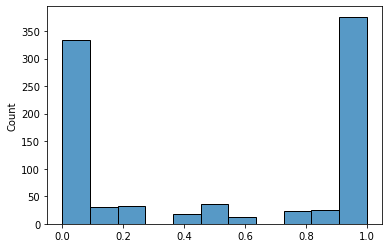

In [91]:
import seaborn as sns
sns.histplot(pos_ratio)

tensor(0.2129)


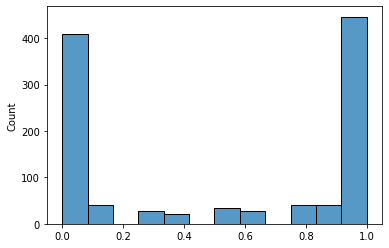

In [104]:
pos_ratio = []
for i in range(len(test_label)):
    pos_ratio.append(torch.tensor(test_label[i]).sum().item()/len(test_label[i]))
import seaborn as sns
sns.histplot(pos_ratio)
pos_ratio = torch.tensor(pos_ratio)
print((pos_ratio[pos_ratio<1]>0).sum()/len(pos_ratio))

In [109]:
# torch.save({"data": test_data, "logits": test_logits, "cls_indexes": test_cls_indexes, 
#             "embs": test_embs, "target_embs":test_target_embs, "col_num": test_col_num, "label": test_label, "class": test_class}, f"/data/zhihao/TU/Watchog/verification/{args.task}/GT_8_test_data.pth")
res = torch.load( f"/data/zhihao/TU/Watchog/verification/{args.task}/GT_4_test_data.pth")
test_label = res["label"]
test_col_num = res["col_num"]
col_correct_ratio = defaultdict(list)
for i in range(len(test_label)):
    col_num = torch.tensor(test_col_num[i]).reshape(-1)
    label = torch.tensor(test_label[i]).reshape(-1)
    for j in col_num.unique():
        col_correct_ratio[j.item()].append(label[col_num==j].sum().item()/len(label[col_num==j]))

In [110]:
for i in col_correct_ratio:
    print(i, torch.tensor(col_correct_ratio[i]).mean().item())

1 0.5336405634880066
2 0.5189114212989807
3 0.5196802616119385
4 0.5108054876327515


In [107]:
test_col_num[i] 

[3, 2, 2, 1]

In [108]:
test_label[i]

[tensor(1), tensor(1), tensor(1), tensor(1)]

tensor(0.3373)


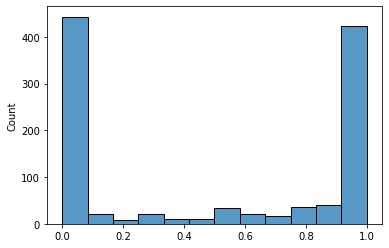

In [105]:
import os
os.makedirs("/data/zhihao/TU/Watchog/verification", exist_ok=True)
res = torch.load( f"/data/zhihao/TU/Watchog/verification/{args.task}/GT_8_test_data.pth")
test_label = res["label"]
pos_ratio = []
for i in range(len(test_label)):
    pos_ratio.append(torch.tensor(test_label[i]).sum().item()/len(test_label[i]))
import seaborn as sns
sns.histplot(pos_ratio)
pos_ratio = torch.tensor(pos_ratio)
print((pos_ratio[pos_ratio<1]>0).sum()/len(pos_ratio))

In [67]:
score_permutation[2]

[0.9994431138038635,
 0.995649516582489,
 0.9986926913261414,
 0.9993484616279602,
 0.5446780323982239,
 0.9180978536605835,
 0.9985690116882324]

In [68]:
permutation_correctness[2]

[False, False, False, False, False, False, False]

In [145]:
# 4
veri_labels_all = torch.cat([torch.tensor(veri_label[i]) for i in veri_label], dim=0)
print(len(veri_labels_all))
veri_labels_all.sum()/len(veri_labels_all)

5985


tensor(0.5163)

In [112]:
# 4 data_2
veri_labels_all = torch.cat([torch.tensor(veri_label[i]) for i in veri_label], dim=0)
print(len(veri_labels_all))
veri_labels_all.sum()/len(veri_labels_all)

6870


tensor(0.5194)

In [117]:
# 4 data_3 4+ 8neg
veri_labels_all = torch.cat([torch.tensor(veri_label[i]) for i in veri_label], dim=0)
print(len(veri_labels_all))
veri_labels_all.sum()/len(veri_labels_all)

61330


tensor(0.3576)

In [126]:
# 4 data_3 4+ 8neg
veri_labels_all = torch.cat([torch.tensor(veri_label[i]) for i in veri_label], dim=0)
print(len(veri_labels_all))
veri_labels_all.sum()/len(veri_labels_all)

61330


tensor(0.3576)

In [51]:
# 4 + 8neg
veri_labels_all = torch.cat([torch.tensor(veri_label[i]) for i in veri_label], dim=0)
print(len(veri_labels_all))
veri_labels_all.sum()/len(veri_labels_all)

60445


tensor(0.3550)

In [739]:
num_cols_valid = []
for i in range(len(valid_dataset_iter)):
    num_cols_valid.append(valid_dataset_iter[i]['initial_num_col'])
num_cols_valid = torch.tensor(num_cols_valid)

In [ ]:
(num_cols_valid>16).sum()/len(num_cols_valid)

In [ ]:
(num_cols_valid>12).sum()/len(num_cols_valid)

In [ ]:
(num_cols_valid>8).sum()/len(num_cols_valid)

In [ ]:
sns.histplot(num_cols_valid)

In [ ]:
sns.histplot(num_cols)

In [ ]:
# drop one column for column correlation
import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new

import torch.nn.functional as F
veri_data = defaultdict(list)
veri_logits = defaultdict(list)
veri_cls_indexes = defaultdict(list)
veri_target_col_mask = defaultdict(list)
veri_embs = defaultdict(list)
veri_col_num = defaultdict(list)
veri_label = defaultdict(list)
veri_class = defaultdict(list)
veri_target_embs = defaultdict(list)
    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
for threshold in [1.5]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0
    num_permutations = {}
    init_permutation = {}
    init_correctness = {}
    score_init = {}
    score_permutation = defaultdict(list)
    permutation_correctness = defaultdict(list)
    with torch.no_grad():
        for batch_idx, batch in enumerate(valid_dataloader_iter):
            cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
            target_col_mask = batch["target_col_mask"].T
            logits = model(batch["data"].T, cls_indexes=cls_indexes,)
            score_init[batch_idx] = F.softmax(logits.detach()).max().item()
            label_i = batch["label"].item()
            predict_init = logits.argmax().item()
            init_permutation_i = get_permutation(target_col_mask)
            init_permutation[batch_idx] = init_permutation_i
            if predict_init == label_i:
                init_correctness[batch_idx] = True
            else:
                init_correctness[batch_idx] = False
            num_permutations[batch_idx] = 0

            x = [0]
            new_batch_data = []
            for col_i in x:
                if col_i == 0:
                    if len(new_batch_data) == 0:
                        cls_indexes_value = 0
                    else:
                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
            logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
            veri_target_embs[batch_idx].append(embs_temp.cpu())

            num_cols.append(len(init_permutation_i))
            labels_test.append(batch["label"].cpu().item())
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(len(init_permutation_i), len(init_permutation_i)-2, -1): # not 
                for x in itertools.combinations(init_permutation_i, r):
                    if 0 not in x:
                        continue

                    num_permutations[batch_idx] += 1
                    new_batch_data = []
                    for col_i in x:
                        if col_i == 0:
                            if len(new_batch_data) == 0:
                                cls_indexes_value = 0
                            else:
                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                    logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
                    ood_score_temp = F.softmax(logits_temp.detach()).max().item()
                    score_permutation[batch_idx].append(ood_score_temp)
                    predict_temp = logits_temp.argmax().item()
                    permutation_correctness[batch_idx].append(predict_temp == label_i)
                    
                    veri_data[batch_idx].append(new_batch_data.cpu())
                    veri_logits[batch_idx].append(logits_temp.detach().cpu())
                    veri_cls_indexes[batch_idx].append(cls_indexes_value)
                    veri_embs[batch_idx].append(embs_temp.cpu())
                    veri_col_num[batch_idx].append(len(x))
                    if predict_init != label_i and predict_temp == label_i:
                        veri_label[batch_idx].append(torch.tensor(1).long())
                    elif predict_init == label_i and predict_temp != label_i:
                        veri_label[batch_idx].append(torch.tensor(0).long())
                    elif predict_init == label_i and predict_temp == label_i:
                        veri_label[batch_idx].append(torch.tensor(2).long())
                    else:
                        veri_label[batch_idx].append(torch.tensor(3).long())
                    veri_class[batch_idx].append(label_i)
            assert len(veri_label[batch_idx]) == len(init_permutation_i)

In [ ]:
for veri_i in veri_label:
    context_embs = veri_embs[veri_i][0].reshape(-1)
    for veri_j in range(1, len(veri_label[veri_i])):
        if label_version == 0:
            if veri_label[veri_i][veri_j] != 0 or veri_label[veri_i][veri_j-1] != 1:
                continue

In [ ]:

veri_labels_all = torch.cat([torch.tensor(veri_label[i]) for i in veri_label], dim=0)
print(len(veri_labels_all))
for i in range(4):
    print((veri_labels_all==i).sum(), (veri_labels_all==i).sum()/len(veri_labels_all))

In [ ]:

veri_labels_all = torch.cat([torch.tensor(veri_label[i])[1:] for i in veri_label], dim=0)
print(len(veri_labels_all))
for i in range(4):
    print((veri_labels_all==i).sum(), (veri_labels_all==i).sum()/len(veri_labels_all))

In [28]:
        self.pos_iter[anchor_idx] = iter(self.veri_pos_embs[anchor_idx])
        self.neg_iter[anchor_idx] = iter(self.veri_neg_embs[anchor_idx])
        # Shuffle for randomness
        random.shuffle(self.pos_embeddings[anchor_idx])
        random.shuffle(self.neg_embeddings[anchor_idx])

In [22]:
import os
os.makedirs("/data/zhihao/TU/Watchog/verification", exist_ok=True)
torch.save({"data": veri_data, "label": veri_label, "logits": veri_logits, "cls_indexes": veri_cls_indexes, "embs": veri_embs, "target_embs":veri_target_embs , "col_num": veri_col_num}, f"/data/zhihao/TU/Watchog/verification/{args.task}_veri_data.pth")

In [ ]:
res = torch.load(f"/data/zhihao/TU/Watchog/verification/SOTAB_veri_data.pth")
veri_label_sotab = res["label"]

In [118]:
veri_label_sotab_all = []
for i in veri_label_sotab:
    veri_label_sotab_all += veri_label_sotab[i]
veri_label_sotab_all = torch.tensor(veri_label_sotab_all).reshape(-1)

In [ ]:
len(veri_label_sotab_all)

In [ ]:
veri_label_sotab_all.sum()/len(veri_label_sotab_all)

In [ ]:
res = torch.load(f"/data/zhihao/TU/Watchog/verification/{args.task}_veri_data.pth")
veri_label_old = res["label"]

In [ ]:
res1 = torch.load(f"/data/zhihao/TU/Watchog/verification/{args.task}_veri_data_1.pth")
veri_label_1 = res1["label"]

In [83]:
veri_label_old_all = []
for i in veri_label_old:
    veri_label_old_all += veri_label_old[i]
veri_label_old_all = torch.tensor(veri_label_old_all).reshape(-1)

In [86]:
veri_label_1_all = []
for i in veri_label_1:
    veri_label_1_all += veri_label_1[i]
veri_label_1_all = torch.tensor(veri_label_1_all).reshape(-1)


In [ ]:
print(len(veri_label_old_all))
print(veri_label_old_all.sum()/len(veri_label_old_all))

In [ ]:
print(len(veri_label_1_all))
print(veri_label_1_all.sum()/len(veri_label_1_all))

In [42]:
def veri_collate_fn(pad_token_id, binary=False):
    '''padder for input batch'''
    
    def padder(samples):    
        batch = {}
        if "embs" in samples[0]:
            embs = torch.stack([sample["embs"] for sample in samples], dim=0)
            batch["embs"] = embs
        
        if "data" in samples[0]:
            data = []
            for sample in samples:
                data.extend(sample["data"])
            data =torch.nn.utils.rnn.pad_sequence(
                data, padding_value=pad_token_id)
            batch["data"] = data
        if "label" in samples[0]:
            label = torch.cat([sample["label"] for sample in samples], dim=-1)
            batch["label"] = label
        if "cls_indexes" in samples[0]:
            i = 0
            cls_indexes = []
            for sample in samples:
                for value in sample["cls_indexes"]:
                    cls_indexes.append(torch.tensor([i, value]))
                    i += 1
            cls_indexes = torch.stack(cls_indexes, dim=0).long()
            batch["cls_indexes"] = cls_indexes
        return batch
    
    def padder_binary(samples):   

        label = torch.cat([sample["label"] for sample in samples], dim=-1)
        batch = {"label": label}
        if  "data" in samples[0]:
            data = torch.nn.utils.rnn.pad_sequence(
                [sample["data"] for sample in samples], padding_value=pad_token_id)
            batch["data"] = data
        if "cls_indexes" in samples[0]:
            i = 0
            cls_indexes = []
            for sample in samples:
                value =  sample["cls_indexes"]
                cls_indexes.append(torch.tensor([i, value]))
                i += 1
            cls_indexes = torch.stack(cls_indexes, dim=0).long()
            batch["cls_indexes"] = cls_indexes
        if "embs" in samples[0]:
            embs = torch.stack([sample["embs"] for sample in samples], dim=0)
            batch["embs"] = embs
        if "logits" in samples[0]:
            logits = torch.stack([sample["logits"] for sample in samples], dim=0)
            batch["logits"] = logits
        return batch
    if binary:
        return padder_binary
    else:
        return padder

In [47]:
class VerificationCompareDataset(data.Dataset):
    def __init__(
            self,
            data_path: str = "/data/zhihao/TU/Watchog/verification/gt-semtab22-dbpedia-all0_veri_data.pth",
            pos_ratio = None, # clone the negative samples
            context = None,
            ): 
        
        self.num_neg = int((1-pos_ratio)/pos_ratio)
        self.context = context
        
        data_raw = torch.load(data_path)
        veri_label = data_raw["label"]
        veri_data = data_raw["data"]
        veri_cls_indexes = data_raw["cls_indexes"]
        veri_embs = data_raw["embs"]
        veri_target_embs = data_raw["target_embs"]
        veri_logits = data_raw["logits"]
        
        
        self.veri_pos_embs = defaultdict(list)
        self.veri_neg_embs = defaultdict(list)
        self.veri_anchor_embs = defaultdict(list)
        
        # self.veri_label = {}
        # self.veri_logits = {}
        # self.veri_cls_indexes = {}
        # self.veri_logits = {}
        i = 0
        for veri_i in veri_label:
            if 1 not in veri_label[veri_i] or 0 not in veri_label[veri_i]:
                continue
            # save anchor emb
            if context is None or context == "None" or context == "init":
                self.veri_anchor_embs[i].append(veri_embs[veri_i][0])
            elif context == "target":
                self.veri_anchor_embs[i].append(veri_target_embs[veri_i][0])        
            else:
                raise ValueError("context {} is not supported".format(context))
            # save pos and neg embs
            for veri_j in range(len(veri_label[veri_i])):
                if veri_label[veri_i][veri_j] == 1:
                    self.veri_pos_embs[i].append(veri_embs[veri_i][veri_j])
                else:
                    self.veri_neg_embs[i].append(veri_embs[veri_i][veri_j])
            i += 1

        # Maintain the iteration state for each anchor
        self.pos_iter = {anchor_idx: iter(pos_embs) for anchor_idx, pos_embs in self.veri_pos_embs.items()}
        self.neg_iter = {anchor_idx: iter(neg_embs) for anchor_idx, neg_embs in self.veri_neg_embs.items()}


    def __len__(self):
        return len(self.veri_anchor_embs)

    def reset_iterators(self, anchor_idx, type="pos"):
        """Reset the iterator for the given anchor when all positives or negatives are iterated through."""
        if type == "pos":
            self.pos_iter[anchor_idx] = iter(self.veri_pos_embs[anchor_idx])
            random.shuffle(self.veri_pos_embs[anchor_idx])
        else:
            self.neg_iter[anchor_idx] = iter(self.veri_neg_embs[anchor_idx])
            random.shuffle(self.veri_neg_embs[anchor_idx])


    def __getitem__(self, idx):
        
        anchor_emb = self.veri_anchor_embs[idx]

        # Get one positive embedding
        try:
            pos_emb = next(self.pos_iter[idx])
        except StopIteration:
            # If we've exhausted all positives, reset and shuffle
            self.reset_iterators(idx, type="pos")
            pos_emb = next(self.pos_iter[idx])

        # Get N negative embeddings
        neg_embs = []
        for _ in range(self.num_neg):
            try:
                neg_emb = next(self.neg_iter[idx])
                neg_embs.append(neg_emb)
            except StopIteration:
                # If we've exhausted all negatives, reset and shuffle
                self.reset_iterators(idx, type="neg")
                neg_emb = next(self.neg_iter[idx])
                neg_embs.append(neg_emb)
        if self.context is None or self.context == "None":
            embs = [pos_emb] + neg_embs
        else:
            embs = [anchor_emb, pos_emb] + neg_embs
        embs = torch.stack(embs, dim=0)
        
        
        
        return {
            # "data": self.veri_data[idx].reshape(-1),
            "embs": embs,
            # "label": self.veri_label[idx],
            # "logits": self.veri_logits[idx],
            # "cls_indexes": self.veri_cls_indexes[idx], 
        }

In [ ]:
dataset_comp = VerificationCompareDataset(pos_ratio=0.5)

In [58]:
veri_comp_padder = veri_collate_fn(0)
veri_comp_dataloader = data.DataLoader(
    dataset_comp, batch_size=5, shuffle=True, num_workers=4, collate_fn=veri_comp_padder
)
num = 0
for batch_idx, batch in enumerate(veri_comp_dataloader):
    break

In [ ]:
batch["embs"].shape

In [73]:
attention = nn.MultiheadAttention(embed_dim=128, num_heads=2, batch_first=True)

In [74]:
embs = torch.randn(32, 2, 128)

In [75]:
q = torch.randn(32, 1, 128)

In [76]:
res = attention(q, embs, embs)

In [ ]:
res[0].shape

In [64]:
scores = ffn(batch["embs"])
pos_scores, neg_scores = scores[:, 0], scores[:, 1]

In [67]:
margin = 0.1
loss = torch.clamp(pos_scores - neg_scores + margin, min=0.0)

In [ ]:
\

In [ ]:
dataset_comp[0]

In [ ]:
import seaborn as sns
labels_test = []
for batch in veri_class:
    labels_test.append(batch[0])
sns.histplot(labels_test)

In [102]:
_, test_counts = np.unique(labels_test, return_counts=True)

In [ ]:
test_counts

In [104]:
_, veri_counts = np.unique(labels_all, return_counts=True)

In [ ]:
print(max(test_counts)/min(test_counts), )
veri_counts

In [ ]:
import seaborn as sns
labels_all = []
for batch in veri_class:
    for label in veri_class[batch]:
        labels_all.append(label)
sns.histplot(labels_all)

In [ ]:
import seaborn as sns
sns.histplot(labels_test)

In [ ]:
len(labels_all)

In [ ]:
embs_temp.shape

In [ ]:
 torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).shape

In [ ]:
new_batch_data.shape

In [ ]:
cls_indexes.shape

In [ ]:
batch["data"].T.shape

In [139]:
for i in veri_data:
    assert len(veri_data[i]) == len(veri_label[i]) == len(veri_cls_indexes[i])

In [ ]:
test_drop_idx

In [47]:
# brute force perumate in validation TODO: restrict mamimus length of permutation
src = None
test_dataset_lb = GittablesTablewiseIterateLabelDataset(cv=cv,
                            split="test", src=src,
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only='all' not in task,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag="semi1",
                            max_unlabeled=4)
padder = collate_fn(tokenizer.pad_token_id)
test_dataloader_lb = DataLoader(test_dataset_lb,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)



import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new

import torch.nn.functional as F
test_data = defaultdict(list)
test_logits = defaultdict(list)
test_cls_indexes = defaultdict(list)
test_target_col_mask = defaultdict(list)
test_embs = defaultdict(list)
test_col_num = defaultdict(list)
test_label = defaultdict(list)
test_class = defaultdict(list)
test_target_embs = defaultdict(list)
test_drop_idx = defaultdict(list)
    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
for threshold in [1.5]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0
    num_permutations = {}
    init_permutation = {}
    init_correctness = {}
    score_init = {}
    score_permutation = defaultdict(list)
    permutation_correctness = defaultdict(list)
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_dataloader_lb):
            cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
            target_col_mask = batch["target_col_mask"].T
            logits = model(batch["data"].T, cls_indexes=cls_indexes,)
            score_init[batch_idx] = F.softmax(logits.detach()).max().item()
            label_i = batch["label"].item()
            predict_init = logits.argmax().item()
            init_permutation_i = get_permutation(target_col_mask)
            init_permutation[batch_idx] = init_permutation_i
            if predict_init == label_i:
                init_correctness[batch_idx] = True
            else:
                init_correctness[batch_idx] = False
            num_permutations[batch_idx] = 0


            x = [0]
            new_batch_data = []
            for col_i in x:
                if col_i == 0:
                    if len(new_batch_data) == 0:
                        cls_indexes_value = 0
                    else:
                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
            logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
            test_target_embs[batch_idx].append(embs_temp.cpu())


            num_cols.append(len(init_permutation_i))
            labels_test.append(batch["label"].cpu())
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(len(init_permutation_i), 0, -1): # not 
                for x in itertools.combinations(init_permutation_i, r):
                    if 0 not in x:
                        continue

                    num_permutations[batch_idx] += 1
                    new_batch_data = []
                    if len(x) != len(init_permutation_i):
                        drop_idx = (set(init_permutation_i)-set(x)).pop()
                    else:
                        drop_idx = -1
                    for col_i in x:
                        if col_i == 0:
                            if len(new_batch_data) == 0:
                                cls_indexes_value = 0
                            else:
                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                    logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
                    ood_score_temp = F.softmax(logits_temp.detach()).max().item()
                    score_permutation[batch_idx].append(ood_score_temp)
                    predict_temp = logits_temp.argmax().item()
                    permutation_correctness[batch_idx].append(predict_temp == label_i)
                    
                    test_data[batch_idx].append(new_batch_data.cpu())
                    test_logits[batch_idx].append(logits_temp.detach().cpu())
                    test_cls_indexes[batch_idx].append(cls_indexes_value)
                    test_embs[batch_idx].append(embs_temp.cpu())
                    test_col_num[batch_idx].append(len(x))
                    test_label[batch_idx].append(torch.tensor(predict_temp == label_i).long()) # indicate whether the permutation is correct or not
                    test_class[batch_idx].append(label_i)
                    test_drop_idx[batch_idx].append(drop_idx)

test
test 1085
*********************Threshold: 1.5****************************


In [49]:
import os
os.makedirs("/data/zhihao/TU/Watchog/verification", exist_ok=True)
torch.save({"data": test_data, "logits": test_logits, "cls_indexes": test_cls_indexes, 
            "embs": test_embs, "target_embs":test_target_embs, "col_num": test_col_num, "label": test_label, "class": test_class}, f"/data/zhihao/TU/Watchog/verification/{args.task}/GT_4_test_data.pth")

In [48]:
labels_test = []
logits_test = []
col_scores = defaultdict(list)
verifier = Verifier(norm="batch_norm").to(device)
with torch.no_grad():
    for batch_idx, batch in enumerate(test_dataloader_lb):
        embs = test_embs[batch_idx][0].reshape(-1).to(device)
        logits = test_logits[batch_idx][0].reshape(-1).to(device)
        # ft_embs_test.append(embs.detach().cpu().reshape(1, -1))
        logits_test.append(logits.detach().cpu())
        labels_test.append(batch["label"].cpu())
    labels_test = torch.cat(labels_test, dim=0)
    logits_test = torch.stack(logits_test, dim=0)
    preds_test = torch.argmax(logits_test, dim=1)
    num_cols = torch.tensor(num_cols)
    # ft_embs_test = torch.cat(ft_embs_test, dim=0)
    from sklearn.metrics import confusion_matrix, f1_score
    mask = num_cols > 0
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach().numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    full_f1_init = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average=None)
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

ts_micro_f1=0.5171, ts_macro_f1=0.2538


In [123]:
# EU distance to all labeled training columns
for max_unlabeled in [2,4, 8]:
    print("max_unlabeled={}".format(max_unlabeled))
    src = None
    test_dataset_lb = GittablesTablewiseIterateLabelDataset(cv=cv,
                                split="test", src=src,
                                tokenizer=tokenizer,
                                max_length=max_length,
                                gt_only='all' not in task,
                                device=device,
                                base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                                small_tag="semi1",
                                max_unlabeled=max_unlabeled,)
    padder = collate_fn(tokenizer.pad_token_id)
    test_dataloader_lb = DataLoader(test_dataset_lb,
                                    batch_size=1,
                                #   collate_fn=collate_fn)
                                collate_fn=padder)
    model.eval()
    model = model.to(device)
    ft_embs_test = []
    labels_test_original = []
    logits_test = []
    num_cols = []
    for batch_idx, batch in enumerate(test_dataloader_lb):
        cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
        # target_col_mask = batch["target_col_mask"].T
        logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
        labels_test_original.append(batch["label"].cpu())
        logits_test.append(logits.detach().cpu())
        num_cols.append(test_dataset_iter[batch_idx]['initial_num_col'])
        ft_embs_test.append(embs.detach().cpu().reshape(1, -1))
    labels_test_original = torch.cat(labels_test_original, dim=0)
    logits_test = torch.stack(logits_test, dim=0)
    preds_test = torch.argmax(logits_test, dim=1)
    num_cols = torch.tensor(num_cols)
    ft_embs_test = torch.cat(ft_embs_test, dim=0)
    from sklearn.metrics import confusion_matrix, f1_score
    mask = num_cols > 0
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach().numpy().tolist()
    ts_micro_f1 = f1_score(labels_test_original.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test_original.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    full_f1_init = f1_score(labels_test_original.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average=None)
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

max_unlabeled=2
test
test 1085
ts_micro_f1=0.5346, ts_macro_f1=0.2734
max_unlabeled=4
test
test 1085
ts_micro_f1=0.5171, ts_macro_f1=0.2538
max_unlabeled=8
test
test 1085
ts_micro_f1=0.4922, ts_macro_f1=0.2192


In [37]:
# EU distance to all labeled training columns
for max_unlabeled in [2,4, 8]:
    print("max_unlabeled={}".format(max_unlabeled))
    src = None
    test_dataset_lb = GittablesTablewiseIterateLabelDataset(cv=cv,
                                split="test", src=src,
                                tokenizer=tokenizer,
                                max_length=max_length,
                                gt_only='all' not in task,
                                device=device,
                                base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                                small_tag="semi1",
                                max_unlabeled=max_unlabeled,
                                adaptive_max_length=False)
    padder = collate_fn(tokenizer.pad_token_id)
    test_dataloader_lb = DataLoader(test_dataset_lb,
                                    batch_size=1,
                                #   collate_fn=collate_fn)
                                collate_fn=padder)
    model.eval()
    model = model.to(device)
    ft_embs_test = []
    labels_test_original = []
    logits_test = []
    num_cols = []
    for batch_idx, batch in enumerate(test_dataloader_lb):
        cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
        # target_col_mask = batch["target_col_mask"].T
        logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
        labels_test_original.append(batch["label"].cpu())
        logits_test.append(logits.detach().cpu())
        num_cols.append(test_dataset_iter[batch_idx]['initial_num_col'])
        ft_embs_test.append(embs.detach().cpu().reshape(1, -1))
    labels_test_original = torch.cat(labels_test_original, dim=0)
    logits_test = torch.stack(logits_test, dim=0)
    preds_test = torch.argmax(logits_test, dim=1)
    num_cols = torch.tensor(num_cols)
    ft_embs_test = torch.cat(ft_embs_test, dim=0)
    from sklearn.metrics import confusion_matrix, f1_score
    mask = num_cols > 0
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach().numpy().tolist()
    ts_micro_f1 = f1_score(labels_test_original.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test_original.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    full_f1_init = f1_score(labels_test_original.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average=None)
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

max_unlabeled=2
test
test 1085
ts_micro_f1=0.5346, ts_macro_f1=0.2734
max_unlabeled=4
test
test 1085
ts_micro_f1=0.5171, ts_macro_f1=0.2538
max_unlabeled=8
test
test 1085
ts_micro_f1=0.4866, ts_macro_f1=0.2146


In [120]:
# other columns sort by col_idx
for max_unlabeled in [2,4, 8]:
    print("max_unlabeled={}".format(max_unlabeled))
    src = None
    test_dataset_lb = GittablesTablewiseIterateLabelDataset(cv=cv,
                                split="test", src=src,
                                tokenizer=tokenizer,
                                max_length=max_length,
                                gt_only='all' not in task,
                                device=device,
                                base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                                small_tag="semi1",
                                max_unlabeled=max_unlabeled,
                                adaptive_max_length=False)
    padder = collate_fn(tokenizer.pad_token_id)
    test_dataloader_lb = DataLoader(test_dataset_lb,
                                    batch_size=1,
                                #   collate_fn=collate_fn)
                                collate_fn=padder)
    model.eval()
    model = model.to(device)
    ft_embs_test = []
    labels_test_original = []
    logits_test = []
    num_cols = []
    for batch_idx, batch in enumerate(test_dataloader_lb):
        cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
        # target_col_mask = batch["target_col_mask"].T
        logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
        labels_test_original.append(batch["label"].cpu())
        logits_test.append(logits.detach().cpu())
        num_cols.append(test_dataset_iter[batch_idx]['initial_num_col'])
        ft_embs_test.append(embs.detach().cpu().reshape(1, -1))
    labels_test_original = torch.cat(labels_test_original, dim=0)
    logits_test = torch.stack(logits_test, dim=0)
    preds_test = torch.argmax(logits_test, dim=1)
    num_cols = torch.tensor(num_cols)
    ft_embs_test = torch.cat(ft_embs_test, dim=0)
    from sklearn.metrics import confusion_matrix, f1_score
    mask = num_cols > 0
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach().numpy().tolist()
    ts_micro_f1 = f1_score(labels_test_original.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test_original.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    full_f1_init = f1_score(labels_test_original.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average=None)
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

max_unlabeled=2
test
test 1085
ts_micro_f1=0.5346, ts_macro_f1=0.2734
max_unlabeled=4
test
test 1085
ts_micro_f1=0.5060, ts_macro_f1=0.2479
max_unlabeled=8
test
test 1085
ts_micro_f1=0.4747, ts_macro_f1=0.2173


In [23]:
        for batch_idx, batch in enumerate(test_dataloader_lb):
            cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
            target_col_mask = batch["target_col_mask"].T
            logits = model(batch["data"].T, cls_indexes=cls_indexes,)
            score_init[batch_idx] = F.softmax(logits.detach()).max().item()
            label_i = batch["label"].item()
            predict_init = logits.argmax().item()
            init_permutation_i = get_permutation(target_col_mask)
            init_permutation[batch_idx] = init_permutation_i
            if len(init_permutation[batch_idx]) > 3:
                break

In [38]:
# brute force perumate in validation TODO: restrict mamimus length of permutation
import warnings
warnings.filterwarnings("ignore")
src = None
test_dataset_lb = GittablesTablewiseIterateLabelDataset(cv=cv,
                            split="test", src=src,
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only='all' not in task,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag="semi1",
                            max_unlabeled=2)
padder = collate_fn(tokenizer.pad_token_id)
test_dataloader_lb = DataLoader(test_dataset_lb,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new

import torch.nn.functional as F
test_data = defaultdict(list)
test_logits = defaultdict(list)
test_cls_indexes = defaultdict(list)
test_target_col_mask = defaultdict(list)
test_embs = defaultdict(list)
test_col_num = defaultdict(list)
test_label = defaultdict(list)
test_class = defaultdict(list)
test_target_embs = defaultdict(list)
test_drop_idx = defaultdict(list)
    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
for threshold in [1.5]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0
    num_permutations = {}
    init_permutation = {}
    init_correctness = {}
    score_init = {}
    score_permutation = defaultdict(list)
    permutation_correctness = defaultdict(list)
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_dataloader_lb):
            cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
            target_col_mask = batch["target_col_mask"].T
            logits = model(batch["data"].T, cls_indexes=cls_indexes,)
            score_init[batch_idx] = F.softmax(logits.detach()).max().item()
            label_i = batch["label"].item()
            predict_init = logits.argmax().item()
            init_permutation_i = get_permutation(target_col_mask)
            init_permutation[batch_idx] = init_permutation_i
            if predict_init == label_i:
                init_correctness[batch_idx] = True
            else:
                init_correctness[batch_idx] = False
            num_permutations[batch_idx] = 0



            num_cols.append(len(init_permutation_i))
            labels_test.append(batch["label"].cpu())
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            found = False
            for r in range(len(init_permutation_i), 0, -1): # not 
                for x in itertools.combinations(init_permutation_i, r):
                    if 0 not in x:
                        continue

                    num_permutations[batch_idx] += 1
                    new_batch_data = []
                    if len(x) != len(init_permutation_i):
                        drop_idx = (set(init_permutation_i)-set(x)).pop()
                    else:
                        drop_idx = -1
                    for col_i in x:
                        if col_i == 0:
                            if len(new_batch_data) == 0:
                                cls_indexes_value = 0
                            else:
                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                    logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
                    ood_score_temp = F.softmax(logits_temp.detach()).max().item()
                    score_permutation[batch_idx].append(ood_score_temp)
                    predict_temp = logits_temp.argmax().item()
                    permutation_correctness[batch_idx].append(predict_temp == label_i)
                    
                    if predict_temp == label_i:
                        found = True
                        break
                if found:
                    break
            logits_test.append(logits_temp.detach().cpu())
    labels_test = torch.cat(labels_test, dim=0)
    logits_test = torch.stack(logits_test, dim=0)
    preds_test = torch.argmax(logits_test, dim=1)
    num_cols = torch.tensor(num_cols)
    from sklearn.metrics import confusion_matrix, f1_score
    mask = num_cols > 0
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach().numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

test
test 1085
*********************Threshold: 1.5****************************
ts_micro_f1=0.5788, ts_macro_f1=0.2968


In [122]:
# 2
# ts_micro_f1=0.5788, ts_macro_f1=0.2968
# 4
# *********************Threshold: 1.5****************************
# ts_micro_f1=0.6240, ts_macro_f1=0.3520

# 8
# *********************Threshold: 1.5****************************
# ts_micro_f1=0.6571, ts_macro_f1=0.3995


ts_micro_f1=0.4922, ts_macro_f1=0.2192


In [21]:
import os
os.makedirs("/data/zhihao/TU/Watchog/verification", exist_ok=True)
torch.save({"data": test_data, "logits": test_logits, "cls_indexes": test_cls_indexes, 
            "embs": test_embs, "target_embs":test_target_embs, "col_num": test_col_num, "label": test_label, "class": test_class}, f"/data/zhihao/TU/Watchog/verification/{args.task}/GT_8_test_data.pth")

In [ ]:
test_veri = torch.load(f"/data/zhihao/TU/Watchog/verification/{args.task}_test_data.pth")
test_data = test_veri["data"]
test_logits = test_veri["logits"]
test_cls_indexes = test_veri["cls_indexes"]
test_embs = test_veri["embs"]
test_col_num = test_veri["col_num"]

In [143]:
labels_test = []
logits_test = []

with torch.no_grad():
    for batch_idx, batch in enumerate(test_embs):
        embs = test_embs[batch_idx][0].reshape(-1).to(device)
        logits = test_logits[batch_idx][0].reshape(-1).to(device)


        labels_test.append(torch.tensor(test_class[batch_idx][0]).reshape([-1,1]))
        logits_test.append(logits.detach().cpu())
    labels_test = torch.cat(labels_test, dim=0)
    logits_test = torch.stack(logits_test, dim=0)
    preds_test = torch.argmax(logits_test, dim=1)




from sklearn.metrics import confusion_matrix, f1_score
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

ts_micro_f1=0.5171, ts_macro_f1=0.2538


In [ ]:
test_col_num[5]

In [237]:
labels_test = []
logits_test = []
col_scores = defaultdict(list)
verifier = Verifier(norm="batch_norm").to(device)
with torch.no_grad():
    for batch_idx, batch in enumerate(test_dataloader_iter):
        embs = test_embs[batch_idx][0].reshape(-1).to(device)
        logits = test_logits[batch_idx][0].reshape(-1).to(device)
        # scores_init = verifier(embs)
        max_score = -float("inf")
        target_col_mask = batch["target_col_mask"].T
        init_permutation_i = get_permutation(target_col_mask)
        num_cols_to_drop = min(2, len(init_permutation_i)//2)
        if len(init_permutation_i) ==1:
            labels_test.append(batch["label"].cpu())
            logits_test.append(logits.detach().cpu())
            continue
        
        for i in range(1, len(test_embs[batch_idx])):
            logits_temp = test_logits[batch_idx][i].reshape(-1).to(device)
            embs_temp = test_embs[batch_idx][i].reshape(-1).to(device)

            scores_temp = np.random.rand()
            predict_temp = logits_temp.argmax().item()
            col_scores[batch_idx].append(scores_temp)
            
            
        cols_to_drop = torch.tensor(col_scores[batch_idx]).argsort()[:num_cols_to_drop]
        x = deepcopy(init_permutation_i)
        for col_i in cols_to_drop:
            x.remove(col_i)
        new_batch_data = []
        if len(x) != len(init_permutation_i):
            drop_idx = (set(init_permutation_i)-set(x)).pop()
        else:
            drop_idx = -1
        for col_i in x:
            if col_i == 0:
                if len(new_batch_data) == 0:
                    cls_indexes_value = 0
                else:
                    cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
            new_batch_data.append(batch["data"].T[target_col_mask==col_i])
        new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
        cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
        logits_topk, embs_topk = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
        if len(init_permutation_i) > 4: 
            break

ts_micro_f1=0.4922, ts_macro_f1=0.2192


In [ ]:
num_cols_to_drop

In [ ]:
init_permutation_i = torch.tensor(init_permutation_i)
init_permutation_i[init_permutation_i!=0][:num_cols_to_drop]

In [ ]:
torch.tensor(col_scores[batch_idx]).argsort(descending=True)[: ]

In [ ]:
len(col_scores[batch_idx])

In [ ]:
len(init_permutation_i)

In [197]:
drop_idx = (set(init_permutation_i)-set(x)).pop()

In [ ]:
drop_idx

In [ ]:
len()

In [ ]:
len(test_embs)

In [115]:
import os
os.makedirs("/data/zhihao/TU/Watchog/verification", exist_ok=True)
torch.save({"data": test_data, "logits": test_logits, "cls_indexes": test_cls_indexes, 
            "embs": test_embs, "target_embs":test_target_embs, "col_num": test_col_num, "label": test_label, "class": test_class}, f"/data/zhihao/TU/Watchog/verification/{args.task}_test_data_2.pth")

In [ ]:
for i, r in enumerate(test_dataloader_iter):
    try:
        res = test_embs[i][0]
    except:
        print(i)
    

In [ ]:
res = torch.load

In [ ]:
args.task

In [ ]:
all_labels = []
for i in veri_label:
    all_labels.extend(veri_label[i])
all_labels = torch.tensor(all_labels).reshape(-1)
all_labels.sum()/len(all_labels)

In [ ]:
veri_label

In [64]:
class VerificationDataset(data.Dataset):
    def __init__(
            self,
            data_path: str = "/data/zhihao/TU/Watchog/verification/veri_data.pth",
            max_list_length: int = 10,
            pos_ratio : int = 0.5, # None: only control pos_ratio to be less than 0.5
            label_padding_value: int = -1,
            data_padding_value: int = 0,
            ): 
        data_raw = torch.load(data_path)
        veri_label = data_raw["label"]
        veri_data = data_raw["data"]
        veri_cls_indexes = data_raw["cls_indexes"]
        self.label_padding_value = label_padding_value
        self.data_padding_value = data_padding_value
        self.max_list_length = max_list_length
        self.pos_ratio = pos_ratio
        self.veri_label = {}
        self.veri_data = {}
        self.veri_cls_indexes = {}
        i = 0
        for veri_i in veri_label:
            labels_i = torch.tensor(veri_label[veri_i]).reshape(-1)
            
            if 0 not in labels_i or 1 not in labels_i:
                continue
            self.veri_data[i] = veri_data[veri_i]
            self.veri_label[i] = labels_i
            self.veri_cls_indexes[i] = veri_cls_indexes[veri_i]
            i += 1
    def sample(self, labels):
        labels = labels.tolist()  # Convert tensor to list for easier manipulation
        positive_indices = [i for i, label in enumerate(labels) if label == 1]
        negative_indices = [i for i, label in enumerate(labels) if label == 0]

        # Determine how many positives we can sample, respecting the ratio requirement
        max_num_positives = max_num_negatives = min(len(positive_indices), len(negative_indices), self.max_list_length // 2)
        
        # Randomly sample the positives and negatives
        sampled_positives = random.sample(positive_indices, max_num_positives)
        sampled_negatives = random.sample(negative_indices, max_num_negatives)

        # Combine and shuffle the indices
        sampled_indices = sampled_positives + sampled_negatives

        return sampled_indices
        # {"data": veri_data, "label": veri_label, "cls_indexes": veri_cls_indexes}
    def __len__(self):
        return len(self.veri_data)

    def __getitem__(self, idx):
        labels = self.veri_label[idx]
        sampled_indices = self.sample(labels)
        sampled_labels = torch.tensor([labels[i] for i in sampled_indices]).reshape(-1)
        sampled_data = [self.veri_data[idx][i].reshape(-1) for i in sampled_indices]
        sampled_cls_indexes = torch.tensor([self.veri_cls_indexes[idx][i] for i in sampled_indices], dtype=torch.long)
        if len(sampled_indices) < self.max_list_length:
            sampled_labels = torch.cat([sampled_labels, torch.ones(self.max_list_length - len(sampled_labels))*self.label_padding_value])
            sampled_data.extend([torch.tensor([self.data_padding_value]) for _ in range(self.max_list_length - len(sampled_data))])
            sampled_cls_indexes = torch.cat([sampled_cls_indexes, torch.zeros(self.max_list_length - len(sampled_cls_indexes))])
        return {
            "data": sampled_data,
            "label": sampled_labels,
            "cls_indexes": sampled_cls_indexes, 
        }

In [64]:
class VerificationBinaryDataset(data.Dataset):
    def __init__(
            self,
            data_path: str = "/data/zhihao/TU/Watchog/verification/veri_data.pth",
            pos_ratio = None, # clone the negative samples
            ): 
        data_raw = torch.load(data_path)
        veri_label = data_raw["label"]
        veri_data = data_raw["data"]
        veri_cls_indexes = data_raw["cls_indexes"]
        veri_embs = data_raw["embs"]
        veri_logits = data_raw["logits"]
        self.neg_expand = int(1/pos_ratio)-1 if pos_ratio is not None else 1
        self.veri_label = {}
        self.veri_data = {}
        self.veri_embs = {}
        self.veri_cls_indexes = {}
        self.veri_logits = {}
        i = 0
        for veri_i in veri_label:
            for veri_j in range(len(veri_label[veri_i])):
                if veri_label[veri_i][veri_j] == 1:
                    labels_i = torch.tensor([1]).reshape(-1)
                    self.veri_data[i] = veri_data[veri_i][veri_j]
                    self.veri_label[i] = labels_i
                    self.veri_cls_indexes[i] = veri_cls_indexes[veri_i][veri_j]
                    self.veri_embs[i] = veri_embs[veri_i][veri_j]
                    self.veri_logits[i] = veri_logits[veri_i][veri_j]
                    i += 1
                else:
                    for _ in range(self.neg_expand):
                        labels_i = torch.tensor([0]).reshape(-1)
                        self.veri_data[i] = veri_data[veri_i][veri_j]
                        self.veri_label[i] = labels_i
                        self.veri_cls_indexes[i] = veri_cls_indexes[veri_i][veri_j]
                        self.veri_embs[i] = veri_embs[veri_i][veri_j]
                        self.veri_logits[i] = veri_logits[veri_i][veri_j]
                        i += 1

    def __len__(self):
        return len(self.veri_data)

    def __getitem__(self, idx):
        return {
            # "data": self.veri_data[idx].reshape(-1),
            "embs": self.veri_embs[idx].reshape(-1),
            "label": self.veri_label[idx],
            "logits": self.veri_logits[idx],
            # "cls_indexes": self.veri_cls_indexes[idx], 
        }

In [ ]:
print(len(veri_dataset), len(veri_dataset.veri_data), len(veri_dataset.veri_label), len(veri_dataset.veri_cls_indexes))

In [ ]:
verit_binary_dataset = VerificationBinaryDataset()

In [ ]:
len(verit_binary_dataset)

In [11]:
data = torch.nn.utils.rnn.pad_sequence(
            [verit_binary_dataset[i]["data"] for i in range(10)], padding_value=0)

In [ ]:
verit_binary_dataset[0]["embs"].shape

In [53]:
verit_labels = []
for i in range(len(verit_binary_dataset)):
    verit_labels.append(verit_binary_dataset[i]["label"].item())

In [ ]:
torch.tensor(verit_labels).sum()/len(verit_labels)

In [ ]:
len(veri_dataset)

In [ ]:
veri_dataset = VerificationDataset()

In [ ]:
len(veri_dataset)

In [21]:
res = veri_dataset[0]

In [ ]:
len(res["data"])

In [ ]:
res["data"][0].shape

In [ ]:
res["label"].shape

In [35]:
data_test = []
for i in range(len(veri_dataset)):
    data_test.extend(veri_dataset[i]["data"])

In [ ]:
len(data_test)

In [69]:
def veri_collate_fn(pad_token_id, binary=False):
    '''padder for input batch'''
    
    def padder(samples):    
        data = []
        for sample in samples:
            data.extend(sample["data"])
        data =torch.nn.utils.rnn.pad_sequence(
            data, padding_value=pad_token_id)

        label = torch.cat([sample["label"] for sample in samples], dim=-1)
        batch = {"data": data, "label": label}
        if "cls_indexes" in samples[0]:
            i = 0
            cls_indexes = []
            for sample in samples:
                for value in sample["cls_indexes"]:
                    cls_indexes.append(torch.tensor([i, value]))
                    i += 1
            cls_indexes = torch.stack(cls_indexes, dim=0).long()
            batch["cls_indexes"] = cls_indexes
        return batch
    
    def padder_binary(samples):   

        label = torch.cat([sample["label"] for sample in samples], dim=-1)
        batch = {"label": label}
        if  "data" in samples[0]:
            data = torch.nn.utils.rnn.pad_sequence(
                [sample["data"] for sample in samples], padding_value=pad_token_id)
            batch["data"] = data
        if "cls_indexes" in samples[0]:
            i = 0
            cls_indexes = []
            for sample in samples:
                value =  sample["cls_indexes"]
                cls_indexes.append(torch.tensor([i, value]))
                i += 1
            cls_indexes = torch.stack(cls_indexes, dim=0).long()
            batch["cls_indexes"] = cls_indexes
        if "embs" in samples[0]:
            embs = torch.stack([sample["embs"] for sample in samples], dim=0)
            batch["embs"] = embs
        if "logits" in samples[0]:
            logits = torch.stack([sample["logits"] for sample in samples], dim=0)
            batch["logits"] = logits
        return batch
    if binary:
        return padder_binary
    else:
        return padder

In [ ]:
veri_padder = veri_collate_fn(0)
veri_dataloader = data.DataLoader(
    veri_dataset, batch_size=args.batch_size, shuffle=True, num_workers=4, collate_fn=veri_padder
)
for batch in veri_dataloader:
    break

In [70]:
veri_binary_padder = veri_collate_fn(0, binary=True)
veri_binary_dataloader = data.DataLoader(
    verit_binary_dataset, batch_size=args.batch_size, shuffle=True, num_workers=4, collate_fn=veri_binary_padder
)
for batch_idx, batch in enumerate(veri_binary_dataloader):
    break

In [ ]:
batch["embs"].shape

In [ ]:
batch["logits"].shape

In [ ]:
scores.shape

In [ ]:
batch["label"].to(device).squeeze().shape

In [38]:
model.eval()
model = model.to(device)
verifier.train()
verifier = verifier.to(device)
pos_ratio = 0.1
pos_weight = torch.tensor([(1-pos_ratio)/pos_ratio]).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

for batch_idx, batch in enumerate(veri_binary_dataloader ):
    cls_indexes = batch["cls_indexes"].to(device)
    input_data = batch["data"].T.to(device)
    logits, embs = model(input_data, cls_indexes=cls_indexes, get_enc=True)
    scores = verifier(embs).squeeze()
    loss = loss_fn(scores, batch["label"].to(device).squeeze().float())
    break

In [ ]:
 batch["label"].to(device).shape

In [ ]:
scores.shape

In [ ]:
batch["data"].shape

In [ ]:
for 

In [ ]:
args.batch_size

In [ ]:
batch["data"].shape

In [ ]:
batch["label"].shape

In [ ]:
batch["cls_indexes"].shape

In [140]:
verifier = Verifier(norm="batch_norm", num_layers=None).to(device)

In [141]:
# veri_state_dict = torch.load("/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all0/bert-base-uncased-fromscratch-semi1-mode@ffn-context@None-data@5-lr@5e-05-warmup@0.0-dp@0.0-norm@batch_norm-pos@0.1-poolv0-unlabeled8-randFalse-bs64-ml128-ne200-do0.0_verifier_binary_best_f1_macro.pt")
# veri_state_dict = torch.load("/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all0/bert-base-uncased-fromscratch-semi1-mode@ffn-context@None-data@5-lr@5e-05-warmup@0.0-dp@0.0-norm@batch_norm-pos@0.2-poolv0-unlabeled8-randFalse-bs64-ml128-ne200-do0.0_verifier_binary_best_f1_micro.pt")
# veri_state_dict = torch.load("/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all0/bert-base-uncased-fromscratch-semi1-mode@ffn-context@None-data@5-lr@5e-05-warmup@0.0-dp@0.0-norm@batch_norm-pos@0.1-poolv0-unlabeled8-randFalse-bs64-ml128-ne200-do0.0_verifier_binary_best_f1_micro.pt")
veri_state_dict = torch.load("/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all0/bert-base-uncased-fromscratch-semi1-mode@ffn-context@None-data@5-lr@5e-05-warmup@0.0-dp@0.0-norm@batch_norm-pos@0.2-poolv0-unlabeled8-randFalse-bs64-ml128-ne200-do0.0_verifier_binary_best_f1_micro.pt")

In [142]:
verifier.load_state_dict(veri_state_dict)

<All keys matched successfully>

In [ ]:
verifier.eval()

In [ ]:
optimizer = AdamW(verifier.parameters(), lr=args.lr, eps=1e-8)

In [16]:
model.eval()
model.to(device)
verifier.train()
tr_loss = 0.0
for batch_idx, batch in enumerate(veri_dataloader):
    cls_indexes = batch["cls_indexes"].to(device)
    input_data = batch["data"].T.to(device)
    logits, embs = model(input_data, cls_indexes=cls_indexes, get_enc=True)
    scores = verifier(embs)
    loss = listMLE(scores.reshape(args.batch_size, -1), batch["label"].to(device).reshape(args.batch_size, -1))

    accelerator.backward(loss)
    # loss.backward()
    tr_loss += loss.cpu().detach().item()
    optimizer.step()
    optimizer.zero_grad()

In [ ]:
scores.shape

In [11]:
import torch


def listMLE(y_pred, y_true, eps=1e-10, padded_value_indicator=-1):
    """
    ListMLE loss introduced in "Listwise Approach to Learning to Rank - Theory and Algorithm".
    :param y_pred: predictions from the model, shape [batch_size, slate_length]
    :param y_true: ground truth labels, shape [batch_size, slate_length]
    :param eps: epsilon value, used for numerical stability
    :param padded_value_indicator: an indicator of the y_true index containing a padded item, e.g. -1
    :return: loss value, a torch.Tensor
    """
    # shuffle for randomised tie resolution
    random_indices = torch.randperm(y_pred.shape[-1])
    y_pred_shuffled = y_pred[:, random_indices]
    y_true_shuffled = y_true[:, random_indices]

    y_true_sorted, indices = y_true_shuffled.sort(descending=True, dim=-1)

    mask = y_true_sorted == padded_value_indicator

    preds_sorted_by_true = torch.gather(y_pred_shuffled, dim=1, index=indices)
    preds_sorted_by_true[mask] = float("-inf")

    max_pred_values, _ = preds_sorted_by_true.max(dim=1, keepdim=True)

    preds_sorted_by_true_minus_max = preds_sorted_by_true - max_pred_values

    cumsums = torch.cumsum(preds_sorted_by_true_minus_max.exp().flip(dims=[1]), dim=1).flip(dims=[1])

    observation_loss = torch.log(cumsums + eps) - preds_sorted_by_true_minus_max

    observation_loss[mask] = 0.0

    return torch.mean(torch.sum(observation_loss, dim=1))

In [21]:
bs = 3


In [ ]:
loss

In [19]:

import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new


model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
verifier.eval()
verifier = verifier.to(device)
labels_test = []
logits_test = []
init_scores = []
init_correctness = []
final_scores = []
final_correctness = []

for batch_idx, batch in enumerate(test_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
    scores_init = verifier(embs)
    max_score = -float("inf")
    if 1 in target_col_mask:
        init_scores.append(scores_init.item())
        init_correctness.append(logits.argmax().item() == batch["label"].item())
        init_permutation_i = get_permutation(target_col_mask)
        col_idx_set = target_col_mask.unique().tolist()
        early_stop = False
        assert -1 not in col_idx_set
        for r in range(len(init_permutation_i), max(len(init_permutation_i)//2, len(init_permutation_i)-3), -1): # not 
            for x in itertools.combinations(init_permutation_i, r):
                if 0 not in x:
                    continue
                new_batch_data = []
                for col_i in x:
                    if col_i == 0:
                        if len(new_batch_data) == 0:
                            cls_indexes_value = 0
                        else:
                            cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                    new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                if 0 not in x:
                    cls_indexes_value = 0
                new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                logits_temp, embs = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
                scores_temp = verifier(embs).item()
                predict_temp = logits_temp.argmax().item()
                    # if len(x) == 1 and 0 in x:
                    #     predict_target = predict_temp
                    #     msp_target = msp_temp
                    # # print(x, msp_temp, predict_temp)
                    # if 0 not in x and msp_temp > debias_threshold and (predict_temp != predict_target):
                    #     debias_classes.append(predict_temp)
                    #     continue
                if scores_temp > max_score:
                    max_score = scores_temp
                    logits = logits_temp.clone()
        final_scores.append(max_score)
        final_correctness.append(logits.argmax().item() == batch["label"].item())
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
labels_test = torch.cat(labels_test, dim=0)
logits_test = torch.stack(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)




from sklearn.metrics import confusion_matrix, f1_score
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")

In [24]:
init_correctness = torch.tensor(init_correctness)
final_correctness = torch.tensor(final_correctness)
init_scores = torch.tensor(init_scores)
final_scores = torch.tensor(final_scores)

In [ ]:
(init_correctness | final_correctness).sum()

In [ ]:
import seaborn as sns
sns.histplot(init_scores)

In [ ]:
sns.histplot(F.sigmoid(init_scores))

In [ ]:
F.sigmoid(init_scores)[init_correctness].mean()

In [ ]:
F.sigmoid(init_scores)[~init_correctness].mean()

In [ ]:
F.sigmoid(final_scores)[init_correctness].mean()

In [ ]:
F.sigmoid(final_scores)[~init_correctness].mean()

In [ ]:
sns.histplot(final_scores)

In [ ]:
sns.histplot(F.sigmoid(final_scores))

In [ ]:
ts_macro_f1

In [ ]:
correct_init_mask = init_correctness
correct_msp_mask = final_correctness
for threshold in [ 0.9, 0.99, 0.999]:
    uncertain_init_mask = F.sigmoid(init_scores) < threshold
    condition_mask = ~uncertain_init_mask
    print(f"*********************Threshold: {threshold}****************************")
    print("Init")
    # init prediction
    print((condition_mask&correct_init_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_init_mask).sum().item()/(condition_mask).sum().item())
    # init prediction
    print((~condition_mask&correct_init_mask).sum().item(), 
        (~condition_mask).sum().item(), 
       (~condition_mask&correct_init_mask).sum().item()/(~condition_mask).sum().item())
    print("MSP")
    # msp prediction
    print((condition_mask&correct_msp_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_msp_mask).sum().item()/(condition_mask).sum().item())
    # msp prediction
    print((~condition_mask&correct_msp_mask).sum().item(), 
        (~condition_mask).sum().item(), 
        (~condition_mask&correct_msp_mask).sum().item()/(~condition_mask).sum().item())
    print("MSP & Init")
    print(((condition_mask&correct_init_mask)&(condition_mask&correct_msp_mask)).sum().item())
    # print(((~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_msp_mask)&(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_init_mask)).sum().item())
    print(((condition_mask&correct_init_mask)|(condition_mask&correct_msp_mask)).sum().item(),
          (condition_mask).sum().item(), 
          ((condition_mask&correct_init_mask)|(condition_mask&correct_msp_mask)).sum().item()/(condition_mask).sum().item())
    print(((~condition_mask&correct_init_mask)|(~condition_mask&correct_msp_mask)).sum().item(),
          (~condition_mask).sum().item(), 
          ((~condition_mask&correct_init_mask)|(~condition_mask&correct_msp_mask)).sum().item()/(~condition_mask).sum().item())
    # print("Permutation")
    # print((condition_mask&correct_permutation_mask).sum().item(), 
    #     (condition_mask).sum().item(), 
    #     (condition_mask&correct_permutation_mask).sum().item()/(condition_mask).sum().item())
    # print((~condition_mask&correct_permutation_mask).sum().item(), 
    #      (~condition_mask).sum().item(), 
    #     (~condition_mask&correct_permutation_mask).sum().item()/(~condition_mask).sum().item())
    # print("Permutation Confident")
    # print((condition_mask&correct_permutation_confident_mask).sum().item(), 
    #     (condition_mask).sum().item(), 
    #     (condition_mask&correct_permutation_confident_mask).sum().item()/(condition_mask).sum().item())
    # print((~condition_mask&correct_permutation_confident_mask).sum().item(),
    #         (~condition_mask).sum().item(), 
    #         (~condition_mask&correct_permutation_confident_mask).sum().item()/(~condition_mask).sum().item())

In [151]:

import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new


model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
verifier.load_state_dict(veri_state_dict)
verifier.eval()
verifier = verifier.to(device)
labels_test = []
logits_test = []
init_scores = []
init_correctness = []
final_scores = []
final_correctness = []
num_cols = []
total_steps = []
final_steps = []
correct_scores = defaultdict(list)
correct_steps = defaultdict(list)

with torch.no_grad():
    for batch_idx, batch in enumerate(test_embs):
        # target_col_mask = batch["target_col_mask"].T
        embs = test_embs[batch_idx][0].reshape(1,-1).to(device)
        logits = test_logits[batch_idx][0].reshape(-1).to(device)
        scores_init = verifier(embs)
        max_score = -float("inf")

        for i in range(1, len(test_embs[batch_idx])):
            logits_temp = test_logits[batch_idx][i].reshape(-1).to(device)
            embs_temp = test_embs[batch_idx][i].reshape(1,-1).to(device)
            scores_temp = verifier(embs_temp).item()
            predict_temp = logits_temp.argmax().item()
            i += 1
            if scores_temp > max_score:
                max_score = scores_temp
                logits = logits_temp.clone()
            # if logits_temp.argmax().item() == batch["label"].item():
            #     correct_scores[batch_idx].append(scores_temp)
            #     correct_steps[batch_idx].append(len(init_permutation_i) - r)
                    
        labels_test.append(torch.tensor([test_class[batch_idx][0]]))
        logits_test.append(logits.detach().cpu())
    labels_test = torch.cat(labels_test, dim=0)
    logits_test = torch.stack(logits_test, dim=0)
    preds_test = torch.argmax(logits_test, dim=1)




from sklearn.metrics import confusion_matrix, f1_score
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
ts_f1_full = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average=None)
# full_f1_init
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

ts_micro_f1=0.5309, ts_macro_f1=0.2573


In [152]:
test_class[batch_idx][0]

0

In [149]:
logits_temp

tensor([ 1.2916e+01,  2.4383e+00,  9.3054e-01,  1.1832e+00,  3.8163e-01,
        -4.1304e-01,  2.5061e-01,  2.9922e-01,  2.1219e+00, -1.5456e+00,
         1.0486e+00,  1.7135e-01,  5.8479e-01,  5.6031e-01,  7.9119e-01,
        -1.9345e+00,  6.0354e-01, -5.2155e-01, -2.9209e-01, -6.2590e-01,
         1.5675e+00, -8.2818e-01,  6.8346e-01, -1.2816e+00, -1.2873e+00,
        -1.0300e-01,  2.3035e-01, -4.3228e-01, -6.3182e-01, -8.1665e-02,
         1.5359e-01, -7.0446e-01, -3.0784e-03, -2.7170e-01,  1.6831e+00,
         2.9460e-02,  5.0607e-01,  1.7261e+00,  1.0552e+00, -2.2262e+00,
         2.6121e+00, -1.1065e+00,  1.2613e+00, -8.3482e-01, -5.2512e-01,
         9.5436e-01,  8.1357e-01, -1.0823e+00, -1.7021e+00, -1.8044e+00,
        -2.5944e+00, -1.6346e+00, -1.9973e+00, -2.5277e+00, -3.1694e+00,
        -2.2490e+00, -6.9584e-01, -1.6117e+00, -1.3453e+00, -8.2781e-01,
         7.2658e-01, -1.0802e+00, -2.9322e+00,  2.9278e-01, -1.6854e+00,
        -2.7928e+00, -2.6941e+00, -1.2854e+00, -1.5

In [147]:

import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new


model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
verifier.load_state_dict(veri_state_dict)
verifier.eval()
verifier = verifier.to(device)
labels_test = []
logits_test = []
init_scores = []
init_correctness = []
final_scores = []
final_correctness = []
num_cols = []
total_steps = []
final_steps = []
correct_scores = defaultdict(list)
correct_steps = defaultdict(list)

with torch.no_grad():
    for batch_idx, batch in enumerate(test_embs):
        # target_col_mask = batch["target_col_mask"].T
        embs = test_embs[batch_idx][0].reshape(1,-1).to(device)
        logits = test_logits[batch_idx][0].reshape(-1).to(device)
        scores_init = verifier(embs)
        max_score = -float("inf")

        init_scores.append(scores_init.item())
        # init_correctness.append(logits.argmax().item() == batch["label"].item())
        # init_permutation_i = get_permutation(target_col_mask)
        # col_idx_set = target_col_mask.unique().tolist()
        early_stop = False
        i = 0
        final_step = 0
        total_steps.append(len(init_permutation_i) - max(len(init_permutation_i)//2, len(init_permutation_i)-3) -1)
        num_cols.append(test_dataset_iter[batch_idx]["initial_num_col"].item())
        for r in range(len(init_permutation_i), max(len(init_permutation_i)//2, len(init_permutation_i)-3), -1): # not 
            for x in itertools.combinations(init_permutation_i, r):
                if 0 not in x:
                    continue
                logits_temp = test_logits[batch_idx][i].reshape(-1).to(device)
                embs_temp = test_embs[batch_idx][i].reshape(1,-1).to(device)
                scores_temp = verifier(embs_temp).item()
                predict_temp = logits_temp.argmax().item()
                i += 1
                if scores_temp > max_score:
                    max_score = scores_temp
                    logits = logits_temp.clone()
                if logits_temp.argmax().item() == batch["label"].item():
                    correct_scores[batch_idx].append(scores_temp)
                    correct_steps[batch_idx].append(len(init_permutation_i) - r)
                    
        labels_test.append(batch["label"].cpu())
        logits_test.append(logits.detach().cpu())
    labels_test = torch.cat(labels_test, dim=0)
    logits_test = torch.stack(logits_test, dim=0)
    preds_test = torch.argmax(logits_test, dim=1)




from sklearn.metrics import confusion_matrix, f1_score
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
ts_f1_full = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average=None)
# full_f1_init
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

final_correctness = torch.tensor(final_correctness)
init_correctness = torch.tensor(init_correctness)
init_scores = torch.tensor(init_scores)
final_scores = torch.tensor(final_scores)
final_steps = torch.tensor(final_steps)
total_steps = torch.tensor(total_steps)
final_scores_origin = F.sigmoid(torch.tensor(final_scores))
init_scores = F.sigmoid(torch.tensor(init_scores))

TypeError: 'int' object is not subscriptable

In [77]:
class_final_scores_avg = []
for i in range(args.num_classes):
    class_final_scores_avg.append(final_scores_origin[labels_test==i].mean().item())

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.barplot(x=torch.arange(len(class_final_scores_avg)), y=class_final_scores_avg)
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.title('Class Frequency Distribution')
plt.show()

In [ ]:
full_f1_near.shape

In [ ]:
full_f1_

In [597]:
acc_near = (preds_test_near == labels_test).float().mean().item()
acc_eu = (preds_test_eu == labels_test).float().mean().item()

In [ ]:
acc_near

In [ ]:
full_f1_near.mean()

In [ ]:
for mask in [is_numerical, is_categorical, is_datetime]:
    mask = torch.tensor(mask)
    print(mask.sum(), full_f1_near[mask].mean(), full_f1_eu[mask].mean())

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
f1_diff = full_f1_near - full_f1_eu
data = pd.DataFrame({
    'Class': np.arange(args.num_classes),
    'F1 Difference (Model 1 - Model 3)': f1_diff
})
# Plot using seaborn
plt.figure(figsize=(18, 8))
sns.barplot(x='Class', y='F1 Difference (Model 1 - Model 3)', data=data)

In [ ]:
for threshold in [0.2, 0.5, 0.8, 0.9, 0.99]:
    print(f"*********************Threshold: {threshold}****************************")
    print(len(final_correctness[final_scores>threshold]), final_correctness[final_scores>threshold].sum().item()/len(final_correctness[final_scores>threshold]))

In [ ]:
len(final_correctness[final_scores>threshold])

In [ ]:
final_scores.max()

In [ ]:
import seaborn as sns
sns.histplot(final_scores)

In [ ]:
num_cols = torch.tensor(num_cols)
for n_col in np.arange(1, 10):
    if n_col <= 8:
        mask = num_cols == n_col
    else:
        mask = num_cols > 8
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("num_cols={} counts={} ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(n_col, mask.sum().item(), ts_micro_f1, ts_macro_f1))

In [ ]:

import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new

for K in [1, 3, 5]:
    print(f"*********************K: {K}****************************")
    model.load_state_dict(best_state_dict, strict=False)
    model.eval()
    model = model.to(device)
    verifier.load_state_dict(veri_state_dict)
    verifier.eval()
    verifier = verifier.to(device)
    labels_test = []
    logits_test = []
    init_scores = []
    init_correctness = []
    final_scores = []
    final_correctness = []
    num_cols = []
    total_steps = []
    final_steps = []
    correct_scores = defaultdict(list)
    correct_steps = defaultdict(list)

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_dataloader_iter):
            target_col_mask = batch["target_col_mask"].T
            embs = test_embs[batch_idx][0].reshape(1,-1).to(device)
            logits = test_logits[batch_idx][0].reshape(-1).to(device)
            scores_init = verifier(embs)
            
            scores = []
            predictions = []

            init_scores.append(scores_init.item())
            init_correctness.append(logits.argmax().item() == batch["label"].item())
            init_permutation_i = get_permutation(target_col_mask)
            col_idx_set = target_col_mask.unique().tolist()
            early_stop = False
            i = 0
            final_step = 0
            total_steps.append(len(init_permutation_i) - max(len(init_permutation_i)//2, len(init_permutation_i)-3) -1)
            num_cols.append(test_dataset_iter[batch_idx]["initial_num_col"].item())
            for r in range(len(init_permutation_i), max(len(init_permutation_i)//2, len(init_permutation_i)-3), -1): # not 
                for x in itertools.combinations(init_permutation_i, r):
                    if 0 not in x:
                        continue
                    logits_temp = test_logits[batch_idx][i].reshape(-1).to(device)
                    embs_temp = test_embs[batch_idx][i].reshape(1,-1).to(device)
                    scores_temp = verifier(embs_temp).item()
                    predict_temp = torch.zeros(args.num_classes)
                    predict_temp[logits_temp.argmax().item()] = 1
                    
                    i += 1
                    scores.append(scores_temp)
                    predictions.append(predict_temp)

            topk = torch.tensor(scores).topk(min(K, len(scores)))
            logits = 0
            for value, index in zip(*topk):
                logits += torch.sigmoid(torch.tensor(value)) * predictions[index]
            # final_scores.append(final_score)
            final_correctness.append(logits.argmax().item() == batch["label"].item())
            labels_test.append(batch["label"].cpu())
            logits_test.append(logits.detach().cpu())
        labels_test = torch.cat(labels_test, dim=0)
        logits_test = torch.stack(logits_test, dim=0)
        preds_test = torch.argmax(logits_test, dim=1)




    from sklearn.metrics import confusion_matrix, f1_score
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach().numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    ts_f1_full = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average=None)
    # full_f1_init
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

    final_correctness = torch.tensor(final_correctness)
    init_correctness = torch.tensor(init_correctness)
    init_scores = torch.tensor(init_scores)
    # final_steps = torch.tensor(final_steps)
    total_steps = torch.tensor(total_steps)
    # final_scores_topk = F.sigmoid(torch.tensor(final_scores))
    # init_scores = F.sigmoid(torch.tensor(init_scores))

In [ ]:
torch.equal(final_scores_origin, final_scores_topk)

In [ ]:
predictions

In [ ]:
logits_test.shape

In [ ]:
scores

In [ ]:
predictions

In [602]:
coltypes = np.array(['id', 'name', 'description', 'type', 'title', 'state', 'status',
       'date', 'code', 'city', 'value', 'source', 'year', 'time',
       'country', 'county', 'comment', 'notes', 'category', 'address',
       'age', 'gender', 'location', 'version', 'price', 'sex',
       'startDate', 'weight', 'class', 'endDate', 'field', 'region',
       'note', 'race', 'duration', 'species', 'score', 'position',
       'start', 'language', 'rank', 'height', 'population', 'order',
       'length', 'filename', 'model', 'role', 'series', 'max', 'min',
       'family', 'currency', 'definition', 'format', 'author', 'area',
       'domain', 'rating', 'parent', 'number', 'birthDate', 'alias',
       'postalCode', 'reference', 'cost', 'publisher', 'treatment',
       'created', 'company', 'district', 'elevation', 'project', 'day',
       'end', 'scientificName', 'abbreviation', 'part', 'countryCode',
       'season', 'topic', 'depth', 'road', 'prefix', 'month', 'route',
       'width', 'department', 'percentage', 'zipCode', 'abstract',
       'event', 'creator', 'frequency', 'releaseDate', 'genus', 'tag',
       'owner', 'party', 'period', 'result'])

In [ ]:
len(coltypes)

In [ ]:
K

In [ ]:
logits

In [ ]:
topk

In [43]:
predict_temp = torch.zeros(1, args.num_classes)

In [ ]:
topk = torch.rand(10).topk(5)
for value, index in zip(*topk):
    print(value, index)

In [ ]:
max_score

In [95]:
from sentence_transformers import SentenceTransformer
sb_model = SentenceTransformer("all-mpnet-base-v2", cache_folder="/data/zhihao/TU/Watchog/sentence_transformers_cache")

In [ ]:
len(training_aug_embs)

In [ ]:
training_aug_embs_sb[0].device

In [11]:
res0 = tokenizer.decode(batch["data"].T[target_col_mask==0][1:])

In [ ]:
res0

In [ ]:
";".join(set([i.strip() for i in res0.split(";")]))

In [ ]:
res0

In [39]:
res_sb = torch.tensor(sb_model.encode([res0, 
                                       res0.replace(";", ","),
                                       res0.replace("female", "male"), 
                                       ";".join(set([i.strip() for i in res0.split(";")])), 
                                       res0.replace("female", "F").replace("male", "M"),
                                       "gender; gender; gender;",
                                       "1997;2005"]))

In [ ]:
res_sb.shape

In [ ]:
F.cosine_similarity(res_sb[0], res_sb)

In [44]:
res_sb = torch.tensor(sb_model.encode(["2017; 2022; 1997", 
                                       "2007-11-04; 2007-11-04; 2007-11-04",
                                       "100; 200; 300",
                                       "23; 52; 48; 11", 
                                       "2017.11; 2022.54; 1997.54", 
                                       "11.11; 12.11; 0.124"]))
F.cosine_similarity(res_embs[0], res_embs)

In [51]:
res_data = ["2017; 2022; 1997", 
                                       "2007-11-04; 2007-11-04; 2007-11-04",
                                       "100; 200; 300",
                                       "23; 52; 48; 11", 
                                       "2017.11; 2022.54; 1997.54", 
                                       "11.11; 12.11; 0.124"]

In [52]:
token_ids_list = [tokenizer.encode(
    i, add_special_tokens=True) for i in res_data]


# group_df["data"].apply(lambda x: tokenizer.encode(
#     tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=cur_maxlen, truncation=True)).tolist(
#     )

In [56]:
res_embs = []
for i in range(len(res_data)):
    logits, embs = model(torch.tensor(token_ids_list[i]).reshape(1, -1).to(device), cls_indexes=torch.LongTensor([[0, 0]]).to(device), get_enc=True)
    res_embs.append(embs.cpu())
res_embs = torch.stack(res_embs, dim=0)

In [ ]:
F.cosine_similarity(res_sb[0], res_sb)

In [73]:
for batch_idx, batch in enumerate(train_dataloader_iter):
    break
cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
target_col_mask = batch["target_col_mask"].T

In [78]:
# Save good context
import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new


from sentence_transformers import SentenceTransformer

sb_model = SentenceTransformer("all-mpnet-base-v2", cache_folder="/data/zhihao/TU/Watchog/sentence_transformers_cache")


model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
num_single_fail = 0
num_good_context = 0
class_context = defaultdict(list)
training_aug_embs = []
training_aug_embs_target = []
training_aug_embs_sb = []
training_aug_labels = []
training_aug_col_num = []
training_aug_data = []
training_aug_col_mask = []
with torch.no_grad():
    for batch_idx, batch in enumerate(train_dataloader_iter):
        cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
        target_col_mask = batch["target_col_mask"].T
        if 1 not in target_col_mask:
            continue
        init_permutation_i = get_permutation(target_col_mask)
        training_aug_col_num.append(len(init_permutation_i))
        
        label_i = batch["label"].item()
        training_aug_labels.append(label_i)
        
        logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
        training_aug_embs.append(embs.detach().cpu())
        
        logits, embs = model(batch["data"].T[target_col_mask==0].reshape(1, -1), cls_indexes=torch.LongTensor([[0, 0]]).to(device), get_enc=True)
        training_aug_embs_target.append(embs.detach().cpu())
        
        string_data = tokenizer.decode(batch["data"].T[target_col_mask==0][1:]).split(";")
        string_data = ";".join(set([i.strip() for i in string_data]))
        sb_embs = torch.tensor(sb_model.encode([string_data]))
        training_aug_embs_sb.append(sb_embs)
        
        training_aug_data.append(batch["data"].T[target_col_mask!=0])
        training_aug_col_mask.append(target_col_mask[target_col_mask!=0])
    

In [83]:
training_aug_embs = torch.stack(training_aug_embs, dim=0)
training_aug_embs_sb = torch.stack(training_aug_embs_sb, dim=0).squeeze()
training_aug_embs_target = torch.stack(training_aug_embs_target, dim=0)
training_aug_labels = torch.tensor(training_aug_labels)
training_aug_col_num = torch.tensor(training_aug_col_num)

In [80]:
        for batch_idx, batch in enumerate(test_dataloader_iter):
            target_col_mask = batch["target_col_mask"].T
            embs = test_embs[batch_idx][0].reshape(1,-1).to(device)
            logits = test_logits[batch_idx][0].reshape(-1).to(device)
            scores_init = verifier(embs)
            max_score = -float("inf")

            init_permutation_i = get_permutation(target_col_mask)
            col_idx_set = target_col_mask.unique().tolist()
            break

In [110]:
values, indices = F.cosine_similarity(test_aug_embs_sb[batch_idx], training_aug_embs_sb).topk(K)
for aug_idx in indices:
    aug_data = training_aug_data[aug_idx]
    aug_col_mask = training_aug_col_mask[aug_idx]
    
    aug_permutation_i = torch.tensor(get_permutation(aug_col_mask)) + len(init_permutation_i) -1
    permutation_i = init_permutation_i + aug_permutation_i.tolist()
    max_num_cols_i = min(len(permutation_i), args.max_num_col)
    aug_data = torch.cat([batch["data"].T, aug_data.reshape(1, -1)], dim=-1)
    aug_target_col_mask = torch.cat([target_col_mask, aug_col_mask.reshape(1, -1)], dim=-1)
    for r in range(max_num_cols_i, max(max_num_cols_i//2, max_num_cols_i-3), -1): # not 
        for x in itertools.combinations(permutation_i, r):
            if 0 not in x:
                continue

            
            new_batch_data = []
            for col_i in x:
                if col_i == 0:
                    if len(new_batch_data) == 0:
                        cls_indexes_value = 0
                    else:
                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                new_batch_data.append(aug_data[aug_target_col_mask==col_i])
            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
            logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
            ood_score_temp = F.softmax(logits_temp.detach()).max().item()
            score_permutation[batch_idx].append(ood_score_temp)
            predict_temp = logits_temp.argmax().item()
            permutation_correctness[batch_idx].append(predict_temp == label_i)
            num_permutations[batch_idx] += 1

In [ ]:
.shape

In [ ]:
target_col_mask.shape

In [ ]:
aug_col_mask.shape

In [ ]:
values, indices = F.cosine_similarity(test_aug_embs_sb[batch_idx], training_aug_embs_sb).topk(K)
for aug_idx in indices:
    aug_data = training_aug_data[aug_idx]
    aug_col_mask = training_aug_col_mask[aug_idx]
    
    aug_permutation_i = torch.tensor(get_permutation(aug_col_mask)) + len(init_permutation_i) -1
    permutation_i = init_permutation_i + aug_permutation_i.tolist()
    max_num_cols_i = min(len(permutation_i), args.max_num_col)
    aug_data = torch.cat([batch["data"].T, aug_data.reshape(1, -1)], dim=-1)
    aug_target_col_mask = torch.cat([target_col_mask, aug_col_mask.reshape(1, -1)], dim=-1)
    for r in range(max_num_cols_i, max(max_num_cols_i//2, max_num_cols_i-3), -1): # not 
        for x in itertools.combinations(permutation_i, r):
            if 0 not in x:
                continue

            
            new_batch_data = []
            for col_i in x:
                if col_i == 0:
                    if len(new_batch_data) == 0:
                        cls_indexes_value = 0
                    else:
                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                new_batch_data.append(aug_data[aug_target_col_mask==col_i])
            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
            logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
            scores_temp = verifier(embs_temp).item()
            predict_temp = logits_temp.argmax().item()
            num_permutations[batch_idx] += 1

In [46]:
# Save good context
import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new


from sentence_transformers import SentenceTransformer

sb_model = SentenceTransformer("all-mpnet-base-v2", cache_folder="/data/zhihao/TU/Watchog/sentence_transformers_cache")


model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
num_single_fail = 0
num_good_context = 0
class_context = defaultdict(list)
test_aug_embs = []
test_aug_embs_target = []
test_aug_embs_sb = []
test_aug_labels = []
test_aug_col_num = []
with torch.no_grad():
    for batch_idx, batch in enumerate(test_dataloader_iter):
        cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
        target_col_mask = batch["target_col_mask"].T

        init_permutation_i = get_permutation(target_col_mask)
        test_aug_col_num.append(len(init_permutation_i))
        
        label_i = batch["label"].item()
        test_aug_labels.append(label_i)
        
        logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
        test_aug_embs.append(embs.detach().cpu())
        
        logits, embs = model(batch["data"].T[target_col_mask==0].reshape(1, -1), cls_indexes=torch.LongTensor([[0, 0]]).to(device), get_enc=True)
        test_aug_embs_target.append(embs.detach().cpu())
        
        string_data = tokenizer.decode(batch["data"].T[target_col_mask==0][1:]).split(";")
        string_data = ";".join(set([i.strip() for i in string_data]))
        sb_embs = torch.tensor(sb_model.encode([string_data]))
        test_aug_embs_sb.append(sb_embs)
        
test_aug_embs = torch.stack(test_aug_embs, dim=0)
test_aug_embs_sb = torch.stack(test_aug_embs_sb, dim=0)
test_aug_embs_target = torch.stack(test_aug_embs_target, dim=0)
test_aug_labels = torch.tensor(test_aug_labels)
test_aug_col_num = torch.tensor(test_aug_col_num)

In [48]:
embs_correctness = []
embs_sim_scores = []
embs_sb_correctness = []
embs_sb_sim_scores = []
embs_target_correctness = []
embs_target_sim_scores = []
for idx in (test_aug_col_num<8).nonzero().reshape(-1):
    embs_correctness.append(training_aug_labels[F.cosine_similarity(test_aug_embs[idx], training_aug_embs).argmax()] == test_aug_labels[idx])
    embs_sim_scores.append(F.cosine_similarity(test_aug_embs[idx], training_aug_embs).max().item())
    embs_sb_correctness.append(training_aug_labels[F.cosine_similarity(test_aug_embs_sb[idx], training_aug_embs_sb).argmax()] == test_aug_labels[idx])
    embs_sb_sim_scores.append(F.cosine_similarity(test_aug_embs_sb[idx], training_aug_embs_sb).max().item())
    embs_target_correctness.append(training_aug_labels[F.cosine_similarity(test_aug_embs_target[idx], training_aug_embs_target).argmax()] == test_aug_labels[idx])
    embs_target_sim_scores.append(F.cosine_similarity(test_aug_embs_target[idx], training_aug_embs_target).max().item())

In [ ]:
len(final_correctness)

In [49]:
embs_correctness = torch.tensor(embs_correctness).reshape(-1)
embs_sb_correctness = torch.tensor(embs_sb_correctness).reshape(-1)
embs_target_correctness = torch.tensor(embs_target_correctness).reshape(-1)
embs_sim_scores = torch.tensor(embs_sim_scores).reshape(-1)
embs_sb_sim_scores = torch.tensor(embs_sb_sim_scores).reshape(-1)
embs_target_sim_scores = torch.tensor(embs_target_sim_scores).reshape(-1)

In [ ]:
print(embs_correctness.sum(), embs_correctness.shape[0], embs_correctness.sum()/embs_correctness.shape[0], embs_sim_scores[embs_correctness].mean(), embs_sim_scores[~embs_correctness].mean())
print(embs_sb_correctness.sum(), embs_sb_correctness.shape[0], embs_sb_correctness.sum()/embs_sb_correctness.shape[0], embs_sb_sim_scores[embs_sb_correctness].mean(), embs_sb_sim_scores[~embs_sb_correctness].mean())
print(embs_target_correctness.sum(), embs_target_correctness.shape[0], embs_target_correctness.sum()/embs_target_correctness.shape[0], embs_target_sim_scores[embs_target_correctness].mean(), embs_target_sim_scores[~embs_target_correctness].mean())

In [ ]:
final_correctness_tocheck = final_correctness[test_aug_col_num<8]

In [ ]:
print(embs_correctness.sum(), final_correctness_tocheck.sum(), (embs_correctness&final_correctness_tocheck).sum(), (embs_correctness&final_correctness_tocheck).sum()/len(embs_correctness))

In [ ]:
(test_aug_col_num<8).sum()/len(test_aug_col_num)

In [215]:
embs_correctness = []
embs_sim_scores = []
embs_sb_correctness = []
embs_sb_sim_scores = []
embs_target_correctness = []
embs_target_sim_scores = []
K = 1
for idx in (test_aug_col_num<8).nonzero().reshape(-1):
    values, indices = F.cosine_similarity(test_aug_embs[idx], training_aug_embs).topk(K)
    if test_aug_labels[idx].item() in training_aug_labels[indices]:
        embs_correctness.append(True)
    else:
        embs_correctness.append(False)
    values, indices = F.cosine_similarity(test_aug_embs_sb[idx], training_aug_embs_sb).topk(K)
    if test_aug_labels[idx].item() in training_aug_labels[indices]:
        embs_sb_correctness.append(True)
    else:
        embs_sb_correctness.append(False)
    values, indices = F.cosine_similarity(test_aug_embs_target[idx], training_aug_embs_target).topk(K)
    if test_aug_labels[idx].item() in training_aug_labels[indices]:
        embs_target_correctness.append(True)
    else:
        embs_target_correctness.append(False)
embs_correctness = torch.tensor(embs_correctness).reshape(-1)
embs_sb_correctness = torch.tensor(embs_sb_correctness).reshape(-1)
embs_target_correctness = torch.tensor(embs_target_correctness).reshape(-1)

In [ ]:
# K = 1
print(embs_correctness.sum(), embs_correctness.shape[0], embs_correctness.sum()/embs_correctness.shape[0],)
print(embs_sb_correctness.sum(), embs_sb_correctness.shape[0], embs_sb_correctness.sum()/embs_sb_correctness.shape[0])
print(embs_target_correctness.sum(), embs_target_correctness.shape[0], embs_target_correctness.sum()/embs_target_correctness.shape[0])

In [ ]:
# K = 3
print(embs_correctness.sum(), embs_correctness.shape[0], embs_correctness.sum()/embs_correctness.shape[0],)
print(embs_sb_correctness.sum(), embs_sb_correctness.shape[0], embs_sb_correctness.sum()/embs_sb_correctness.shape[0])
print(embs_target_correctness.sum(), embs_target_correctness.shape[0], embs_target_correctness.sum()/embs_target_correctness.shape[0])

In [ ]:
# K = 5
print(embs_correctness.sum(), embs_correctness.shape[0], embs_correctness.sum()/embs_correctness.shape[0],)
print(embs_sb_correctness.sum(), embs_sb_correctness.shape[0], embs_sb_correctness.sum()/embs_sb_correctness.shape[0])
print(embs_target_correctness.sum(), embs_target_correctness.shape[0], embs_target_correctness.sum()/embs_target_correctness.shape[0])

In [ ]:
# K = 10
print(embs_correctness.sum(), embs_correctness.shape[0], embs_correctness.sum()/embs_correctness.shape[0],)
print(embs_sb_correctness.sum(), embs_sb_correctness.shape[0], embs_sb_correctness.sum()/embs_sb_correctness.shape[0])
print(embs_target_correctness.sum(), embs_target_correctness.shape[0], embs_target_correctness.sum()/embs_target_correctness.shape[0])

In [ ]:
# K = 20
print(embs_correctness.sum(), embs_correctness.shape[0], embs_correctness.sum()/embs_correctness.shape[0],)
print(embs_sb_correctness.sum(), embs_sb_correctness.shape[0], embs_sb_correctness.sum()/embs_sb_correctness.shape[0])
print(embs_target_correctness.sum(), embs_target_correctness.shape[0], embs_target_correctness.sum()/embs_target_correctness.shape[0])

In [ ]:

import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new
max_tokens_per_col = 512//args.max_num_col

before_aug_results = []
after_aug_results = []
best_aug_label = []
gt_lable = []
import time 
for K in [1, 3, 5, 10]:
    
    before_aug_results.append({})
    after_aug_results.append({})
    best_aug_label.append({})
    gt_lable.append({})
    
    ts = time.time()
    print(f"============================K={K}=============================")
    model.load_state_dict(best_state_dict, strict=False)
    model.eval()
    model = model.to(device)
    verifier.load_state_dict(veri_state_dict)
    verifier.eval()
    verifier = verifier.to(device)
    labels_test = []
    logits_test = []
    init_scores = []
    init_correctness = []
    final_scores = []
    final_correctness = []
    num_cols = []
    total_steps = []
    final_steps = []
    correct_scores = defaultdict(list)
    correct_steps = defaultdict(list)

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_dataloader_iter):
            target_col_mask = batch["target_col_mask"].T
            embs = test_embs[batch_idx][0].reshape(1,-1).to(device)
            logits = test_logits[batch_idx][0].reshape(-1).to(device)
            scores_init = verifier(embs)
            max_score = -float("inf")

            init_scores.append(scores_init.item())
            init_correctness.append(logits.argmax().item() == batch["label"].item())
            init_permutation_i = get_permutation(target_col_mask)
            
            col_idx_set = target_col_mask.unique().tolist()
            early_stop = False
            i = 0
            final_step = 0
            total_steps.append(len(init_permutation_i) - max(len(init_permutation_i)//2, len(init_permutation_i)-3) -1)
            num_cols.append(len(init_permutation_i))

            for r in range(len(init_permutation_i), max(len(init_permutation_i)//2, len(init_permutation_i)-3), -1): # not 
                for x in itertools.combinations(init_permutation_i, r):
                    if 0 not in x:
                        continue
                    logits_temp = test_logits[batch_idx][i].reshape(-1).to(device)
                    embs_temp = test_embs[batch_idx][i].reshape(1,-1).to(device)
                    scores_temp = verifier(embs_temp).item()
                    predict_temp = logits_temp.argmax().item()
                    i += 1
                    if scores_temp > max_score:
                        max_score = scores_temp
                        logits = logits_temp.clone()
                        final_step = len(init_permutation_i) - r
                    if logits_temp.argmax().item() == batch["label"].item():
                        correct_scores[batch_idx].append(scores_temp)
                        correct_steps[batch_idx].append(len(init_permutation_i) - r)
            
            # extra columns for those with less than max_num_col columns
            if len(init_permutation_i) < args.max_num_col:
                before_aug_results[-1][batch_idx] = logits.argmax().item()
                gt_lable[-1][batch_idx] = batch["label"].item()
                
                values, indices = F.cosine_similarity(test_aug_embs_sb[batch_idx], training_aug_embs_sb).topk(K)
                for aug_idx in indices:
                    aug_data = training_aug_data[aug_idx]
                    aug_col_mask = training_aug_col_mask[aug_idx]
                    aug_permutation_i = get_permutation(aug_col_mask)[: args.max_num_col - len(init_permutation_i)]
                    aug_col_mask, aug_data = aug_col_mask[aug_col_mask<=max(aug_permutation_i)], aug_data[aug_col_mask<=max(aug_permutation_i)]
                    assert len(aug_col_mask.unique()) == len(aug_permutation_i) and len(aug_col_mask) == len(aug_data)
                    
                    
                    aug_permutation_i = torch.tensor(get_permutation(aug_col_mask)) + len(init_permutation_i) -1
                    permutation_i = init_permutation_i + aug_permutation_i.tolist()
                    max_num_cols_i = min(len(permutation_i), args.max_num_col)
                    aug_data = torch.cat([batch["data"].T, aug_data.reshape(1, -1)], dim=-1)
                    aug_target_col_mask = torch.cat([target_col_mask, aug_col_mask.reshape(1, -1)], dim=-1)
                    for r in range(max_num_cols_i, max(max_num_cols_i//2, max_num_cols_i-3), -1): # not 
                        for x in itertools.combinations(permutation_i, r):
                            if 0 not in x:
                                continue

                            
                            new_batch_data = []
                            for col_i in x:
                                if col_i == 0:
                                    if len(new_batch_data) == 0:
                                        cls_indexes_value = 0
                                    else:
                                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                                new_batch_data.append(aug_data[aug_target_col_mask==col_i][:max_tokens_per_col])
                            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                            logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
                            scores_temp = verifier(embs_temp.reshape(1,-1)).item()
                            predict_temp = logits_temp.argmax().item()
                            if scores_temp > max_score:
                                max_score = scores_temp
                                logits = logits_temp.clone()
                                final_step = len(init_permutation_i) - r
                                after_aug_results[-1][batch_idx] = logits.argmax().item()
                                best_aug_label[-1][batch_idx] = training_aug_labels[aug_idx]
                            # if logits_temp.argmax().item() == batch["label"].item():
                            #     correct_scores[batch_idx].append(scores_temp)
                            #     correct_steps[batch_idx].append(len(init_permutation_i) - r)


            final_scores.append(max_score)
            final_correctness.append(logits.argmax().item() == batch["label"].item())
            final_steps.append(final_step)
            labels_test.append(batch["label"].cpu())
            logits_test.append(logits.detach().cpu())
        labels_test = torch.cat(labels_test, dim=0)
        logits_test = torch.stack(logits_test, dim=0)
        preds_test = torch.argmax(logits_test, dim=1)




    from sklearn.metrics import confusion_matrix, f1_score
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach().numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    ts_f1_full = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average=None)
    # full_f1_init
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    print(f"time={time.time()-ts}")

    final_correctness = torch.tensor(final_correctness)
    init_correctness = torch.tensor(init_correctness)
    init_scores = torch.tensor(init_scores)
    final_scores = torch.tensor(final_scores)
    final_steps = torch.tensor(final_steps)
    total_steps = torch.tensor(total_steps)
    final_scores = F.sigmoid(torch.tensor(final_scores))
    init_scores = F.sigmoid(torch.tensor(init_scores))

In [ ]:

import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new
max_tokens_per_col = 512//args.max_num_col

before_aug_results = []
after_aug_results = []
best_aug_label = []
gt_lable = []
import time 
for K in [1, 5, 10]:
    
    before_aug_results.append({})
    after_aug_results.append({})
    best_aug_label.append({})
    gt_lable.append({})
    
    ts = time.time()
    print(f"============================K={K}=============================")
    model.load_state_dict(best_state_dict, strict=False)
    model.eval()
    model = model.to(device)
    verifier.load_state_dict(veri_state_dict)
    verifier.eval()
    verifier = verifier.to(device)
    labels_test = []
    logits_test = []
    init_scores = []
    init_correctness = []
    final_scores = []
    final_correctness = []
    num_cols = []
    total_steps = []
    final_steps = []
    correct_scores = defaultdict(list)
    correct_steps = defaultdict(list)

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_dataloader_iter):
            target_col_mask = batch["target_col_mask"].T
            embs = test_embs[batch_idx][0].reshape(1,-1).to(device)
            logits = test_logits[batch_idx][0].reshape(-1).to(device)
            scores_init = verifier(embs)
            max_score = -float("inf")

            init_scores.append(scores_init.item())
            init_correctness.append(logits.argmax().item() == batch["label"].item())
            init_permutation_i = get_permutation(target_col_mask)
            
            col_idx_set = target_col_mask.unique().tolist()
            early_stop = False
            i = 0
            final_step = 0
            total_steps.append(len(init_permutation_i) - max(len(init_permutation_i)//2, len(init_permutation_i)-3) -1)
            num_cols.append(len(init_permutation_i))

            for r in range(len(init_permutation_i), max(len(init_permutation_i)//2, len(init_permutation_i)-3), -1): # not 
                for x in itertools.combinations(init_permutation_i, r):
                    if 0 not in x:
                        continue
                    logits_temp = test_logits[batch_idx][i].reshape(-1).to(device)
                    embs_temp = test_embs[batch_idx][i].reshape(1,-1).to(device)
                    scores_temp = verifier(embs_temp).item()
                    predict_temp = logits_temp.argmax().item()
                    i += 1
                    if scores_temp > max_score:
                        max_score = scores_temp
                        logits = logits_temp.clone()
                        final_step = len(init_permutation_i) - r
                    if logits_temp.argmax().item() == batch["label"].item():
                        correct_scores[batch_idx].append(scores_temp)
                        correct_steps[batch_idx].append(len(init_permutation_i) - r)
            
            # extra columns for those with less than max_num_col columns
            if len(init_permutation_i) in [3,4,5]:
                before_aug_results[-1][batch_idx] = logits.argmax().item()
                gt_lable[-1][batch_idx] = batch["label"].item()
                after_aug_results[-1][batch_idx] = -1
                best_aug_label[-1][batch_idx] = -1
                
                values, indices = F.cosine_similarity(test_aug_embs_sb[batch_idx], training_aug_embs_sb).topk(K)
                for aug_idx in indices:
                    aug_data = training_aug_data[aug_idx]
                    aug_col_mask = training_aug_col_mask[aug_idx]
                    aug_permutation_i = get_permutation(aug_col_mask)[: args.max_num_col - len(init_permutation_i)]
                    aug_col_mask, aug_data = aug_col_mask[aug_col_mask<=max(aug_permutation_i)], aug_data[aug_col_mask<=max(aug_permutation_i)]
                    assert len(aug_col_mask.unique()) == len(aug_permutation_i) and len(aug_col_mask) == len(aug_data)
                    
                    
                    aug_permutation_i = torch.tensor(get_permutation(aug_col_mask)) + len(init_permutation_i) -1
                    permutation_i = init_permutation_i + aug_permutation_i.tolist()
                    max_num_cols_i = min(len(permutation_i), args.max_num_col)
                    aug_data = torch.cat([batch["data"].T, aug_data.reshape(1, -1)], dim=-1)
                    aug_target_col_mask = torch.cat([target_col_mask, aug_col_mask.reshape(1, -1)], dim=-1)
                    for r in range(max_num_cols_i, max(max_num_cols_i//2, max_num_cols_i-3), -1): # not 
                        for x in itertools.combinations(permutation_i, r):
                            if 0 not in x:
                                continue

                            
                            new_batch_data = []
                            for col_i in x:
                                if col_i == 0:
                                    if len(new_batch_data) == 0:
                                        cls_indexes_value = 0
                                    else:
                                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                                new_batch_data.append(aug_data[aug_target_col_mask==col_i][:max_tokens_per_col])
                            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                            logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
                            scores_temp = verifier(embs_temp.reshape(1,-1)).item()
                            predict_temp = logits_temp.argmax().item()
                            
                            if scores_temp > max_score:
                                max_score = scores_temp
                                logits = logits_temp.clone()
                                final_step = len(init_permutation_i) - r
                                after_aug_results[-1][batch_idx] = logits.argmax().item()
                                best_aug_label[-1][batch_idx] = training_aug_labels[aug_idx]
                            # if logits_temp.argmax().item() == batch["label"].item():
                            #     correct_scores[batch_idx].append(scores_temp)
                            #     correct_steps[batch_idx].append(len(init_permutation_i) - r)


            final_scores.append(max_score)
            final_correctness.append(logits.argmax().item() == batch["label"].item())
            final_steps.append(final_step)
            labels_test.append(batch["label"].cpu())
            logits_test.append(logits.detach().cpu())
        labels_test = torch.cat(labels_test, dim=0)
        logits_test = torch.stack(logits_test, dim=0)
        preds_test = torch.argmax(logits_test, dim=1)




    from sklearn.metrics import confusion_matrix, f1_score
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach().numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    ts_f1_full = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average=None)
    # full_f1_init
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    print(f"time={time.time()-ts}")

    final_correctness = torch.tensor(final_correctness)
    init_correctness = torch.tensor(init_correctness)
    init_scores = torch.tensor(init_scores)
    final_scores = torch.tensor(final_scores)
    final_steps = torch.tensor(final_steps)
    total_steps = torch.tensor(total_steps)
    final_scores = F.sigmoid(torch.tensor(final_scores))
    init_scores = F.sigmoid(torch.tensor(init_scores))

In [ ]:

import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new
max_tokens_per_col = 512//args.max_num_col

before_aug_results = []
after_aug_results = []
best_aug_label = []
gt_lable = []
import time 
for K in [1]:
    
    before_aug_results.append({})
    after_aug_results.append({})
    best_aug_label.append({})
    gt_lable.append({})
    
    ts = time.time()
    print(f"============================K={K}=============================")
    model.load_state_dict(best_state_dict, strict=False)
    model.eval()
    model = model.to(device)
    verifier.load_state_dict(veri_state_dict)
    verifier.eval()
    verifier = verifier.to(device)
    labels_test = []
    logits_test = []
    init_scores = []
    init_correctness = []
    final_scores = []
    final_correctness = []
    num_cols = []
    total_steps = []
    final_steps = []
    correct_scores = defaultdict(list)
    correct_steps = defaultdict(list)

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_dataloader_iter):
            target_col_mask = batch["target_col_mask"].T
            embs = test_embs[batch_idx][0].reshape(1,-1).to(device)
            logits = test_logits[batch_idx][0].reshape(-1).to(device)
            scores_init = verifier(embs)
            max_score = -float("inf")

            init_scores.append(scores_init.item())
            init_correctness.append(logits.argmax().item() == batch["label"].item())
            init_permutation_i = get_permutation(target_col_mask)
            
            col_idx_set = target_col_mask.unique().tolist()
            early_stop = False
            i = 0
            final_step = 0
            total_steps.append(len(init_permutation_i) - max(len(init_permutation_i)//2, len(init_permutation_i)-3) -1)
            num_cols.append(len(init_permutation_i))

            for r in range(len(init_permutation_i), max(len(init_permutation_i)//2, len(init_permutation_i)-3), -1): # not 
                for x in itertools.combinations(init_permutation_i, r):
                    if 0 not in x:
                        continue
                    logits_temp = test_logits[batch_idx][i].reshape(-1).to(device)
                    embs_temp = test_embs[batch_idx][i].reshape(1,-1).to(device)
                    scores_temp = verifier(embs_temp).item()
                    predict_temp = logits_temp.argmax().item()
                    i += 1
                    if scores_temp > max_score:
                        max_score = scores_temp
                        logits = logits_temp.clone()
                        final_step = len(init_permutation_i) - r
                    if logits_temp.argmax().item() == batch["label"].item():
                        correct_scores[batch_idx].append(scores_temp)
                        correct_steps[batch_idx].append(len(init_permutation_i) - r)
            
            # extra columns for those with less than max_num_col columns
            if len(init_permutation_i) in [4, 6]:
                before_aug_results[-1][batch_idx] = logits.argmax().item()
                gt_lable[-1][batch_idx] = batch["label"].item()
                after_aug_results[-1][batch_idx] = -1
                best_aug_label[-1][batch_idx] = -1
                
                values, indices = F.cosine_similarity(test_aug_embs_sb[batch_idx], training_aug_embs_sb).topk(K)
                for aug_idx in indices:
                    aug_data = training_aug_data[aug_idx]
                    aug_col_mask = training_aug_col_mask[aug_idx]
                    aug_permutation_i = get_permutation(aug_col_mask)[: args.max_num_col - len(init_permutation_i)]
                    aug_col_mask, aug_data = aug_col_mask[aug_col_mask<=max(aug_permutation_i)], aug_data[aug_col_mask<=max(aug_permutation_i)]
                    assert len(aug_col_mask.unique()) == len(aug_permutation_i) and len(aug_col_mask) == len(aug_data)
                    
                    
                    aug_permutation_i = torch.tensor(get_permutation(aug_col_mask)) + len(init_permutation_i) -1
                    permutation_i = init_permutation_i + aug_permutation_i.tolist()
                    max_num_cols_i = min(len(permutation_i), args.max_num_col)
                    aug_data = torch.cat([batch["data"].T, aug_data.reshape(1, -1)], dim=-1)
                    aug_target_col_mask = torch.cat([target_col_mask, aug_col_mask.reshape(1, -1)], dim=-1)
                    for r in range(max_num_cols_i, max(max_num_cols_i//2, max_num_cols_i-3), -1): # not 
                        for x in itertools.combinations(permutation_i, r):
                            if 0 not in x:
                                continue

                            
                            new_batch_data = []
                            for col_i in x:
                                if col_i == 0:
                                    if len(new_batch_data) == 0:
                                        cls_indexes_value = 0
                                    else:
                                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                                new_batch_data.append(aug_data[aug_target_col_mask==col_i][:max_tokens_per_col])
                            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                            logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
                            scores_temp = verifier(embs_temp.reshape(1,-1)).item()
                            predict_temp = logits_temp.argmax().item()
                            
                            if scores_temp > max_score:
                                max_score = scores_temp
                                logits = logits_temp.clone()
                                final_step = len(init_permutation_i) - r
                                after_aug_results[-1][batch_idx] = logits.argmax().item()
                                best_aug_label[-1][batch_idx] = training_aug_labels[aug_idx]
                            # if logits_temp.argmax().item() == batch["label"].item():
                            #     correct_scores[batch_idx].append(scores_temp)
                            #     correct_steps[batch_idx].append(len(init_permutation_i) - r)


            final_scores.append(max_score)
            final_correctness.append(logits.argmax().item() == batch["label"].item())
            final_steps.append(final_step)
            labels_test.append(batch["label"].cpu())
            logits_test.append(logits.detach().cpu())
        labels_test = torch.cat(labels_test, dim=0)
        logits_test = torch.stack(logits_test, dim=0)
        preds_test = torch.argmax(logits_test, dim=1)




    from sklearn.metrics import confusion_matrix, f1_score
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach().numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    ts_f1_full = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average=None)
    # full_f1_init
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    print(f"time={time.time()-ts}")

    final_correctness = torch.tensor(final_correctness)
    init_correctness = torch.tensor(init_correctness)
    init_scores = torch.tensor(init_scores)
    final_scores = torch.tensor(final_scores)
    final_steps = torch.tensor(final_steps)
    total_steps = torch.tensor(total_steps)
    final_scores = F.sigmoid(torch.tensor(final_scores))
    init_scores = F.sigmoid(torch.tensor(init_scores))

In [ ]:
len(torch.tensor(list(before_aug_results[0].values())))/len(test_dataloader_iter)

In [154]:
before_aug_results_1 = torch.tensor(list(before_aug_results[0].values()))
after_aug_results_1 = torch.tensor(list(after_aug_results[0].values()))
gt_lable_1 = torch.tensor(list(gt_lable[0].values()))
best_aug_label_1 = torch.tensor(list(best_aug_label[0].values()))

In [ ]:
after_aug_results_1.shape

In [ ]:
(before_aug_results_1 == gt_lable_1).sum()

In [ ]:
(after_aug_results_1 == gt_lable_1).sum()

In [ ]:
((after_aug_results_1 == gt_lable_1)|((after_aug_results_1==-1) & (before_aug_results_1 == gt_lable_1))).sum()

In [ ]:
((after_aug_results_1==-1) & (before_aug_results_1 == gt_lable_1))

In [ ]:
print((best_aug_label_1 == gt_lable_1).sum(), (best_aug_label_1 == gt_lable_1).sum()/len(best_aug_label_1))

In [ ]:

import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new
max_tokens_per_col = 512//args.max_num_col

for K in [1, 3, 5, 10]:
    ts = time.time()
    print(f"============================K={K}=============================")
    model.load_state_dict(best_state_dict, strict=False)
    model.eval()
    model = model.to(device)
    verifier.load_state_dict(veri_state_dict)
    verifier.eval()
    verifier = verifier.to(device)
    labels_test = []
    logits_test = []
    init_scores = []
    init_correctness = []
    final_scores = []
    final_correctness = []
    num_cols = []
    total_steps = []
    final_steps = []
    correct_scores = defaultdict(list)
    correct_steps = defaultdict(list)

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_dataloader_iter):
            target_col_mask = batch["target_col_mask"].T
            embs = test_embs[batch_idx][0].reshape(1,-1).to(device)
            logits = test_logits[batch_idx][0].reshape(-1).to(device)
            scores_init = verifier(embs)
            max_score = -float("inf")

            init_scores.append(scores_init.item())
            init_correctness.append(logits.argmax().item() == batch["label"].item())
            init_permutation_i = get_permutation(target_col_mask)
            
            col_idx_set = target_col_mask.unique().tolist()
            early_stop = False
            i = 0
            final_step = 0
            total_steps.append(len(init_permutation_i) - max(len(init_permutation_i)//2, len(init_permutation_i)-3) -1)
            num_cols.append(len(init_permutation_i))

            for r in range(len(init_permutation_i), max(len(init_permutation_i)//2, len(init_permutation_i)-3), -1): # not 
                for x in itertools.combinations(init_permutation_i, r):
                    if 0 not in x:
                        continue
                    logits_temp = test_logits[batch_idx][i].reshape(-1).to(device)
                    embs_temp = test_embs[batch_idx][i].reshape(1,-1).to(device)
                    scores_temp = verifier(embs_temp).item()
                    predict_temp = logits_temp.argmax().item()
                    i += 1
                    if scores_temp > max_score:
                        max_score = scores_temp
                        logits = logits_temp.clone()
                        final_step = len(init_permutation_i) - r
                    if logits_temp.argmax().item() == batch["label"].item():
                        correct_scores[batch_idx].append(scores_temp)
                        correct_steps[batch_idx].append(len(init_permutation_i) - r)
            
            # extra columns for those with less than max_num_col columns
            if len(init_permutation_i) < args.max_num_col:
                values, indices = F.cosine_similarity(test_aug_embs_sb[batch_idx], training_aug_embs_sb).topk(K)
                for aug_idx in indices:
                    aug_data = training_aug_data[aug_idx]
                    aug_col_mask = training_aug_col_mask[aug_idx]
                    # aug_permutation_i = get_permutation(aug_col_mask)[: args.max_num_col - len(init_permutation_i)]
                    aug_permutation_all = get_permutation(aug_col_mask)
                    
                    aug_col_mask, aug_data = aug_col_mask[aug_col_mask<=max(aug_permutation_i)], aug_data[aug_col_mask<=max(aug_permutation_i)]
                    assert len(aug_col_mask.unique()) == len(aug_permutation_i) and len(aug_col_mask) == len(aug_data)
                    
                    
                    aug_permutation_i = torch.tensor(get_permutation(aug_col_mask)) + len(init_permutation_i) -1
                    permutation_i = init_permutation_i + aug_permutation_i.tolist()
                    max_num_cols_i = min(len(permutation_i), args.max_num_col)
                    aug_data = torch.cat([batch["data"].T, aug_data.reshape(1, -1)], dim=-1)
                    aug_target_col_mask = torch.cat([target_col_mask, aug_col_mask.reshape(1, -1)], dim=-1)
                    for r in range(max_num_cols_i, max(max_num_cols_i//2, max_num_cols_i-3), -1): # not 
                        for x in itertools.combinations(permutation_i, r):
                            if 0 not in x:
                                continue

                            
                            new_batch_data = []
                            for col_i in x:
                                if col_i == 0:
                                    if len(new_batch_data) == 0:
                                        cls_indexes_value = 0
                                    else:
                                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                                new_batch_data.append(aug_data[aug_target_col_mask==col_i][:max_tokens_per_col])
                            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                            logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
                            scores_temp = verifier(embs_temp.reshape(1,-1)).item()
                            predict_temp = logits_temp.argmax().item()
                            if scores_temp > max_score:
                                max_score = scores_temp
                                logits = logits_temp.clone()
                                final_step = len(init_permutation_i) - r
                            # if logits_temp.argmax().item() == batch["label"].item():
                            #     correct_scores[batch_idx].append(scores_temp)
                            #     correct_steps[batch_idx].append(len(init_permutation_i) - r)


            final_scores.append(max_score)
            final_correctness.append(logits.argmax().item() == batch["label"].item())
            final_steps.append(final_step)
            labels_test.append(batch["label"].cpu())
            logits_test.append(logits.detach().cpu())
        labels_test = torch.cat(labels_test, dim=0)
        logits_test = torch.stack(logits_test, dim=0)
        preds_test = torch.argmax(logits_test, dim=1)




    from sklearn.metrics import confusion_matrix, f1_score
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach().numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    ts_f1_full = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average=None)
    # full_f1_init
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    print(f"time={time.time()-ts}")

    final_correctness = torch.tensor(final_correctness)
    init_correctness = torch.tensor(init_correctness)
    init_scores = torch.tensor(init_scores)
    final_scores = torch.tensor(final_scores)
    final_steps = torch.tensor(final_steps)
    total_steps = torch.tensor(total_steps)
    final_scores = F.sigmoid(torch.tensor(final_scores))
    init_scores = F.sigmoid(torch.tensor(init_scores))

In [ ]:
aug_permutation_i

In [ ]:
aug_col_mask.unique()

In [ ]:
aug_permutation_i[-1]

In [ ]:
permutation_i

In [ ]:
r

In [ ]:
# num_cols=0 ts_micro_f1=1.0000, ts_macro_f1=1.0000
# num_cols=2 ts_micro_f1=0.6364, ts_macro_f1=0.3241
# num_cols=3 ts_micro_f1=0.5181, ts_macro_f1=0.1611
# num_cols=4 ts_micro_f1=0.5909, ts_macro_f1=0.2328
# num_cols=5 ts_micro_f1=0.5455, ts_macro_f1=0.2550
# num_cols=6 ts_micro_f1=0.5733, ts_macro_f1=0.2734
# num_cols=7 ts_micro_f1=0.5146, ts_macro_f1=0.2800

In [ ]:
num_cols = torch.tensor(num_cols)
for n_col in num_cols.unique().tolist():
    mask = num_cols == n_col
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    
    print("num_cols={} ts_micro_f1={:.4f}, ts_macro_f1={:.4f}, average_final_score={:.4f}".format(n_col, ts_micro_f1, ts_macro_f1, final_scores[mask].mean().item()))

In [291]:
to_check_idx = []
for i in (torch.tensor(final_correctness) == False).nonzero().reshape(-1).tolist():
    if len(correct_scores[i])>0:
        to_check_idx.append(i)

In [ ]:
to_check_idx[:10]

In [304]:
to_check_idx_init = []
for i in (torch.tensor(final_correctness) == False).nonzero().reshape(-1).tolist():
    if init_correctness[i] == True:
        to_check_idx_init.append(i)

In [ ]:
to_check_idx_init[:5]

In [ ]:
[34, 52] in to_check_idx_init[:5]

In [ ]:
set([34, 52]).issubset(set(to_check_idx_init[:5]))

In [ ]:
len(to_check_idx_init)

In [ ]:
target_idx = 53
print(final_scores[target_idx], final_correctness[target_idx], init_correctness[target_idx], init_scores[target_idx], num_cols[target_idx], 
      final_steps[target_idx], total_steps[target_idx], labels_test[target_idx], preds_test[target_idx])

In [ ]:
F.sigmoid(torch.tensor(correct_scores[target_idx]))

In [ ]:
np.array(num_cols)

In [ ]:
np.array(final_steps)

In [ ]:
np.array(total_steps)

In [ ]:
sns.histplot(np.array(final_steps)/np.array(total_steps))

In [ ]:
print(len(correct_scores), len(test_dataloader_iter))

In [ ]:
sns.histplot(torch.tensor(final_steps)[final_correctness==True]/torch.tensor(total_steps)[final_correctness==True])

In [ ]:
sns.histplot(torch.tensor(num_cols)[final_scores>0.999])

In [374]:
num_cols = torch.tensor(num_cols)

In [ ]:
for num_col in num_cols.unique():
    print(num_col, ((final_scores>0.999)&(num_cols==num_col)).sum()/(num_cols==num_col).sum())

In [ ]:
sns.histplot(torch.tensor(num_cols))

In [ ]:
(torch.tensor(num_cols)<8).sum()/len(num_cols)

In [ ]:
sns.histplot(torch.tensor(final_steps)[final_scores>0.999]/torch.tensor(total_steps)[final_scores>0.999])

In [ ]:
sns.histplot(final_scores)

In [ ]:
sns.histplot(F.sigmoid(final_scores))

In [ ]:
ts_f1_full - full_f1_init

In [ ]:
correct_init_mask = torch.tensor(init_correctness)
correct_msp_mask = torch.tensor(final_correctness)
init_scores = torch.tensor(init_scores)
final_scores = torch.tensor(final_scores)
for threshold in [0.9, 0.99, 0.999, 0.9999]:
    uncertain_init_mask = init_scores < threshold
    condition_mask = ~uncertain_init_mask
    print(f"*********************Threshold: {threshold}****************************")
    print("Init")
    # init prediction
    print((condition_mask&correct_init_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_init_mask).sum().item()/(condition_mask).sum().item())
    # init prediction
    print((~condition_mask&correct_init_mask).sum().item(), 
        (~condition_mask).sum().item(), 
       (~condition_mask&correct_init_mask).sum().item()/(~condition_mask).sum().item())
    print("MSP")
    # msp prediction
    print((condition_mask&correct_msp_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_msp_mask).sum().item()/(condition_mask).sum().item())
    # msp prediction
    print((~condition_mask&correct_msp_mask).sum().item(), 
        (~condition_mask).sum().item(), 
        (~condition_mask&correct_msp_mask).sum().item()/(~condition_mask).sum().item())
    print("MSP & Init")
    print(((condition_mask&correct_init_mask)&(condition_mask&correct_msp_mask)).sum().item())
    # print(((~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_msp_mask)&(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_init_mask)).sum().item())
    print(((condition_mask&correct_init_mask)|(condition_mask&correct_msp_mask)).sum().item(),
          (condition_mask).sum().item(), 
          ((condition_mask&correct_init_mask)|(condition_mask&correct_msp_mask)).sum().item()/(condition_mask).sum().item())
    print(((~condition_mask&correct_init_mask)|(~condition_mask&correct_msp_mask)).sum().item(),
          (~condition_mask).sum().item(), 
          ((~condition_mask&correct_init_mask)|(~condition_mask&correct_msp_mask)).sum().item()/(~condition_mask).sum().item())
    # print("Permutation")

In [ ]:
print((final_scores>0.999).sum(), (final_scores>0.999).sum()/len(final_scores))

In [ ]:
print((final_scores>0.999).sum(), len(final_scores), (final_scores>0.999).sum()/len(final_scores))

In [ ]:
src = None
init_max_col_length = 8
test_dataset_iter_extra = GittablesTablewiseIterateDataset(cv=cv,
                            split="test", src=src,
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only='all' not in task,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag="semi1",
                            max_unlabeled=16,
                            adaptive_max_length=False,)
padder = collate_fn(tokenizer.pad_token_id)
# test_dataloader_iter_extra = DataLoader(test_dataset_iter_extra,
#                                 batch_size=1,
#                             #   collate_fn=collate_fn)
#                             collate_fn=padder)

In [ ]:
test_dataset_iter_extra

In [362]:
num_cols_extra = []
for i in range(len(test_dataset_iter_extra)):
    init_permutation_i = get_permutation(test_dataset_iter_extra[i]["target_col_mask"].T)
    num_cols_extra.append(len(init_permutation_i))
    

In [376]:
init_permutation_i, init_permutation_i_extra = init_permutation_i[:8], init_permutation_i[8:]

In [ ]:
sns.histplot(num_cols_extra)

In [ ]:

import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new


model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
verifier.load_state_dict(veri_state_dict)
verifier.eval()
verifier = verifier.to(device)
labels_test = []
logits_test = []
init_scores = []
init_correctness = []
final_scores = []
final_correctness = []
num_cols = []
total_steps = []
final_steps = []
correct_scores = defaultdict(list)
correct_steps = defaultdict(list)
init_max_col_length = 8
with torch.no_grad():
    for batch_idx, batch in enumerate(test_dataset_iter_extra):
        target_col_mask = batch["target_col_mask"].T
        embs = test_embs[batch_idx][0].reshape(1,-1).to(device)
        logits = test_logits[batch_idx][0].reshape(-1).to(device)
        scores_init = verifier(embs)
        max_score = -float("inf")

        init_scores.append(scores_init.item())
        init_correctness.append(logits.argmax().item() == batch["label"].item())
        init_permutation_i = get_permutation(target_col_mask)
        init_permutation_i, init_permutation_i_extra = init_permutation_i[:init_max_col_length], init_permutation_i[init_max_col_length:]
        
        col_idx_set = target_col_mask.unique().tolist()
        early_stop = False
        i = 0
        final_step = 0
        total_steps.append(len(init_permutation_i) - max(len(init_permutation_i)//2, len(init_permutation_i)-3) -1)
        num_cols.append(len(init_permutation_i))
        enough = False
        for r in range(len(init_permutation_i),  max(len(init_permutation_i)//2, len(init_permutation_i)-3), -1): # not 
            for x in itertools.combinations(init_permutation_i, r):
                if 0 not in x:
                    continue
                logits_temp = test_logits[batch_idx][i].reshape(-1).to(device)
                embs_temp = test_embs[batch_idx][i].reshape(1,-1).to(device)
                scores_temp = verifier(embs_temp).item()
                predict_temp = logits_temp.argmax().item()
                i += 1
                if scores_temp > max_score:
                    max_score = scores_temp
                    logits = logits_temp.clone()
                    final_step = len(init_permutation_i) - r
                if logits_temp.argmax().item() == batch["label"].item():
                    correct_scores[batch_idx].append(scores_temp)
                    correct_steps[batch_idx].append(len(init_permutation_i) - r)
                if F.sigmoid(torch.tensor(max_score)).item() > 0.999:
                    enough = True
            if enough:
                break  
        if not enough and len(init_permutation_i_extra)>0:
            for new_col_idx in init_permutation_i_extra:
                init_permutation_i_new = init_permutation_i + [new_col_idx]
                for r in range(len(init_permutation_i),  max(len(init_permutation_i)//2, len(init_permutation_i)-3), -1): # not 
                    for x in itertools.combinations(init_permutation_i_new, r):
                        if 0 not in x or new_col_idx not in x:
                            continue
                        new_batch_data = []
                        for col_i in x:
                            if col_i == 0:
                                if len(new_batch_data) == 0:
                                    cls_indexes_value = 0
                                else:
                                    cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                            new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                        new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                        cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                        logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
                        scores_temp = verifier(embs_temp.reshape(1,-1)).item()
                        predict_temp = logits_temp.argmax().item()
                        
                        if scores_temp > max_score:
                            max_score = scores_temp
                            logits = logits_temp.clone()
                            final_step = len(init_permutation_i) - r
                        if logits_temp.argmax().item() == batch["label"].item():
                            correct_scores[batch_idx].append(scores_temp)
                            correct_steps[batch_idx].append(len(init_permutation_i) - r)
                        if F.sigmoid(torch.tensor(max_score)).item() > 0.999:
                            enough = True
                    if enough:
                        break
                if enough:
                    break
                
                
        final_scores.append(max_score)
        final_correctness.append(logits.argmax().item() == batch["label"].item())
        final_steps.append(final_step)
        labels_test.append(batch["label"].cpu())
        logits_test.append(logits.detach().cpu())
    labels_test = torch.cat(labels_test, dim=0)
    logits_test = torch.stack(logits_test, dim=0)
    preds_test = torch.argmax(logits_test, dim=1)




from sklearn.metrics import confusion_matrix, f1_score
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
ts_f1_full = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average=None)
# full_f1_init
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
final_correctness = torch.tensor(final_correctness)
init_correctness = torch.tensor(init_correctness)
init_scores = torch.tensor(init_scores)
final_scores = torch.tensor(final_scores)
final_steps = torch.tensor(final_steps)
total_steps = torch.tensor(total_steps)
final_scores = F.sigmoid(torch.tensor(final_scores))
init_scores = F.sigmoid(torch.tensor(init_scores))

In [ ]:

import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new


model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
verifier.load_state_dict(veri_state_dict)
verifier.eval()
verifier = verifier.to(device)
labels_test = []
logits_test = []
init_scores = []
init_correctness = []
final_scores = []
final_correctness = []
num_cols = []
total_steps = []
final_steps = []
correct_scores = defaultdict(list)
correct_steps = defaultdict(list)
init_max_col_length = 8
with torch.no_grad():
    for batch_idx, batch in enumerate(test_dataset_iter_extra):
        target_col_mask = batch["target_col_mask"].T
        embs = test_embs[batch_idx][0].reshape(1,-1).to(device)
        logits = test_logits[batch_idx][0].reshape(-1).to(device)
        scores_init = verifier(embs)
        max_score = -float("inf")

        init_scores.append(scores_init.item())
        init_correctness.append(logits.argmax().item() == batch["label"].item())
        init_permutation_i = get_permutation(target_col_mask)
        init_permutation_i, init_permutation_i_extra = init_permutation_i[:init_max_col_length], init_permutation_i[init_max_col_length:]
        
        col_idx_set = target_col_mask.unique().tolist()
        early_stop = False
        i = 0
        final_step = 0
        total_steps.append(len(init_permutation_i) - max(len(init_permutation_i)//2, len(init_permutation_i)-3) -1)
        num_cols.append(len(init_permutation_i))
        enough = False
        for r in range(len(init_permutation_i),  max(len(init_permutation_i)//2, len(init_permutation_i)-3), -1): # not 
            for x in itertools.combinations(init_permutation_i, r):
                if 0 not in x:
                    continue
                logits_temp = test_logits[batch_idx][i].reshape(-1).to(device)
                embs_temp = test_embs[batch_idx][i].reshape(1,-1).to(device)
                scores_temp = verifier(embs_temp).item()
                predict_temp = logits_temp.argmax().item()
                i += 1
                if scores_temp > max_score:
                    max_score = scores_temp
                    logits = logits_temp.clone()
                    final_step = len(init_permutation_i) - r
                if logits_temp.argmax().item() == batch["label"].item():
                    correct_scores[batch_idx].append(scores_temp)
                    correct_steps[batch_idx].append(len(init_permutation_i) - r)

        if len(init_permutation_i_extra)>0:
            for new_col_idx in init_permutation_i_extra:
                init_permutation_i_new = init_permutation_i + [new_col_idx]
                for r in range(len(init_permutation_i),  max(len(init_permutation_i)//2, len(init_permutation_i)-3), -1): # not 
                    for x in itertools.combinations(init_permutation_i_new, r):
                        if 0 not in x or new_col_idx not in x:
                            continue
                        new_batch_data = []
                        for col_i in x:
                            if col_i == 0:
                                if len(new_batch_data) == 0:
                                    cls_indexes_value = 0
                                else:
                                    cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                            new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                        new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                        cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                        logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
                        scores_temp = verifier(embs_temp.reshape(1,-1)).item()
                        predict_temp = logits_temp.argmax().item()
                        
                        if scores_temp > max_score:
                            max_score = scores_temp
                            logits = logits_temp.clone()
                            final_step = len(init_permutation_i) - r
                        if logits_temp.argmax().item() == batch["label"].item():
                            correct_scores[batch_idx].append(scores_temp)
                            correct_steps[batch_idx].append(len(init_permutation_i) - r)

                
                
        final_scores.append(max_score)
        final_correctness.append(logits.argmax().item() == batch["label"].item())
        final_steps.append(final_step)
        labels_test.append(batch["label"].cpu())
        logits_test.append(logits.detach().cpu())
    labels_test = torch.cat(labels_test, dim=0)
    logits_test = torch.stack(logits_test, dim=0)
    preds_test = torch.argmax(logits_test, dim=1)




from sklearn.metrics import confusion_matrix, f1_score
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
ts_f1_full = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average=None)
# full_f1_init
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
final_correctness = torch.tensor(final_correctness)
init_correctness = torch.tensor(init_correctness)
init_scores = torch.tensor(init_scores)
final_scores = torch.tensor(final_scores)
final_steps = torch.tensor(final_steps)
total_steps = torch.tensor(total_steps)
final_scores = F.sigmoid(torch.tensor(final_scores))
init_scores = F.sigmoid(torch.tensor(init_scores))

In [ ]:

import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new

for max_unlabeled in [16, 32, 64, 128]:
    print(f"============================max_unlabeled={max_unlabeled}===============================")
    test_dataset_iter_extra = GittablesTablewiseIterateDataset(cv=cv,
                                split="test", src=src,
                                tokenizer=tokenizer,
                                max_length=max_length,
                                gt_only='all' not in task,
                                device=device,
                                base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                                small_tag="semi1",
                                max_unlabeled=max_unlabeled,
                                adaptive_max_length=False,)
    model.load_state_dict(best_state_dict, strict=False)
    model.eval()
    model = model.to(device)
    verifier.load_state_dict(veri_state_dict)
    verifier.eval()
    verifier = verifier.to(device)
    labels_test = []
    logits_test = []
    init_scores = []
    init_correctness = []
    final_scores = []
    final_correctness = []
    num_cols = []
    total_steps = []
    final_steps = []
    correct_scores = defaultdict(list)
    correct_steps = defaultdict(list)
    init_max_col_length = 8
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_dataset_iter_extra):
            target_col_mask = batch["target_col_mask"].T
            embs = test_embs[batch_idx][0].reshape(1,-1).to(device)
            logits = test_logits[batch_idx][0].reshape(-1).to(device)
            scores_init = verifier(embs)
            max_score = -float("inf")

            init_scores.append(scores_init.item())
            init_correctness.append(logits.argmax().item() == batch["label"].item())
            init_permutation_i = get_permutation(target_col_mask)
            init_permutation_i, init_permutation_i_extra = init_permutation_i[:init_max_col_length], init_permutation_i[init_max_col_length:]
            
            if 0 not in init_permutation_i:
                col_to_exclude = init_permutation_i[-1]
                init_permutation_i = init_permutation_i[:-1] + [0]
                init_permutation_i_extra.remove(0)
                init_permutation_i_extra = [col_to_exclude] + init_permutation_i_extra
                assert 0 in init_permutation_i and 0 not in init_permutation_i_extra
            
            col_idx_set = target_col_mask.unique().tolist()
            early_stop = False
            i = 0
            final_step = 0
            total_steps.append(len(init_permutation_i) - max(len(init_permutation_i)//2, len(init_permutation_i)-3) -1)
            num_cols.append(len(init_permutation_i))
            enough = False
            for r in range(len(init_permutation_i),  max(len(init_permutation_i)//2, len(init_permutation_i)-3), -1): # not 
                for x in itertools.combinations(init_permutation_i, r):
                    if 0 not in x:
                        continue
                    logits_temp = test_logits[batch_idx][i].reshape(-1).to(device)
                    embs_temp = test_embs[batch_idx][i].reshape(1,-1).to(device)
                    scores_temp = verifier(embs_temp).item()
                    predict_temp = logits_temp.argmax().item()
                    i += 1
                    if scores_temp > max_score:
                        max_score = scores_temp
                        logits = logits_temp.clone()
                        final_step = len(init_permutation_i) - r
                    if logits_temp.argmax().item() == batch["label"].item():
                        correct_scores[batch_idx].append(scores_temp)
                        correct_steps[batch_idx].append(len(init_permutation_i) - r)
                    if F.sigmoid(torch.tensor(max_score)).item() > 0.999:
                        enough = True
                if enough:
                    break  
            if not enough and len(init_permutation_i_extra)>0:
                for new_col_idx in init_permutation_i_extra:
                    init_permutation_i_new = init_permutation_i + [new_col_idx]
                    for r in range(len(init_permutation_i),  max(len(init_permutation_i)//2, len(init_permutation_i)-3), -1): # not 
                        for x in itertools.combinations(init_permutation_i_new, r):
                            if 0 not in x or new_col_idx not in x:
                                continue
                            new_batch_data = []
                            for col_i in x:
                                if col_i == 0:
                                    if len(new_batch_data) == 0:
                                        cls_indexes_value = 0
                                    else:
                                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                            logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
                            scores_temp = verifier(embs_temp.reshape(1,-1)).item()
                            predict_temp = logits_temp.argmax().item()
                            
                            if scores_temp > max_score:
                                max_score = scores_temp
                                logits = logits_temp.clone()
                                final_step = len(init_permutation_i) - r
                            if logits_temp.argmax().item() == batch["label"].item():
                                correct_scores[batch_idx].append(scores_temp)
                                correct_steps[batch_idx].append(len(init_permutation_i) - r)
                            if F.sigmoid(torch.tensor(max_score)).item() > 0.999:
                                enough = True
                        if enough:
                            break
                    if enough:
                        break
                    
                    
            final_scores.append(max_score)
            final_correctness.append(logits.argmax().item() == batch["label"].item())
            final_steps.append(final_step)
            labels_test.append(batch["label"].cpu())
            logits_test.append(logits.detach().cpu())
        labels_test = torch.cat(labels_test, dim=0)
        logits_test = torch.stack(logits_test, dim=0)
        preds_test = torch.argmax(logits_test, dim=1)




    from sklearn.metrics import confusion_matrix, f1_score
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach().numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    ts_f1_full = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average=None)
    # full_f1_init
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    final_correctness = torch.tensor(final_correctness)
    init_correctness = torch.tensor(init_correctness)
    init_scores = torch.tensor(init_scores)
    final_scores = torch.tensor(final_scores)
    final_steps = torch.tensor(final_steps)
    total_steps = torch.tensor(total_steps)
    final_scores = F.sigmoid(torch.tensor(final_scores))
    init_scores = F.sigmoid(torch.tensor(init_scores))
    print((final_scores>0.999).sum(), len(final_scores), (final_scores>0.999).sum()/len(final_scores))

In [ ]:
ts_micro_f1=0.5567, ts_macro_f1=0.2983

In [ ]:

import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new

for max_unlabeled in [32, 64, 128]:
    print(f"============================max_unlabeled={max_unlabeled}===============================")
    test_dataset_iter_extra = GittablesTablewiseIterateDataset(cv=cv,
                                split="test", src=src,
                                tokenizer=tokenizer,
                                max_length=max_length,
                                gt_only='all' not in task,
                                device=device,
                                base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                                small_tag="semi1",
                                max_unlabeled=max_unlabeled,
                                adaptive_max_length=False,)
    model.load_state_dict(best_state_dict, strict=False)
    model.eval()
    model = model.to(device)
    verifier.load_state_dict(veri_state_dict)
    verifier.eval()
    verifier = verifier.to(device)
    labels_test = []
    logits_test = []
    init_scores = []
    init_correctness = []
    final_scores = []
    final_correctness = []
    num_cols = []
    total_steps = []
    final_steps = []
    correct_scores = defaultdict(list)
    correct_steps = defaultdict(list)
    init_max_col_length = 8
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_dataset_iter_extra):
            target_col_mask = batch["target_col_mask"].T
            embs = test_embs[batch_idx][0].reshape(1,-1).to(device)
            logits = test_logits[batch_idx][0].reshape(-1).to(device)
            scores_init = verifier(embs)
            max_score = -float("inf")

            init_scores.append(scores_init.item())
            init_correctness.append(logits.argmax().item() == batch["label"].item())
            init_permutation_i = get_permutation(target_col_mask)
            init_permutation_i, init_permutation_i_extra = init_permutation_i[:init_max_col_length], init_permutation_i[init_max_col_length:]
            
            if 0 not in init_permutation_i:
                col_to_exclude = init_permutation_i[-1]
                init_permutation_i = init_permutation_i[:-1] + [0]
                init_permutation_i_extra.remove(0)
                init_permutation_i_extra = [col_to_exclude] + init_permutation_i_extra
                assert 0 in init_permutation_i and 0 not in init_permutation_i_extra
            
            col_idx_set = target_col_mask.unique().tolist()
            early_stop = False
            i = 0
            final_step = 0
            total_steps.append(len(init_permutation_i) - max(len(init_permutation_i)//2, len(init_permutation_i)-3) -1)
            num_cols.append(len(init_permutation_i))
            enough = False
            for r in range(len(init_permutation_i),  max(len(init_permutation_i)//2, len(init_permutation_i)-3), -1): # not 
                for x in itertools.combinations(init_permutation_i, r):
                    if 0 not in x:
                        continue
                    logits_temp = test_logits[batch_idx][i].reshape(-1).to(device)
                    embs_temp = test_embs[batch_idx][i].reshape(1,-1).to(device)
                    scores_temp = verifier(embs_temp).item()
                    predict_temp = logits_temp.argmax().item()
                    i += 1
                    if scores_temp > max_score:
                        max_score = scores_temp
                        logits = logits_temp.clone()
                        final_step = len(init_permutation_i) - r
                    if logits_temp.argmax().item() == batch["label"].item():
                        correct_scores[batch_idx].append(scores_temp)
                        correct_steps[batch_idx].append(len(init_permutation_i) - r)
                    if F.sigmoid(torch.tensor(max_score)).item() > 0.999:
                        enough = True
                if enough:
                    break  
            if not enough and len(init_permutation_i_extra)>0:
                for new_col_idx in init_permutation_i_extra:
                    init_permutation_i_new = init_permutation_i + [new_col_idx]
                    for r in range(len(init_permutation_i),  max(len(init_permutation_i)//2, len(init_permutation_i)-3), -1): # not 
                        for x in itertools.combinations(init_permutation_i_new, r):
                            if 0 not in x or new_col_idx not in x:
                                continue
                            new_batch_data = []
                            for col_i in x:
                                if col_i == 0:
                                    if len(new_batch_data) == 0:
                                        cls_indexes_value = 0
                                    else:
                                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                            logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
                            scores_temp = verifier(embs_temp.reshape(1,-1)).item()
                            predict_temp = logits_temp.argmax().item()
                            
                            if scores_temp > max_score:
                                max_score = scores_temp
                                logits = logits_temp.clone()
                                final_step = len(init_permutation_i) - r
                            if logits_temp.argmax().item() == batch["label"].item():
                                correct_scores[batch_idx].append(scores_temp)
                                correct_steps[batch_idx].append(len(init_permutation_i) - r)
                            if F.sigmoid(torch.tensor(max_score)).item() > 0.999:
                                enough = True
                        if enough:
                            break
                    if enough:
                        break
                    
                    
            final_scores.append(max_score)
            final_correctness.append(logits.argmax().item() == batch["label"].item())
            final_steps.append(final_step)
            labels_test.append(batch["label"].cpu())
            logits_test.append(logits.detach().cpu())
        labels_test = torch.cat(labels_test, dim=0)
        logits_test = torch.stack(logits_test, dim=0)
        preds_test = torch.argmax(logits_test, dim=1)




    from sklearn.metrics import confusion_matrix, f1_score
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach().numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    ts_f1_full = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average=None)
    # full_f1_init
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    final_correctness = torch.tensor(final_correctness)
    init_correctness = torch.tensor(init_correctness)
    init_scores = torch.tensor(init_scores)
    final_scores = torch.tensor(final_scores)
    final_steps = torch.tensor(final_steps)
    total_steps = torch.tensor(total_steps)
    final_scores = F.sigmoid(torch.tensor(final_scores))
    init_scores = F.sigmoid(torch.tensor(init_scores))
    print((final_scores>0.999).sum(), len(final_scores), (final_scores>0.999).sum()/len(final_scores))

In [ ]:

import itertools

def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)
def get_permutation(x):
    new = []
    x = x.tolist()
    if len(x) == 1:
        x = x[0]
    for k in x:
        if k not in new:
            new.append(k)
    return new

for max_unlabeled in [16]:
    print(f"============================max_unlabeled={max_unlabeled}===============================")
    test_dataset_iter_extra = GittablesTablewiseIterateDataset(cv=cv,
                                split="test", src=src,
                                tokenizer=tokenizer,
                                max_length=max_length,
                                gt_only='all' not in task,
                                device=device,
                                base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                                small_tag="semi1",
                                max_unlabeled=max_unlabeled,
                                adaptive_max_length=False,)
    model.load_state_dict(best_state_dict, strict=False)
    model.eval()
    model = model.to(device)
    verifier.load_state_dict(veri_state_dict)
    verifier.eval()
    verifier = verifier.to(device)
    labels_test = []
    logits_test = []
    init_scores = []
    init_correctness = []
    final_scores = []
    final_correctness = []
    num_cols = []
    total_steps = []
    final_steps = []
    correct_scores = defaultdict(list)
    correct_steps = defaultdict(list)
    init_max_col_length = 8
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_dataset_iter_extra):
            target_col_mask = batch["target_col_mask"].T
            embs = test_embs[batch_idx][0].reshape(1,-1).to(device)
            logits = test_logits[batch_idx][0].reshape(-1).to(device)
            scores_init = verifier(embs)
            max_score = -float("inf")

            init_scores.append(scores_init.item())
            init_correctness.append(logits.argmax().item() == batch["label"].item())
            init_permutation_i = get_permutation(target_col_mask)
            init_permutation_i, init_permutation_i_extra = init_permutation_i[:init_max_col_length], init_permutation_i[init_max_col_length:]
            
            col_idx_set = target_col_mask.unique().tolist()
            early_stop = False
            i = 0
            final_step = 0
            total_steps.append(len(init_permutation_i) - max(len(init_permutation_i)//2, len(init_permutation_i)-3) -1)
            num_cols.append(len(init_permutation_i))
            enough = False
            for r in range(len(init_permutation_i),  max(len(init_permutation_i)//2, len(init_permutation_i)-3), -1): # not 
                for x in itertools.combinations(init_permutation_i, r):
                    if 0 not in x:
                        continue
                    logits_temp = test_logits[batch_idx][i].reshape(-1).to(device)
                    embs_temp = test_embs[batch_idx][i].reshape(1,-1).to(device)
                    scores_temp = verifier(embs_temp).item()
                    predict_temp = logits_temp.argmax().item()
                    i += 1
                    if scores_temp > max_score:
                        max_score = scores_temp
                        logits = logits_temp.clone()
                        final_step = len(init_permutation_i) - r
                    if logits_temp.argmax().item() == batch["label"].item():
                        correct_scores[batch_idx].append(scores_temp)
                        correct_steps[batch_idx].append(len(init_permutation_i) - r)
                    if F.sigmoid(torch.tensor(max_score)).item() > 0.999:
                        enough = True
                if enough:
                    break  
                
            if not enough and len(init_permutation_i_extra)>0:
                for z in range(1, len(init_permutation_i_extra)+1):
                    for new_col_idx in itertools.combinations(init_permutation_i_extra, z):
                        init_permutation_i_new = init_permutation_i + list(new_col_idx)
                        for r in range(len(init_permutation_i),  max(len(init_permutation_i)//2, len(init_permutation_i)-3), -1):
                            for x in itertools.combinations(init_permutation_i_new, r):
                                if not set(list(new_col_idx)+[0]).issubset(set(x)):
                                    continue
                                new_batch_data = []
                                for col_i in x:
                                    if col_i == 0:
                                        if len(new_batch_data) == 0:
                                            cls_indexes_value = 0
                                        else:
                                            cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                                    new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                                new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                                cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                                logits_temp, embs_temp = model(new_batch_data, cls_indexes=cls_indexes, get_enc=True)
                                scores_temp = verifier(embs_temp.reshape(1,-1)).item()
                                predict_temp = logits_temp.argmax().item()
                                
                                if scores_temp > max_score:
                                    max_score = scores_temp
                                    logits = logits_temp.clone()
                                    final_step = len(init_permutation_i) - r
                                if logits_temp.argmax().item() == batch["label"].item():
                                    correct_scores[batch_idx].append(scores_temp)
                                    correct_steps[batch_idx].append(len(init_permutation_i) - r)
                                if F.sigmoid(torch.tensor(max_score)).item() > 0.999:
                                    enough = True
                            if enough:
                                break
                        if enough:
                            break
                        
                    
            final_scores.append(max_score)
            final_correctness.append(logits.argmax().item() == batch["label"].item())
            final_steps.append(final_step)
            labels_test.append(batch["label"].cpu())
            logits_test.append(logits.detach().cpu())
        labels_test = torch.cat(labels_test, dim=0)
        logits_test = torch.stack(logits_test, dim=0)
        preds_test = torch.argmax(logits_test, dim=1)




    from sklearn.metrics import confusion_matrix, f1_score
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach().numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    ts_f1_full = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average=None)
    # full_f1_init
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    final_correctness = torch.tensor(final_correctness)
    init_correctness = torch.tensor(init_correctness)
    init_scores = torch.tensor(init_scores)
    final_scores = torch.tensor(final_scores)
    final_steps = torch.tensor(final_steps)
    total_steps = torch.tensor(total_steps)
    final_scores = F.sigmoid(torch.tensor(final_scores))
    init_scores = F.sigmoid(torch.tensor(init_scores))
    print((final_scores>0.999).sum(), len(final_scores), (final_scores>0.999).sum()/len(final_scores))

In [23]:
        for batch_idx, batch in enumerate(test_dataset_iter_extra):
            target_col_mask = batch["target_col_mask"].T
            embs = test_embs[batch_idx][0].reshape(1,-1).to(device)
            logits = test_logits[batch_idx][0].reshape(-1).to(device)
            scores_init = verifier(embs)
            max_score = -float("inf")

            init_permutation_i = get_permutation(target_col_mask)
            init_permutation_i, init_permutation_i_extra = init_permutation_i[:init_max_col_length], init_permutation_i[init_max_col_length:]
            
            if 0 not in init_permutation_i:
                col_to_exclude = init_permutation_i[-1]
                init_permutation_i = init_permutation_i[:-1] + [0]
                init_permutation_i_extra.remove(0)
                init_permutation_i_extra = [col_to_exclude] + init_permutation_i_extra
                assert 0 in init_permutation_i and 0 not in init_permutation_i_extra
            if len(init_permutation_i_extra) == 2:
                break

In [ ]:
init_permutation_i

In [ ]:
init_permutation_i_extra

In [ ]:
init_permutation_i_new

In [ ]:
list(new_col_idx)+[0]

In [ ]:
for z in range(1, len(init_permutation_i_extra)+1):
    for new_col_idx in itertools.combinations(init_permutation_i_extra, z):
        init_permutation_i_new = init_permutation_i + list(new_col_idx)
        for r in range(len(init_permutation_i),  max(len(init_permutation_i)//2, len(init_permutation_i)-3), -1):
            for x in itertools.combinations(init_permutation_i_new, r):
                if not set(list(new_col_idx)+[0]).issubset(set(x)):
                    continue
                if 0 not in x:
                    break
                print(x)

In [ ]:
init_permutation_i_new

In [ ]:
set(list(new_col_idx)+[0])

In [ ]:
init_permutation_i_extra

In [390]:
num_cols = []
for batch_idx, batch in enumerate(test_dataset_iter_extra):
        target_col_mask = batch["target_col_mask"].T
        init_permutation_i = get_permutation(target_col_mask)
        num_cols.append(len(init_permutation_i))

In [ ]:
sns.histplot(num_cols)

# table search STARMIE

In [22]:
column_list_1 = [
    "Name: Philip Duffy; Jeremy Oppenheim; Mark Sedwill;",
    "Mode of Travel: Air; Taxi; Air;",
    "Purpose: Regional Meeting; Exchange Visit; Evening Meal;",
    "Destination: London; Ottawa; Bristol;",
    "Day: 10; 30; 02;",
    "Month: April; July; September;",
    "Year: 2019; 2019; 2019;",
    "Expense: 189.06; 8.08; 50.00;"
]


In [33]:

cur_maxlen = min(max_length, 512 // len(column_list_1) - 1)

# print(tokenizer.cls_token)
# print(group_df["data"])
token_ids_list = [tokenizer.encode(
                tokenizer.cls_token + " " + str(x), add_special_tokens=False, max_length=cur_maxlen, truncation=True) for x in column_list_1]
token_ids = torch.LongTensor(reduce(operator.add,
                                    token_ids_list)).to(device)
cls_index_list = [0] + np.cumsum(
    np.array([len(x) for x in token_ids_list])).tolist()[:-1]
cls_indexes = torch.LongTensor(cls_index_list).to(device).reshape(-1, 1)
cls_indexes = torch.hstack([torch.zeros_like(cls_indexes), cls_indexes])
logits, embs_1 = model(token_ids.reshape(1, -1), cls_indexes=cls_indexes, get_enc=True)

In [58]:
import torch.nn as nn
cur_maxlen = min(max_length, 512 // len(column_list_1) - 1)

# print(tokenizer.cls_token)
# print(group_df["data"])
token_ids_list = [tokenizer.encode(
                tokenizer.cls_token + " " + str(x), add_special_tokens=False, max_length=cur_maxlen, truncation=True) for x in column_list_1]
token_ids = nn.utils.rnn.pad_sequence(
      [torch.tensor(x) for x in token_ids_list], padding_value=tokenizer.pad_token_id).to(device)
cls_indexes = torch.nonzero(
                token_ids == tokenizer.cls_token_id)
logits, embs_1_seperate = model(token_ids, cls_indexes=cls_indexes, get_enc=True)

In [63]:
column_list_2 = [
    "Name: Clark; Gyimah; Harrington;",
    "Date: 23/07; 03/09; 05/08;",
    "Destination: France; Belgium; China;",
    "Purpose: Discuss EU; Build Relations; Discuss Productivity;",
]
cur_maxlen = min(max_length, 512 // len(column_list_2) - 1)

# print(tokenizer.cls_token)
# print(group_df["data"])
token_ids_list = [tokenizer.encode(
                tokenizer.cls_token + " " + str(x), add_special_tokens=False, max_length=cur_maxlen, truncation=True) 
                  for x in column_list_2]
token_ids = torch.LongTensor(reduce(operator.add,
                                    token_ids_list)).to(device)
cls_index_list = [0] + np.cumsum(
    np.array([len(x) for x in token_ids_list])).tolist()[:-1]
cls_indexes = torch.LongTensor(cls_index_list).to(device).reshape(-1, 1)
cls_indexes = torch.hstack([torch.zeros_like(cls_indexes), cls_indexes])
logits, embs_2 = model(token_ids.reshape(1, -1), cls_indexes=cls_indexes, get_enc=True)

In [ ]:
token_ids = token_ids.reshape(1, -1)
attention_mask = token_ids != 0
res = model.bert(token_ids, attention_mask=attention_mask, return_dict=True, output_attentions=True)

In [ ]:
len(res['attentions'])

In [ ]:
res['attentions'][0]

In [ ]:
res['attentions'][0].squeeze().mean(0).shape

In [ ]:
res['attentions'][0].squeeze().mean(0)[cls_mask][:, cls_mask]

In [ ]:
cls_mask = (token_ids==tokenizer.cls_token_id).reshape(-1)
acc_attention = []
for i in range(len(res['attentions'])):
    attn_i = res['attentions'][i].squeeze().mean(0)[cls_mask][:, cls_mask].mean(0)
    acc_attention.append(attn_i)
    print(attn_i)
acc_attention = torch.stack(acc_attention, dim=0)

In [ ]:
cls_mask = (token_ids==tokenizer.cls_token_id).reshape(-1)
acc_attention = torch.ones_like(res['attentions'][0].squeeze().mean(0)[cls_mask][:, cls_mask].mean(0))
for i in range(len(res['attentions'])-1, -1, -1):
    attn_i = res['attentions'][i].squeeze().mean(0)[cls_mask][:, cls_mask].mean(0)
    acc_attention = acc_attention * attn_i
    print(acc_attention)

In [ ]:
res['attentions'][0].squeeze().mean(0)[cls_mask][:, cls_mask].fill_diagonal_(0).mean(0)

In [59]:
import torch.nn as nn
cur_maxlen = min(max_length, 512 // len(column_list_2) - 1)

# print(tokenizer.cls_token)
# print(group_df["data"])
token_ids_list = [tokenizer.encode(
                tokenizer.cls_token + " " + str(x), add_special_tokens=False, max_length=cur_maxlen, truncation=True) 
                  for x in column_list_2]
token_ids = nn.utils.rnn.pad_sequence(
      [torch.tensor(x) for x in token_ids_list], padding_value=tokenizer.pad_token_id).to(device)
cls_indexes = torch.nonzero(
                token_ids == tokenizer.cls_token_id)
logits, embs_2_seperate = model(token_ids, cls_indexes=cls_indexes, get_enc=True)

In [38]:
column_list_3 = [
    'Bird Name: Pine Siskin; American Robin; Northern Flicker;',
    'Scientific Name: Carduelis Pinus; Turdus migratorius; Colaptes auratus;',
    'Date: 2019; 2019; 2019;',
    'Location: Ottawa; Ottawa; London;'
]

cur_maxlen = min(max_length, 512 // len(column_list_3) - 1)

# print(tokenizer.cls_token)
# print(group_df["data"])
token_ids_list = [tokenizer.encode(
                tokenizer.cls_token + " " + str(x), add_special_tokens=False, max_length=cur_maxlen, truncation=True) 
                  for x in column_list_3]
token_ids = torch.LongTensor(reduce(operator.add,
                                    token_ids_list)).to(device)
cls_index_list = [0] + np.cumsum(
    np.array([len(x) for x in token_ids_list])).tolist()[:-1]
cls_indexes = torch.LongTensor(cls_index_list).to(device).reshape(-1, 1)
cls_indexes = torch.hstack([torch.zeros_like(cls_indexes), cls_indexes])
logits, embs_3 = model(token_ids.reshape(1, -1), cls_indexes=cls_indexes, get_enc=True)

In [60]:
import torch.nn as nn
cur_maxlen = min(max_length, 512 // len(column_list_3) - 1)

# print(tokenizer.cls_token)
# print(group_df["data"])
token_ids_list = [tokenizer.encode(
                tokenizer.cls_token + " " + str(x), add_special_tokens=False, max_length=cur_maxlen, truncation=True) 
                  for x in column_list_3]
token_ids = nn.utils.rnn.pad_sequence(
      [torch.tensor(x) for x in token_ids_list], padding_value=tokenizer.pad_token_id).to(device)
cls_indexes = torch.nonzero(
                token_ids == tokenizer.cls_token_id)
logits, embs_3_seperate = model(token_ids, cls_indexes=cls_indexes, get_enc=True)

In [ ]:
embs_1.shape

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity(embs_1.detach().cpu().numpy(), embs_2.detach().cpu().numpy())

In [ ]:
print(cosine_similarity(embs_1.detach().cpu().numpy(), embs_2.detach().cpu().numpy()).max(0))
cosine_similarity(embs_1.detach().cpu().numpy(), embs_2.detach().cpu().numpy()).max(0).sum()

In [ ]:
print(cosine_similarity(embs_1_seperate.detach().cpu().numpy(), embs_2_seperate.detach().cpu().numpy()).max(0))
cosine_similarity(embs_1_seperate.detach().cpu().numpy(), embs_2_seperate.detach().cpu().numpy()).max(0).sum()

In [ ]:
print((final_scores>0.999).sum(), len(final_scores), (final_scores>0.999).sum()/len(final_scores))

In [624]:
for i, (index, group_df) in enumerate(df.groupby("table_id")):
    if len(group_df) > 100:
        break

In [631]:
col_embs = sb_model.encode(group_df["data"].to_list())
# use cosine similarity to find the closest column
closest_col = []
for i in range(8):
    sim = F.cosine_similarity(col_embs, centers[i].reshape(1, -1))
    closest_col.append(sim.argmax().item())

In [634]:
# kmeans cluster the columns and find the column closest to the center
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=8, random_state=0).fit(col_embs)
centers = torch.tensor(kmeans.cluster_centers_)

In [638]:
# find the closest column to the center
closest_col = []
col_embs = torch.tensor(col_embs)
for i in range(8):
    dist = torch.norm(col_embs - centers[i], dim=1)
    closest_col.append(dist.argmin().item())

In [ ]:
for i in closest_col:
    print(group_df.iloc[i]["data"])

In [ ]:
col_embs.shape

In [158]:
test_embs_pos = []
test_embs_neg = []
for batch_idx in range(len(test_embs)):
    for i in range(len(test_embs[batch_idx])):
        if test_label[batch_idx][i].item() == 1:
            test_embs_pos.append(test_embs[batch_idx][i])
        else:
            test_embs_neg.append(test_embs[batch_idx][i])
test_embs_pos = torch.stack(test_embs_pos, dim=0)
test_embs_neg = torch.stack(test_embs_neg, dim=0)

In [159]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Pairwise cosine similarity
test_similarity_matrix = cosine_similarity(test_embs_pos.numpy(), test_embs_neg.numpy())

In [160]:
test_similarity_matrix.max(1).mean()

0.95077914

In [161]:
test_similarity_matrix.mean()

0.14223903